<a href="https://colab.research.google.com/github/tchaase/cVAE_autism/blob/main/code/cVAE_autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Variational Autoencoder for the ABIDE Data Set

Author - Tobias Haase

## Set-Up

Firstly I am importaing the necessary modules here, that I will use within the following.



In [53]:
import torch  # The main PyTorch library for tensor computations and neural network operations

import torch.nn as nn  # Provides various neural network layers and functionalities
import torch.nn.functional as F  # Provides functional interfaces to common operations (e.g., activation functions)
import torch.optim as optim  # Contains various optimization algorithms (e.g., SGD, Adam)

import torchvision  # A PyTorch library for computer vision tasks
import torchvision.transforms as transforms  # Provides common image transformations (e.g., resizing, normalization)
from torchvision.transforms import ToTensor  # Transforms PIL images to tensors
from torch.utils.data import Dataset, DataLoader  # Provides tools for creating custom datasets and data loaders
import torch.nn as nn

import numpy as np  # NumPy library for numerical computations and array operations
import matplotlib  # Matplotlib library for data visualization
import matplotlib.pyplot as plt  # Matplotlib's pyplot module for creating plots
from tqdm import tqdm  # Progress bar library for tracking iterations

import os
import requests
import nibabel as nib
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

Now, it is very helpful to keep a set seed so my analyes are reproducible. Sadly, when working with google colab this will not work if I restart the kernel.

In [54]:
import random
import numpy as np
import torch

seed_value = 42

# Set seed for Python's random module
random.seed(seed_value)

# Set seed for NumPy
np.random.seed(seed_value)

# Set seed for PyTorch (CPU and CUDA)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Now all random operations in Python, NumPy, and PyTorch will be reproducible

And this to make my graphics all useable for later writing:

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Increase font size for all Matplotlib elements
mpl.rcParams['font.size'] = 14  # You can adjust the size as needed

# Optionally, you can increase the font size for specific elements:
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14


### Preparing and loading the data


Next, I am loading the project's data. To load the data there are multiple options - one is cyberduck. I deviated from using cyberduck as it was easier to figure out the links for other files via `urllib.request.urlretrieve`. However I am leaving the code here - but commenting it out.

Firstly, to use **CyberDuck**, one would need to install it:


In [ ]:
#!echo -e "deb https://s3.amazonaws.com/repo.deb.cyberduck.io stable main" | sudo tee /etc/apt/sources.list.d/cyberduck.list > /dev/null
#!sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys FE7097963FEFBE72
#!sudo apt-get update
#!sudo apt-get install duck

#duck --username anonymous --verbose --download s3:/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/ants/anat_thickness/*_anat_thickness.nii.gz ./drive/MyDrive/MasterThesisData

As I want to use a specific atlas, I need to do the transformations myself. For this, I need access to the ANTs pipeline. Thankfully you can load it like below, as explained [here]( https://colab.research.google.com/drive/1g5cnZxj1llRaHmOs4xSglqsXnFkQYuol?usp=sharing#scrollTo=7J9SVgWtVD_D).

In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3338  100  3338    0     0  12054      0 --:--:-- --:--:-- --:--:-- 12050
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lsb-release is already the newest version (11.1.0ubuntu4).
lsb-release set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
--2023-10-02 14:40:43--  https://ecsft.cern.ch/dist/cvmfs/cvmfs-release/cvmfs-release-latest_all.deb
Resolving ecsft.cern.ch (ecsft.cern.ch)... 188.184.97.7
Connecting to ecsft.cern.ch (ecsft.cern.ch)|188.184.97.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5284 (5.2K)
Saving to: ‘cvmfs-release-latest_all.deb’

cvmfs-release-lates 100%[===================>]   5.16K  --.-KB/s    in 0s      

2023-10-02 14:40:44 (354 MB/s) - ‘cvmfs-release-latest_all.deb’ saved [5284/5284

Now I just load a version of ants!

In [ ]:
import lmod
await lmod.load('ants/2.3.5')

Next, I am mounting the drive so I can use it later to store the data.

In [ ]:
#!ls ./data/anat_thickness/
!rm -rf ./data

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, its helpful to have the file with the participant info already.

In [ ]:
# URL to download the CSV file!
csv_url = "https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"  # Replace with the actual URL

# Directory to store the CSV file
data_directory = "./data/participant_info"

# Create the directory if it does not exist
os.makedirs(data_directory, exist_ok=True)

# File path to save the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")

# Download the CSV file
response = requests.get(csv_url)
if response.status_code == 200:
    with open(csv_file_path, "wb") as f:
        f.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to download the CSV file.")


CSV file downloaded successfully.


To get the data transformed later I will also need a template. This is loaded here!

In [ ]:
!pip install templateflow
from templateflow import api as tflow
mni152 = tflow.get('MNI152NLin2009cAsym', desc=None, resolution=1,
                    suffix='T1w', extension='nii.gz')
mni152_path = str(mni152)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=c9078328090cfbd842025adb98fe92ef113069b7f0e2048b9da9ffa56dd8fd15
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


100%|██████████| 13.7M/13.7M [00:00<00:00, 33.2MB/s]


Now that we have the template, the pipelines we can actually load the data. But first let's define the relevant directories.

In [ ]:
#!pip install ants
!pip install nipype

import pandas as pd
import os
import shutil
import urllib.request
from nipype.interfaces.ants import ApplyTransforms

# Define paths
data_directory = "./data/participant_info"
transformed_directory = './drive/MyDrive/MasterThesisData/transformed'
temp_directory = '/content/temp_data'  # Temporary directory

# Create directories if they don't exist
os.makedirs(transformed_directory, exist_ok=True)
os.makedirs(temp_directory, exist_ok=True)

# Load the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")
data = pd.read_csv(csv_file_path)
participant_info = data
failed_download = []

Let's attempt this with one participant and see if it works.

In [ ]:
sub_id = "50003"

try:
    # Construct the MRI data file name
    mri_data_file = f"{file_id}_anat_thickness.nii.gz"
    mri_data_path = os.path.join(temp_directory, mri_data_file)

    # Download the MRI data file to the temporary directory
    mri_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/mindboggle_swf/mindboggle/ants_subjects/sub-00{sub_id}/antsCorticalThickness.nii.gz"
    urllib.request.urlretrieve(mri_url, mri_data_path)

    # Construct the transformation template file name
    template_file_name = f'sub-00{sub_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
    template_destination = os.path.join(temp_directory, template_file_name)

    # Download the transformation template
    template_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-00{sub_id}/anat/{template_file_name}"
    urllib.request.urlretrieve(template_url, template_destination)

    # Define paths for the transformed output
    transformed_output_path = os.path.join(transformed_directory, f"sub-00{sub_id}_space-MNI152NLin2009cAsym_desc-corticalthickness.nii.gz")

    from nipype import config, logging
    from nipype.interfaces.base import CommandLine

    # Set the execution plugin to CommandLine
    config.enable_debug_mode()
    config.enable_provenance()
    logging.update_logging(config)

    # Define the antsApplyTransforms interface
    at = ApplyTransforms()
    at.inputs.input_image = mri_data_path
    at.inputs.reference_image = mni152_path
    at.inputs.transforms = template_destination
    at.inputs.output_image = transformed_output_path

    # Execute the antsApplyTransforms command
    cmdline = at.cmdline
    cl = CommandLine(command=cmdline)
    cl.run()

    # Clean up: Delete the input data and template
    !rm /content/temp_data/*

    print(f"Transformed and saved for FILE_ID: {file_id}")

except Exception as e:
    print(f"Failed for FILE_ID: {file_id}. Error: {e}")


SyntaxError: ignored

Great! Now onto all the other participants.

In [ ]:
for index, row in data.iterrows():
    file_id = row['FILE_ID']
    sub_id = row['SUB_ID']

    try:
        # Construct the MRI data file name
        mri_data_file = f"{file_id}_anat_thickness.nii.gz"
        mri_data_path = os.path.join(temp_directory, mri_data_file)

        # Download the MRI data file to the temporary directory
        mri_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/mindboggle_swf/mindboggle/ants_subjects/sub-00{sub_id}/antsCorticalThickness.nii.gz"
        urllib.request.urlretrieve(mri_url, mri_data_path)

        # Construct the transformation template file name
        template_file_name = f'sub-00{sub_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
        template_destination = os.path.join(temp_directory, template_file_name)

        # Download the transformation template
        template_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-00{sub_id}/anat/{template_file_name}"
        urllib.request.urlretrieve(template_url, template_destination)

        # Define paths for the transformed output
        transformed_output_path = os.path.join(transformed_directory, f"sub-00{sub_id}_space-MNI152NLin2009cAsym_desc-corticalthickness.nii.gz")

        from nipype import config, logging
        from nipype.interfaces.base import CommandLine

        # Set the execution plugin to CommandLine
        config.enable_debug_mode()
        config.enable_provenance()
        logging.update_logging(config)

        # Define the antsApplyTransforms interface
        at = ApplyTransforms()
        at.inputs.input_image = mri_data_path
        at.inputs.reference_image = mni152_path
        at.inputs.transforms = template_destination
        at.inputs.output_image = transformed_output_path

        # Execute the antsApplyTransforms command
        cmdline = at.cmdline
        cl = CommandLine(command=cmdline)
        cl.run()

        # Clean up: Delete the input data and template
        !rm "./temp_data/*"

        print(f"Transformed and saved for FILE_ID: {file_id}")

    except Exception as e:
        print(f"Failed for FILE_ID: {file_id}. Error: {e}")

print("Processing completed.")


Now, I need to actually apply the atlas. In this step I am loading the atlas and the corresponding labels.

In [ ]:
# Load the atlas
!pip install nilearn
from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import load_img

atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized = True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)

# From this, we can also export the labels that we can use for later visualization.
labels = atlas_destrieux_dataset.labels

/usr/local/lib/python3.10/dist-packages/nilearn/datasets/atlas.py:354: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


We can now use the niftilabelmasker to actually apply the mask. Of course I should use a loop here later!

In [ ]:
from nilearn.maskers import NiftiLabelsMasker

masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux)

thickness_data_dict = {}

for filename in os.listdir(transformed_directory):
    if filename.endswith("_desc-corticalthickness.nii.gz"):
        sub_id = filename.split("_")[0].replace("sub-", "")
        thickness_filename = f"thickness_{sub_id}"

        thickness_data = masker_destrieux.fit_transform(os.path.join(transformed_directory, filename))

        thickness_data_dict[sub_id] = {
            "sub_id": sub_id,
            "data": thickness_data
        }

        print(f"Processed for sub_id: {sub_id}")


Processed for sub_id: 0050002
Processed for sub_id: 0050004
Processed for sub_id: 0050003
Processed for sub_id: 0050005
Processed for sub_id: 0050006
Processed for sub_id: 0050007
Processed for sub_id: 0050008
Processed for sub_id: 0050009
Processed for sub_id: 0050010


KeyboardInterrupt: ignored

In a next step I will use this data to create dictionaries containing all the data, as well as the labels that will be used for training.

In [ ]:
# Read the participant information from the CSV file
csv_file = "./data/participant_info/participant_info.csv"
participant_info_df = pd.read_csv(csv_file)

# Create dictionaries to store data and participant information for autism and non-autism participants
data_info_dict_autism = {}
data_info_dict_no_autism = {}

# Loop through the thickness data dictionary
for sub_id, thickness_data_entry in thickness_data_dict.items():
    # Find the participant's information based on SUB_ID
    participant_row = participant_info_df.loc[participant_info_df['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract age, gender, dx_group, and diag_group from the participant's information
        age = participant_row['AGE_AT_SCAN'].values[0]
        gender = participant_row['SEX'].values[0] - 1
        dx_group = participant_row['DX_GROUP'].values[0]
        diag_group = participant_row['DSM_IV_TR'].values[0]

        # Convert data to a NumPy array if needed
        thickness_data_array = np.array(thickness_data_entry['data'])

        # Create a data entry for the sub ID
        data_entry = {
            "data": thickness_data_array,
            "age": age,
            "gender": gender,
            "diag_group": diag_group
        }

        # Store the data and participant information in the appropriate dictionary based on DX_GROUP
        if dx_group == 1:
            data_info_dict_autism[sub_id] = data_entry
        elif dx_group == 2:
            data_info_dict_no_autism[sub_id] = data_entry
    else:
        print(f"No participant information found for sub_id: {sub_id}")

total_length = len(data_info_dict_autism) + len(data_info_dict_no_autism)
print(f"Total length of combined dictionaries: {total_length}")


Now, I also see how many files the dictionaries contain. Does this match with the overall number of files?

In [ ]:
! cd ./data & du -a | cut -d/ -f2 | sort | uniq -c | sort -nr

Let's check if this all worked:

In [ ]:
# Calculate overall statistics for the autism category
autism_data_lengths = [len(info["data"]) for info in data_info_dict_autism.values()]
total_autism_samples = len(autism_data_lengths)
average_autism_data_length = sum(autism_data_lengths) / total_autism_samples
min_autism_data_length = min(autism_data_lengths)
max_autism_data_length = max(autism_data_lengths)
std_autism_data_length = np.std(autism_data_lengths)
autism_ages = [info["age"] for info in data_info_dict_autism.values()]
average_autism_age = sum(autism_ages) / total_autism_samples
min_autism_age = min(autism_ages)
max_autism_age = max(autism_ages)
std_autism_age = np.std(autism_ages)
autism_genders = [info["gender"] for info in data_info_dict_autism.values()]
# Calculate gender counts for the autism category
autism_male_count = autism_genders.count(0)
autism_female_count = autism_genders.count(1)

# Calculate overall statistics for the non-autism category
non_autism_data_lengths = [len(info["data"]) for info in data_info_dict_no_autism.values()]
total_non_autism_samples = len(non_autism_data_lengths)
average_non_autism_data_length = sum(non_autism_data_lengths) / total_non_autism_samples
min_non_autism_data_length = min(non_autism_data_lengths)
max_non_autism_data_length = max(non_autism_data_lengths)
std_non_autism_data_length = np.std(non_autism_data_lengths)
non_autism_ages = [info["age"] for info in data_info_dict_no_autism.values()]
average_non_autism_age = sum(non_autism_ages) / total_non_autism_samples
min_non_autism_age = min(non_autism_ages)
max_non_autism_age = max(non_autism_ages)
std_non_autism_age = np.std(non_autism_ages)
non_autism_genders = [info["gender"] for info in data_info_dict_no_autism.values()]
# Calculate gender counts for the non-autism category
non_autism_male_count = non_autism_genders.count(0)
non_autism_female_count = non_autism_genders.count(1)





# Print the statistics for the autism category
print("Autism Data Statistics:")
print("Total Samples:", total_autism_samples)
print("Average Data Length:", average_autism_data_length)
print("Minimum Data Length:", min_autism_data_length)
print("Maximum Data Length:", max_autism_data_length)
print("Standard Deviation of Data Length:", std_autism_data_length)
print("")

print("Autism Age Statistics:")
print("Average Age:", average_autism_age)
print("Minimum Age:", min_autism_age)
print("Maximum Age:", max_autism_age)
print("Standard Deviation of Age:", std_autism_age)
print("")

print("Autism Gender Counts:")
print("Male Count:", autism_male_count)
print("Female Count:", autism_female_count)
print("")

# Print the statistics for the non-autism category
print("Non-Autism Data Statistics:")
print("Total Samples:", total_non_autism_samples)
print("Average Data Length:", average_non_autism_data_length)
print("Minimum Data Length:", min_non_autism_data_length)
print("Maximum Data Length:", max_non_autism_data_length)
print("Standard Deviation of Data Length:", std_non_autism_data_length)
print("")

print("Non-Autism Age Statistics:")
print("Average Age:", average_non_autism_age)
print("Minimum Age:", min_non_autism_age)
print("Maximum Age:", max_non_autism_age)
print("Standard Deviation of Age:", std_non_autism_age)
print("")

print("Non-Autism Gender Counts:")
print("Male Count:", non_autism_male_count)
print("Female Count:", non_autism_female_count)


Autism Data Statistics:
Total Samples: 467
Average Data Length: 148.0
Minimum Data Length: 148
Maximum Data Length: 148
Standard Deviation of Data Length: 0.0

Autism Age Statistics:
Average Age: 16.498039828693777
Minimum Age: 7.0
Maximum Age: 64.0
Standard Deviation of Age: 8.260957081995791

Autism Gender Counts:
Male Count: 404
Female Count: 63

Non-Autism Data Statistics:
Total Samples: 520
Average Data Length: 148.0
Minimum Data Length: 148
Maximum Data Length: 148
Standard Deviation of Data Length: 0.0

Non-Autism Age Statistics:
Average Age: 16.77865826923077
Minimum Age: 6.47
Maximum Age: 56.2
Standard Deviation of Age: 7.660850498848079

Non-Autism Gender Counts:
Male Count: 423
Female Count: 97


Now, as this seems to have worked, it seems wise to store the dictionary at this point.

In [ ]:
if isinstance(data_info_dict_autism, dict):
    print("data_info_dict_autism is a dictionary.")
else:
    print("data_info_dict_autism is not a dictionary.")

if isinstance(data_info_dict_no_autism, dict):
    print("data_info_dict_no_autism is a dictionary.")
else:
    print("data_info_dict_no_autism is not a dictionary.")


In [ ]:
import json
import os
import numpy as np

# Specify the directory for saving JSON files
preprocessed_directory = '/content/drive/MyDrive/MasterThesisData/preprocessed'
os.makedirs(preprocessed_directory, exist_ok=True)

# Paths for the JSON files
autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_autism.json")
no_autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_no_autism.json")

# Convert NumPy arrays to Python lists for serialization
def numpy_array_to_list(arr):
    return arr.tolist()

# Save data_info_dict_autism as JSON
with open(autism_json_path, "w") as json_file:
    json.dump(data_info_dict_autism, json_file, default=numpy_array_to_list)

# Save data_info_dict_no_autism as JSON
with open(no_autism_json_path, "w") as json_file:
    json.dump(data_info_dict_no_autism, json_file, default=numpy_array_to_list)

print("Data dictionaries saved as JSON files.")




### Reloading the data

Execute the following to **load** the data.

In [56]:
import json

from google.colab import drive
drive.mount('/content/drive')

preprocessed_directory = '/content/drive/MyDrive/MasterThesisData/preprocessed'

autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_autism.json")
no_autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_no_autism.json")

# Load dictionaries from JSON files
def load_dict_from_json(json_path):
    with open(json_path, "r") as json_file:
        loaded_dict = json.load(json_file)
    return loaded_dict

# Load data_info_dict_autism from JSON
loaded_data_info_dict_autism = load_dict_from_json(autism_json_path)
# Convert nested lists back to NumPy arrays
for key in loaded_data_info_dict_autism:
    loaded_data_info_dict_autism[key]["data"] = np.array(loaded_data_info_dict_autism[key]["data"])

# Load data_info_dict_no_autism from JSON
loaded_data_info_dict_no_autism = load_dict_from_json(no_autism_json_path)
# Convert nested lists back to NumPy arrays
for key in loaded_data_info_dict_no_autism:
    loaded_data_info_dict_no_autism[key]["data"] = np.array(loaded_data_info_dict_no_autism[key]["data"])



# URL to download the CSV file!
csv_url = "https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"  # Replace with the actual URL

# Directory to store the CSV file
data_directory = "./data/participant_info"

# Create the directory if it does not exist
os.makedirs(data_directory, exist_ok=True)

# File path to save the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")

# Download the CSV file
response = requests.get(csv_url)
if response.status_code == 200:
    with open(csv_file_path, "wb") as f:
        f.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to download the CSV file.")

participant_info = pd.read_csv(csv_file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file downloaded successfully.


If this looks good also load this:

In [57]:
data_info_dict_autism = loaded_data_info_dict_autism
data_info_dict_no_autism = loaded_data_info_dict_no_autism

import numpy as np

# Reshape "data" arrays within data_info_dict_autism
for key in data_info_dict_autism:
    data_info_dict_autism[key]["data"] = data_info_dict_autism[key]["data"].reshape(-1)

# Reshape "data" arrays within data_info_dict_no_autism
for key in data_info_dict_no_autism:
    data_info_dict_no_autism[key]["data"] = data_info_dict_no_autism[key]["data"].reshape(-1)


Next, I need to create a dataloader. But before I can use the actual dataloader, I want to stratify the data to ensure that the several data sets are comparable.

In [58]:
variables_of_interest = ['ADOS_TOTAL', 'ADOS_SOCIAL', 'DSM_IV_TR', 'FIQ']

# Loop through the participant IDs in data_info_dict_autism
for sub_id, data_entry in list(data_info_dict_autism.items()):
    sub_id_with_0 = sub_id
    # Remove the leading two zeroes
    sub_id = sub_id.lstrip('0')

    # Find the participant's information based on SUB_ID
    participant_row = participant_info.loc[participant_info['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract covariate values from the participant's information
        for covariate in variables_of_interest:  # Exclude the first two covariates
            if covariate in participant_row:
                covariate_value = participant_row[covariate].values[0]
                # Check if the covariate value is either nonexistent or -9999
                if pd.isna(covariate_value) or covariate_value == -9999:
                    covariate_value = float('nan')
                    data_entry[covariate] = covariate_value
                else:
                    data_entry[covariate] = covariate_value
            else:
                print(f"No data found for covariate: {covariate} for sub_id: {sub_id}")
    else:
        print(f"No participant information found for sub_id: {sub_id}")

# Repeat the same process for data_info_dict_no_autism
for sub_id, data_entry in list(data_info_dict_no_autism.items()):
    sub_id_with_0 = sub_id
    # Remove the leading two zeroes
    sub_id = sub_id.lstrip('0')

    # Find the participant's information based on SUB_ID
    participant_row = participant_info.loc[participant_info['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract covariate values from the participant's information
        for covariate in variables_of_interest[3:]:  # Exclude the first two covariates
            if covariate in participant_row:
                covariate_value = participant_row[covariate].values[0]
                # Check if the covariate value is either nonexistent or -9999
                if pd.isna(covariate_value) or covariate_value == -9999:
                    covariate_value = float('nan')
                    data_entry[covariate] = covariate_value
                else:
                    data_entry[covariate] = covariate_value
            else:
                print(f"No data found for covariate: {covariate} for sub_id: {sub_id}")
    else:
        print(f"No participant information found for sub_id: {sub_id}")


Next, I am stratifiyng by age to ensure the test, validation and training data set contain an equal distribution of age.

In [59]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# Create age groups
age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 100]  # Specify age bins, e.g., 0-5, 6-10, ..., 35-100
age_labels = [f"{age}-{age+4}" if age < 35 else "35+" for age in range(0, 36, 5)]  # Create age group labels

# Rest of the code remains the same...


# Create labels for stratification based on age for autism data
autism_labels = []
for sub_id in data_info_dict_autism.keys():
    age = np.array(data_info_dict_autism[sub_id]["age"])  # Convert age to integer
    age_group = np.digitize(age, bins=age_bins, right=True)
    age_group = age_labels[age_group - 1]  # Subtract 1 to account for 0-based indexing
    label = f"{age_group}"
    autism_labels.append(label)

import pandas as pd
# Create a DataFrame from autism_labels
df = pd.DataFrame({'autism_labels': autism_labels})
# Get counts of each unique combination
label_counts = df['autism_labels'].value_counts()
# Create a table of combinations and their counts
combinations_table = pd.DataFrame({'Combination': label_counts.index, 'Count': label_counts.values})
# Print the table
print(combinations_table)

# Create labels for stratification based on age for no-autism data
no_autism_labels = []
for sub_id in data_info_dict_no_autism.keys():
    age = np.array(data_info_dict_no_autism[sub_id]["age"])  # Convert age to integer
    age_group = np.digitize(age, bins=age_bins, right=True)
    age_group = age_labels[age_group - 1]  # Subtract 1 to account for 0-based indexing
    label = f"{age_group}"
    no_autism_labels.append(label)

# Create a DataFrame from no_autism_labels
df = pd.DataFrame({'no_autism_labels': no_autism_labels})
# Get counts of each unique combination
label_counts = df['no_autism_labels'].value_counts()
# Create a table of combinations and their counts
combinations_table = pd.DataFrame({'Combination': label_counts.index, 'Count': label_counts.values})
# Print the table
print(combinations_table)

# Perform stratified sampling separately for autism and no-autism data based on age
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split autism data into train, validation, and test sets
for train_index, test_index in stratified_splitter.split(data_info_dict_autism, autism_labels):
    autism_train_set = {sub_id: data_info_dict_autism[sub_id] for i, sub_id in enumerate(data_info_dict_autism) if i in train_index}
    autism_test_temp_set = {sub_id: data_info_dict_autism[sub_id] for i, sub_id in enumerate(data_info_dict_autism) if i in test_index}

# Further split autism test set into validation and test sets
stratified_splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in stratified_splitter2.split(autism_test_temp_set, [autism_labels[i] for i in test_index]):
    autism_validation_set = {sub_id: autism_test_temp_set[sub_id] for i, sub_id in enumerate(autism_test_temp_set) if i in val_index}
    autism_test_set = {sub_id: autism_test_temp_set[sub_id] for i, sub_id in enumerate(autism_test_temp_set) if i in test_index}

# Split no-autism data into train, validation, and test sets
for train_index, test_index in stratified_splitter.split(data_info_dict_no_autism, no_autism_labels):
    no_autism_train_set = {sub_id: data_info_dict_no_autism[sub_id] for i, sub_id in enumerate(data_info_dict_no_autism) if i in train_index}
    no_autism_test_temp_set = {sub_id: data_info_dict_no_autism[sub_id] for i, sub_id in enumerate(data_info_dict_no_autism) if i in test_index}

# Further split no-autism test set into validation and test sets
for val_index, test_index in stratified_splitter2.split(no_autism_test_temp_set, [no_autism_labels[i] for i in test_index]):
    no_autism_validation_set = {sub_id: no_autism_test_temp_set[sub_id] for i, sub_id in enumerate(no_autism_test_temp_set) if i in val_index}
    no_autism_test_set = {sub_id: no_autism_test_temp_set[sub_id] for i, sub_id in enumerate(no_autism_test_temp_set) if i in test_index}

# Print the lengths of the sets
print(f"Autism Training Set Length: {len(autism_train_set)}")
print(f"Autism Validation Set Length: {len(autism_validation_set)}")
print(f"Autism Test Set Length: {len(autism_test_set)}")
print(f"No-Autism Training Set Length: {len(no_autism_train_set)}")
print(f"No-Autism Validation Set Length: {len(no_autism_validation_set)}")
print(f"No-Autism Test Set Length: {len(no_autism_test_set)}")


  Combination  Count
0       10-14    203
1       15-19     94
2         5-9     69
3       20-24     44
4       25-29     22
5       30-34     18
6         35+     17
  Combination  Count
0       10-14    210
1       15-19    108
2         5-9     73
3       20-24     61
4       25-29     33
5         35+     18
6       30-34     17
Autism Training Set Length: 373
Autism Validation Set Length: 47
Autism Test Set Length: 47
No-Autism Training Set Length: 416
No-Autism Validation Set Length: 52
No-Autism Test Set Length: 52


Now that I have loaded all the covariates, in addition to the normal data, lets create a corresponding dataset, that we can use for stratification.

In [60]:
class CombinedDataset(Dataset):
    def __init__(self, autism_data_info, no_autism_data_info):
        self.autism_data_info = autism_data_info
        self.no_autism_data_info = no_autism_data_info
        self.autism_file_ids = list(self.autism_data_info.keys())
        self.no_autism_file_ids = list(self.no_autism_data_info.keys())

    def __len__(self):
        return max(len(self.autism_file_ids), len(self.no_autism_file_ids))

    def __getitem__(self, index):
        autism_index = index % len(self.autism_file_ids)
        no_autism_index = index % len(self.no_autism_file_ids)

        autism_file_id = self.autism_file_ids[autism_index]
        no_autism_file_id = self.no_autism_file_ids[no_autism_index]

        autism_data = torch.tensor(self.autism_data_info[autism_file_id]["data"], dtype=torch.float32)
        autism_age = torch.tensor(self.autism_data_info[autism_file_id]["age"], dtype=torch.float32)
        autism_gender = torch.tensor(self.autism_data_info[autism_file_id]["gender"], dtype=torch.int32)
        autism_diag_group = torch.tensor(self.autism_data_info[autism_file_id]["diag_group"], dtype=torch.float32)

        no_autism_data = torch.tensor(self.no_autism_data_info[no_autism_file_id]["data"], dtype=torch.float32)
        no_autism_age = torch.tensor(self.no_autism_data_info[no_autism_file_id]["age"], dtype=torch.float32)
        no_autism_gender = torch.tensor(self.no_autism_data_info[no_autism_file_id]["gender"], dtype=torch.int32)
        no_autism_diag_group = torch.tensor(self.no_autism_data_info[no_autism_file_id]["diag_group"], dtype=torch.float32)

        # Extract additional covariates for both groups
        autism_ADOS_TOTAL = torch.tensor(self.autism_data_info[autism_file_id]["ADOS_TOTAL"], dtype=torch.float32)
        autism_ADOS_SOCIAL = torch.tensor(self.autism_data_info[autism_file_id]["ADOS_SOCIAL"], dtype=torch.float32)
        autism_DSM_IV_TR = torch.tensor(self.autism_data_info[autism_file_id]["DSM_IV_TR"])
        autism_FIQ = torch.tensor(self.autism_data_info[autism_file_id]["FIQ"], dtype=torch.float32)

        # Include sub ID here
        autism_sub_id = autism_file_id
        no_autism_sub_id = no_autism_file_id

        no_autism_FIQ = torch.tensor(self.no_autism_data_info[no_autism_file_id]["FIQ"], dtype=torch.float32)


        return (autism_data, autism_age, autism_FIQ, autism_diag_group, autism_ADOS_TOTAL, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_gender, autism_sub_id), (no_autism_data, no_autism_age, no_autism_FIQ, no_autism_diag_group, no_autism_gender, no_autism_sub_id)

Next let's stratify the data.

In [61]:
from torch.utils.data import DataLoader

# Create instances of the CombinedDataset class
train_dataset = CombinedDataset(autism_train_set, no_autism_train_set)
val_dataset = CombinedDataset(autism_validation_set, no_autism_validation_set)
test_dataset = CombinedDataset(autism_test_set, no_autism_test_set)

# Define batch size for dataloaders
batch_size = 64

# Create DataLoaders for train, validation, and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# You can now use train_loader, validation_loader, and test_loader for training and evaluating your model.

train_dataloader_no_batch = DataLoader(train_dataset, batch_size= max(len(autism_train_set), len(no_autism_train_set)), shuffle=False)
val_dataloader_no_batch = DataLoader(val_dataset, batch_size= max(len(autism_validation_set), len(no_autism_validation_set)), shuffle=False)
test_dataloader_no_batch = DataLoader(test_dataset, batch_size= max(len(autism_test_set), len(no_autism_test_set)), shuffle=False)

Let's test this:

In [62]:
# Assuming you have already created your combined_dataloader
batch = next(iter(train_dataloader))

# Unpack the batch into separate variables
(autism_data, autism_age, autism_gender, autism_diag_group, _, _ ,_,_,_), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group, _, _) = batch

# Now you can inspect the shapes and values of the tensors
print("Autism Data:")
print("Shape:", autism_data.shape)
print("Age:", autism_age)
print("Gender:", autism_gender)
print("Diag Group:", autism_diag_group)

print("\nNo Autism Data:")
print("Shape:", no_autism_data.shape)
print("Age:", no_autism_age)
print("Gender:", no_autism_gender)
print("Diag Group:", no_autism_diag_group)


Autism Data:
Shape: torch.Size([64, 148])
Age: tensor([23.4000, 11.8300, 11.0000, 14.5300, 24.0000, 17.7500, 10.9000, 17.9400,
        22.4000, 17.0000, 14.2000, 12.4400,  9.3300,  8.3300, 22.6400, 27.8100,
        17.4000, 12.2000,  7.1300, 15.4000, 13.6600,  7.0000, 31.0000, 18.0000,
         9.7000, 15.3300, 18.6000, 20.0000, 10.2400,  9.6600, 13.1000, 21.8200,
        24.4500, 11.2000, 39.1000, 24.0000,  8.5200, 35.2000, 14.5800, 16.5000,
        12.0000,  8.9000,  8.0000, 45.1000, 13.8000, 22.0000, 29.0000, 22.8000,
        13.7900, 17.7800,  9.0821, 18.0100, 16.9300, 16.0600, 13.7100, 11.1600,
        15.6600, 14.1100, 16.0000, 33.0000, 55.4000, 19.0900, 17.1500, 14.2000])
Gender: tensor([ 93.0000, 121.0000, 105.0000,  95.0000,      nan,  72.0000,  95.0000,
        102.0000, 125.0000, 133.0000,      nan,  94.0000,  86.0000,  78.0000,
        127.0000, 100.0000, 104.5000,  87.5000, 142.0000, 107.5000,  94.0000,
         99.0000,      nan,  95.0000,  78.5000, 119.0000, 108.0000, 11

We therefore need an weight. Else the accuracy will be very high, as the model will simply always predict "male", and the f1 score will be 0, as female will never be predicted. This is outlined [here](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)

## Dimensionality of the Data

Before I can go on and perform any analysis using machine learning, it is wise to first establish how many lower dimensional features exist within the data. I am performing a PCA within both groups, just on the cortical thickness data.

The PCA will be performed using the scikit-learn module.

When perfoming a PCA, matrix calculations will be performed. I cannot have the data in seperate vectors within seperate entries in a dictionary. So lets unpack them and put them into a Matrix.

In [12]:
# Inspect dimensions of "data" arrays in each entry, checking if they are all correctly what I expect.
print("Autism Data Dimensions:")
for sub_id, entry in data_info_dict_autism.items():
    data_dim = entry["data"].shape
    if data_dim == (1, 148):
      pass
    else:
      print(f"Sub ID {sub_id}: {data_dim}")

print("\nNo Autism Data Dimensions:")
for sub_id, entry in data_info_dict_no_autism.items():
    data_dim = entry["data"].shape
    if data_dim == (1, 148):
      pass
    else:
      print(f"Sub ID {sub_id}: {data_dim}")

Autism Data Dimensions:
Sub ID 0050002: (148,)
Sub ID 0050004: (148,)
Sub ID 0050003: (148,)
Sub ID 0050005: (148,)
Sub ID 0050006: (148,)
Sub ID 0050007: (148,)
Sub ID 0050008: (148,)
Sub ID 0050009: (148,)
Sub ID 0050010: (148,)
Sub ID 0050011: (148,)
Sub ID 0050012: (148,)
Sub ID 0050013: (148,)
Sub ID 0050014: (148,)
Sub ID 0050015: (148,)
Sub ID 0050016: (148,)
Sub ID 0050017: (148,)
Sub ID 0050019: (148,)
Sub ID 0050020: (148,)
Sub ID 0050022: (148,)
Sub ID 0050023: (148,)
Sub ID 0050024: (148,)
Sub ID 0050025: (148,)
Sub ID 0050026: (148,)
Sub ID 0050027: (148,)
Sub ID 0050028: (148,)
Sub ID 0050029: (148,)
Sub ID 0050053: (148,)
Sub ID 0050055: (148,)
Sub ID 0050056: (148,)
Sub ID 0050057: (148,)
Sub ID 0050118: (148,)
Sub ID 0050119: (148,)
Sub ID 0050120: (148,)
Sub ID 0050121: (148,)
Sub ID 0050122: (148,)
Sub ID 0050123: (148,)
Sub ID 0050124: (148,)
Sub ID 0050125: (148,)
Sub ID 0050126: (148,)
Sub ID 0050127: (148,)
Sub ID 0050128: (148,)
Sub ID 0050129: (148,)
Sub ID 005

Let's firstly get a general idea of how many components may be relevant:

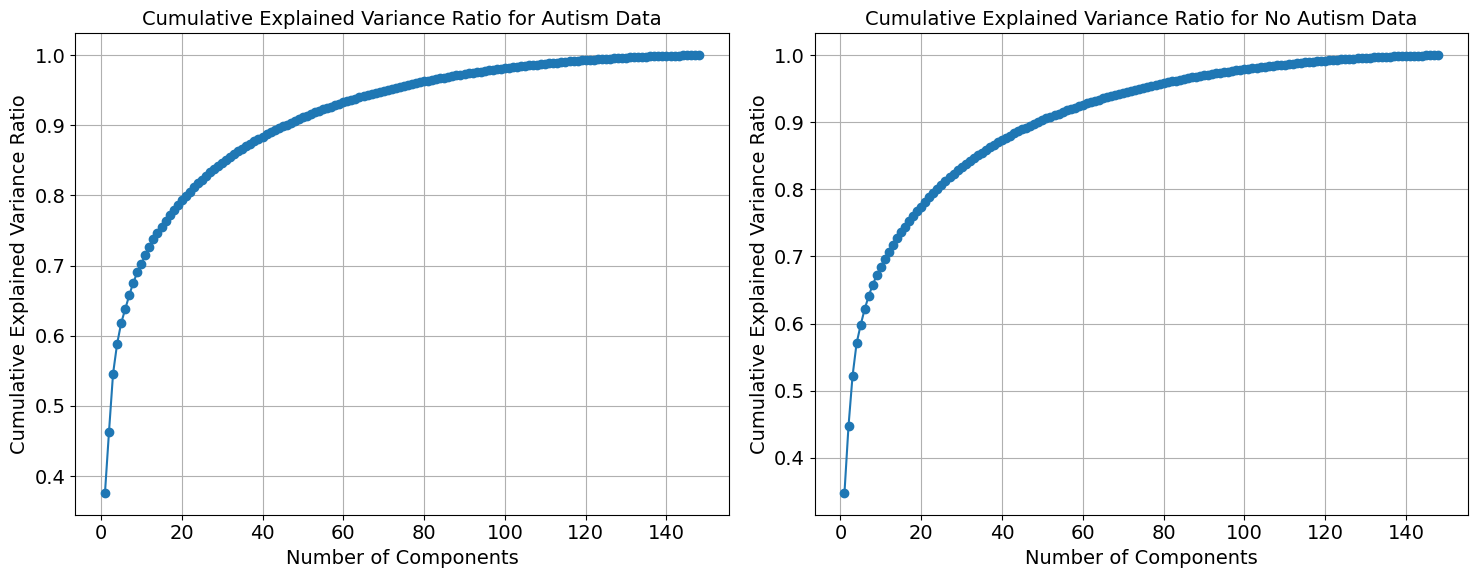

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract "data" arrays from data_info_dict_autism
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]

# Extract "data" arrays from data_info_dict_no_autism
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Create a matrix by stacking the arrays for both groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Fit PCA for autism data
pca_autism = PCA()
pca_autism.fit(autism_data_matrix)

# Fit PCA for non autism data
pca_no_autism = PCA()
pca_no_autism.fit(no_autism_data_matrix)

# Calculate cumulative explained variance ratio for autism data
cumulative_explained_variance_autism = np.cumsum(pca_autism.explained_variance_ratio_)

# Calculate cumulative explained variance ratio for non autism data
cumulative_explained_variance_no_autism = np.cumsum(pca_no_autism.explained_variance_ratio_)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot cumulative explained variance ratio for autism data
axs[0].plot(range(1, len(cumulative_explained_variance_autism) + 1), cumulative_explained_variance_autism, marker='o')
axs[0].set_xlabel('Number of Components')
axs[0].set_ylabel('Cumulative Explained Variance Ratio')
axs[0].set_title('Cumulative Explained Variance Ratio for Autism Data')
axs[0].grid()

# Plot cumulative explained variance ratio for non autism data
axs[1].plot(range(1, len(cumulative_explained_variance_no_autism) + 1), cumulative_explained_variance_no_autism, marker='o')
axs[1].set_xlabel('Number of Components')
axs[1].set_ylabel('Cumulative Explained Variance Ratio')
axs[1].set_title('Cumulative Explained Variance Ratio for No Autism Data')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()


We see somewhat and elbow following the 4th component. However, one could also argue in favor of three components, as there is a stark decrease following this component. Let's inspect the option with four components.

Let's zoom in a little.

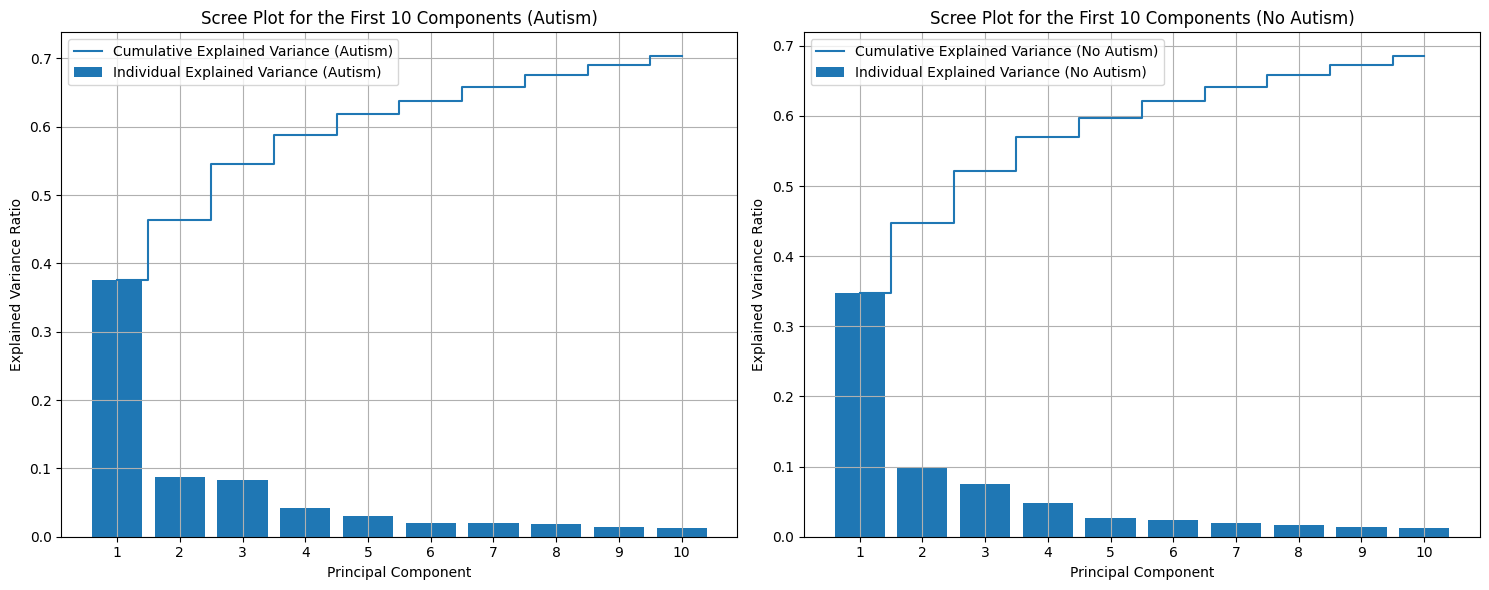

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Extract "data" arrays from data_info_dict_autism
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]

# Extract "data" arrays from data_info_dict_no_autism
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Create a matrix by stacking the arrays for autism and non autism groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Fit PCA with the first 10 components for autism data
n_components = 10
pca_autism = PCA(n_components=n_components)
pca_autism.fit(autism_data_matrix)

# Fit PCA with the first 10 components for non autism data
pca_no_autism = PCA(n_components=n_components)
pca_no_autism.fit(no_autism_data_matrix)

# Scree plot for the first 10 components side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Autism data scree plot
explained_variance_autism = pca_autism.explained_variance_ratio_
cumulative_explained_variance_autism = np.cumsum(explained_variance_autism)

axs[0].bar(range(1, n_components + 1), explained_variance_autism, align='center', label='Individual Explained Variance (Autism)')
axs[0].step(range(1, n_components + 1), cumulative_explained_variance_autism, where='mid', label='Cumulative Explained Variance (Autism)')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Explained Variance Ratio')
axs[0].set_title('Scree Plot for the First 10 Components (Autism)')
axs[0].set_xticks(range(1, n_components + 1))
axs[0].legend()
axs[0].grid()

# No Autism data scree plot
explained_variance_no_autism = pca_no_autism.explained_variance_ratio_
cumulative_explained_variance_no_autism = np.cumsum(explained_variance_no_autism)

axs[1].bar(range(1, n_components + 1), explained_variance_no_autism, align='center', label='Individual Explained Variance (No Autism)')
axs[1].step(range(1, n_components + 1), cumulative_explained_variance_no_autism, where='mid', label='Cumulative Explained Variance (No Autism)')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot for the First 10 Components (No Autism)')
axs[1].set_xticks(range(1, n_components + 1))
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


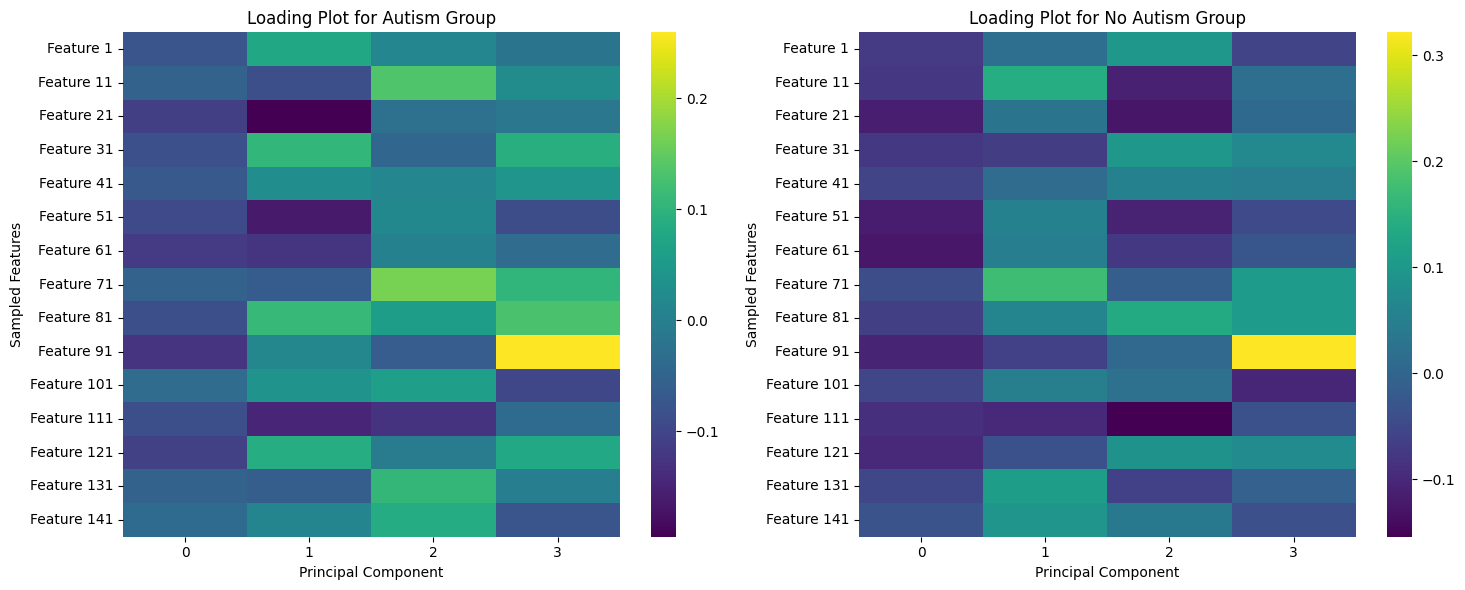

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Extract "data" arrays from dictionaries
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Convert arrays into matrices
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Specify the desired number of features
num_desired_features = 4  # You can adjust this number

# Create PCA instances for both groups
pca_autism = PCA(n_components=num_desired_features)
pca_no_autism = PCA(n_components=num_desired_features)

# Fit and transform "data" arrays for both groups
pca_autism_result = pca_autism.fit_transform(autism_data_matrix)
pca_no_autism_result = pca_no_autism.fit_transform(no_autism_data_matrix)

# Sample a subset of features for plotting (e.g., every 10th feature)
sampled_features_indices = np.arange(0, autism_data_matrix.shape[1], step=10)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Loading plot for autism group
sns.heatmap(pca_autism.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[0])
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Sampled Features')
axs[0].set_title('Loading Plot for Autism Group')

# Loading plot for no autism group
sns.heatmap(pca_no_autism.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[1])
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Sampled Features')
axs[1].set_title('Loading Plot for No Autism Group')

# Adjust layout
plt.tight_layout()
plt.show()


It is interesting to see that the second and third component have a different loading pattern.

In [ ]:
#Find the number of components where cumulative explained variance falls under 1
# Find the number of components to explain 80% of the variance
num_components_80_percent_autism = np.argmax(cumulative_explained_variance_autism >= 0.80) + 1
num_components_80_percent_no_autism = np.argmax(cumulative_explained_variance_no_autism >= 0.80) + 1

# Get the eigenvalues of the first 4 components for both groups
eigenvalues_autism = pca_autism.explained_variance_[:4]
eigenvalues_no_autism = pca_no_autism.explained_variance_[:4]

# Print the eigenvalues
print(f"Number of components for Autism Group where cumulative explained variance falls under 1: {num_components_80_percent_autism}")
print("Eigenvalues for Autism Group:")
for i, eigenvalue in enumerate(eigenvalues_autism):
    print(f"Component {i+1}: {eigenvalue:.4f}")


print(f"\nNumber of components for No Autism Group where cumulative explained variance falls under 1: {num_components_80_percent_no_autism}")
print("Eigenvalues for No Autism Group:")
for i, eigenvalue in enumerate(eigenvalues_no_autism):
    print(f"Component {i+1}: {eigenvalue:.4f}")


Number of components for Autism Group where cumulative explained variance falls under 1: 46
Eigenvalues for Autism Group:
Component 1: 11.2743
Component 2: 2.6192
Component 3: 2.4748
Component 4: 1.2665

Number of components for No Autism Group where cumulative explained variance falls under 1: 49
Eigenvalues for No Autism Group:
Component 1: 8.8548
Component 2: 2.5343
Component 3: 1.9057
Component 4: 1.2358


Based on this, the eigenvalues for the 4th component are still above 1 in both groups. According to Kaiser's criterium, one could already choose at least 4. The screeplot suggests 3 or 4 components. The original publication used 2 components, I am going to use 4 components per sample. Here is the reasoning:

I expect the non-linear nature of the model to work better with less dimensions. Introducing an additional classifier and more information later however, will likely benefit from more latent variables.

In particular, the introduction of gender and age may lead to two of the latent variables to be optimized to represent information of this nature. As to not underfit, I am therefore chosing 4 components for each of the autoencoders.

Number of components to explain 80% of the variance: 24


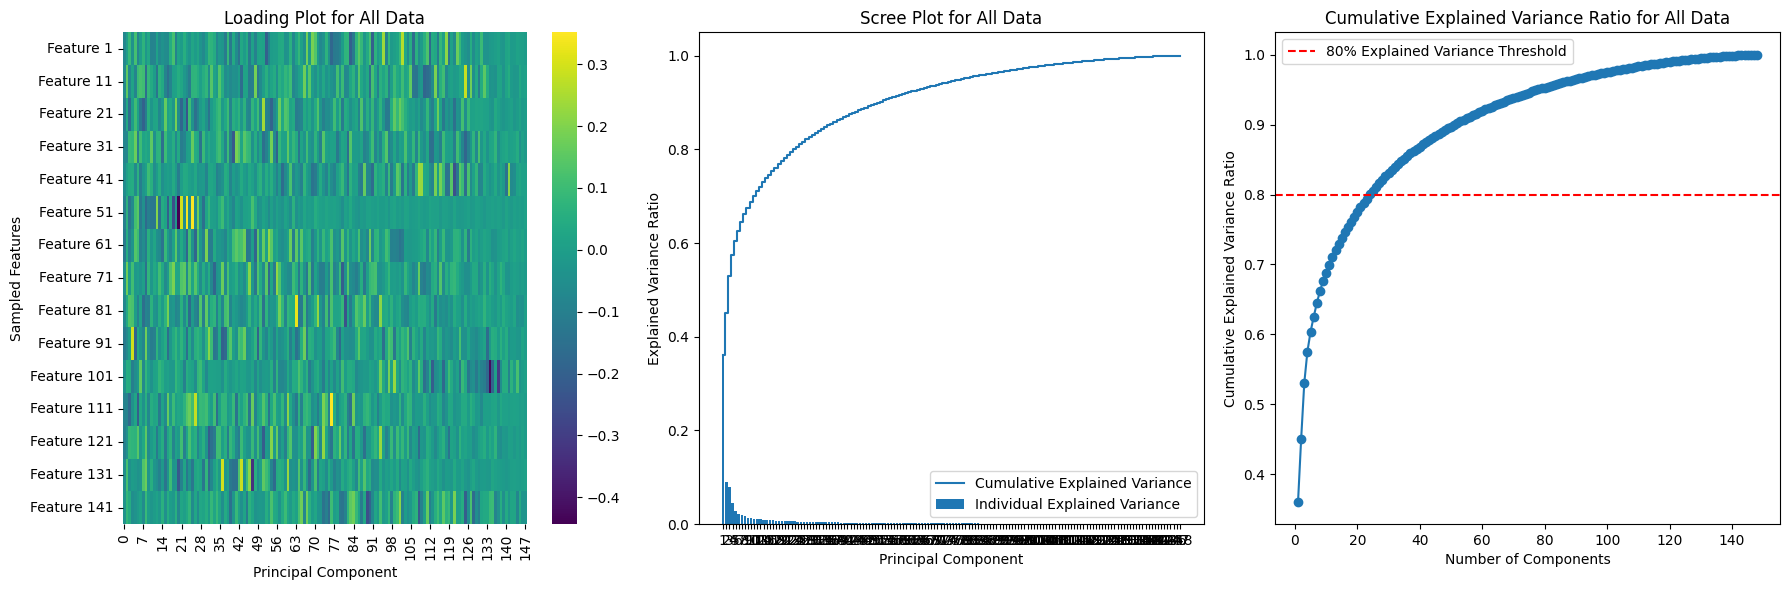

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Extract "data" arrays from dictionaries
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Convert arrays into matrices for both groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Concatenate data matrices for both groups
all_data_matrix = np.vstack((autism_data_matrix, no_autism_data_matrix))

# Create PCA instance for the whole dataset
pca_all = PCA()
pca_all.fit(all_data_matrix)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_all = np.cumsum(pca_all.explained_variance_ratio_)

# Find the number of components to explain 80% of the variance
num_components_80_percent_all = np.argmax(cumulative_explained_variance_all >= 0.80) + 1

print(f"Number of components to explain 80% of the variance: {num_components_80_percent_all}")

# Sample a subset of features for loading plots (e.g., every 10th feature)
sampled_features_indices = np.arange(0, all_data_matrix.shape[1], step=10)

# Create subplots for loading plots and scree plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loading plot for all data
sns.heatmap(pca_all.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[0])
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Sampled Features')
axs[0].set_title('Loading Plot for All Data')

# Scree plot
explained_variance = pca_all.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
axs[1].bar(range(1, len(explained_variance) + 1), explained_variance, align='center', label='Individual Explained Variance')
axs[1].step(range(1, len(explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot for All Data')
axs[1].set_xticks(range(1, len(explained_variance) + 1))
axs[1].legend()

# Cumulative explained variance plot
axs[2].plot(range(1, len(cumulative_explained_variance_all) + 1), cumulative_explained_variance_all, marker='o')
axs[2].axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance Threshold')
axs[2].set_xlabel('Number of Components')
axs[2].set_ylabel('Cumulative Explained Variance Ratio')
axs[2].set_title('Cumulative Explained Variance Ratio for All Data')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Model Building




### Defining utility functions

Firstly, I am defining the loss function.
The loss will be computed as the sum of the BCE-Loss, as well as the KL-divergence terms.

* MSE loss: Incoming

* Cross Entropy: Incoming

* Kullback-Leibler divergence (Kullback & Leibler, 1951) This is a measure for the difference between two distributions. I.e. "how much do they diverge" from each other, how much are they different to each other. The introduction of this term into the final loss leads my model to optimize not only if the precited categories are correct and so on, but also how high the difference between the prior distribution and teh latent variables are. The prior distribution in my case is an isotropic gaussian.
  * Why is this desirable? The latent variables and the sampling process should be somewhat controlled. This divergence regulates this.


I have also attempted to regulate that a loss is only completed with the KL divergence from the second encoder if that encoder was used.

In [76]:
def final_loss(MSE, MSE_age, z_mu, z_logvar, s_mu, s_logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: reconstruction loss
    :param z_mu: mean from the latent vector of encoder_z
    :param z_logvar: log variance from the latent vector of encoder_z
    :param s_mu: mean from the latent vector of encoder_s (optional)
    :param s_logvar: log variance from the latent vector of encoder_s (optional)
    """
    mse_loss = MSE
    mse_age = MSE_age
    KLD_z = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    if mse_age is not None:
      if s_mu is not None and s_logvar is not None:
          KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
          return mse_loss + KLD_z + KLD_s +mse_age
      else:
          return mse_loss + KLD_z + mse_age
    else:
      if s_mu is not None and s_logvar is not None:
          KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
          return mse_loss + KLD_z + KLD_s
      else:
          return mse_loss + KLD_z


Here is the training loop.

In [75]:
def train(model, dataloader, dataset, device, optimizer, criterion, criterion_classifier):
    model.train()
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, ((autism_data, autism_age, _, autism_diag_group,_,_,_,_,_), (no_autism_data, no_autism_age, _, no_autism_diag_group,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        autism_age = autism_age.to(device)
        no_autism_age = no_autism_age.to(device)

        optimizer.zero_grad()

        # Get the model outputs
        z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_no_autism_age, z, s, z_no_autism = model(autism_data, no_autism_data)

        # Calculate classifier losses for age and fiq predictions using the criterion_classifier
        age_loss_autism = criterion_classifier(class_autism_age, autism_age.unsqueeze(1).float())
        age_loss_no_autism = criterion_classifier(class_no_autism_age, no_autism_age.unsqueeze(1).float())

        # Section for the autism images
        bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
        loss_autism = final_loss(bce_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var)
        running_loss_autism += loss_autism.item()
        running_age_loss_autism += age_loss_autism.item()

        # Section for the no_autism images
        bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
        s_mean_no_autism, s_log_var_no_autism = None, None
        loss_no_autism = final_loss(bce_loss_no_autism, age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
        running_loss_no_autism += loss_no_autism.item()
        running_age_loss_no_autism += age_loss_no_autism.item()

        # Total loss
        loss_no_autism.backward()
        loss_autism.backward()

        optimizer.step()
        counter += len(autism_data) + len(no_autism_data)

    train_loss_autism = running_loss_autism / counter
    train_loss_no_autism = running_loss_no_autism / counter
    train_age_loss_autism = running_age_loss_autism / counter
    train_age_loss_no_autism = running_age_loss_no_autism / counter
    return (train_loss_autism, train_loss_no_autism, train_age_loss_autism, train_age_loss_no_autism)


And of course the corresponding validation function


In [74]:
def validate(model, dataloader, dataset, device, criterion, criterion_classifier):
    model.eval()  # Set the model to evaluation mode
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_fiq_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    running_fiq_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, ((autism_data, autism_age, _, autism_diag_group,_,_,_,_,_), (no_autism_data, no_autism_age, _, no_autism_diag_group,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
            autism_data = autism_data.to(device)
            no_autism_data = no_autism_data.to(device)

            autism_age = autism_age.to(device)
            no_autism_age = no_autism_age.to(device)

            # Get the model outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_no_autism_age, z, s, z_no_autism = model(autism_data, no_autism_data)

            # Calculate classifier losses for age and fiq predictions using the criterion_classifier
            age_loss_autism = criterion_classifier(class_autism_age, autism_age.unsqueeze(1).float())

            age_loss_no_autism = criterion_classifier(class_no_autism_age, no_autism_age.unsqueeze(1).float())

            # Section for the autism images
            bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
            loss_autism = final_loss(bce_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var)
            running_loss_autism += loss_autism.item()
            running_age_loss_autism += age_loss_autism.item()

            # Section for the no_autism images
            bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
            s_mean_no_autism, s_log_var_no_autism = None, None
            loss_no_autism = final_loss(bce_loss_no_autism,age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
            running_loss_no_autism += loss_no_autism.item()
            running_age_loss_no_autism += age_loss_no_autism.item()

            counter += len(autism_data) + len(no_autism_data)

    val_loss_autism = running_loss_autism / counter
    val_loss_no_autism = running_loss_no_autism / counter
    val_age_loss_autism = running_age_loss_autism / counter
    val_age_loss_no_autism = running_age_loss_no_autism / counter

    return (val_loss_autism, val_loss_no_autism,
        val_age_loss_autism, val_age_loss_no_autism)


## Model Specifications
In the following I am specifiying the model. I am roughly orienting myself around a paper from Anglinkas, Hartshorne & Anzellotti (2022).


Next I want to define the contrastive variational autoencoder. While doing so, I am defining seperate encoders, to make it easier to later introduce other encoders. I am orienting myself on an cVAE I have written in the past.

As the paper from Aglinskas, Hartshorne and Anzellotti (2022) I mentioned, the network will have only a few layers.

A few things I will probably have to change - I do not know how many channels the data will end up having. therefore I am using one, assuming it only has one.

In [73]:
class EncoderNS(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(EncoderNS, self).__init__()
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, latent_dim)
        self.ns_fc_mean = nn.Linear(latent_dim, latent_dim)
        self.ns_fc_log_var = nn.Linear(latent_dim, latent_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x, batch_size):
        h = self.leaky_relu(self.linear1(x))
        h = self.leaky_relu(self.linear2(h))
        h = self.leaky_relu(self.linear3(h))
        ns_mean = self.ns_fc_mean(h)
        ns_log_var = self.ns_fc_log_var(h)
        return ns_mean, ns_log_var


class EncoderS(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(EncoderS, self).__init__()
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, latent_dim)
        self.s_fc_mean = nn.Linear(latent_dim, latent_dim)
        self.s_fc_log_var = nn.Linear(latent_dim, latent_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x, batch_size):
        h = self.leaky_relu(self.linear1(x))
        h = self.leaky_relu(self.linear2(h))
        h = self.leaky_relu(self.linear3(h))
        s_mean = self.s_fc_mean(h)
        s_log_var = self.s_fc_log_var(h)
        return s_mean, s_log_var

class Decoder(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(Decoder, self).__init__()
        self.linear_decoder_1 = nn.Linear(latent_dim * 2, 32)
        self.linear_decoder_2 = nn.Linear(32, 64)
        self.linear_decoder_3 = nn.Linear(64, input_dimension)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, zs, batch_size):
        h_output = self.leaky_relu(self.linear_decoder_1(zs))
        h_output = self.leaky_relu(self.linear_decoder_2(h_output))
        output = self.linear_decoder_3(h_output)
        return output

class Classifier(nn.Module):
    def __init__(self, latent_dim):
        super(Classifier, self).__init__()
        self.fc_first_age = nn.Linear(latent_dim * 2, latent_dim // 2)
        self.fc_age = nn.Linear(latent_dim // 2, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, z):
        x_age = self.fc_first_age(z)
        x_age = self.leaky_relu(x_age)
        age_prediction = self.fc_age(x_age)
        return age_prediction

class cVAE_classifier(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(cVAE_classifier, self).__init__()
        self.encoder_z = EncoderNS(input_dimension, latent_dim)
        self.encoder_s = EncoderS(input_dimension, latent_dim)
        self.decoder = Decoder(input_dimension, latent_dim)
        self.classifier = Classifier(latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, autism, no_autism):
        batch_size = autism.size(0)
        z_mean, z_log_var = self.encoder_z(autism, batch_size)
        z = self.reparameterize(z_mean, z_log_var)
        s_mean, s_log_var = self.encoder_s(autism, batch_size)
        s = self.reparameterize(s_mean, s_log_var)
        zs = torch.cat([z, s], dim=1)

        reconstructed_data_autism = self.decoder(zs, batch_size)

        z_mean_no_autism, z_log_var_no_autism = self.encoder_z(no_autism, batch_size)
        z_no_autism = self.reparameterize(z_mean_no_autism, z_log_var_no_autism)
        z_empty = torch.zeros(z_no_autism.shape)
        model_device = z_no_autism.device
        z_empty = z_empty.to(model_device)
        z_no_autism_0 = torch.cat([z_no_autism, z_empty], dim=1)


        reconstructed_data_no_autism = self.decoder(z_no_autism_0, batch_size)

        class_autism_age = self.classifier(zs)
        class_no_autism_age = self.classifier(z_no_autism_0)

        return z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_no_autism_age, z, s, z_no_autism

### Other models that will be tested later.

Firstly, here is a model, as well as the relevant training and validaiton functions, for a mdoel without a classifier.

In [72]:
class cVAE(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(cVAE, self).__init__()
        self.encoder_z = EncoderNS(input_dimension, latent_dim)
        self.encoder_s = EncoderS(input_dimension, latent_dim)
        self.decoder = Decoder(input_dimension, latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, autism, no_autism):
        batch_size = autism.size(0)
        z_mean, z_log_var = self.encoder_z(autism, batch_size)
        z = self.reparameterize(z_mean, z_log_var)
        s_mean, s_log_var = self.encoder_s(autism, batch_size)
        s = self.reparameterize(s_mean, s_log_var)
        zs = torch.cat([z, s], dim=1)

        reconstructed_data_autism = self.decoder(zs, batch_size)

        z_mean_no_autism, z_log_var_no_autism = self.encoder_z(no_autism, batch_size)
        z_no_autism = self.reparameterize(z_mean_no_autism, z_log_var_no_autism)
        z_empty = torch.zeros(z_no_autism.shape)
        model_device = z_no_autism.device
        z_empty = z_empty.to(model_device)
        z_no_autism_0 = torch.cat([z_no_autism, z_empty], dim=1)

        reconstructed_data_no_autism = self.decoder(z_no_autism_0, batch_size)

        return z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism

def train_no_classifier(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, ((autism_data, _, _, _,_,_,_,_,_), (no_autism_data, _, _, _,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        optimizer.zero_grad()

        # Get the model outputs
        z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism = model(autism_data, no_autism_data)

        # Section for the autism images
        bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
        loss_autism = final_loss(bce_loss_autism , None, z_mean, z_log_var, s_mean, s_log_var)
        running_loss_autism += loss_autism.item()

        # Section for the no_autism images
        bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
        s_mean_no_autism, s_log_var_no_autism = None, None
        loss_no_autism = final_loss(bce_loss_no_autism  , None, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
        running_loss_no_autism += loss_no_autism.item()

        # Total loss
        loss_no_autism.backward()
        loss_autism.backward()

        optimizer.step()
        counter += len(autism_data) + len(no_autism_data)

    train_loss_autism = running_loss_autism / counter
    train_loss_no_autism = running_loss_no_autism / counter

    return train_loss_autism, train_loss_no_autism



def validate_no_classifier(model, dataloader, dataset, device, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, ((autism_data, _, _, _,_,_,_,_,_), (no_autism_data, _, _, _,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
            autism_data = autism_data.to(device)
            no_autism_data = no_autism_data.to(device)

            # Get the model outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism = model(autism_data, no_autism_data)

            # Section for the autism images
            bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
            loss_autism = final_loss(bce_loss_autism  , None, z_mean, z_log_var, s_mean, s_log_var)
            running_loss_autism += loss_autism.item()

            # Section for the no_autism images
            bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
            s_mean_no_autism, s_log_var_no_autism = None, None
            loss_no_autism = final_loss(bce_loss_no_autism  , None, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
            running_loss_no_autism += loss_no_autism.item()

            counter += len(autism_data) + len(no_autism_data)

    val_loss_autism = running_loss_autism / counter
    val_loss_no_autism = running_loss_no_autism / counter

    return val_loss_autism, val_loss_no_autism



## Training the model

In this section, I am training the various models

In [19]:
lr = 0.01
model_classifier = cVAE_classifier(input_dimension=148, latent_dim=16).to(device)
optimizer = torch.optim.Adam(model_classifier.parameters(), lr=lr)
criterion = nn.MSELoss()
classifier_criterion = nn.MSELoss()

# Create separate lists for training and validation losses for age, FIQ, and other terms
train_age_losses = []
val_age_losses = []
train_fiq_losses = []
val_fiq_losses = []
train_other_losses = []
val_other_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    # Train the model
    (train_loss_autism,
     train_loss_no_autism,
     train_age_loss_autism,
     train_age_loss_no_autism) = train(
        model_classifier,
        train_dataloader,
        train_dataset,
        device,
        optimizer,
        criterion,
        classifier_criterion)

    # Validate the model
    (val_loss_autism, val_loss_no_autism, val_age_loss_autism, val_age_loss_no_autism) = validate(model_classifier, val_dataloader, val_dataset, device, criterion, classifier_criterion)

    # Appending the loss values to their respective lists for visualizations:
    train_age_losses.append(train_age_loss_autism + train_age_loss_no_autism)
    train_other_losses.append(train_loss_autism + train_loss_no_autism)

    val_age_losses.append(val_age_loss_autism + val_age_loss_no_autism)
    val_other_losses.append(val_loss_autism + val_loss_no_autism)

    print(
        f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}, "
        f"Train Age Loss Autism: {train_age_loss_autism:.4f}, Train Age Loss Non-Autism: {train_age_loss_no_autism:.4f}"
    )

    print(
        f"Val Loss Autism: {val_loss_autism:.4f}, Val Loss Non-Autism: {val_loss_no_autism:.4f}, "
        f"Val Age Loss Autism: {val_age_loss_autism:.4f}, Val Age Loss Non-Autism: {val_age_loss_no_autism:.4f}"
    )

# Create subplots for loss in relation to age, FIQ, and other loss terms
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot training and validation losses for age
axs[0].plot(train_age_losses, label='Training Age Loss')
axs[0].plot(val_age_losses, label='Validation Age Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Age Loss')
axs[0].set_title('Age Loss')
axs[0].legend()

# Plot training and validation losses for other terms (KL divergence + Reconstruction loss)
axs[1].plot(train_other_losses, label='Training KL + Recon Loss')
axs[1].plot(val_other_losses, label='Validation KL + Recon Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('KL + Recon Loss')
axs[1].set_title('KL + Recon Loss')
axs[1].legend()

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


KeyboardInterrupt: ignored

Let's save this model.

In [ ]:
torch.save(model_classifier.state_dict(), '/content/drive/MyDrive/MasterThesisData/model_basic_classifier.pth')

In [28]:
model_classifier = cVAE_classifier(input_dimension = 148, latent_dim= 16).to(device)
model_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MasterThesisData/model_basic_classifier.pth', map_location=device))

<All keys matched successfully>

Next, here is the training for the model wihtout a classifier.

7it [00:00, 92.51it/s]               
1it [00:00, 115.21it/s]


Epoch [1/100]
Train Loss Autism: 0.3914, Train Loss Non-Autism: 0.1840
Val Loss Autism: 0.1682, Val Loss Non-Autism: 0.1052


7it [00:00, 72.44it/s]               
1it [00:00, 135.33it/s]


Epoch [2/100]
Train Loss Autism: 0.0950, Train Loss Non-Autism: 0.0537
Val Loss Autism: 0.0390, Val Loss Non-Autism: 0.0259


7it [00:00, 85.09it/s]               
1it [00:00, 125.93it/s]


Epoch [3/100]
Train Loss Autism: 0.0273, Train Loss Non-Autism: 0.0192
Val Loss Autism: 0.0259, Val Loss Non-Autism: 0.0183


7it [00:00, 93.05it/s]               
1it [00:00, 103.20it/s]


Epoch [4/100]
Train Loss Autism: 0.0169, Train Loss Non-Autism: 0.0105
Val Loss Autism: 0.0118, Val Loss Non-Autism: 0.0066


7it [00:00, 86.87it/s]               
1it [00:00, 138.94it/s]


Epoch [5/100]
Train Loss Autism: 0.0087, Train Loss Non-Autism: 0.0051
Val Loss Autism: 0.0076, Val Loss Non-Autism: 0.0045


7it [00:00, 82.12it/s]               
1it [00:00, 135.51it/s]


Epoch [6/100]
Train Loss Autism: 0.0053, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0031


7it [00:00, 93.73it/s]               
1it [00:00, 118.36it/s]


Epoch [7/100]
Train Loss Autism: 0.0040, Train Loss Non-Autism: 0.0026
Val Loss Autism: 0.0041, Val Loss Non-Autism: 0.0028


7it [00:00, 92.28it/s]               
1it [00:00, 112.35it/s]


Epoch [8/100]
Train Loss Autism: 0.0031, Train Loss Non-Autism: 0.0023
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0023


7it [00:00, 74.42it/s]               
1it [00:00, 113.74it/s]


Epoch [9/100]
Train Loss Autism: 0.0026, Train Loss Non-Autism: 0.0019
Val Loss Autism: 0.0030, Val Loss Non-Autism: 0.0021


7it [00:00, 79.02it/s]               
1it [00:00, 140.53it/s]


Epoch [10/100]
Train Loss Autism: 0.0024, Train Loss Non-Autism: 0.0019
Val Loss Autism: 0.0030, Val Loss Non-Autism: 0.0022


7it [00:00, 90.95it/s]               
1it [00:00, 113.57it/s]


Epoch [11/100]
Train Loss Autism: 0.0023, Train Loss Non-Autism: 0.0018
Val Loss Autism: 0.0028, Val Loss Non-Autism: 0.0020


7it [00:00, 91.39it/s]               
1it [00:00, 146.76it/s]


Epoch [12/100]
Train Loss Autism: 0.0022, Train Loss Non-Autism: 0.0017
Val Loss Autism: 0.0027, Val Loss Non-Autism: 0.0020


7it [00:00, 91.84it/s]               
1it [00:00, 114.57it/s]


Epoch [13/100]
Train Loss Autism: 0.0021, Train Loss Non-Autism: 0.0017
Val Loss Autism: 0.0026, Val Loss Non-Autism: 0.0020


7it [00:00, 87.32it/s]               
1it [00:00, 120.65it/s]


Epoch [14/100]
Train Loss Autism: 0.0020, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0027, Val Loss Non-Autism: 0.0020


7it [00:00, 78.95it/s]               
1it [00:00, 127.26it/s]


Epoch [15/100]
Train Loss Autism: 0.0020, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0027, Val Loss Non-Autism: 0.0019


7it [00:00, 89.78it/s]               
1it [00:00, 115.65it/s]


Epoch [16/100]
Train Loss Autism: 0.0020, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0027, Val Loss Non-Autism: 0.0019


7it [00:00, 83.05it/s]               
1it [00:00, 128.71it/s]


Epoch [17/100]
Train Loss Autism: 0.0020, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0027, Val Loss Non-Autism: 0.0020


7it [00:00, 93.79it/s]               
1it [00:00, 116.11it/s]


Epoch [18/100]
Train Loss Autism: 0.0019, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0026, Val Loss Non-Autism: 0.0020


7it [00:00, 79.47it/s]               
1it [00:00, 118.86it/s]


Epoch [19/100]
Train Loss Autism: 0.0019, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0025, Val Loss Non-Autism: 0.0019


7it [00:00, 91.52it/s]               
1it [00:00, 148.18it/s]


Epoch [20/100]
Train Loss Autism: 0.0019, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0025, Val Loss Non-Autism: 0.0018


7it [00:00, 90.39it/s]               
1it [00:00, 99.92it/s]


Epoch [21/100]
Train Loss Autism: 0.0019, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0025, Val Loss Non-Autism: 0.0018


7it [00:00, 87.98it/s]               
1it [00:00, 138.30it/s]


Epoch [22/100]
Train Loss Autism: 0.0019, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 82.77it/s]               
1it [00:00, 121.91it/s]


Epoch [23/100]
Train Loss Autism: 0.0019, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0025, Val Loss Non-Autism: 0.0018


7it [00:00, 93.75it/s]               
1it [00:00, 119.70it/s]


Epoch [24/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0025, Val Loss Non-Autism: 0.0018


7it [00:00, 92.56it/s]               
1it [00:00, 113.41it/s]


Epoch [25/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0025, Val Loss Non-Autism: 0.0019


7it [00:00, 88.50it/s]               
1it [00:00, 158.24it/s]


Epoch [26/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 91.04it/s]               
1it [00:00, 117.11it/s]


Epoch [27/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0025, Val Loss Non-Autism: 0.0020


7it [00:00, 95.08it/s]               
1it [00:00, 130.82it/s]


Epoch [28/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 67.43it/s]
1it [00:00, 100.57it/s]


Epoch [29/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0019


7it [00:00, 80.11it/s]               
1it [00:00, 112.87it/s]


Epoch [30/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 85.43it/s]               
1it [00:00, 115.74it/s]


Epoch [31/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0019


7it [00:00, 84.29it/s]               
1it [00:00, 112.25it/s]


Epoch [32/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0025, Val Loss Non-Autism: 0.0019


7it [00:00, 90.49it/s]               
1it [00:00, 130.70it/s]


Epoch [33/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 80.84it/s]               
1it [00:00, 121.28it/s]


Epoch [34/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 89.75it/s]               
1it [00:00, 121.11it/s]


Epoch [35/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 82.43it/s]               
1it [00:00, 122.13it/s]


Epoch [36/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0019


7it [00:00, 85.83it/s]               
1it [00:00, 128.25it/s]


Epoch [37/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 81.15it/s]               
1it [00:00, 119.08it/s]


Epoch [38/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 86.37it/s]               
1it [00:00, 123.39it/s]


Epoch [39/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 74.41it/s]               
1it [00:00, 113.19it/s]


Epoch [40/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0016
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 89.09it/s]               
1it [00:00, 159.95it/s]


Epoch [41/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0019


7it [00:00, 90.40it/s]               
1it [00:00, 116.27it/s]


Epoch [42/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 91.49it/s]               
1it [00:00, 137.86it/s]


Epoch [43/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 91.52it/s]               
1it [00:00, 121.18it/s]


Epoch [44/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 94.77it/s]               
1it [00:00, 99.18it/s]


Epoch [45/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0017


7it [00:00, 89.15it/s]               
1it [00:00, 85.91it/s]


Epoch [46/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 92.62it/s]               
1it [00:00, 130.30it/s]


Epoch [47/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 76.64it/s]               
1it [00:00, 132.83it/s]


Epoch [48/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 91.94it/s]               
1it [00:00, 141.40it/s]


Epoch [49/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0024, Val Loss Non-Autism: 0.0018


7it [00:00, 83.86it/s]               
1it [00:00, 109.54it/s]


Epoch [50/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 92.32it/s]               
1it [00:00, 131.24it/s]


Epoch [51/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0019


7it [00:00, 88.90it/s]               
1it [00:00, 117.03it/s]


Epoch [52/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 90.87it/s]               
1it [00:00, 126.41it/s]


Epoch [53/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 88.06it/s]               
1it [00:00, 114.30it/s]


Epoch [54/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 89.85it/s]               
1it [00:00, 139.81it/s]


Epoch [55/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 87.61it/s]               
1it [00:00, 104.73it/s]


Epoch [56/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 85.35it/s]               
1it [00:00, 105.33it/s]


Epoch [57/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0019


7it [00:00, 82.87it/s]               
1it [00:00, 110.42it/s]


Epoch [58/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 86.85it/s]               
1it [00:00, 143.37it/s]


Epoch [59/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 87.42it/s]               
1it [00:00, 125.35it/s]


Epoch [60/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 89.09it/s]               
1it [00:00, 112.18it/s]


Epoch [61/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 89.25it/s]               
1it [00:00, 75.63it/s]


Epoch [62/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0017


7it [00:00, 96.38it/s]               
1it [00:00, 132.32it/s]


Epoch [63/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 82.13it/s]               
1it [00:00, 117.32it/s]


Epoch [64/100]
Train Loss Autism: 0.0018, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 93.23it/s]               
1it [00:00, 133.76it/s]


Epoch [65/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 84.68it/s]               
1it [00:00, 102.98it/s]


Epoch [66/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 82.53it/s]               
1it [00:00, 134.46it/s]


Epoch [67/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 87.52it/s]               
1it [00:00, 105.63it/s]


Epoch [68/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 72.94it/s]               
1it [00:00, 138.09it/s]


Epoch [69/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 87.60it/s]               
1it [00:00, 85.16it/s]


Epoch [70/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 55.41it/s]                       
1it [00:00, 71.85it/s]


Epoch [71/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 57.95it/s]                       
1it [00:00, 93.18it/s]


Epoch [72/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 56.68it/s]                       
1it [00:00, 60.64it/s]


Epoch [73/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 56.38it/s]                       
1it [00:00, 99.11it/s]


Epoch [74/100]
Train Loss Autism: 0.0016, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 58.98it/s]                       
1it [00:00, 85.12it/s]


Epoch [75/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 61.39it/s]
1it [00:00, 99.27it/s]


Epoch [76/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 53.69it/s]                       
1it [00:00, 99.62it/s]


Epoch [77/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 58.48it/s]                       
1it [00:00, 81.74it/s]


Epoch [78/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 60.74it/s]
1it [00:00, 75.33it/s]


Epoch [79/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 55.72it/s]                       
1it [00:00, 93.22it/s]


Epoch [80/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 57.76it/s]                       
1it [00:00, 78.56it/s]


Epoch [81/100]
Train Loss Autism: 0.0016, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 53.74it/s]                       
1it [00:00, 84.87it/s]


Epoch [82/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 49.10it/s]                       
1it [00:00, 52.82it/s]


Epoch [83/100]
Train Loss Autism: 0.0016, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 51.51it/s]                       
1it [00:00, 81.49it/s]


Epoch [84/100]
Train Loss Autism: 0.0016, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 56.73it/s]                       
1it [00:00, 85.34it/s]


Epoch [85/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0019


7it [00:00, 59.93it/s]                       
1it [00:00, 50.70it/s]


Epoch [86/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 59.98it/s]                       
1it [00:00, 89.69it/s]


Epoch [87/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0017


7it [00:00, 52.80it/s]                       
1it [00:00, 78.60it/s]


Epoch [88/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 55.98it/s]                       
1it [00:00, 54.02it/s]


Epoch [89/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 59.84it/s]                       
1it [00:00, 76.43it/s]


Epoch [90/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 58.15it/s]                       
1it [00:00, 90.87it/s]


Epoch [91/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 63.26it/s]
1it [00:00, 96.64it/s]


Epoch [92/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 56.93it/s]                       
1it [00:00, 90.32it/s]


Epoch [93/100]
Train Loss Autism: 0.0016, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 61.72it/s]
1it [00:00, 78.16it/s]


Epoch [94/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0017


7it [00:00, 54.35it/s]                       
1it [00:00, 71.84it/s]


Epoch [95/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0023, Val Loss Non-Autism: 0.0018


7it [00:00, 59.01it/s]                       
1it [00:00, 91.15it/s]


Epoch [96/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 59.46it/s]                       
1it [00:00, 91.43it/s]


Epoch [97/100]
Train Loss Autism: 0.0016, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0017


7it [00:00, 57.39it/s]                       
1it [00:00, 67.56it/s]


Epoch [98/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018


7it [00:00, 72.26it/s]               
1it [00:00, 112.05it/s]


Epoch [99/100]
Train Loss Autism: 0.0017, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0017


7it [00:00, 77.16it/s]               
1it [00:00, 83.81it/s]


Epoch [100/100]
Train Loss Autism: 0.0016, Train Loss Non-Autism: 0.0015
Val Loss Autism: 0.0022, Val Loss Non-Autism: 0.0018
TRAINING COMPLETE


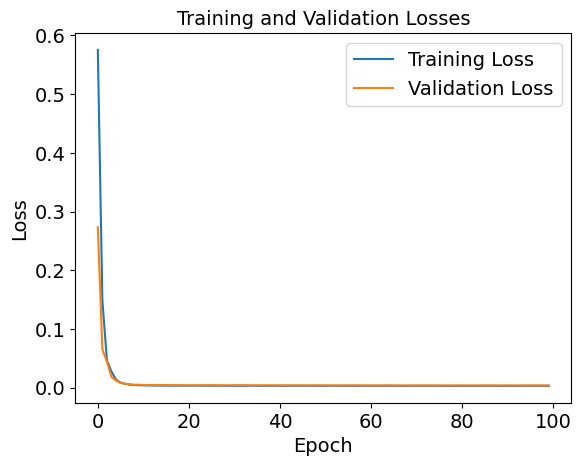

In [ ]:
# Define the learning rate and create the model, optimizer, and loss functions
lr = 0.01
model_basic = cVAE(input_dimension=148, latent_dim=16).to(device)
optimizer = torch.optim.Adam(model_basic.parameters(), lr=lr)
criterion = nn.MSELoss()

train_loss_list = []  # List to store train losses
val_loss_list = []    # List to store validation losses

num_epochs = 100
for epoch in range(num_epochs):
    train_loss_autism, train_loss_no_autism = train_no_classifier(model_basic, train_dataloader, train_dataset, device, optimizer, criterion)

    # Validate the model
    val_loss_autism, val_loss_no_autism = validate_no_classifier(model_basic, val_dataloader, val_dataset, device, criterion)

    # Appending the loss values to a list to allow for visualizations:
    train_loss_list.append(train_loss_autism + train_loss_no_autism)
    val_loss_list.append(val_loss_autism + val_loss_no_autism)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}")
    print(f"Val Loss Autism: {val_loss_autism:.4f}, Val Loss Non-Autism: {val_loss_no_autism:.4f}")

print("TRAINING COMPLETE")

# Plot the training and validation losses
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Here, I am saving this model

In [ ]:
torch.save(model_basic.state_dict(), '/content/drive/MyDrive/MasterThesisData/model_basic.pth')


And here it is loaded.

In [20]:
model_basic = cVAE(input_dimension = 148, latent_dim = 16).to(device)
model_basic.load_state_dict(torch.load('/content/drive/MyDrive/MasterThesisData/model_basic.pth', map_location=device))

<All keys matched successfully>

### Inspecting latent variance

In [ ]:
model_classifier.eval()
no_batch_test_iterator = iter(train_dataloader_no_batch)
(autism_data, autism_age, autism_FIQ, autism_diag_group, autism_ADOS_TOTAL, autism_gender, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_sub_id), (no_autism_data, no_autism_age, no_autism_FIQ, _,  no_autism_gender, no_autism_sub_id) = next(no_batch_test_iterator)
autism_data = autism_data.to(device)
no_autism_data = no_autism_data.to(device)
z_mean_classifier, z_log_var_classifier, s_mean_classifier, s_log_var_classifier, _, _, _, _, _, _, _, _, _ = model_classifier(autism_data, no_autism_data)

# Compute and print the range and mean of z_mean_classifier
z_mean_min = z_mean_classifier.min().item()
z_mean_max = z_mean_classifier.max().item()
z_mean_mean = z_mean_classifier.mean().item()
print(f"z_mean_classifier range: ({z_mean_min}, {z_mean_max}), mean: {z_mean_mean}")

# Compute and print the range and mean of z_log_var_classifier
z_log_var_min = z_log_var_classifier.min().item()
z_log_var_max = z_log_var_classifier.max().item()
z_log_var_mean = z_log_var_classifier.mean().item()
print(f"z_log_var_classifier range: ({z_log_var_min}, {z_log_var_max}), mean: {z_log_var_mean}")

# Compute and print the range and mean of s_mean_classifier
s_mean_min = s_mean_classifier.min().item()
s_mean_max = s_mean_classifier.max().item()
s_mean_mean = s_mean_classifier.mean().item()
print(f"s_mean_classifier range: ({s_mean_min}, {s_mean_max}), mean: {s_mean_mean}")

# Compute and print the range and mean of s_log_var_classifier
s_log_var_min = s_log_var_classifier.min().item()
s_log_var_max = s_log_var_classifier.max().item()
s_log_var_mean = s_log_var_classifier.mean().item()
print(f"s_log_var_classifier range: ({s_log_var_min}, {s_log_var_max}), mean: {s_log_var_mean}")


z_mean_classifier range: (-1.4134407043457031, 1.7930105924606323), mean: 0.003907949663698673
z_log_var_classifier range: (-0.17662373185157776, 0.5672082304954529), mean: -0.009442154318094254
s_mean_classifier range: (-0.42090409994125366, 0.4116307199001312), mean: -0.0009403193253092468
s_log_var_classifier range: (-0.05790270119905472, 0.1324090212583542), mean: -0.0018892011139541864


## Definition of Functions for Analyses


Before I will actually get to analyze the data, I want to define all the analyses steps and data wrangling I will use more often as functions. This will later end up with easier and faster analyses steps!

Here are all the functions that will be necessary to perform an RSA.

Starting with the DSM:

In [66]:
# Importing all the modules now that will later be used.
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kendalltau
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

# Define a function to calculate dissimilarity matrix
def calculate_dissimilarity_matrix(latent_vectors, metric='euclidean'):
    # Flatten the list of 3D arrays to a 2D array
    latent_vectors_flat = np.vstack(latent_vectors)

    # Calculate pairwise distances
    pairwise_distances = pdist(latent_vectors_flat, metric=metric)

    # Convert condensed distance matrix to square dissimilarity matrix
    dissimilarity_matrix = squareform(pairwise_distances)

    return dissimilarity_matrix

# Define a function to calculate the representational dissimilarity matrix (RDM)
def make_RDM(vec, data_scale='ratio', metric='euclidean'):
    vec = np.array(vec)
    min_val = min(vec.flatten())
    max_val = max(vec.flatten())

    # Avoid division by zero by adding a small constant
    vec = (vec - min_val) / (max_val - min_val)

    if np.ndim(vec) == 1:  # must be at least 2D
        vec = np.vstack((vec, np.zeros(vec.shape))).transpose()

    mat = squareform(pdist(vec, metric=metric).transpose())
    if data_scale == 'ordinal':
        mat[mat != 0] = 1  # Make into zeros and ones

    return mat

Next, here is the computation of the RSA.

In [67]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import kendalltau
import scipy

def compute_rsa(latent_vectors, variable_data):
    """
    Compute RSA (Representational Similarity Analysis) similarity between latent vectors and a variable.

    Args:
    - latent_vectors: List or array of latent vectors.
    - variable_data: List or array of data for the variable.

    Returns:
    - RSA similarity score.
    """
    # Compute the Pearson correlation between latent vectors and the current variable
    correlation_matrix = np.corrcoef(latent_vectors, variable_data)

    # Extract the upper triangular part of the correlation matrix (excluding diagonal)
    upper_triangular = squareform(correlation_matrix, checks=False)

    # Calculate RSA similarity score (mean of the upper triangular values)
    rsa_similarity = np.mean(upper_triangular)

    return rsa_similarity

def compute_rsa_with_kendall_tau(matrix1, matrix2):
    """
    Compute RSA (Representational Similarity Analysis) with Kendall Tau correlation between two dissimilarity matrices.

    Args:
    - dissimilarity_matrix1: The first dissimilarity matrix.
    - dissimilarity_matrix2: The second dissimilarity matrix.

    Returns:
    - RSA similarity score using Kendall Tau correlation.
    """
    corr = scipy.stats.kendalltau
    r = corr(matrix1, matrix2)[0]
    r = np.arctan(r)
    return r


def rsa_dict_without_missing_values(data_dict):
    """
    Compute RSA (Representational Similarity Analysis) for each latent vector-variable pairing in a data dictionary
    while handling missing values.


    Args:
    - data_dict: Dictionary where keys are variable names and values are lists or arrays of data.
                 The first key is assumed to represent latent vectors, and the second key is participant IDs.

    Returns:
    - Dictionary of RSA similarity scores for each variable pairing, or None if any pairing has missing values.
    """
    rsa_results = {}  # Dictionary to store RSA results

    variable_scales = {
    'ADOS Total': 'ratio',
    'ADOS Social': 'ratio',
    'DSM IV': 'ordinal',
    'AGE_AT_SCAN': 'ratio',
    'Sex': 'ordinal',
    'FIQ': 'ordinal',
    'Age': 'ratio',
    'Gender': 'ordinal'}

    # Get latent vectors and participant IDs
    latent_vectors = data_dict[list(data_dict.keys())[0]]
    participant_ids = data_dict['participant_ids']

    # Iterate through variables
    for variable_name, variable_data in data_dict.items():
        if variable_name != 'salient_vector' and variable_name != 'participant_ids' and variable_name != 'Shared_vector':
            rsa_values = []  # List to store RSA values for each sample
            for i in range(len(latent_vectors)):
                latent_vector = latent_vectors[i]
                covariate = variable_data[i]

                # Find indices of NAs
                missings = find_non_numeric_indices(covariate)

                # Exclude missing values
                latent_vector_no_missing = [item for j, item in enumerate(latent_vector) if j not in missings]
                covariate_no_missing = [item for j, item in enumerate(covariate) if j not in missings]

                # Create matrices
                dissimilarity_latent_no_missing = calculate_dissimilarity_matrix([latent_vector_no_missing])

                rdm_covariate = make_RDM(covariate_no_missing, data_scale=variable_scales[variable_name])

                # Compute RSA similarity score
                rsa_similarity = compute_rsa_with_kendall_tau(dissimilarity_latent_no_missing, rdm_covariate)
                rsa_values.append(rsa_similarity)

            # Append the RSA values to the results dictionary
            rsa_results[variable_name] = rsa_values

    return rsa_results

def rsa_dict_without_missing_values_pearson(data_dict):
    """
    Compute RSA (Representational Similarity Analysis) for each latent vector-variable pairing in a data dictionary
    while handling missing values.


    Args:
    - data_dict: Dictionary where keys are variable names and values are lists or arrays of data.
                 The first key is assumed to represent latent vectors, and the second key is participant IDs.

    Returns:
    - Dictionary of RSA similarity scores for each variable pairing, or None if any pairing has missing values.
    """
    rsa_results = {}  # Dictionary to store RSA results

    variable_scales = {
    'ADOS Total': 'ratio',
    'ADOS Social': 'ratio',
    'DSM IV': 'ordinal',
    'AGE_AT_SCAN': 'ratio',
    'Sex': 'ordinal',
    'FIQ': 'ordinal',
    'Age': 'ratio',
    'Gender': 'ordinal'}

    # Get latent vectors and participant IDs
    latent_vectors = data_dict[list(data_dict.keys())[0]]
    participant_ids = data_dict['participant_ids']

    # Iterate through variables
    for variable_name, variable_data in data_dict.items():
        if variable_name != 'salient_vector' and variable_name != 'participant_ids' and variable_name != 'Shared_vector':
            rsa_values = []  # List to store RSA values for each sample
            for i in range(len(latent_vectors)):
                latent_vector = latent_vectors[i]
                covariate = variable_data[i]

                # Find indices of NAs
                missings = find_non_numeric_indices(covariate)

                # Exclude missing values
                latent_vector_no_missing = [item for j, item in enumerate(latent_vector) if j not in missings]
                covariate_no_missing = [item for j, item in enumerate(covariate) if j not in missings]

                # Create matrices
                dissimilarity_latent_no_missing = calculate_dissimilarity_matrix([latent_vector_no_missing])

                rdm_covariate = make_RDM(covariate_no_missing, data_scale=variable_scales[variable_name])

                # Compute RSA similarity score
                rsa_similarity = compute_rsa(dissimilarity_latent_no_missing, rdm_covariate)
                rsa_values.append(rsa_similarity)

            # Append the RSA values to the results dictionary
            rsa_results[variable_name] = rsa_values

    return rsa_results

import numpy as np
import scipy.stats

def test_rsa_results(dictionary):
    """
    Test if Kendall Tau correlation values differ significantly from 0 and print results.

    Args:
    - dictionary: Dictionary containing Kendall Tau correlation lists for different variables.

    Prints:
    - Significance testing results for each variable.
    """
    for key, correlation_list in dictionary.items():
        # Calculate the mean and standard error of the correlation values
        mean_corr = np.mean(correlation_list)
        stderr_corr = np.std(correlation_list) / np.sqrt(len(correlation_list))

        # Perform a t-test to check if the correlation values are significantly different from 0
        t_statistic, p_value = scipy.stats.ttest_1samp(correlation_list, 0)

        # Calculate degrees of freedom
        degrees_of_freedom = len(correlation_list) - 1

        # Print the results
        print(f"The {key} showed Kendall Tau correlations:")
        print(f"Mean correlation: {mean_corr:.2f}")
        print(f"Standard Error: {stderr_corr:.2f}")
        print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value:.3f}, df: {degrees_of_freedom}")

        # Check significance based on p-value
        if p_value < 0.001:
            print("The correlations are highly significant (p < 0.001).\n")
        elif p_value < 0.01:
            print("The correlations are significant (p < 0.01).\n")
        elif p_value < 0.05:
            print("The correlations are marginally significant (p < 0.05).\n")
        else:
            print("The correlations are not significant (p >= 0.05).\n")

# Example usage:
# test_rsa_results(your_dictionary)

import numpy as np
import scipy.stats

def compare_rsa_results(dictionary1, dictionary2):
    """
    Compare two dictionaries of Kendall Tau correlation lists and perform t-tests for the same keys.

    Args:
    - dictionary1: First dictionary containing Kendall Tau correlation lists.
    - dictionary2: Second dictionary containing Kendall Tau correlation lists.

    Prints:
    - T-test results for the same keys in both dictionaries, including the difference in mean correlation.
    """
    common_keys = set(dictionary1.keys()) & set(dictionary2.keys())

    if not common_keys:
        print("No common keys found between the dictionaries.")
        return

    for key in common_keys:
        correlation_list1 = dictionary1[key]
        correlation_list2 = dictionary2[key]

        # Perform a t-test to compare the correlation lists from both dictionaries
        t_statistic, p_value = scipy.stats.ttest_ind(correlation_list1, correlation_list2)

        # Calculate degrees of freedom
        degrees_of_freedom = len(correlation_list1) + len(correlation_list2) - 2

        # Calculate the difference in mean correlation
        mean_difference = np.mean(correlation_list1) - np.mean(correlation_list2)

        # Print the results
        print(f"Comparison for variable: {key}")
        print(f"Mean correlation (Dictionary 1): {np.mean(correlation_list1):.2f}")
        print(f"Mean correlation (Dictionary 2): {np.mean(correlation_list2):.2f}")
        print(f"Difference in mean correlation: {mean_difference:.2f}")
        print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value:.3f}, df: {degrees_of_freedom}")

        # Check significance based on p-value
        if p_value < 0.001:
            print("The difference is highly significant (p < 0.001).\n")
        elif p_value < 0.01:
            print("The difference is significant (p < 0.01).\n")
        elif p_value < 0.05:
            print("The difference is marginally significant (p < 0.05).\n")
        else:
            print("The difference is not significant (p >= 0.05).\n")



import numpy as np
import scipy.stats

def test_rsa_results_storing(dictionary):
    """
    Test if Kendall Tau correlation values differ significantly from 0 and store the results.

    Args:
    - dictionary: Dictionary containing Kendall Tau correlation lists for different variables.

    Returns:
    - A dictionary with significance testing results for each variable.
    """
    results = {}  # Initialize a dictionary to store results

    for key, correlation_list in dictionary.items():
        # Calculate the mean and standard error of the correlation values
        mean_corr = np.mean(correlation_list)
        stderr_corr = np.std(correlation_list) / np.sqrt(len(correlation_list))

        # Perform a t-test to check if the correlation values are significantly different from 0
        t_statistic, p_value = scipy.stats.ttest_1samp(correlation_list, 0)

        # Calculate degrees of freedom
        degrees_of_freedom = len(correlation_list) - 1

        # Store the results in the dictionary
        results[key] = {
            'Mean correlation': mean_corr,
            'Standard Error': stderr_corr,
            't-statistic': t_statistic,
            'p-value': p_value,
            'df': degrees_of_freedom
        }

    return results

# Example usage:
# results_dict = test_rsa_results(your_dictionary)


import numpy as np
import scipy.stats

def compare_rsa_results_storing(dictionary1, dictionary2):
    """
    Compare two dictionaries of Kendall Tau correlation lists and perform t-tests for the same keys.

    Args:
    - dictionary1: First dictionary containing Kendall Tau correlation lists.
    - dictionary2: Second dictionary containing Kendall Tau correlation lists.

    Returns:
    - A dictionary with t-test results for the same keys in both dictionaries.
    """
    common_keys = set(dictionary1.keys()) & set(dictionary2.keys())

    if not common_keys:
        print("No common keys found between the dictionaries.")
        return

    results = {}  # Initialize a dictionary to store results

    for key in common_keys:
        correlation_list1 = dictionary1[key]
        correlation_list2 = dictionary2[key]

        # Perform a t-test to compare the correlation lists from both dictionaries
        t_statistic, p_value = scipy.stats.ttest_ind(correlation_list1, correlation_list2)

        # Calculate degrees of freedom
        degrees_of_freedom = len(correlation_list1) + len(correlation_list2) - 2

        # Store the results in the dictionary
        results[key] = {
            'Mean correlation (Dictionary 1)': np.mean(correlation_list1),
            'Mean correlation (Dictionary 2)': np.mean(correlation_list2),
            't-statistic': t_statistic,
            'p-value': p_value,
            'df': degrees_of_freedom
        }

    return results

# Example usage:
# results_dict = compare_rsa_results(dictionary1, dictionary2)


Here are several utility functions, as well as two functions for plotting.



In [68]:
def print_dissimilarity_matrix(matrix):
    """
    Print a dissimilarity matrix.

    Parameters:
    matrix (numpy.ndarray): The dissimilarity matrix to print.
    """
    for row in matrix:
        # Print each row of the matrix as space-separated values
        row_str = " ".join([f"{val:.7f}" for val in row])
        print(row_str)

# Here a utility function I need soon.
def flatten_dict_lists(input_dict):
    flattened_dict = {}
    for key, value in input_dict.items():
        if isinstance(value, list):
            flattened_list = [item for sublist in value for item in sublist]
            flattened_dict[key] = flattened_list
        else:
            flattened_dict[key] = value
    return flattened_dict

def find_non_numeric_indices(input_list):
    non_numeric_indices = [i for i, item in enumerate(input_list) if str(item) == "nan"]
    return non_numeric_indices


def create_rsa_bar_plots(dictionary_list1, dictionary_list2):
    # Get the list of variables to compare
    variables_to_compare = list(dictionary_list1.keys())

    # Determine the number of subplots based on the number of variables
    num_variables = len(variables_to_compare)

    if num_variables == 1:
        # Only one variable, no need for subplots
        key = variables_to_compare[0]
        rsa_values_list1 = dictionary_list1[key]
        rsa_values_list2 = dictionary_list2[key]

        # Calculate the mean of RSA values
        mean_rsa1 = np.mean(rsa_values_list1)
        mean_rsa2 = np.mean(rsa_values_list2)

        # Perform a t-test
        t_stat, p_value = stats.ttest_rel(rsa_values_list1, rsa_values_list2)

        # Create a figure for the plot
        plt.figure(figsize=(8, 6))

        # Create the bar plot for the first list (With Classifier)
        plt.bar(0.25, mean_rsa1, width=0.4, label='With Classifier', color='blue', yerr=np.std(rsa_values_list1), capsize=5, alpha=0.7)

        # Create the bar plot for the second list (Without Classifier)
        plt.bar(0.75, mean_rsa2, width=0.4, label='Without Classifier', color='red', yerr=np.std(rsa_values_list2), capsize=5, alpha=0.7)

        # Display individual data points
        plt.scatter(np.full(len(rsa_values_list1), 0.25), rsa_values_list1, color='black', marker='o', s=10, label='Individual Data', alpha=0.7)
        plt.scatter(np.full(len(rsa_values_list2), 0.75), rsa_values_list2, color='black', marker='o', s=10, alpha=0.7)

        # Set title, labels, and x-axis label
        plt.title(f'RSA Comparison - {key}\nT-Test: p-value = {p_value:.4f}', fontsize=12)
        plt.ylabel('RSA Similarity Score')
        plt.xticks([0.25, 0.75], ['With Classifier', 'Without Classifier'])

        # Show the plot
        plt.tight_layout()
        plt.show()
    else:
        # Create subplots for multiple variables
        num_rows = int(np.ceil(num_variables / 2))  # Assuming 2 columns per row
        num_cols = 2  # 2 columns per row

        # Create the subplot grid
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

        # Flatten the axs array if needed
        if num_rows == 1:
            axs = axs.reshape(1, -1)

        # Loop through variables and create subplots
        for idx, variable_name in enumerate(variables_to_compare):
            row_idx = idx // num_cols
            col_idx = idx % num_cols
            ax = axs[row_idx, col_idx]

            # Get RSA values for the current variable from both dictionaries
            rsa_values_list1 = dictionary_list1[variable_name]
            rsa_values_list2 = dictionary_list2[variable_name]

            # Calculate the mean of RSA values
            mean_rsa1 = np.mean(rsa_values_list1)
            mean_rsa2 = np.mean(rsa_values_list2)

            # Perform a t-test and display p-value
            t_stat, p_value = stats.ttest_rel(rsa_values_list1, rsa_values_list2)

            # Create bar positions
            x = np.arange(2)

            # Create a bar plot for the current variable
            ax.bar(0.25, mean_rsa1, width=0.4, label='With Classifier', color='blue', yerr=np.std(rsa_values_list1), capsize=5, alpha=0.7)
            ax.bar(0.75, mean_rsa2, width=0.4, label='Without Classifier', color='red', yerr=np.std(rsa_values_list2), capsize=5, alpha=0.7)

            # Display individual data points
            ax.scatter(np.full(len(rsa_values_list1), 0.25), rsa_values_list1, color='black', marker='o', s=10, label='Individual Data', alpha=0.7)
            ax.scatter(np.full(len(rsa_values_list2), 0.75), rsa_values_list2, color='black', marker='o', s=10, alpha=0.7)

            # Set title, labels, and x-axis label
            ax.set_title(f'RSA Comparison - {variable_name}\nT-Test: p-value = {p_value:.4f}', fontsize=12)
            ax.set_ylabel('RSA Similarity Score')
            ax.set_xticks([0.25, 0.75])
            ax.set_xticklabels(['With Classifier', 'Without Classifier'])

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy import stats

def create_rsa_bar_plots_flexible(*dictionaries, bar_colors=None, ylim=None):
    num_dictionaries = len(dictionaries)
    ylims = ylim
    # Get the variables that are common to all dictionaries or only in the first four dictionaries
    common_variables = set(dictionaries[0].keys())
    for dictionary in dictionaries[1:4]:
        common_variables &= set(dictionary.keys())

    # Create subplots for each common variable
    num_variables = len(common_variables)

    for variable_name in common_variables:
        plt.figure(figsize=(10, 6))  # Adjust the figure size

        # Get RSA values for the current variable from dictionaries that contain it
        rsa_values = [dictionary[variable_name] for dictionary in dictionaries if variable_name in dictionary]

        # Calculate the means of RSA values
        means = [np.mean(rsa) for rsa in rsa_values]
        std_devs = [np.std(rsa, ddof=1) for rsa in rsa_values]

        # Perform pairwise t-tests
        pairwise_p_values = []
        for i, j in combinations(range(len(rsa_values)), 2):
            t_stat, p_value = stats.ttest_rel(rsa_values[i], rsa_values[j])
            pairwise_p_values.append(p_value)

        # Calculate SEM
        sem = [std / np.sqrt(len(rsa)) for std, rsa in zip(std_devs, rsa_values)]

        # Calculate positions for bars and significance annotations
        num_bars = len(rsa_values)
        bar_width = 0.3
        bar_spacing = 0.1  # Reduced the bar spacing

        # Calculate total space required for bars and spacing
        total_bar_space = num_bars * bar_width + (num_bars - 1) * bar_spacing

        # Calculate the space on each side of the bars
        space_to_edge = (1 - total_bar_space) / 2

        # Calculate the positions of the bars
        x_positions = [space_to_edge + i * (bar_width + bar_spacing) for i in range(num_bars)]

        # Use custom bar colors if provided, else use default colors
        if bar_colors is None:
            bar_colors = ['blue', 'red', 'green', 'purple'][:num_bars]

        # Create bar plots for the current variable with custom colors
        bars = plt.bar(x_positions, means, yerr=sem, width=bar_width, color=bar_colors,
                        capsize=10, error_kw={'elinewidth': 2})

        # Display individual data points for each dictionary
        for i, rsa in enumerate(rsa_values):
            x_i = x_positions[i]  # Adjusted x position
            plt.scatter(np.full(len(rsa), x_i), rsa, color='black', marker='o', s=20, label='Individual Data', alpha=0.7)

        # Set title, labels, and x-axis label with adjusted font size
        plt.title(f'RSA Comparison - {variable_name}', fontsize=16)
        plt.ylabel('RSA Similarity Score', fontsize=14)

        # Dynamically generate x-axis labels based on the number of bars
        if num_bars == 4:
            x_labels = ['Specific \n With \n Classifier', 'Specific \n Without \n Classifier', 'Shared \n With \n Classifier', 'Shared \n Without \n Classifier']
        elif num_bars == 6:
            x_labels = ['Specific \n With \n Classifier', 'Specific \n Without \n Classifier', 'Shared \n With \n Classifier', 'Shared \n Without \n Classifier', 'No ASD \n With \n Classifier', 'No ASD \n Without \n Classifier']
        else:
            x_labels = ['Shared', 'Specific']

        # Set x-axis labels with line breaks and font size based on the number of bars
        x_label_fontsize = 12 if num_bars > 2 else 14
        plt.xticks(x_positions, x_labels, fontsize=x_label_fontsize, rotation=0, ha='center')

        # Set custom ylim if provided
        if ylims is not None and variable_name in ylims:
            plt.ylim(ylims[variable_name])
        ax = plt.gca()
        ax.spines['left'].set_linewidth(2)  # Adjust the left spine width
        ax.spines['top'].set_visible(False)  # Remove top spine
        ax.spines['right'].set_visible(False)  # Remove right spine
        ax.spines['bottom'].set_visible(False)  # Remove bottom spine

        # Show the plot for the current variable

# Example usage:
# create_rsa_bar_plots_flexible(dictionary_list1, dictionary_list2, dictionary_list3, dictionary_list4)
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy import stats

def create_rsa_bar_plots_flexible_big(*dictionaries, bar_colors=None, ylim=None, show_title=True):
    num_dictionaries = len(dictionaries)
    ylims = ylim

    # Get the variables that are common to all dictionaries or only in the first four dictionaries
    common_variables = set(dictionaries[0].keys())
    for dictionary in dictionaries[1:4]:
        common_variables &= set(dictionary.keys())

    # Create subplots for each common variable
    num_variables = len(common_variables)

    for variable_name in common_variables:
        plt.figure(figsize=(8, 6))  # Adjusted the figure size for shorter width

        # Get RSA values for the current variable from dictionaries that contain it
        rsa_values = [dictionary[variable_name] for dictionary in dictionaries if variable_name in dictionary]

        # Calculate the means of RSA values
        means = [np.mean(rsa) for rsa in rsa_values]
        std_devs = [np.std(rsa, ddof=1) for rsa in rsa_values]

        # Perform pairwise t-tests
        pairwise_p_values = []
        for i, j in combinations(range(len(rsa_values)), 2):
            t_stat, p_value = stats.ttest_rel(rsa_values[i], rsa_values[j])
            pairwise_p_values.append(p_value)

        # Calculate SEM
        sem = [std / np.sqrt(len(rsa)) for std, rsa in zip(std_devs, rsa_values)]

        # Calculate positions for bars with small spacing
        num_bars = len(rsa_values)
        bar_width = 0.015  # Reduced bar width
        bar_spacing = 0.005  # Smaller bar spacing

        # Calculate total space required for bars and spacing
        total_bar_space = num_bars * bar_width + (num_bars - 1) * bar_spacing

        # Calculate the space on each side of the bars
        space_to_edge = (1 - total_bar_space) / 2

        # Calculate the positions of the bars
        x_positions = [space_to_edge + i * (bar_width + bar_spacing) for i in range(num_bars)]

        # Use custom bar colors if provided, else use default colors
        if bar_colors is None:
            bar_colors = ['blue', 'red', 'green', 'purple'][:num_bars]

        # Create bar plots for the current variable with custom colors
        bars = plt.bar(x_positions, means, yerr=sem, width=bar_width, color=bar_colors,
                        capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})  # Increased error bar thickness

        # Display individual data points for each dictionary with horizontal jitter
        for i, rsa in enumerate(rsa_values):
            x_i = x_positions[i]  # Adjusted x position
            jitter = np.random.uniform(-0.001, 0.001, len(rsa))  # Horizontal jitter
            x_jittered = [x + j for x, j in zip(np.full(len(rsa), x_i), jitter)]
            plt.scatter(x_jittered, rsa, color='black', marker='o', s=80, label='Individual Data', alpha=1)  # Increased point size

        # Set title, labels, and x-axis label with adjusted font size
        if show_title:
            plt.title(f'RSA Comparison - {variable_name}', fontsize=28)
        plt.ylabel('model fit (r)', fontsize=28)
        plt.yticks(fontsize=24)  # Increased y-axis label font size

        # Dynamically generate x-axis labels based on the number of bars
        if num_bars == 4:
            x_labels = ['Specific \n With \n Classifier', 'Specific \n Without \n Classifier', 'Shared \n With \n Classifier', 'Shared \n Without \n Classifier']
        elif num_bars == 6:
            x_labels = ['Specific \n With \n Classifier', 'Specific \n Without \n Classifier', 'Shared \n With \n Classifier', 'Shared \n Without \n Classifier', 'No ASD \n With \n Classifier', 'No ASD \n Without \n Classifier']
        else:
            x_labels = ['Shared', 'Specific']

        # Set x-axis labels with line breaks and font size based on the number of bars
        x_label_fontsize = 28
        plt.xticks(x_positions, x_labels, fontsize=x_label_fontsize, rotation=0, ha='center')

        # Set custom ylim if provided
        if ylims is not None and variable_name in ylims:
            plt.ylim(ylims[variable_name])  # Apply ylim for this subplot
        ax = plt.gca()
        ax.spines['left'].set_linewidth(2)  # Adjust the left spine width
        ax.spines['top'].set_visible(False)  # Remove top spine
        ax.spines['right'].set_visible(False)  # Remove right spine
        ax.spines['bottom'].set_visible(False)  # Remove bottom spine

        # Show the plot for the current variable
        plt.show()

# Example usage:
# create_rsa_bar_plots_flexible_big(dictionary1, dictionary2, dictionary3)


Here I get the latent vectors:

In [79]:
def generate_latent_vectors(model_classifier, model_basic, test_dataloader_no_batch):
    # Dictionaries to store latent representations
    latent_salient_with_classifier_autism = {'salient_vector': [], 'participant_ids': [], 'ADOS Total': [], 'ADOS Social': [], 'DSM IV': [], 'FIQ': [], 'Age': [], 'Sex': []}
    latent_with_classifier_autism = {'Shared_vector': [], 'participant_ids': [], 'ADOS Total': [], 'ADOS Social': [], 'DSM IV': [], 'FIQ': [], 'Age': [], 'Sex': []}
    latent_with_classifier_no_autism = {'Shared_vector': [], 'participant_ids': [], 'FIQ': [], 'Age': [], 'Sex': []}
    latent_salient_without_classifier_autism = {'salient_vector': [], 'participant_ids': [], 'ADOS Total': [], 'ADOS Social': [], 'DSM IV': [], 'FIQ': [], 'Age': [], 'Sex': []}
    latent_without_classifier_autism = {'Shared_vector': [], 'participant_ids': [], 'ADOS Total': [], 'ADOS Social': [], 'DSM IV': [], 'FIQ': [], 'Age': [], 'Sex': []}
    latent_without_classifier_no_autism = {'Shared_vector': [], 'participant_ids': [], 'FIQ': [], 'Age': [], 'Sex': []}

    # Set models to evaluation mode
    model_classifier.eval()
    model_basic.eval()

    # Create an iterator for the data loader
    no_batch_test_iterator = iter(train_dataloader_no_batch)

    for i in range(1, 10):
        (autism_data, autism_age, autism_FIQ, autism_diag_group, autism_ADOS_TOTAL, autism_gender, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_sub_id), (no_autism_data, no_autism_age, no_autism_FIQ, _,  no_autism_gender, no_autism_sub_id) = batch

        # Move data to device if necessary
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        # Generate latent representations using model with classifier
        (z_mean, z_log_var, s_mean, s_log_var, _, _, _, _, _, _, z_classifier, s_classifier, z_no_autism_classifier) = model_classifier(autism_data, no_autism_data)

        # Generate latent representations using model without classifier
        (_, _, _, _, _, _, _, _, z, s, z_no_autism) = model_basic(autism_data, no_autism_data)

        # Append latent vectors to dictionaries along with participant IDs and covariates for autism data with classifier
        latent_salient_with_classifier_autism['salient_vector'].append(s_classifier.detach().cpu().numpy())
        latent_salient_with_classifier_autism['participant_ids'].append(autism_sub_id)
        latent_salient_with_classifier_autism['ADOS Total'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
        latent_salient_with_classifier_autism['ADOS Social'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
        latent_salient_with_classifier_autism['DSM IV'].append(autism_DSM_IV_TR.detach().cpu().numpy())
        latent_salient_with_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
        latent_salient_with_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
        latent_salient_with_classifier_autism['Sex'].append(autism_gender.detach().cpu().numpy())

        latent_with_classifier_autism['Shared_vector'].append(z_classifier.detach().cpu().numpy())
        latent_with_classifier_autism['participant_ids'].append(autism_sub_id)
        latent_with_classifier_autism['ADOS Total'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
        latent_with_classifier_autism['ADOS Social'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
        latent_with_classifier_autism['DSM IV'].append(autism_DSM_IV_TR.detach().cpu().numpy())
        latent_with_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
        latent_with_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
        latent_with_classifier_autism['Sex'].append(autism_gender.detach().cpu().numpy())

        # Append latent vectors to dictionaries along with participant IDs and covariates for autism data without classifier
        latent_salient_without_classifier_autism['salient_vector'].append(s.detach().cpu().numpy())
        latent_salient_without_classifier_autism['participant_ids'].append(autism_sub_id)
        latent_salient_without_classifier_autism['ADOS Total'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
        latent_salient_without_classifier_autism['ADOS Social'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
        latent_salient_without_classifier_autism['DSM IV'].append(autism_DSM_IV_TR.detach().cpu().numpy())
        latent_salient_without_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
        latent_salient_without_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
        latent_salient_without_classifier_autism['Sex'].append(autism_gender.detach().cpu().numpy())

        latent_without_classifier_autism['Shared_vector'].append(z.detach().cpu().numpy())
        latent_without_classifier_autism['participant_ids'].append(autism_sub_id)
        latent_without_classifier_autism['ADOS Total'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
        latent_without_classifier_autism['ADOS Social'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
        latent_without_classifier_autism['DSM IV'].append(autism_DSM_IV_TR.detach().cpu().numpy())
        latent_without_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
        latent_without_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
        latent_without_classifier_autism['Sex'].append(autism_gender.detach().cpu().numpy())

        # Append latent vectors to dictionaries along with participant IDs and covariates for no-autism data with classifier
        latent_with_classifier_no_autism['Shared_vector'].append(z_no_autism_classifier.detach().cpu().numpy())
        latent_with_classifier_no_autism['participant_ids'].append(no_autism_sub_id)
        latent_with_classifier_no_autism['FIQ'].append(no_autism_FIQ.detach().cpu().numpy())
        latent_with_classifier_no_autism['Age'].append(no_autism_age.detach().cpu().numpy())
        latent_with_classifier_no_autism['Sex'].append(no_autism_gender.detach().cpu().numpy())

        # Append latent vectors to dictionaries along with participant IDs and covariates for no-autism data without classifier
        latent_without_classifier_no_autism['Shared_vector'].append(z_no_autism.detach().cpu().numpy())
        latent_without_classifier_no_autism['participant_ids'].append(no_autism_sub_id)
        latent_without_classifier_no_autism['FIQ'].append(no_autism_FIQ.detach().cpu().numpy())
        latent_without_classifier_no_autism['Age'].append(no_autism_age.detach().cpu().numpy())
        latent_without_classifier_no_autism['Sex'].append(no_autism_gender.detach().cpu().numpy())

    # Generate RSA results for each dictionary
    rsa_salient_with_classifier_autism = rsa_dict_without_missing_values(latent_salient_with_classifier_autism)
    rsa_with_classifier_autism = rsa_dict_without_missing_values(latent_with_classifier_autism)
    rsa_with_classifier_no_autism = rsa_dict_without_missing_values(latent_with_classifier_no_autism)
    rsa_salient_without_classifier_autism = rsa_dict_without_missing_values(latent_salient_without_classifier_autism)
    rsa_without_classifier_autism = rsa_dict_without_missing_values(latent_without_classifier_autism)
    rsa_without_classifier_no_autism = rsa_dict_without_missing_values(latent_without_classifier_no_autism)

    return rsa_salient_with_classifier_autism, rsa_with_classifier_autism, rsa_with_classifier_no_autism, rsa_salient_without_classifier_autism, rsa_without_classifier_autism,  rsa_without_classifier_no_autism

RSA results for latent_salient_with_classifier_autism: {'ADOS Total': [0.08488004999177069, 0.04310312496345207, 0.090129016205039, 0.0020320626469604746, 0.036015042870921304, 0.04430205299987004, 0.06328977536454408, -0.033531522231665126, 0.04558476478593113], 'ADOS Social': [-0.06951762435394387, -0.018423263030592114, -0.019908149747722717, 0.08792958686825599, 0.03903190671940379, -0.04494417613845798, -0.0021855535718861806, -0.058605637731784455, 0.09039079948971551], 'DSM IV': [-0.1304947544169653, 0.060202253350600046, 0.01827968440343262, 0.010964164636785045, 0.002993434404107751, 0.0009682913285235523, -0.006565042166998327, 0.04530495404293449, -0.005761143722550697], 'FIQ': [0.12874263802317337, 0.14574221758048594, 0.12779193434569328, 0.152858163504899, 0.1673705083645254, 0.1416306802133614, 0.1513648092941441, 0.14365678782193944, 0.11998422586286406], 'Age': [0.10686244050767307, 0.025966502697498017, -0.023387163013903325, 0.13738071771762464, 0.026998525250670875,

Getting this once.

In [ ]:
rsa_salient_with_classifier_autism, rsa_with_classifier_autism, rsa_with_classifier_no_autism, rsa_salient_without_classifier_autism, rsa_without_classifier_autism,  rsa_without_classifier_no_autism = generate_latent_vectors(model_classifier, model_basic, test_dataloader_no_batch)

# Print or store the RSA results
print("RSA results for latent_salient_with_classifier_autism:", rsa_salient_with_classifier_autism)
print("RSA results for latent_with_classifier_autism:", rsa_with_classifier_autism)
print("RSA results for latent_with_classifier_no_autism:", rsa_with_classifier_no_autism)
print("RSA results for latent_salient_without_classifier_autism:", rsa_salient_without_classifier_autism)
print("RSA results for latent_without_classifier_autism:", rsa_without_classifier_autism)
print("RSA results for latent_without_classifier_no_autism:", rsa_without_classifier_no_autism)

Saving these results:

In [30]:
# Specify the file path
file_path = '/content/drive/MyDrive/MasterThesisData/results_RSA_1.pkl'

# Save the objects to the file
with open(file_path, 'wb') as file:
    pickle.dump(rsa_salient_with_classifier_autism, file)
    pickle.dump(rsa_with_classifier_autism, file)
    pickle.dump(rsa_with_classifier_no_autism, file)
    pickle.dump(rsa_salient_without_classifier_autism, file)
    pickle.dump(rsa_without_classifier_autism, file)
    pickle.dump(rsa_without_classifier_no_autism, file)

In [25]:
import cloudpickle as pickle

# Specify the file path
file_path = '/content/drive/MyDrive/MasterThesisData/results_RSA_1.pkl'

# Load the objects from the file
with open(file_path, 'rb') as file:
    rsa_salient_with_classifier_autism = pickle.load(file)
    rsa_with_classifier_autism = pickle.load(file)
    rsa_with_classifier_no_autism = pickle.load(file)
    rsa_salient_without_classifier_autism = pickle.load(file)
    rsa_without_classifier_autism = pickle.load(file)
    rsa_without_classifier_no_autism = pickle.load(file)


## Representational Similariy Analyses

### No-Classifier RSA

The original paper I am orienting myself around performed RSA analyses to find out if the introduction of another encoder, thus the use of a contrastive variational autoencoder, aids in seperating people with and wihtout ASD in the latent space. RSA served a role in this, as covariates that are known to be related to autism, as well as variables that are not are expected to correlate differently across the latent vectors from both encoder.

I have previously defined all the functions needed for this analysis.

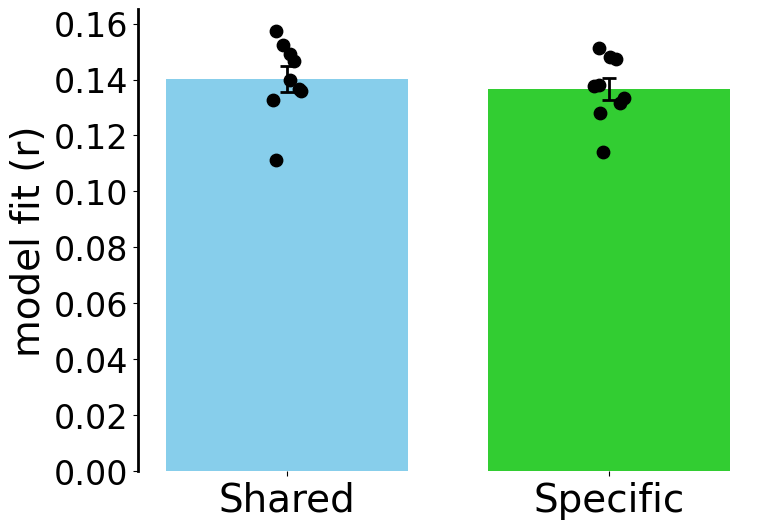

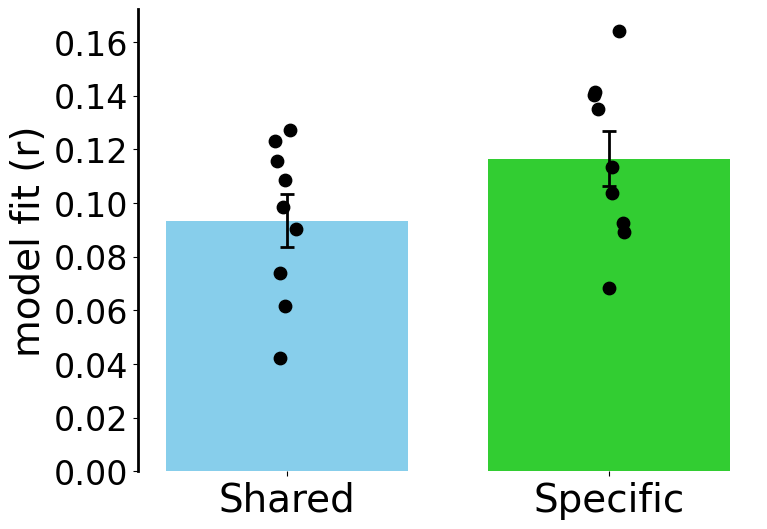

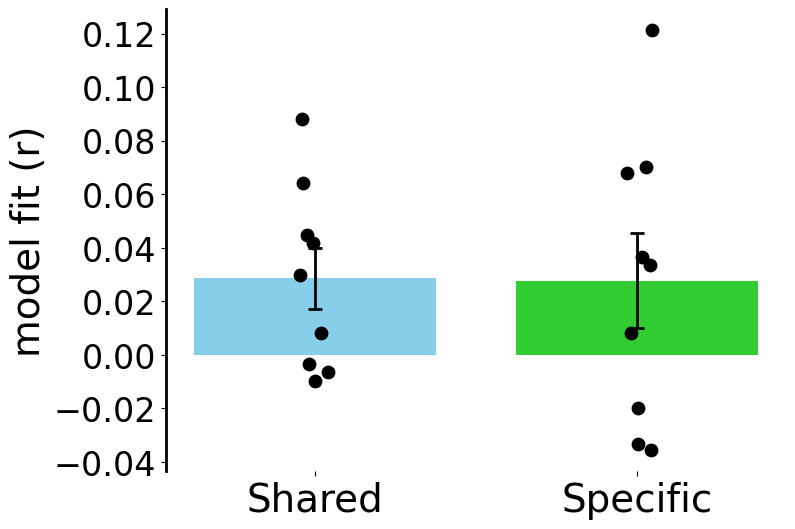

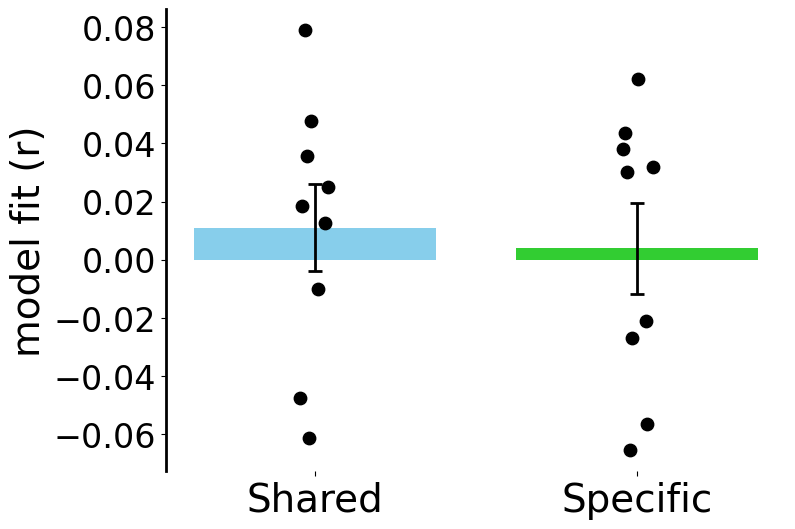

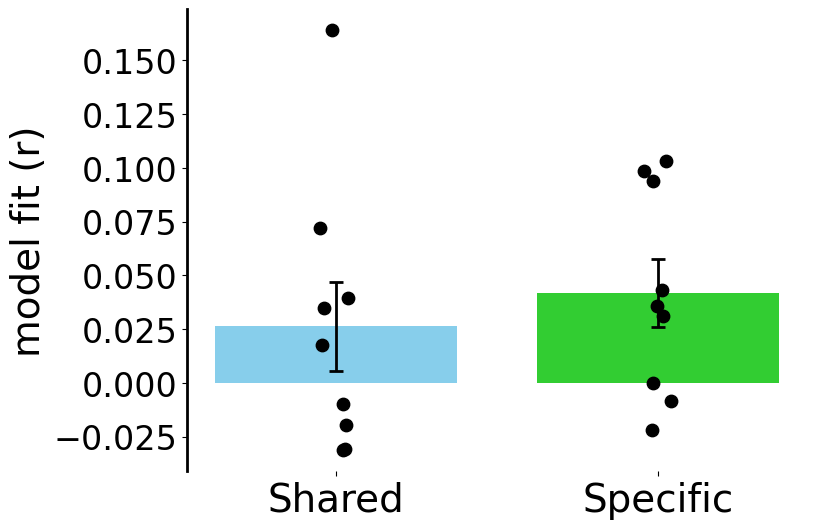

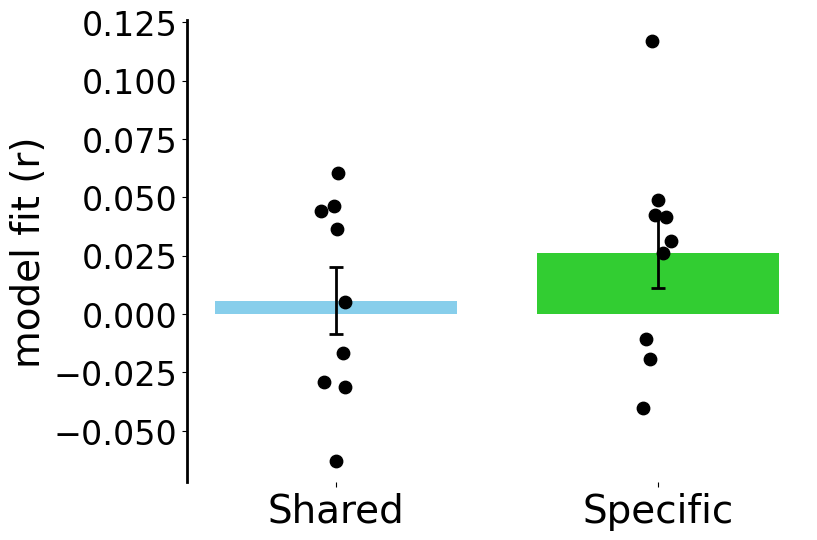

In [ ]:
ylim_1 = {
    'ADOS Total': [0.0, 0.13],
    'ADOS Social': [-0.08, 0.08],
    'DSM IV': [-0.07, 0.13],
    'FIQ': [0.0, 0.18],
    'Age': [-0.06, 0.1],
    'Sex': [0.0, 0.15]
}
plot_1 = create_rsa_bar_plots_flexible_big(rsa_without_classifier_autism, rsa_salient_without_classifier_autism, bar_colors = ['skyblue', 'limegreen'], show_title = False)

In [51]:
test_rsa_results(rsa_salient_without_classifier_autism)
print("\n" + "=" * 50 + "\n")
test_rsa_results(rsa_without_classifier_autism)

test_single_1 = test_rsa_results_storing(rsa_salient_without_classifier_autism)
test_single_2 = test_rsa_results_storing(rsa_without_classifier_autism)

The ADOS Total showed Kendall Tau correlations:
Mean correlation: 0.04
Standard Error: 0.02
t-statistic: 2.62, p-value: 0.031, df: 8
The correlations are marginally significant (p < 0.05).

The ADOS Social showed Kendall Tau correlations:
Mean correlation: 0.03
Standard Error: 0.01
t-statistic: 1.71, p-value: 0.125, df: 8
The correlations are not significant (p >= 0.05).

The DSM IV showed Kendall Tau correlations:
Mean correlation: 0.00
Standard Error: 0.01
t-statistic: 0.26, p-value: 0.804, df: 8
The correlations are not significant (p >= 0.05).

The FIQ showed Kendall Tau correlations:
Mean correlation: 0.14
Standard Error: 0.00
t-statistic: 35.29, p-value: 0.000, df: 8
The correlations are highly significant (p < 0.001).

The Age showed Kendall Tau correlations:
Mean correlation: 0.03
Standard Error: 0.02
t-statistic: 1.56, p-value: 0.158, df: 8
The correlations are not significant (p >= 0.05).

The Sex showed Kendall Tau correlations:
Mean correlation: 0.12
Standard Error: 0.01
t-

In [ ]:
compare_rsa_results(rsa_salient_without_classifier_autism, rsa_without_classifier_autism)
test_comparison_1 = compare_rsa_results_storing(rsa_salient_without_classifier_autism, rsa_without_classifier_autism)

Comparison for variable: FIQ
Mean correlation (Dictionary 1): 0.14
Mean correlation (Dictionary 2): 0.14
Difference in mean correlation: -0.00
t-statistic: -0.59, p-value: 0.564, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: Sex
Mean correlation (Dictionary 1): 0.12
Mean correlation (Dictionary 2): 0.09
Difference in mean correlation: 0.02
t-statistic: 1.63, p-value: 0.123, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: Age
Mean correlation (Dictionary 1): 0.03
Mean correlation (Dictionary 2): 0.03
Difference in mean correlation: -0.00
t-statistic: -0.04, p-value: 0.965, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: DSM IV
Mean correlation (Dictionary 1): 0.00
Mean correlation (Dictionary 2): 0.01
Difference in mean correlation: -0.01
t-statistic: -0.33, p-value: 0.749, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: ADOS Total
Mean correlation (Dictionar

In [ ]:
#!pip install cloudpickle
import cloudpickle as pickle
# Save the ANOVA results to a file using pickle
with open('/content/drive/MyDrive/MasterThesisData/results_RSA_1.pkl', 'wb') as file:
    pickle.dump(test_single_1, file)
    pickle.dump(test_single_2, file)
    pickle.dump(test_comparison_1, file)


In [26]:
import cloudpickle as pickle

# Load variables from the pickle file
with open('/content/drive/MyDrive/MasterThesisData/results_RSA_1.pkl', 'rb') as file:
    loaded_test_single_1 = pickle.load(file)
    loaded_test_single_2 = pickle.load(file)
    loaded_test_comparison_1 = pickle.load(file)


And just so it's available, here is the testing of the individual latent vectors of the model with a classifier.

In [52]:
test_rsa_results(rsa_salient_with_classifier_autism)
print("\n" + "=" * 50 + "\n")
test_rsa_results(rsa_with_classifier_autism)

The ADOS Total showed Kendall Tau correlations:
Mean correlation: 0.04
Standard Error: 0.01
t-statistic: 2.62, p-value: 0.031, df: 8
The correlations are marginally significant (p < 0.05).

The ADOS Social showed Kendall Tau correlations:
Mean correlation: -0.00
Standard Error: 0.01
t-statistic: -0.15, p-value: 0.885, df: 8
The correlations are not significant (p >= 0.05).

The DSM IV showed Kendall Tau correlations:
Mean correlation: 0.02
Standard Error: 0.02
t-statistic: 1.23, p-value: 0.254, df: 8
The correlations are not significant (p >= 0.05).

The FIQ showed Kendall Tau correlations:
Mean correlation: 0.14
Standard Error: 0.00
t-statistic: 39.88, p-value: 0.000, df: 8
The correlations are highly significant (p < 0.001).

The Age showed Kendall Tau correlations:
Mean correlation: 0.02
Standard Error: 0.01
t-statistic: 2.38, p-value: 0.044, df: 8
The correlations are marginally significant (p < 0.05).

The Sex showed Kendall Tau correlations:
Mean correlation: 0.10
Standard Error:

### RSA with Classifier

In this section, we will compare the results of the RSA with and without the classifier.

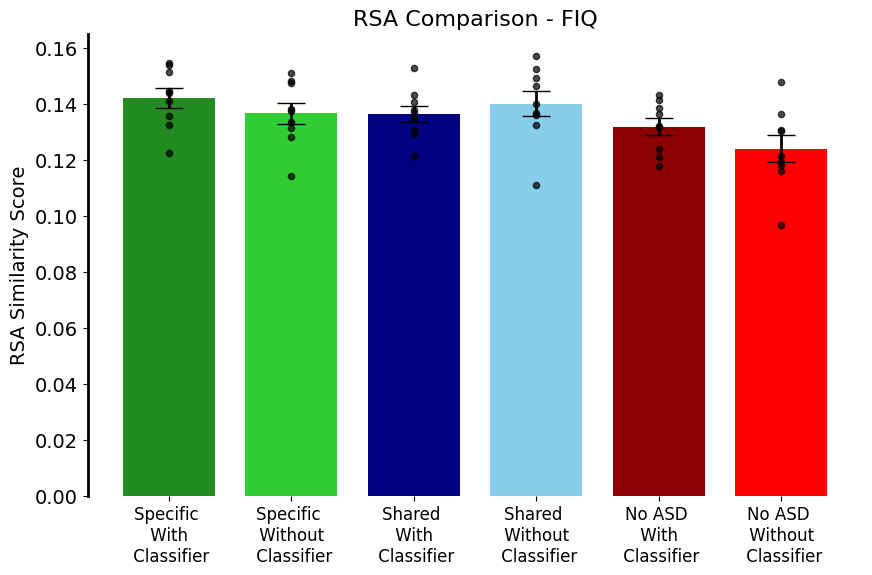

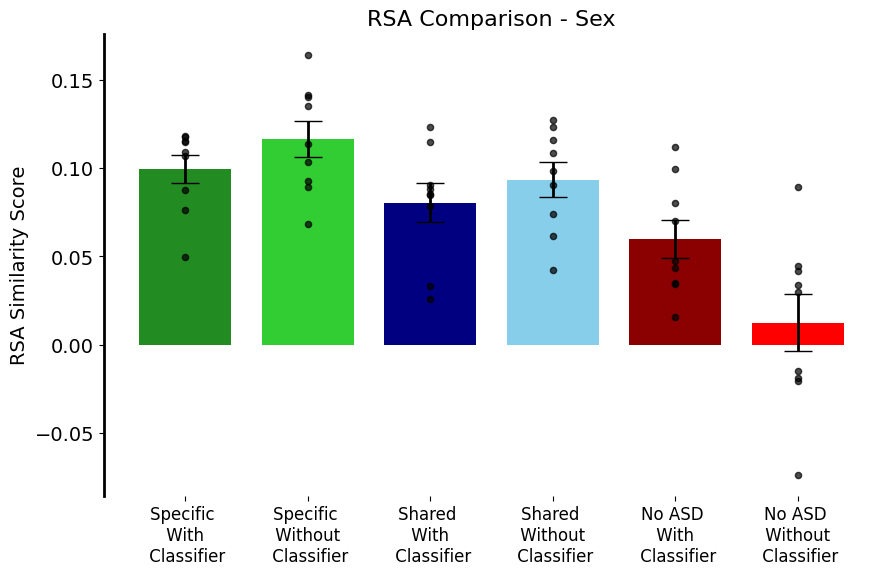

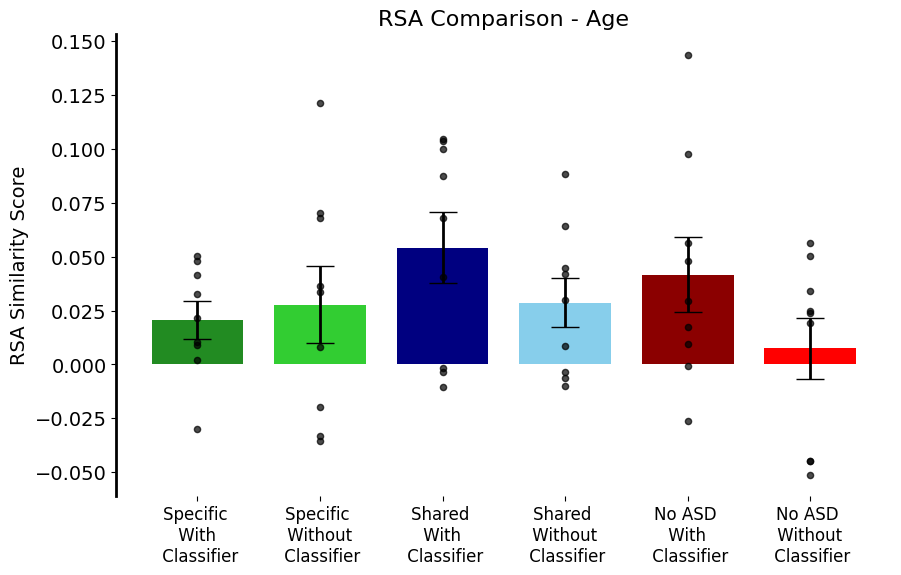

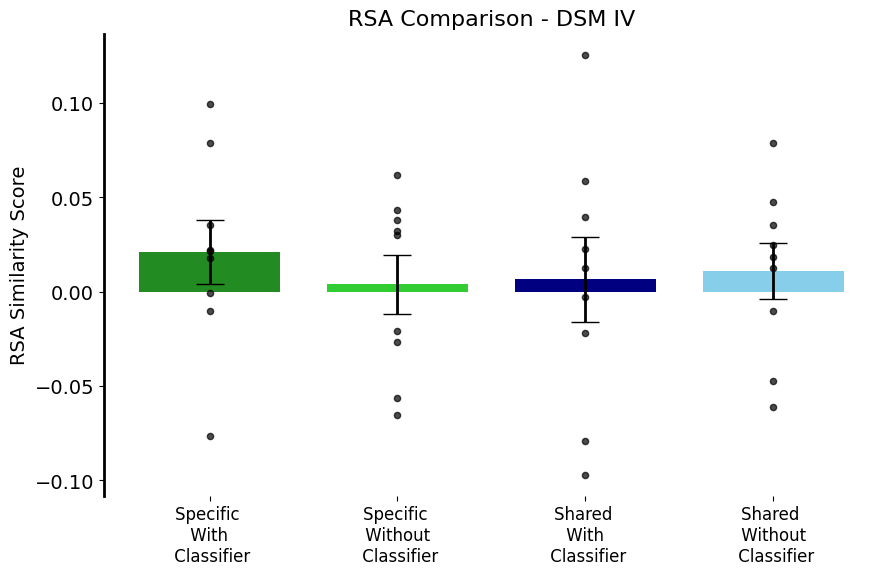

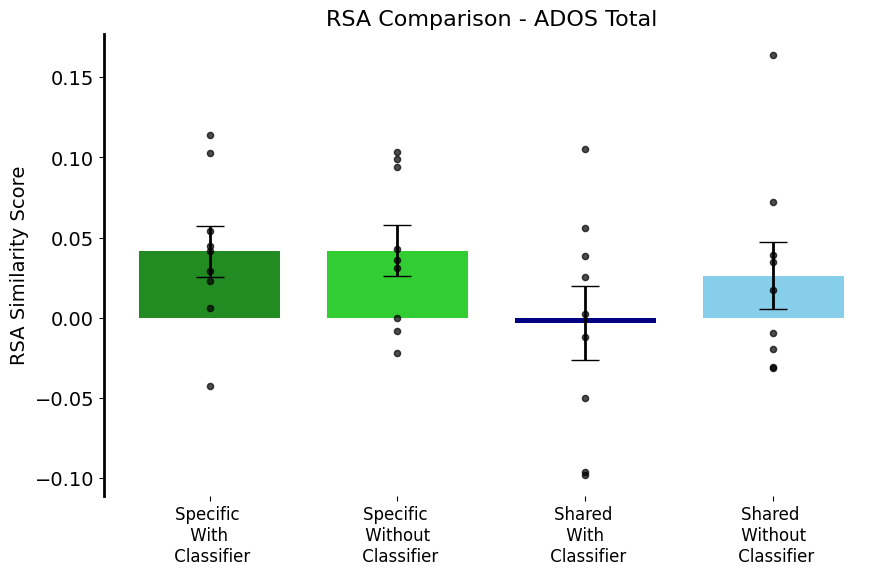

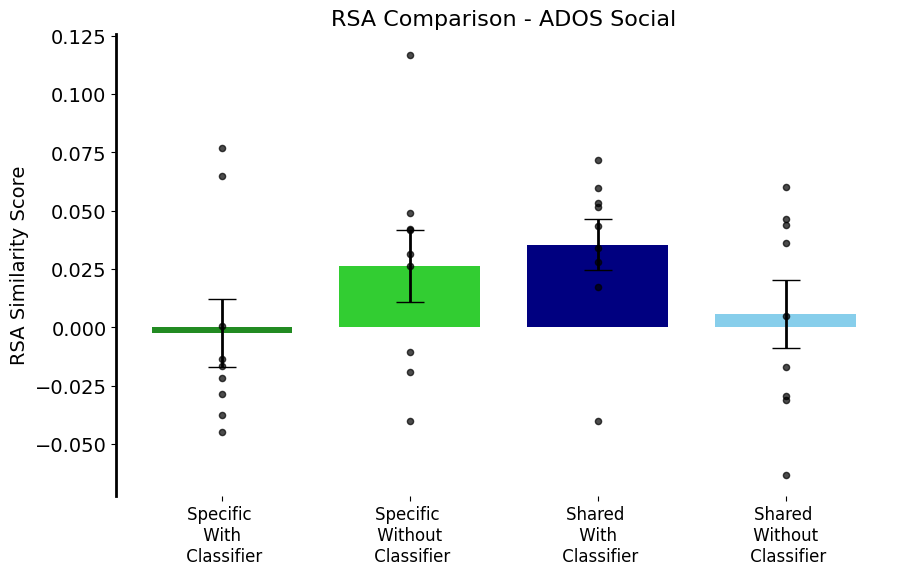

In [ ]:
create_rsa_bar_plots_flexible(rsa_salient_with_classifier_autism, rsa_salient_without_classifier_autism, rsa_with_classifier_autism, rsa_without_classifier_autism, rsa_with_classifier_no_autism,rsa_without_classifier_no_autism, bar_colors = [ "forestgreen", "limegreen", "navy", "skyblue","darkred", "red"])

In [ ]:
compare_rsa_results(rsa_salient_with_classifier_autism, rsa_salient_without_classifier_autism)
print("\n" + "=" * 50 + "\n")
compare_rsa_results(rsa_with_classifier_autism, rsa_without_classifier_autism)
print("\n" + "=" * 50 + "\n")
compare_rsa_results(rsa_with_classifier_no_autism,rsa_without_classifier_no_autism)

Comparison for variable: FIQ
Mean correlation (Dictionary 1): 0.14
Mean correlation (Dictionary 2): 0.14
Difference in mean correlation: 0.01
t-statistic: 1.07, p-value: 0.302, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: Sex
Mean correlation (Dictionary 1): 0.10
Mean correlation (Dictionary 2): 0.12
Difference in mean correlation: -0.02
t-statistic: -1.32, p-value: 0.206, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: Age
Mean correlation (Dictionary 1): 0.02
Mean correlation (Dictionary 2): 0.03
Difference in mean correlation: -0.01
t-statistic: -0.36, p-value: 0.723, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: DSM IV
Mean correlation (Dictionary 1): 0.02
Mean correlation (Dictionary 2): 0.00
Difference in mean correlation: 0.02
t-statistic: 0.73, p-value: 0.476, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: ADOS Total
Mean correlation (Dictionary 

### RSA across spaces

Next, I want to briefly attempt a RSA with the concatenated latent vectors from participant with ASD. Perhaps, the combination of the two latent vectors is what explains variance.

In [29]:
def generate_latent_vectors_concatenated(model_classifier, model_basic, test_dataloader_no_batch):
    # Dictionaries to store latent representations
    latent_with_classifier = {'salient_vector': [], 'participant_ids': [], 'ADOS Total': [], 'ADOS Social': [], 'DSM IV': [], 'FIQ': [], 'Age': [], 'Sex': []}
    latent_without_classifier = {'salient_vector': [], 'participant_ids': [], 'ADOS Total': [], 'ADOS Social': [], 'DSM IV': [], 'FIQ': [], 'Age': [], 'Sex': []}

    # Set models to evaluation mode
    model_classifier.eval()
    model_basic.eval()

    # Create an iterator for the data loader
    no_batch_test_iterator = iter(train_dataloader_no_batch)

    for i in range(1, 10):
        (autism_data, autism_age, autism_FIQ, autism_diag_group, autism_ADOS_TOTAL, autism_gender, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_sub_id), (no_autism_data, no_autism_age, no_autism_FIQ, _,  no_autism_gender, no_autism_sub_id) = batch

        # Move data to device if necessary
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        # Generate latent representations using model with classifier
        (_, _, _, _, _, _, _, _, _, _, z_classifier, s_classifier, _) = model_classifier(autism_data, no_autism_data)

        # Generate latent representations using model without classifier
        (_, _, _, _, _, _, _, _, z, s, _) = model_basic(autism_data, no_autism_data)

        # Append latent vectors to dictionaries along with participant IDs and covariates for autism data with classifier
        latent_with_classifier['salient_vector'].append(torch.cat((z_classifier, s_classifier), dim=1).detach().cpu().numpy())
        latent_with_classifier['participant_ids'].append(autism_sub_id)
        latent_with_classifier['ADOS Total'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
        latent_with_classifier['ADOS Social'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
        latent_with_classifier['DSM IV'].append(autism_DSM_IV_TR.detach().cpu().numpy())
        latent_with_classifier['FIQ'].append(autism_FIQ.detach().cpu().numpy())
        latent_with_classifier['Age'].append(autism_age.detach().cpu().numpy())
        latent_with_classifier['Sex'].append(autism_gender.detach().cpu().numpy())

        # Append latent vectors to dictionaries along with participant IDs and covariates for autism data without classifier
        latent_without_classifier['salient_vector'].append(torch.cat((z, s), dim=1).detach().cpu().numpy())
        latent_without_classifier['participant_ids'].append(autism_sub_id)
        latent_without_classifier['ADOS Total'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
        latent_without_classifier['ADOS Social'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
        latent_without_classifier['DSM IV'].append(autism_DSM_IV_TR.detach().cpu().numpy())
        latent_without_classifier['FIQ'].append(autism_FIQ.detach().cpu().numpy())
        latent_without_classifier['Age'].append(autism_age.detach().cpu().numpy())
        latent_without_classifier['Sex'].append(autism_gender.detach().cpu().numpy())

    rsa_with_classifier =  rsa_dict_without_missing_values(latent_with_classifier)
    rsa_without_classifier =  rsa_dict_without_missing_values(latent_without_classifier)
    return rsa_with_classifier, rsa_without_classifier

rsa_with_classifier, rsa_without_classifier = generate_latent_vectors_concatenated(model_classifier, model_basic, test_dataloader_no_batch)



In [31]:
# Specify the file path
file_path = '/content/drive/MyDrive/MasterThesisData/results_RSA_2.pkl'

# Save the objects to the file
with open(file_path, 'wb') as file:
    pickle.dump(rsa_with_classifier, file)
    pickle.dump(rsa_without_classifier, file)

In [ ]:
import cloudpickle as pickle

# Specify the file path
file_path = '/content/drive/MyDrive/MasterThesisData/results_RSA_2.pkl'

# Load the objects from the file
with open(file_path, 'rb') as file:
    rsa_with_classifier = pickle.load(file)
    rsa_without_classifier = pickle.load(file)


Firstly, lets test the RSA when both vectors are combined

In [34]:
test_rsa_results(rsa_with_classifier)
print("\n" + "=" * 50 + "\n")
test_rsa_results(rsa_without_classifier)

The ADOS Total showed Kendall Tau correlations:
Mean correlation: 0.04
Standard Error: 0.02
t-statistic: 2.11, p-value: 0.068, df: 8
The correlations are not significant (p >= 0.05).

The ADOS Social showed Kendall Tau correlations:
Mean correlation: 0.04
Standard Error: 0.01
t-statistic: 2.90, p-value: 0.020, df: 8
The correlations are marginally significant (p < 0.05).

The DSM IV showed Kendall Tau correlations:
Mean correlation: 0.00
Standard Error: 0.02
t-statistic: 0.03, p-value: 0.975, df: 8
The correlations are not significant (p >= 0.05).

The FIQ showed Kendall Tau correlations:
Mean correlation: 0.14
Standard Error: 0.00
t-statistic: 35.05, p-value: 0.000, df: 8
The correlations are highly significant (p < 0.001).

The Age showed Kendall Tau correlations:
Mean correlation: 0.08
Standard Error: 0.02
t-statistic: 4.32, p-value: 0.003, df: 8
The correlations are significant (p < 0.01).

The Sex showed Kendall Tau correlations:
Mean correlation: 0.10
Standard Error: 0.01
t-stati

In [ ]:
compare_rsa_results(rsa_with_classifier, rsa_without_classifier)

Comparison for variable: FIQ
Mean correlation (Dictionary 1): 0.14
Mean correlation (Dictionary 2): 0.14
Difference in mean correlation: -0.00
t-statistic: -0.67, p-value: 0.512, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: Sex
Mean correlation (Dictionary 1): 0.09
Mean correlation (Dictionary 2): 0.09
Difference in mean correlation: -0.00
t-statistic: -0.30, p-value: 0.768, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: Age
Mean correlation (Dictionary 1): 0.04
Mean correlation (Dictionary 2): 0.04
Difference in mean correlation: 0.01
t-statistic: 0.27, p-value: 0.793, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: DSM IV
Mean correlation (Dictionary 1): 0.01
Mean correlation (Dictionary 2): 0.02
Difference in mean correlation: -0.00
t-statistic: -0.06, p-value: 0.953, df: 16
The difference is not significant (p >= 0.05).

Comparison for variable: ADOS Total
Mean correlation (Dictionar

#### RSA in the Training Sample

In [ ]:
rsa_salient_with_classifier_training, rsa_with_classifier_training, rsa_with_classifier_no_autism_training, rsa_salient_without_classifier_training, rsa_without_classifier_training, rsa_without_classifier_no_autism_training = generate_latent_vectors(model_classifier, model_basic, train_dataloader_no_batch)

print("Testing Model without Classifier:")
print("\nSalient Vector:\n")
test_rsa_results(rsa_salient_without_classifier_training)
print("\nShared Vector:\n")
test_rsa_results(rsa_without_classifier_training)
print("\nComparison\n")
compare_rsa_results(rsa_salient_without_classifier_training, rsa_without_classifier_training)
print("=" * 50)

print("\nModel With Classifier:\n")
print("\nSalient Vector\n")
compare_rsa_results(rsa_salient_with_classifier_training, rsa_salient_without_classifier_training)
print("\nShared\n")
compare_rsa_results(rsa_with_classifier_training, rsa_without_classifier_training)
print("\nNo Autism\n")
compare_rsa_results(rsa_with_classifier_no_autism_training, rsa_without_classifier_no_autism_training)
print("=" * 50)

print("\nCombined Vector Comparison\n")
rsa_with_classifier_training, rsa_without_classifier_training = generate_latent_vectors_concatenated(model_classifier, model_basic, train_dataloader_no_batch)
compare_rsa_results(rsa_with_classifier_training, rsa_without_classifier_training)


Testing Model without Classifier:

Salient Vector:

The ADOS Total showed Kendall Tau correlations:
Mean correlation: 0.07
Standard Error: 0.01
t-statistic: 5.48, p-value: 0.001, df: 8
The correlations are highly significant (p < 0.001).

The ADOS Social showed Kendall Tau correlations:
Mean correlation: 0.01
Standard Error: 0.01
t-statistic: 0.95, p-value: 0.369, df: 8
The correlations are not significant (p >= 0.05).

The DSM IV showed Kendall Tau correlations:
Mean correlation: 0.02
Standard Error: 0.03
t-statistic: 0.50, p-value: 0.629, df: 8
The correlations are not significant (p >= 0.05).

The FIQ showed Kendall Tau correlations:
Mean correlation: 0.15
Standard Error: 0.00
t-statistic: 53.32, p-value: 0.000, df: 8
The correlations are highly significant (p < 0.001).

The Age showed Kendall Tau correlations:
Mean correlation: 0.03
Standard Error: 0.01
t-statistic: 2.67, p-value: 0.028, df: 8
The correlations are marginally significant (p < 0.05).

The Sex showed Kendall Tau corre

### t-SNE Analyses

Next, I want to look at the latent representaitons and if we see any clustering according to gender, or if the classifier leads to a change in the latent space in relation to age.

**ASD latent vectors**

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch

import torch

def standardize_data(data):
    # Compute the mean and standard deviation for each dimension
    dimension_means = data.mean(dim=0)
    dimension_stddevs = data.std(dim=0)

    # Standardize using dimension-wise statistics
    standardized_data = (data - dimension_means) / dimension_stddevs

    return standardized_data

def get_batch_for_tsne(model_classifier, model_basic, dataloader, device):
    model_classifier.eval()
    model_basic.eval()

    # Create an iterator for the data loader
    batch_iterator = iter(dataloader)

    # Get a single batch (sample)
    sample_batch = next(batch_iterator)

    (autism_data, autism_age, autism_FIQ, autism_diag_group, autism_ADOS_TOTAL, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_gender, autism_sub_id), (no_autism_data, no_autism_age, no_autism_FIQ, no_autism_diag_group, no_autism_gender, no_autism_sub_id) = sample_batch

    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    (_, _, _, _, _, _, _, _, _, _, z_classifier, s_classifier, _) = model_classifier(autism_data, no_autism_data)
    (_, _, _, _, _, _, _, _, z, s, _) = model_basic(autism_data, no_autism_data)

    # Standardize tensors
    z_tensors = standardize_data(z)
    s_tensors = standardize_data(s)
    z_tensors_classifier = standardize_data(z_classifier)
    s_tensors_classifier = standardize_data(s_classifier)

    z_list = z_tensors.split(1, dim=0)  # Split tensors by batch dimension
    s_list = s_tensors.split(1, dim=0)
    s_classifier_list = s_tensors_classifier.split(1, dim=0)
    z_classifier_list = z_tensors_classifier.split(1, dim=0)

    z_labels = ["z"] * len(z_list)
    s_labels = ["s"] * len(s_list)

    # Create dictionaries with z, s, age, gender, ADOS scores, and FIQ
    z_dict = {
        "latent_vec_classifier": torch.cat(z_classifier_list, dim=0),
        "latent_vec": torch.cat(z_list, dim=0),
        "age": autism_age,
        "gender": autism_gender,
        "ADOS_Total": autism_ADOS_TOTAL,
        "ADOS_Social": autism_ADOS_SOCIAL,
        "FIQ": autism_FIQ,
        "label": z_labels
    }

    s_dict = {
        "latent_vec_classifier": torch.cat(s_classifier_list, dim=0),
        "latent_vec": torch.cat(s_list, dim=0),
        "age": autism_age,
        "gender": autism_gender,
        "ADOS_Total": autism_ADOS_TOTAL,
        "ADOS_Social": autism_ADOS_SOCIAL,
        "FIQ": autism_FIQ,
        "label": s_labels
    }

    return z_dict, s_dict




# Define a function to perform linear regression
def perform_regression(tsne_results, covariate, subplot_title):
    # Split the data into training and testing sets

    # Initialize and fit a linear regression model
    regression_model = LinearRegression()
    regression_model.fit(tsne_results, covariate)

    # Predict the age on the test set
    y_pred = regression_model.predict(tsne_results)

    # Calculate mean squared error and R-squared
    mse = mean_squared_error(covariate, y_pred)
    r2 = r2_score(covariate, y_pred)

    print(f"Regression results for {subplot_title}:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print("\n")

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import t


def perform_regression_comparison(X1, X2, y, title1, title2):
    """
    Perform model comparison by comparing the R-squared values of two linear regression models.

    Parameters:
        X1 (numpy.ndarray): Input data for the first model.
        X2 (numpy.ndarray): Input data for the second model.
        y (numpy.ndarray): Target variable.
        title1 (str): Title for the first model.
        title2 (str): Title for the second model.
    """
    # Fit linear regression models
    model1 = LinearRegression()
    model1.fit(X1, y)
    y_pred1 = model1.predict(X1)
    r2_1 = r2_score(y, y_pred1)

    model2 = LinearRegression()
    model2.fit(X2, y)
    y_pred2 = model2.predict(X2)
    r2_2 = r2_score(y, y_pred2)

    # Perform paired t-test to check for significant difference
    t_statistic, p_value = stats.ttest_rel(y - y_pred1, y - y_pred2)

    print(f"{title1} R-squared: {r2_1:.4f}")
    print(f"{title2} R-squared: {r2_2:.4f}")
    print(f"P-value for difference: {p_value:.4f}")

    if p_value < 0.05:
        print(f"The difference in R-squared values is statistically significant.")
        if r2_1 > r2_2:
            print(f"{title1} is superior to {title2}.")
        else:
            print(f"{title2} is superior to {title1}.")
    else:
        print(f"The difference in R-squared values is not statistically significant.")

    return r2_1, r2_2, p_value


Here I am starting by inspecting if the latent vectors themselves group.

[[ 7.7595478e-01 -6.6745317e-01  4.4442827e-01 ...  2.0340655e+00
   5.7626915e-01  3.2093182e-01]
 [-6.3649380e-01 -8.0850236e-02 -1.2024266e+00 ... -5.1169044e-01
   5.8139946e-02  3.6470982e-01]
 [ 2.5640592e-01  3.3584461e-02 -1.0155090e+00 ... -7.7499473e-01
   6.1638498e-01 -7.6570600e-01]
 ...
 [-1.3082798e+00 -1.9567916e-01  1.0476121e+00 ...  4.6561426e-01
   1.5169259e+00 -1.2301043e+00]
 [ 9.7714430e-03  1.9214747e+00 -2.1788893e+00 ... -5.5683690e-01
  -6.8751556e-01  1.1586370e-01]
 [ 7.9115146e-01 -4.3393666e-05  7.4085605e-01 ...  1.0650700e-01
   9.9714822e-01  1.3256009e+00]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


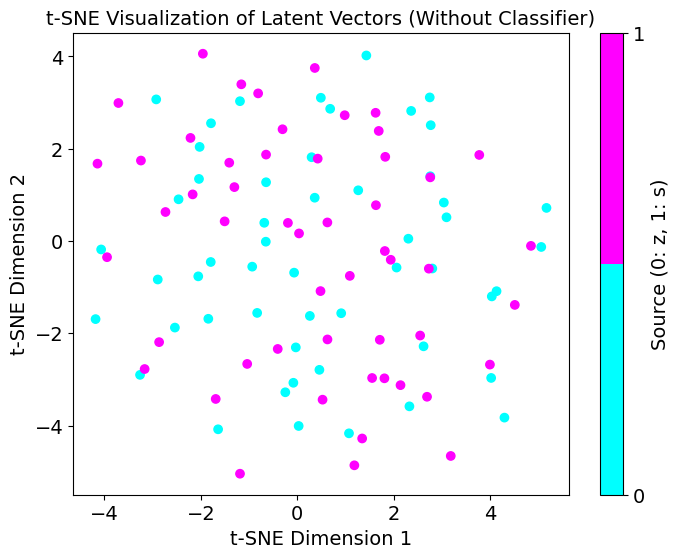


Accuracy of the logistic regression model (t-SNE without classifier): 0.51

Model Evaluation
Logistic Regression Model (t-SNE without classifier) Evaluation:
Accuracy: 0.51
Classification Report:
               precision    recall  f1-score   support

           z       0.51      0.52      0.51        52
           s       0.51      0.50      0.50        52

    accuracy                           0.51       104
   macro avg       0.51      0.51      0.51       104
weighted avg       0.51      0.51      0.51       104

Confusion Matrix:
 [[27 25]
 [26 26]] 



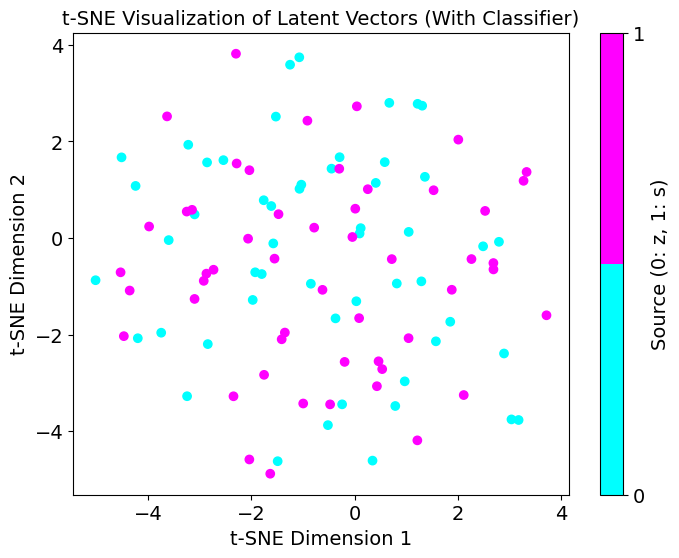


Accuracy of the logistic regression model (t-SNE with classifier): 0.55

Model Evaluation

Logistic Regression Model (t-SNE with classifier) Evaluation:
Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           z       0.55      0.54      0.54        52
           s       0.55      0.56      0.55        52

    accuracy                           0.55       104
   macro avg       0.55      0.55      0.55       104
weighted avg       0.55      0.55      0.55       104

Confusion Matrix:
 [[28 24]
 [23 29]]


In [44]:
z_dict, s_dict = get_batch_for_tsne(model_classifier, model_basic, test_dataloader_no_batch, device)

# Get t-SNE results and perform logistic regression without the classifier
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
z_labels = np.zeros(len(z_vectors))
s_labels = np.ones(len(s_vectors))
combined_vectors = np.vstack((z_vectors, s_vectors))
combined_labels = np.hstack((z_labels, s_labels))
print(combined_vectors)
print(combined_labels)

tsne_without_classifier = TSNE(n_components=2, random_state=42)
tsne_result_without_classifier = tsne_without_classifier.fit_transform(combined_vectors)

# Create a scatter plot for t-SNE without the classifier
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_without_classifier[:, 0], tsne_result_without_classifier[:, 1], c=combined_labels, cmap=plt.cm.get_cmap("cool", 2))
plt.colorbar(ticks=[0, 1], label="Source (0: z, 1: s)")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Latent Vectors (Without Classifier)')
plt.show()

# Create logistic regression models for t-SNE without the classifier
logistic_model_z_s_without_classifier = LogisticRegression(random_state=42)
logistic_model_z_s_without_classifier.fit(tsne_result_without_classifier, combined_labels)

# Predict the labels on the combined dataset for t-SNE without the classifier
y_pred_without_classifier = logistic_model_z_s_without_classifier.predict(tsne_result_without_classifier)

# Calculate the accuracy of the logistic regression model without the classifier
accuracy_without_classifier = accuracy_score(combined_labels, y_pred_without_classifier)
print("\n"+ f"Accuracy of the logistic regression model (t-SNE without classifier): {accuracy_without_classifier:.2f}")


print("\n" + "Model Evaluation")
# Evaluate the logistic regression model without the classifier
y_true_without_classifier = combined_labels
classification_report_without_classifier = classification_report(y_true_without_classifier, y_pred_without_classifier, target_names=["z", "s"])
confusion_matrix_without_classifier = confusion_matrix(y_true_without_classifier, y_pred_without_classifier)

print("Logistic Regression Model (t-SNE without classifier) Evaluation:")
print(f"Accuracy: {accuracy_without_classifier:.2f}")
print("Classification Report:\n", classification_report_without_classifier)
print("Confusion Matrix:\n", confusion_matrix_without_classifier, "\n")

# Get t-SNE results and perform logistic regression with the classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
z_labels_classifier = np.zeros(len(z_vectors_classifier))
s_labels_classifier = np.ones(len(s_vectors_classifier))
combined_vectors_classifier = np.vstack((z_vectors_classifier, s_vectors_classifier))
combined_labels_classifier = combined_labels

tsne_with_classifier = TSNE(n_components=2, random_state=42)
tsne_result_with_classifier = tsne_with_classifier.fit_transform(combined_vectors_classifier)

# Create a scatter plot for t-SNE with the classifier
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_with_classifier[:, 0], tsne_result_with_classifier[:, 1], c=combined_labels_classifier, cmap=plt.cm.get_cmap("cool", 2))
plt.colorbar(ticks=[0, 1], label="Source (0: z, 1: s)")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Latent Vectors (With Classifier)')
plt.show()
# Assuming you have two dictionaries: z_dict and s_dict
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()

# Create labels to indicate the source (0 for z, 1 for s)
z_labels = np.zeros(len(z_vectors))
s_labels = np.ones(len(s_vectors))

# Create logistic regression models for t-SNE with the classifier
logistic_model_with_classifier = LogisticRegression(random_state=42)
logistic_model_with_classifier.fit(tsne_result_with_classifier, combined_labels_classifier)

# Predict the labels on the combined dataset for t-SNE with the classifier
y_pred_with_classifier = logistic_model_with_classifier.predict(tsne_result_with_classifier)

# Calculate the accuracy of the logistic regression model with the classifier
accuracy_with_classifier = accuracy_score(combined_labels_classifier, y_pred_with_classifier)
print("\n"+ f"Accuracy of the logistic regression model (t-SNE with classifier): {accuracy_with_classifier:.2f}")


print("\n" + "Model Evaluation")
# Evaluate the logistic regression model with the classifier
y_true_with_classifier = combined_labels_classifier
classification_report_with_classifier = classification_report(y_true_with_classifier, y_pred_with_classifier, target_names=["z", "s"])
confusion_matrix_with_classifier = confusion_matrix(y_true_with_classifier, y_pred_with_classifier)

print("\nLogistic Regression Model (t-SNE with classifier) Evaluation:")
print(f"Accuracy: {accuracy_with_classifier:.2f}")
print("Classification Report:\n", classification_report_with_classifier)
print("Confusion Matrix:\n", confusion_matrix_with_classifier)


Age


=== t-SNE Visualization of Latent Vectors Grouped by Age ===

[[ 0.7759548  -0.66745317  0.44442827 ... -1.0068973  -0.8359248
  -1.3538216 ]
 [-0.6364938  -0.08085024 -1.2024266  ... -0.8416402   1.555256
   0.8207199 ]
 [ 0.25640592  0.03358446 -1.015509   ... -1.2710681   0.23009384
  -0.6054575 ]
 ...
 [ 1.196803   -0.15064466 -1.568229   ...  0.46561426  1.5169259
  -1.2301043 ]
 [-1.9965664   0.9970662  -1.0110298  ... -0.5568369  -0.68751556
   0.1158637 ]
 [-0.7089201  -2.2094686  -0.9481479  ...  0.106507    0.9971482
   1.3256009 ]]


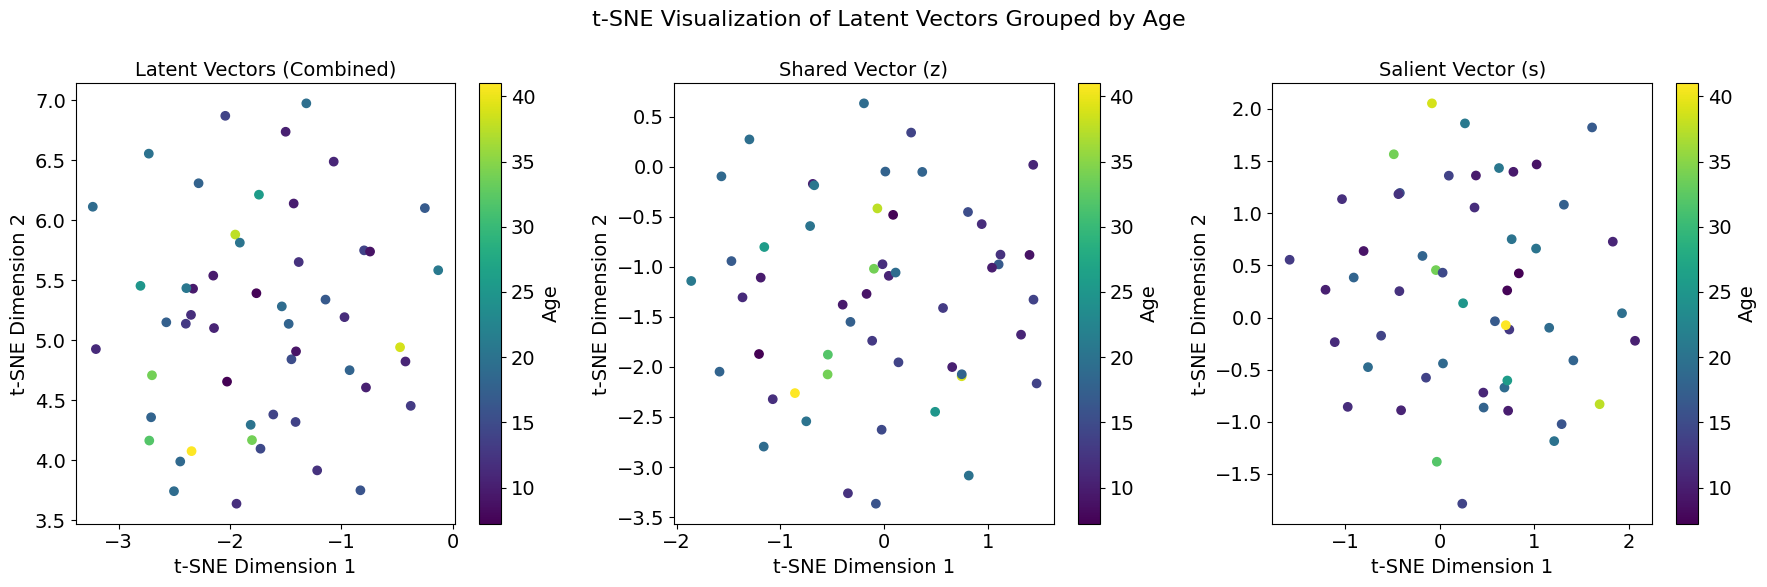

Regression results for Latent Vectors (Combined):
Mean Squared Error: 62.65
R-squared: 0.05


Regression results for Shared Vector (z):
Mean Squared Error: 62.73
R-squared: 0.05


Regression results for Salient Vector (s):
Mean Squared Error: 64.99
R-squared: 0.01




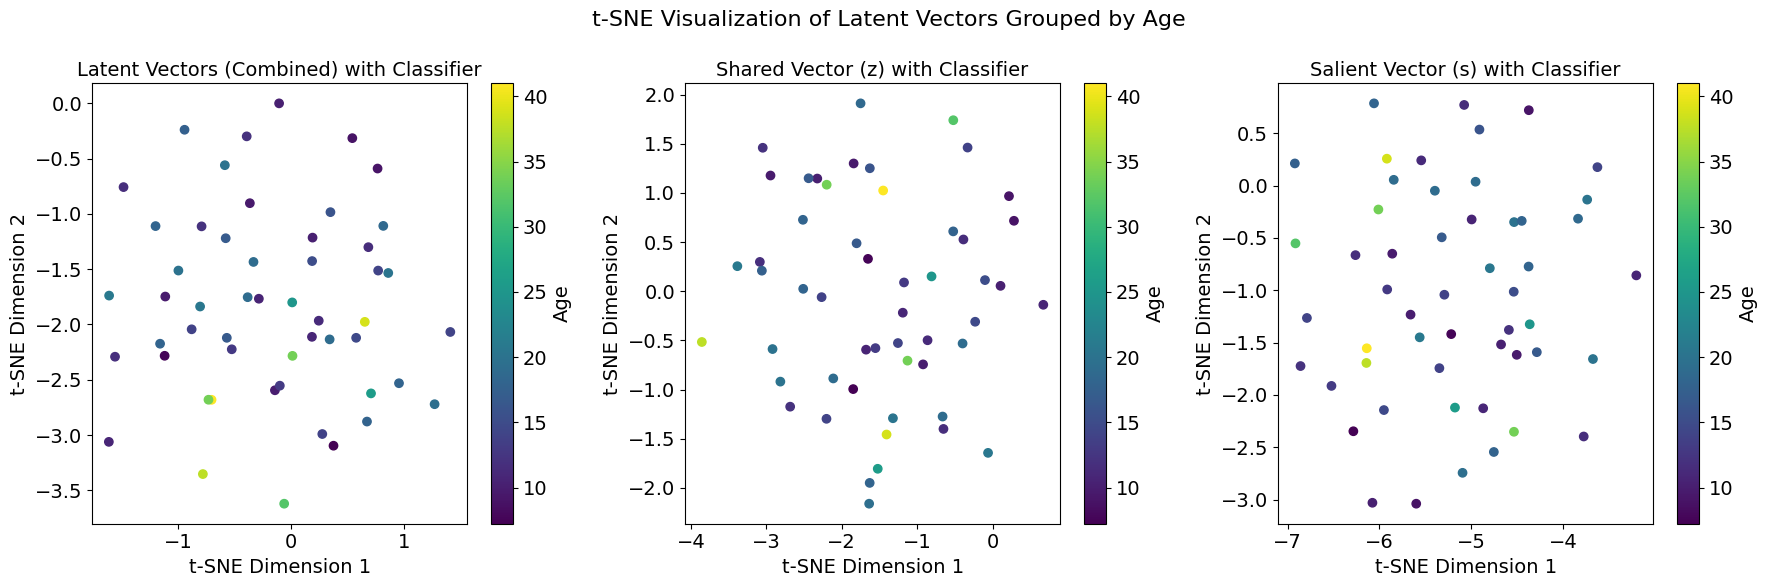

Regression results for Latent Vectors (Combined) with Classifier:
Mean Squared Error: 56.85
R-squared: 0.14


Regression results for Shared Vector (z) with Classifier:
Mean Squared Error: 63.42
R-squared: 0.04


Regression results for Salient Vector (s) with Classifier:
Mean Squared Error: 63.95
R-squared: 0.03



Model Comparison

Latent Vectors (Combined) R-squared: 0.0474
Latent Vectors (Combined) with Classifier R-squared: 0.1355
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Shared Vector (z) R-squared: 0.0460
Shared Vector (z) with Classifier R-squared: 0.0356
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Salient Vector (s) R-squared: 0.0117
Salient Vector (s) with Classifier R-squared: 0.0276
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.


(0.011652256811841677, 0.027551452315071834, 0.9999953031939396)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by Age ===\n")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Age', fontsize=16)

# First subplot: Latent Vectors (z and s combined)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((z_vectors, s_vectors))
print(combined_vectors)
tsne_combined = TSNE(n_components=2, random_state=42)
tsne_result_combined = tsne_combined.fit_transform(combined_vectors)
scatter = axs[0].scatter(tsne_result_combined[:, 0], tsne_result_combined[:, 1], c=z_dict["age"], cmap="viridis")
axs[0].set_title('Latent Vectors (Combined)')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="Age")

# Second subplot: Shared Vectors (z vectors)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
tsne_z = TSNE(n_components=2, random_state=42)
tsne_result_z = tsne_z.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z[:, 0], tsne_result_z[:, 1], c=z_dict["age"], cmap="viridis")
axs[1].set_title('Shared Vector (z)')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="Age")

# Third subplot: Salient Vectors (s vectors)
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
tsne_s = TSNE(n_components=2, random_state=42)
tsne_result_s = tsne_s.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s[:, 0], tsne_result_s[:, 1], c=z_dict["age"], cmap="viridis")
axs[2].set_title('Salient Vector (s)')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="Age")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot
perform_regression(tsne_result_combined, z_dict["age"], "Latent Vectors (Combined)")
perform_regression(tsne_result_z, z_dict["age"], "Shared Vector (z)")
perform_regression(tsne_result_s, z_dict["age"], "Salient Vector (s)")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Age', fontsize=16)

# First subplot: Latent Vectors (z and s combined) with classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
combined_vectors_classifier = np.hstack((z_vectors_classifier, s_vectors_classifier))
tsne_combined_classifier = TSNE(n_components=2, random_state=42)
tsne_result_combined_classifier = tsne_combined_classifier.fit_transform(combined_vectors_classifier)
scatter_combined_classifier = axs[0].scatter(tsne_result_combined_classifier[:, 0], tsne_result_combined_classifier[:, 1], c=z_dict["age"], cmap="viridis")
axs[0].set_title('Latent Vectors (Combined) with Classifier')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_combined_classifier, ax=axs[0], label="Age")

# Second subplot: Shared Vectors (z vectors) with classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
tsne_z_classifier = TSNE(n_components=2, random_state=42)
tsne_result_z_classifier = tsne_z_classifier.fit_transform(z_vectors_classifier)
scatter_z_classifier = axs[1].scatter(tsne_result_z_classifier[:, 0], tsne_result_z_classifier[:, 1], c=z_dict["age"], cmap="viridis")
axs[1].set_title('Shared Vector (z) with Classifier')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z_classifier, ax=axs[1], label="Age")

# Third subplot: Salient Vectors (s vectors) with classifier
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
tsne_s_classifier = TSNE(n_components=2, random_state=42)
tsne_result_s_classifier = tsne_s_classifier.fit_transform(s_vectors_classifier)
scatter_s_classifier = axs[2].scatter(tsne_result_s_classifier[:, 0], tsne_result_s_classifier[:, 1], c=z_dict["age"], cmap="viridis")
axs[2].set_title('Salient Vector (s) with Classifier')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s_classifier, ax=axs[2], label="Age")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_combined_classifier, z_dict["age"], "Latent Vectors (Combined) with Classifier")
perform_regression(tsne_result_z_classifier, z_dict["age"], "Shared Vector (z) with Classifier")
perform_regression(tsne_result_s_classifier, z_dict["age"], "Salient Vector (s) with Classifier")

print("\n" + "Model Comparison" + "\n")
# Usage for comparing the regression results
perform_regression_comparison(tsne_result_combined, tsne_result_combined_classifier, z_dict["age"], "Latent Vectors (Combined)", "Latent Vectors (Combined) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_z, tsne_result_z_classifier, z_dict["age"], "Shared Vector (z)", "Shared Vector (z) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_s, tsne_result_s_classifier, z_dict["age"], "Salient Vector (s)", "Salient Vector (s) with Classifier")


Gender


=== t-SNE Visualization of Latent Vectors Grouped by Sex ===



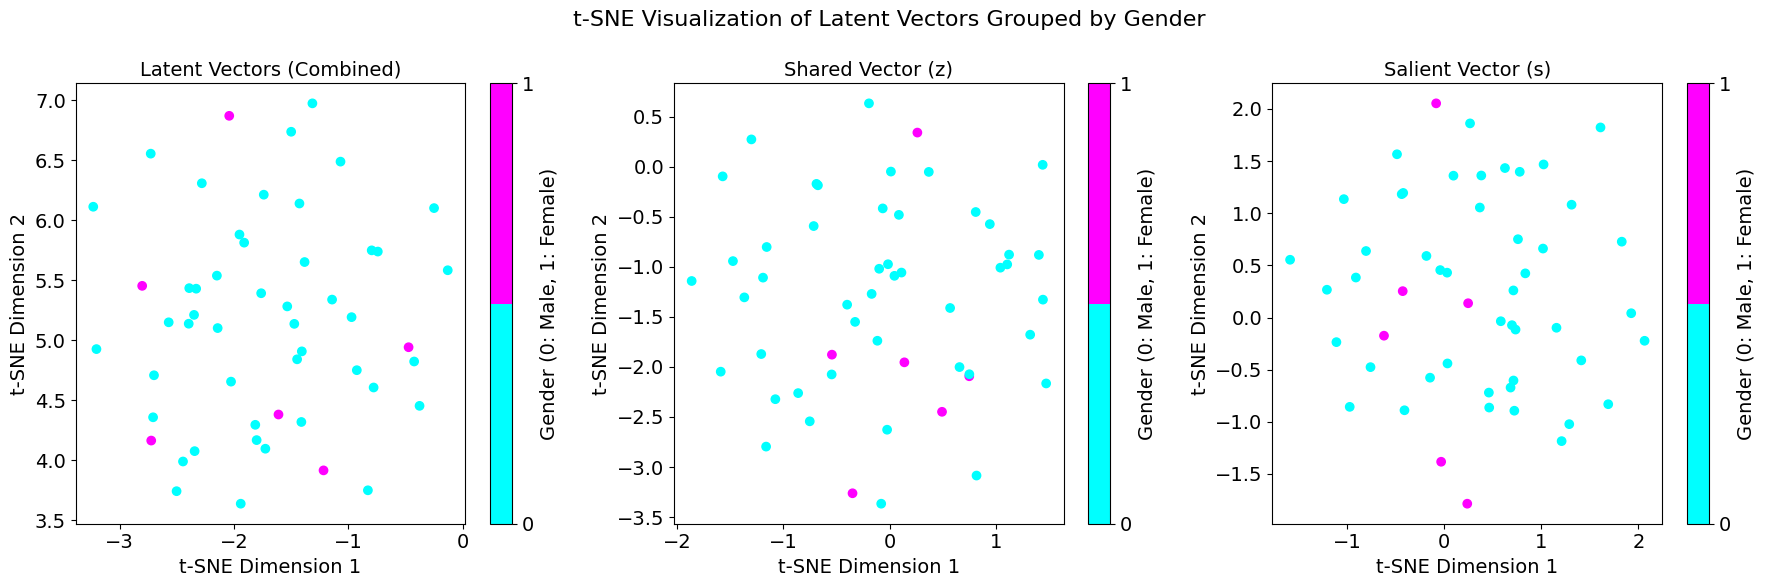

Accuracy of the logistic regression model (t-SNE Combined): 0.88
Accuracy of the logistic regression model (t-SNE Shared Vector): 0.88
Accuracy of the logistic regression model (t-SNE Salient Vector): 0.88


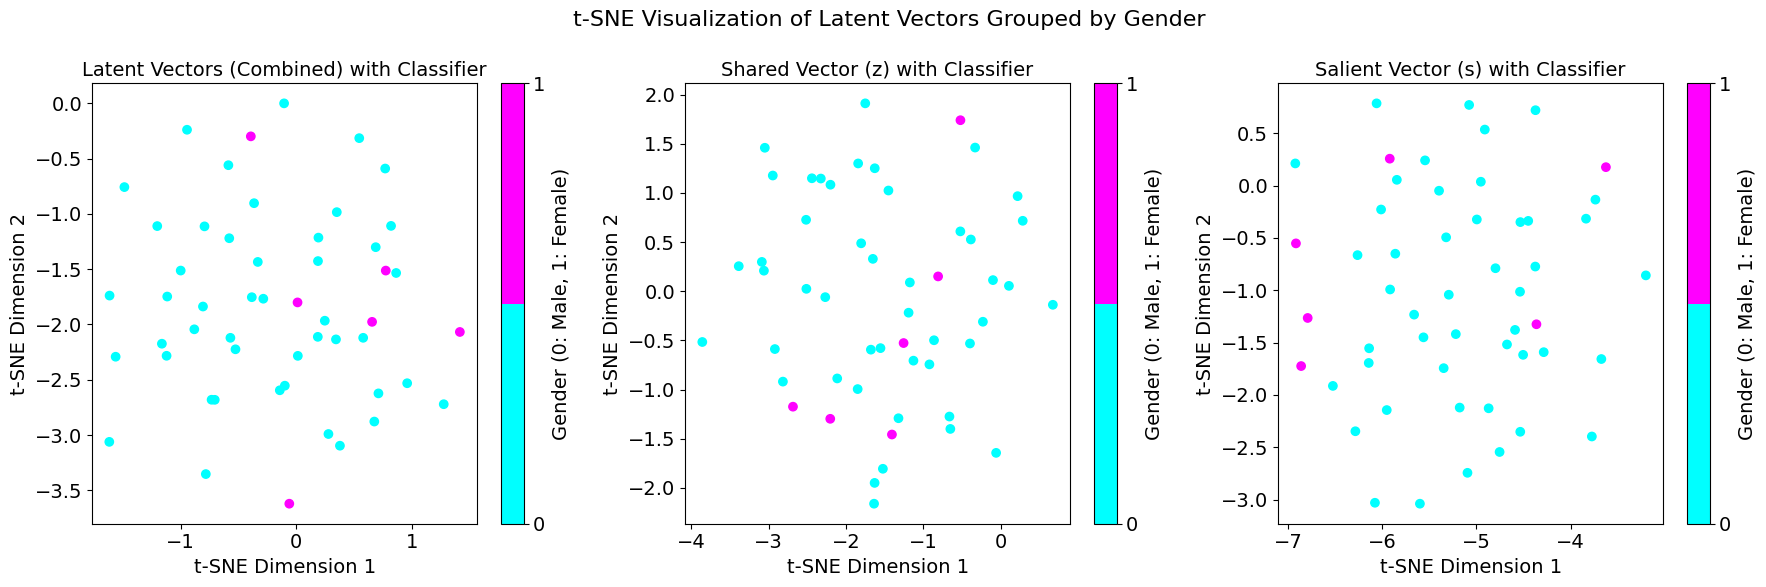

Accuracy of the logistic regression model (t-SNE Combined with Classifier): 0.88
Accuracy of the logistic regression model (t-SNE Shared Vector with Classifier): 0.88
Accuracy of the logistic regression model (t-SNE Salient Vector with Classifier): 0.88


In [46]:
import warnings
warnings.filterwarnings("ignore")


# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by Sex ===\n")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Gender', fontsize=16)

# First subplot: Latent Vectors (z and s combined) without classifier
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((z_vectors, s_vectors))
tsne_combined = TSNE(n_components=2, random_state=42)
tsne_result_combined = tsne_combined.fit_transform(combined_vectors)
cmap = plt.cm.get_cmap("cool", 2)
scatter_combined = axs[0].scatter(tsne_result_combined[:, 0], tsne_result_combined[:, 1], c=z_dict["gender"], cmap=cmap)
axs[0].set_title('Latent Vectors (Combined)')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_combined, ax=axs[0], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Second subplot: Shared Vectors (z vectors) without classifier
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
tsne_z = TSNE(n_components=2, random_state=42)
tsne_result_z = tsne_z.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z[:, 0], tsne_result_z[:, 1], c=z_dict["gender"], cmap=cmap)
axs[1].set_title('Shared Vector (z)')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Third subplot: Salient Vectors (s vectors) without classifier
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
tsne_s = TSNE(n_components=2, random_state=42)
tsne_result_s = tsne_s.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s[:, 0], tsne_result_s[:, 1], c=z_dict["gender"], cmap=cmap)
axs[2].set_title('Salient Vector (s)')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

plt.tight_layout()
plt.show()

# Perform logistic regression for each subplot without classifier
logistic_model_combined = LogisticRegression(random_state=42)
logistic_model_combined.fit(tsne_result_combined, z_dict["gender"])
y_pred_combined = logistic_model_combined.predict(tsne_result_combined)
accuracy_combined = accuracy_score(z_dict["gender"], y_pred_combined)
print(f"Accuracy of the logistic regression model (t-SNE Combined): {accuracy_combined:.2f}")

logistic_model_z = LogisticRegression(random_state=42)
logistic_model_z.fit(tsne_result_z, z_dict["gender"])
y_pred_z = logistic_model_z.predict(tsne_result_z)
accuracy_z = accuracy_score(z_dict["gender"], y_pred_z)
print(f"Accuracy of the logistic regression model (t-SNE Shared Vector): {accuracy_z:.2f}")

logistic_model_s = LogisticRegression(random_state=42)
logistic_model_s.fit(tsne_result_s, z_dict["gender"])
y_pred_s = logistic_model_s.predict(tsne_result_s)
accuracy_s = accuracy_score(z_dict["gender"], y_pred_s)
print(f"Accuracy of the logistic regression model (t-SNE Salient Vector): {accuracy_s:.2f}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Gender', fontsize=16)

# First subplot: Latent Vectors (z and s combined) with classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
combined_vectors_classifier = np.hstack((z_vectors_classifier, s_vectors_classifier))
tsne_combined_classifier = TSNE(n_components=2, random_state=42)
tsne_result_combined_classifier = tsne_combined_classifier.fit_transform(combined_vectors_classifier)
cmap = plt.cm.get_cmap("cool", 2)
scatter_combined_classifier = axs[0].scatter(tsne_result_combined_classifier[:, 0], tsne_result_combined_classifier[:, 1], c=z_dict["gender"], cmap=cmap)
axs[0].set_title('Latent Vectors (Combined) with Classifier')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_combined_classifier, ax=axs[0], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Second subplot: Shared Vectors (z vectors) with classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
tsne_z_classifier = TSNE(n_components=2, random_state=42)
tsne_result_z_classifier = tsne_z_classifier.fit_transform(z_vectors_classifier)
scatter_z_classifier = axs[1].scatter(tsne_result_z_classifier[:, 0], tsne_result_z_classifier[:, 1], c=z_dict["gender"], cmap=cmap)
axs[1].set_title('Shared Vector (z) with Classifier')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z_classifier, ax=axs[1], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Third subplot: Salient Vectors (s vectors) with classifier
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
tsne_s_classifier = TSNE(n_components=2, random_state=42)
tsne_result_s_classifier = tsne_s_classifier.fit_transform(s_vectors_classifier)
scatter_s_classifier = axs[2].scatter(tsne_result_s_classifier[:, 0], tsne_result_s_classifier[:, 1], c=z_dict["gender"], cmap=cmap)
axs[2].set_title('Salient Vector (s) with Classifier')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s_classifier, ax=axs[2], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

plt.tight_layout()
plt.show()

# Perform logistic regression for each subplot with classifier
logistic_model_combined_classifier = LogisticRegression(random_state=42)
logistic_model_combined_classifier.fit(tsne_result_combined_classifier, z_dict["gender"])
y_pred_combined_classifier = logistic_model_combined_classifier.predict(tsne_result_combined_classifier)
accuracy_combined_classifier = accuracy_score(z_dict["gender"], y_pred_combined_classifier)
print(f"Accuracy of the logistic regression model (t-SNE Combined with Classifier): {accuracy_combined_classifier:.2f}")

logistic_model_z_classifier = LogisticRegression(random_state=42)
logistic_model_z_classifier.fit(tsne_result_z_classifier, z_dict["gender"])
y_pred_z_classifier = logistic_model_z_classifier.predict(tsne_result_z_classifier)
accuracy_z_classifier = accuracy_score(z_dict["gender"], y_pred_z_classifier)
print(f"Accuracy of the logistic regression model (t-SNE Shared Vector with Classifier): {accuracy_z_classifier:.2f}")

logistic_model_s_classifier = LogisticRegression(random_state=42)
logistic_model_s_classifier.fit(tsne_result_s_classifier, z_dict["gender"])
y_pred_s_classifier = logistic_model_s_classifier.predict(tsne_result_s_classifier)
accuracy_s_classifier = accuracy_score(z_dict["gender"], y_pred_s_classifier)
print(f"Accuracy of the logistic regression model (t-SNE Salient Vector with Classifier): {accuracy_s_classifier:.2f}")



Having looked at age and gender, here are the plots for ADOS Total, Social, as well as the FIQ values.


=== t-SNE Visualization of Latent Vectors Grouped by ADOS Total ===



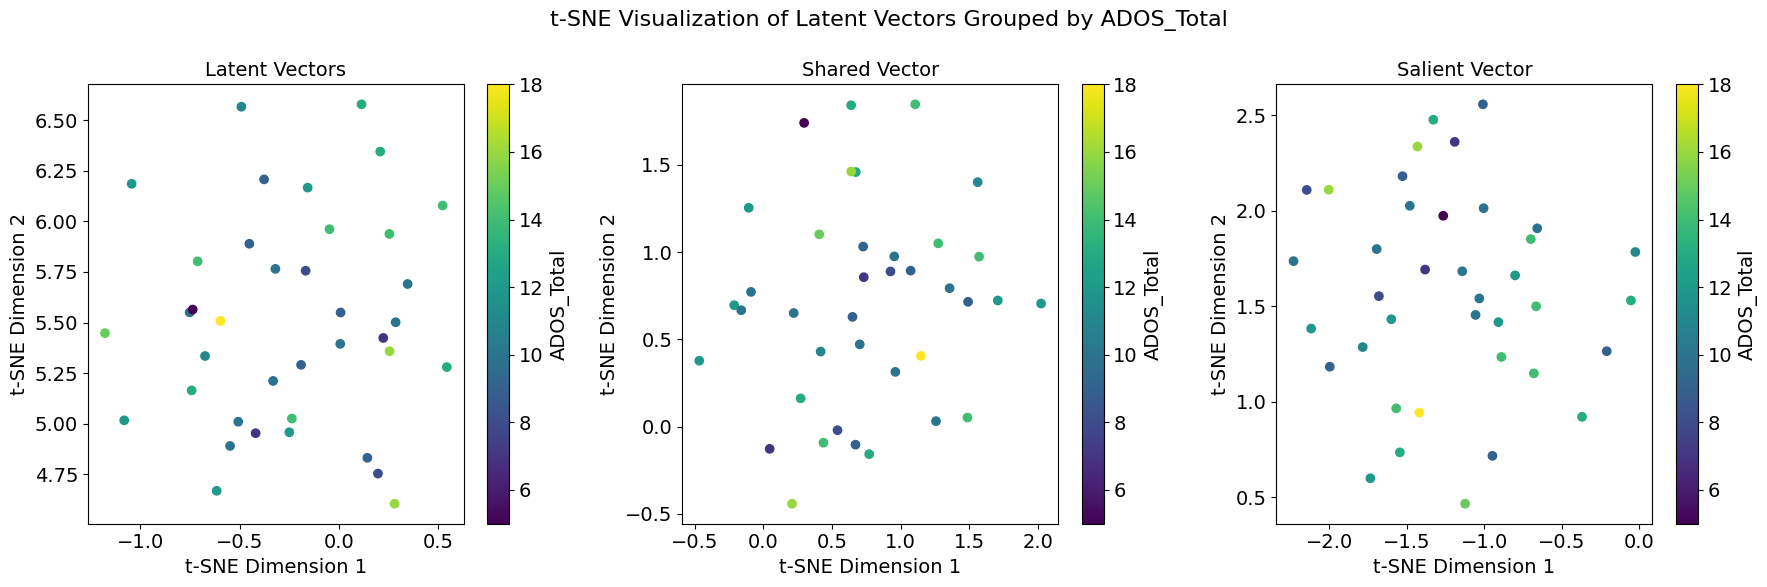

Regression results for Latent Vectors (Combined):
Mean Squared Error: 7.61
R-squared: 0.01


Regression results for Shared Vector (z):
Mean Squared Error: 7.56
R-squared: 0.01


Regression results for Salient Vector (s):
Mean Squared Error: 6.85
R-squared: 0.11




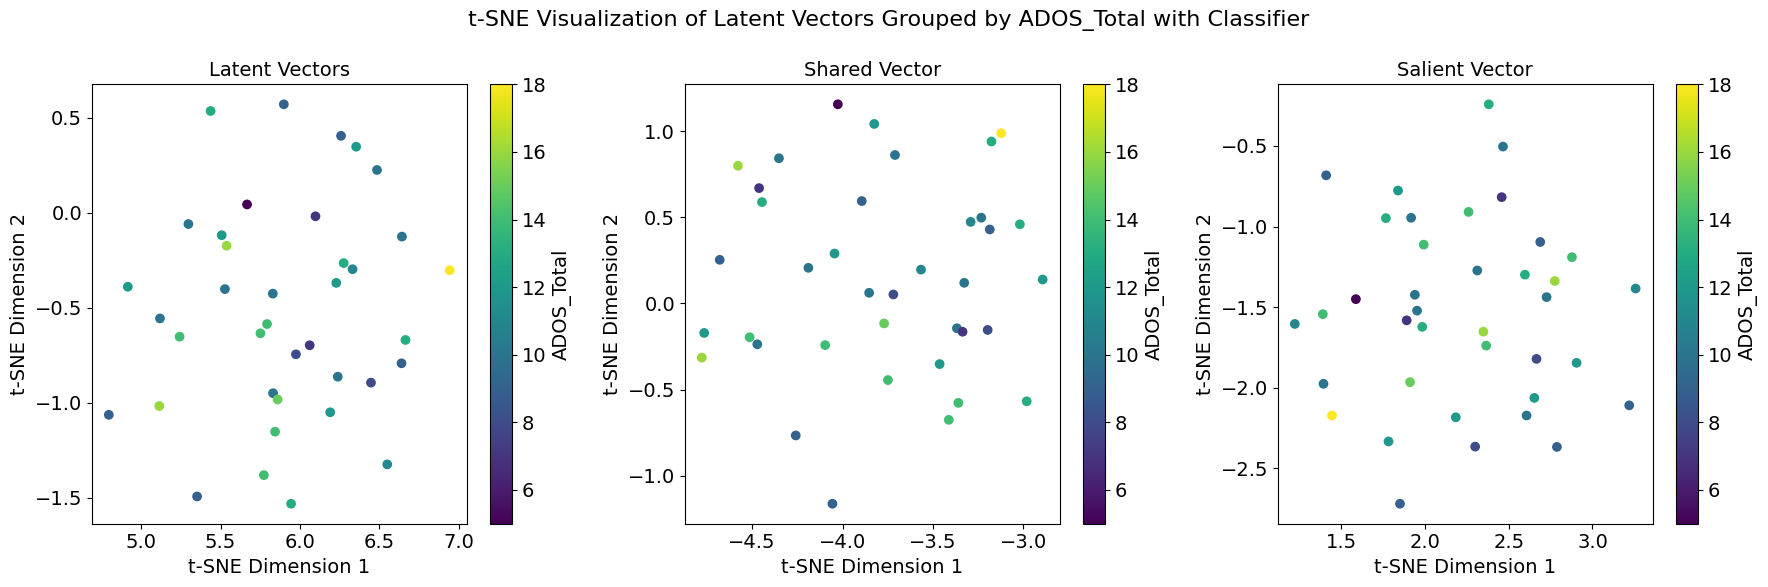

Regression results for Latent Vectors (Combined) with Classifier:
Mean Squared Error: 7.47
R-squared: 0.03


Regression results for Shared Vector (z) with Classifier:
Mean Squared Error: 7.62
R-squared: 0.01


Regression results for Salient Vector (s) with Classifier:
Mean Squared Error: 7.65
R-squared: 0.00



Model Comparison

Latent Vectors (Combined) R-squared: 0.0085
Latent Vectors (Combined) with Classifier R-squared: 0.0273
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Shared Vector (z) R-squared: 0.0150
Shared Vector (z) with Classifier R-squared: 0.0074
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Salient Vector (s) R-squared: 0.1082
Salient Vector (s) with Classifier R-squared: 0.0032
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.


(0.10816411546368543, 0.0032225975327537792, 0.9999997414014377)

In [47]:
import warnings
warnings.filterwarnings("ignore")

# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by ADOS Total ===\n")

# Create subplots for ADOS_TOTAL
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_Total', fontsize=16)

# Filter data for ADOS_TOTAL
indices_to_remove = find_non_numeric_indices(z_dict["ADOS_Total"].tolist())
z_vector_ados_total = z_dict["latent_vec"].detach().cpu().numpy()
s_vector_ados_total = s_dict["latent_vec"].detach().cpu().numpy()
s_vector_ados_total = np.delete(s_vector_ados_total, indices_to_remove, axis=0)
z_vector_ados_total = np.delete(z_vector_ados_total, indices_to_remove, axis=0)

ados_total_covariate = np.delete(z_dict["ADOS_Total"], indices_to_remove, axis=0)

# First subplot: Latent Vectors (z and s combined) for ADOS_TOTAL
combined_vectors_ados_total = np.hstack((z_vector_ados_total, s_vector_ados_total))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_ados_total = tsne.fit_transform(combined_vectors_ados_total)
scatter = axs[0].scatter(tsne_result_ados_total[:, 0], tsne_result_ados_total[:, 1], c=ados_total_covariate , cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_Total")

# Second subplot: Shared Vectors (z vectors) for ADOS_TOTAL
z_vectors = z_vector_ados_total
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_ados_total = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_ados_total[:, 0], tsne_result_z_ados_total[:, 1], c=ados_total_covariate , cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_Total")

# Third subplot: Salient Vectors (s vectors) for ADOS_TOTAL
s_vectors = s_vector_ados_total
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_ados_total = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_ados_total[:, 0], tsne_result_s_ados_total[:, 1], c=ados_total_covariate , cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_Total")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_ados_total, ados_total_covariate, "Latent Vectors (Combined)")
perform_regression(tsne_result_z_ados_total, ados_total_covariate, "Shared Vector (z)")
perform_regression(tsne_result_s_ados_total, ados_total_covariate, "Salient Vector (s)")


# Create subplots for ADOS_TOTAL with classifier
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_Total with Classifier', fontsize=16)

# Filter data for ADOS_TOTAL
indices_to_remove = find_non_numeric_indices(z_dict["ADOS_Total"].tolist())
z_vector_ados_total_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()  # Updated variable name
s_vector_ados_total_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()  # Updated variable name
s_vector_ados_total_classifier = np.delete(s_vector_ados_total_classifier, indices_to_remove, axis=0)
z_vector_ados_total_classifier = np.delete(z_vector_ados_total_classifier, indices_to_remove, axis=0)

ados_total_covariate_classifier = np.delete(z_dict["ADOS_Total"], indices_to_remove, axis=0)  # Updated variable name

# First subplot: Latent Vectors (z and s combined) for ADOS_TOTAL with Classifier
combined_vectors_ados_total_classifier = np.hstack((z_vector_ados_total_classifier, s_vector_ados_total_classifier))
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_ados_total_classifier = tsne_classifier.fit_transform(combined_vectors_ados_total_classifier)
scatter = axs[0].scatter(tsne_result_ados_total_classifier[:, 0], tsne_result_ados_total_classifier[:, 1], c=ados_total_covariate_classifier, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_Total")

# Second subplot: Shared Vectors (z vectors) for ADOS_TOTAL with Classifier
z_vectors_classifier = z_vector_ados_total_classifier
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_z_ados_total_classifier = tsne_classifier.fit_transform(z_vectors_classifier)
scatter_z = axs[1].scatter(tsne_result_z_ados_total_classifier[:, 0], tsne_result_z_ados_total_classifier[:, 1], c=ados_total_covariate_classifier, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_Total")

# Third subplot: Salient Vectors (s vectors) for ADOS_TOTAL with Classifier
s_vectors_classifier = s_vector_ados_total_classifier
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_s_ados_total_classifier = tsne_classifier.fit_transform(s_vectors_classifier)
scatter_s = axs[2].scatter(tsne_result_s_ados_total_classifier[:, 0], tsne_result_s_ados_total_classifier[:, 1], c=ados_total_covariate_classifier, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_Total")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_ados_total_classifier, ados_total_covariate_classifier, "Latent Vectors (Combined) with Classifier")
perform_regression(tsne_result_z_ados_total_classifier, ados_total_covariate_classifier, "Shared Vector (z) with Classifier")
perform_regression(tsne_result_s_ados_total_classifier, ados_total_covariate_classifier, "Salient Vector (s) with Classifier")

print("\nModel Comparison\n")
perform_regression_comparison(tsne_result_ados_total, tsne_result_ados_total_classifier, ados_total_covariate, "Latent Vectors (Combined)", "Latent Vectors (Combined) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_z_ados_total, tsne_result_z_ados_total_classifier, ados_total_covariate, "Shared Vector (z)", "Shared Vector (z) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_s_ados_total, tsne_result_s_ados_total_classifier, ados_total_covariate, "Salient Vector (s)", "Salient Vector (s) with Classifier")




=== t-SNE Visualization of Latent Vectors Grouped by ADOS Social ===



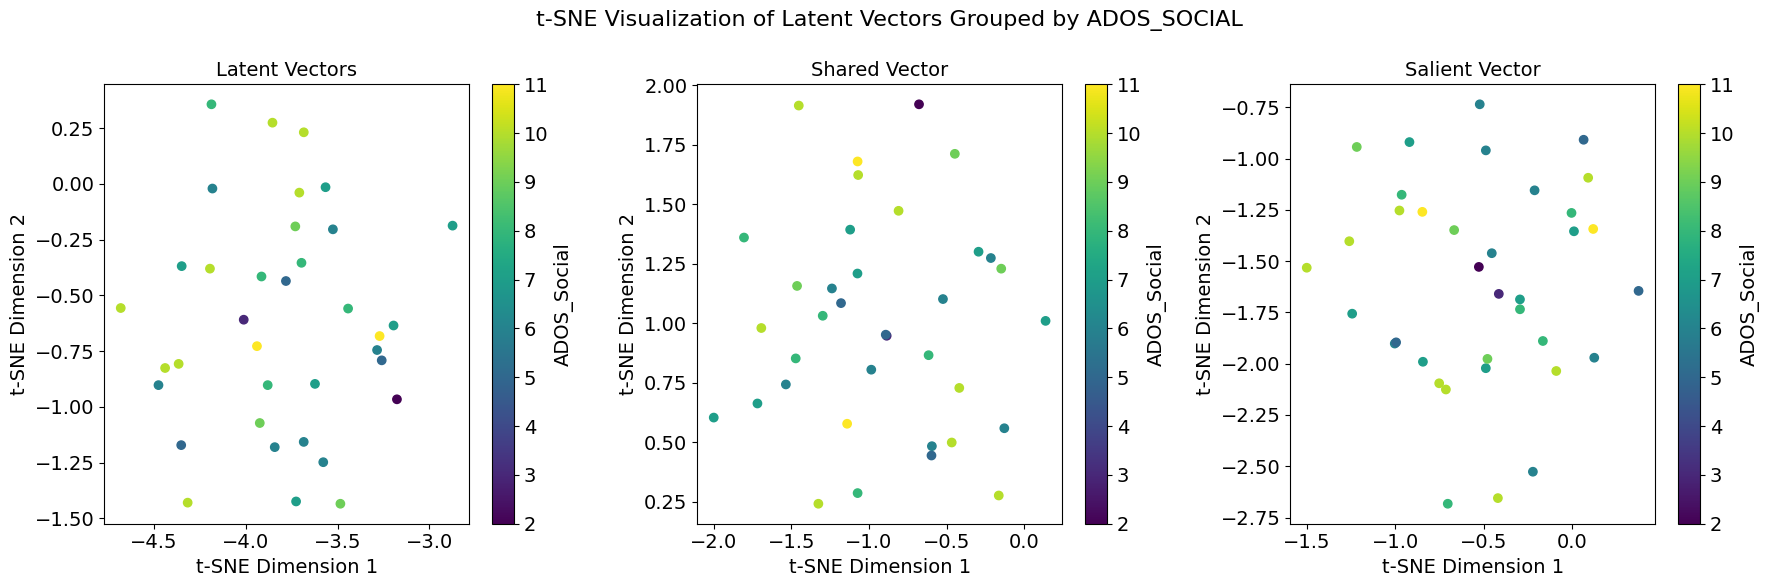

Regression results for Latent Vectors (Combined):
Mean Squared Error: 4.18
R-squared: 0.11


Regression results for Shared Vector (z):
Mean Squared Error: 4.63
R-squared: 0.01


Regression results for Salient Vector (s):
Mean Squared Error: 4.46
R-squared: 0.05




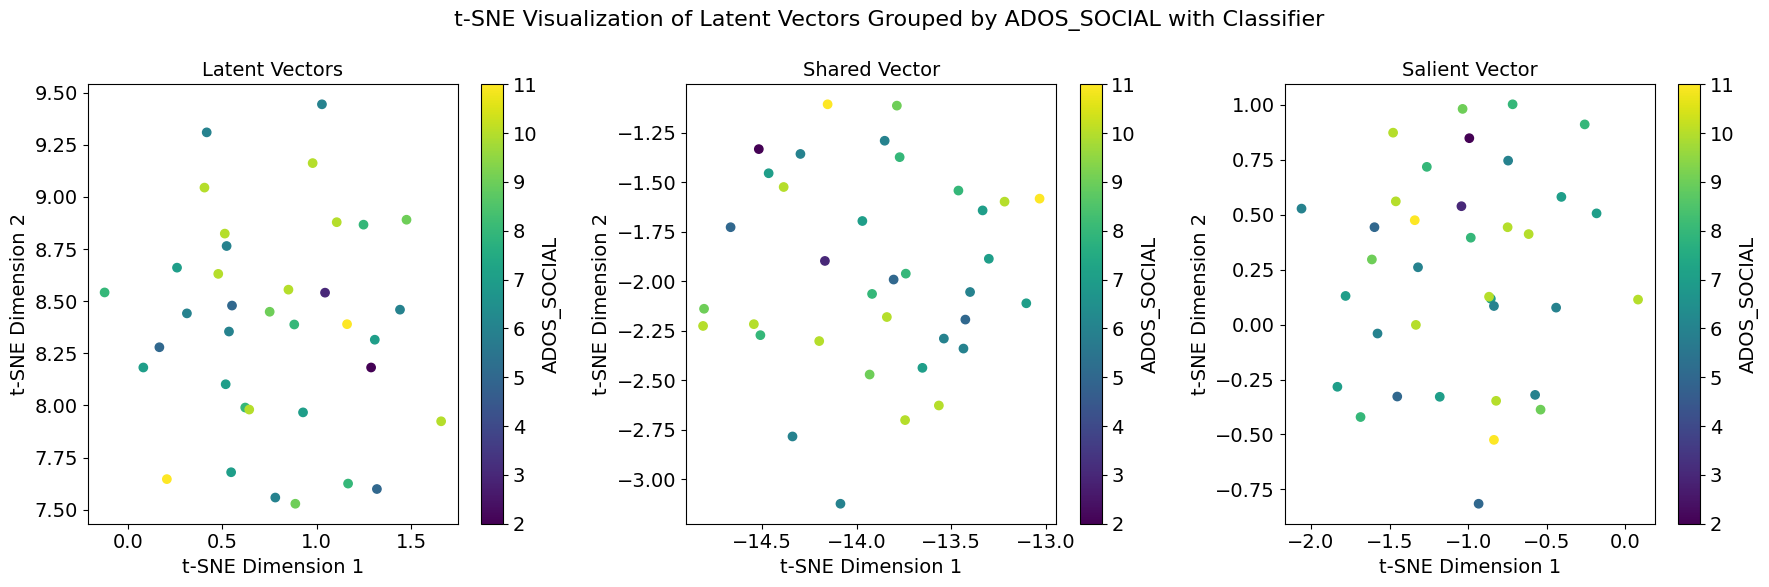

Regression results for Latent Vectors (Combined) with Classifier:
Mean Squared Error: 4.67
R-squared: 0.00


Regression results for Shared Vector (z) with Classifier:
Mean Squared Error: 4.67
R-squared: 0.00


Regression results for Salient Vector (s) with Classifier:
Mean Squared Error: 4.62
R-squared: 0.02



Model Comparison

Latent Vectors (Combined) R-squared: 0.1092
Latent Vectors (Combined) with Classifier R-squared: 0.0036
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Shared Vector (z) R-squared: 0.0120
Shared Vector (z) with Classifier R-squared: 0.0036
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Salient Vector (s) R-squared: 0.0496
Salient Vector (s) with Classifier R-squared: 0.0153
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.


(0.04958014760176355, 0.015262117278433296, 0.9999966672234333)

In [48]:
import warnings
warnings.filterwarnings("ignore")

# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by ADOS Social ===\n")

# Create subplots for ADOS_SOCIAL
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_SOCIAL', fontsize=16)

# Filter data for ADOS_SOCIAL
indices_to_remove = find_non_numeric_indices(z_dict["ADOS_Social"].tolist())
z_vector_ados_social = z_dict["latent_vec"].detach().cpu().numpy()
s_vector_ados_social = s_dict["latent_vec"].detach().cpu().numpy()
s_vector_ados_social = np.delete(s_vector_ados_social, indices_to_remove, axis=0)
z_vector_ados_social = np.delete(z_vector_ados_social, indices_to_remove, axis=0)

ados_social_covariate = np.delete(z_dict["ADOS_Social"], indices_to_remove, axis=0)

# First subplot: Latent Vectors (z and s combined) for ADOS_SOCIAL
combined_vectors_ados_social = np.hstack((z_vector_ados_social, s_vector_ados_social))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_ados_social = tsne.fit_transform(combined_vectors_ados_social)
scatter = axs[0].scatter(tsne_result_ados_social[:, 0], tsne_result_ados_social[:, 1], c=ados_social_covariate, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_Social")

# Second subplot: Shared Vectors (z vectors) for ADOS_SOCIAL
z_vectors = z_vector_ados_social
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_ados_social = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_ados_social[:, 0], tsne_result_z_ados_social[:, 1], c=ados_social_covariate, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_Social")

# Third subplot: Salient Vectors (s vectors) for ADOS_SOCIAL
s_vectors = s_vector_ados_social
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_ados_social = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_ados_social[:, 0], tsne_result_s_ados_social[:, 1], c=ados_social_covariate, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_Social")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_ados_social, ados_social_covariate, "Latent Vectors (Combined)")
perform_regression(tsne_result_z_ados_social, ados_social_covariate, "Shared Vector (z)")
perform_regression(tsne_result_s_ados_social, ados_social_covariate, "Salient Vector (s)")


# Create subplots for ADOS_SOCIAL with classifier
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_SOCIAL with Classifier', fontsize=16)

# Filter data for ADOS_SOCIAL
indices_to_remove = find_non_numeric_indices(z_dict["ADOS_Social"].tolist())
z_vector_ados_social = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vector_ados_social = s_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vector_ados_social = np.delete(s_vector_ados_social, indices_to_remove, axis=0)
z_vector_ados_social = np.delete(z_vector_ados_social, indices_to_remove, axis=0)

# First subplot: Latent Vectors (z and s combined) for ADOS_SOCIAL
combined_vectors_ados_social = np.hstack((z_vector_ados_social, s_vector_ados_social))
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_ados_social_classifier = tsne_classifier.fit_transform(combined_vectors_ados_social)
scatter = axs[0].scatter(tsne_result_ados_social_classifier[:, 0], tsne_result_ados_social_classifier[:, 1], c=ados_social_covariate, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_SOCIAL")

# Second subplot: Shared Vectors (z vectors) for ADOS_SOCIAL
z_vectors = z_vector_ados_social
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_z_ados_social_classifier = tsne_classifier.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_ados_social_classifier[:, 0], tsne_result_z_ados_social_classifier[:, 1], c=ados_social_covariate, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_SOCIAL")

# Third subplot: Salient Vectors (s vectors) for ADOS_SOCIAL
s_vectors = s_vector_ados_social
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_s_ados_social_classifier = tsne_classifier.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_ados_social_classifier[:, 0], tsne_result_s_ados_social_classifier[:, 1], c=ados_social_covariate, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_SOCIAL")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_ados_social_classifier, ados_social_covariate, "Latent Vectors (Combined) with Classifier")
perform_regression(tsne_result_z_ados_social_classifier, ados_social_covariate, "Shared Vector (z) with Classifier")
perform_regression(tsne_result_s_ados_social_classifier, ados_social_covariate, "Salient Vector (s) with Classifier")

print("\nModel Comparison\n")
perform_regression_comparison(tsne_result_ados_social, tsne_result_ados_social_classifier, ados_social_covariate, "Latent Vectors (Combined)", "Latent Vectors (Combined) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_z_ados_social, tsne_result_z_ados_social_classifier, ados_social_covariate, "Shared Vector (z)", "Shared Vector (z) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_s_ados_social, tsne_result_s_ados_social_classifier,ados_social_covariate, "Salient Vector (s)", "Salient Vector (s) with Classifier")

Now to FIQ


=== t-SNE Visualization of Latent Vectors Grouped by FIQ ===



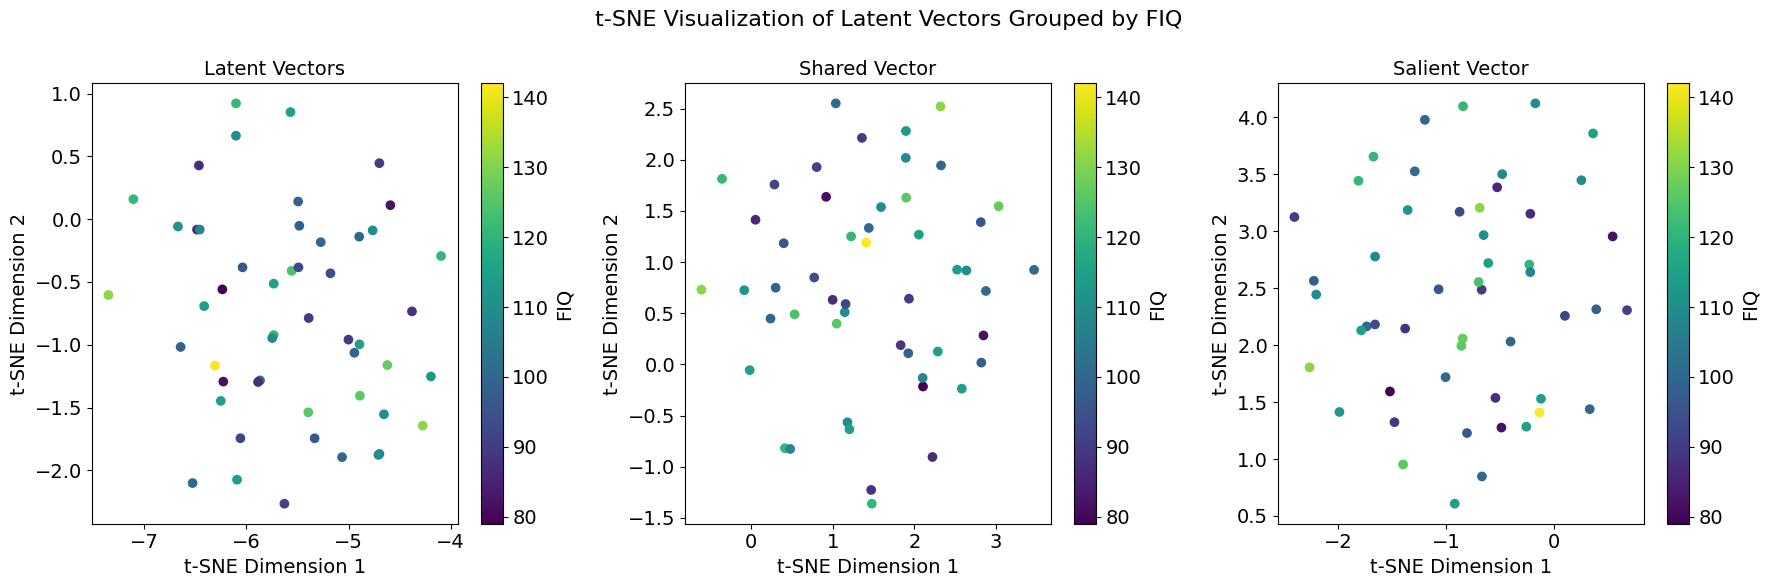


Linear Regression Results for FIQ:
Regression results for Latent Vectors (Combined):
Mean Squared Error: 216.31
R-squared: 0.00


Regression results for Shared Vector (z):
Mean Squared Error: 215.05
R-squared: 0.01


Regression results for Salient Vector (s):
Mean Squared Error: 214.94
R-squared: 0.01



=== t-SNE Visualization of Latent Vectors Grouped by FIQ ===



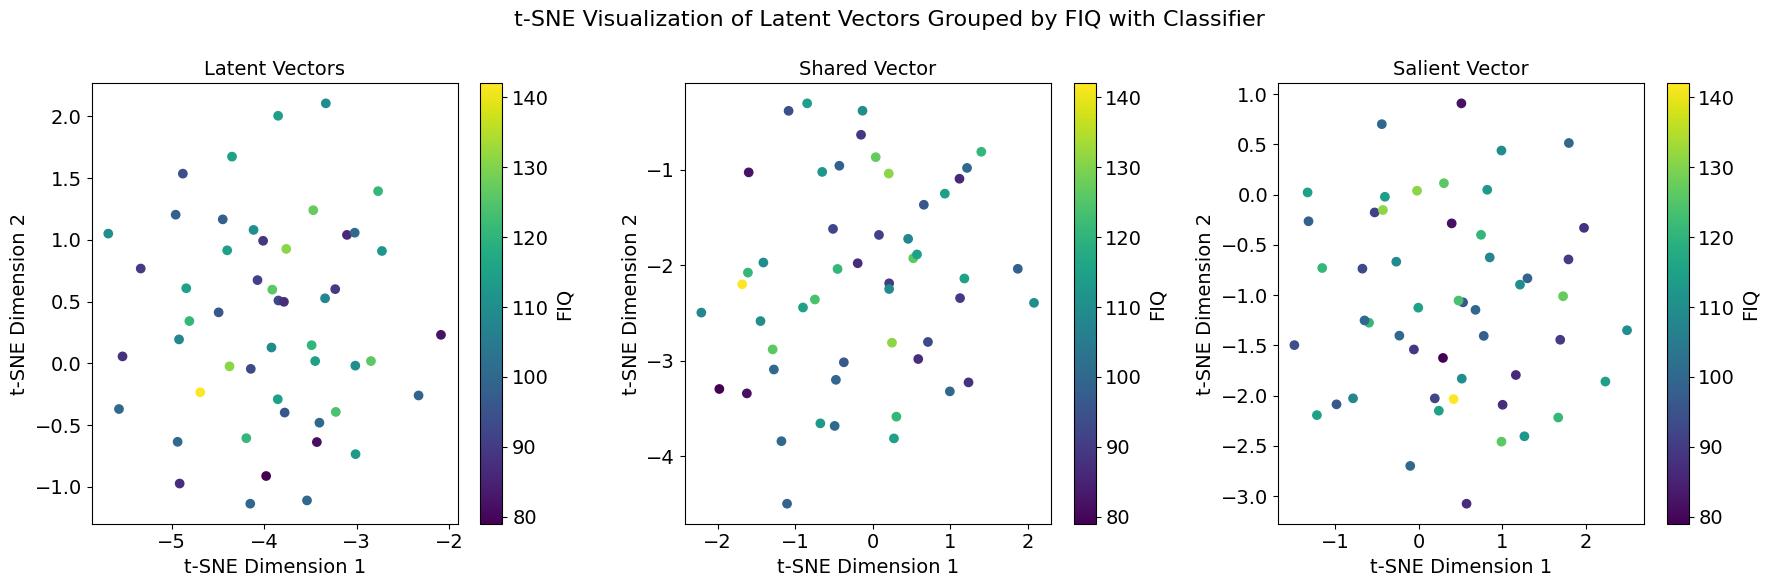


Linear Regression Results for FIQ with Classifier:
Regression results for Latent Vectors (Combined) with Classifier:
Mean Squared Error: 213.02
R-squared: 0.02


Regression results for Shared Vector (z) with Classifier:
Mean Squared Error: 215.53
R-squared: 0.01


Regression results for Salient Vector (s) with Classifier:
Mean Squared Error: 216.95
R-squared: 0.00



Model Comparison

Latent Vectors (Combined) R-squared: 0.0048
Latent Vectors (Combined) with Classifier R-squared: 0.0199
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Shared Vector (z) R-squared: 0.0106
Shared Vector (z) with Classifier R-squared: 0.0084
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Salient Vector (s) R-squared: 0.0111
Salient Vector (s) with Classifier R-squared: 0.0019
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.


(0.011109913632447954, 0.0018623733281418753, 1.0)

In [49]:
import warnings
warnings.filterwarnings("ignore")

# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by FIQ ===\n")

# Filter data for FIQ
indices_to_remove = find_non_numeric_indices(z_dict["FIQ"].tolist())
z_vector_fiq = z_dict["latent_vec"].detach().cpu().numpy()
s_vector_fiq = s_dict["latent_vec"].detach().cpu().numpy()
s_vector_fiq = np.delete(s_vector_fiq, indices_to_remove, axis=0)
z_vector_fiq = np.delete(z_vector_fiq, indices_to_remove, axis=0)

fiq_covariate = np.delete(z_dict["FIQ"], indices_to_remove, axis=0)

# Create subplots for FIQ
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by FIQ', fontsize=16)

# First subplot: Latent Vectors (z and s combined) for FIQ
combined_vectors_fiq = np.hstack((z_vector_fiq, s_vector_fiq))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_fiq = tsne.fit_transform(combined_vectors_fiq)
scatter = axs[0].scatter(tsne_result_fiq[:, 0], tsne_result_fiq[:, 1], c=fiq_covariate, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="FIQ")

# Second subplot: Shared Vectors (z vectors) for FIQ
z_vectors = z_vector_fiq
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_fiq = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_fiq[:, 0], tsne_result_z_fiq[:, 1], c=fiq_covariate, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="FIQ")

# Third subplot: Salient Vectors (s vectors) for FIQ
s_vectors = s_vector_fiq
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_fiq = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_fiq[:, 0], tsne_result_s_fiq[:, 1], c=fiq_covariate, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="FIQ")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot
print("\nLinear Regression Results for FIQ:")
perform_regression(tsne_result_fiq, fiq_covariate, "Latent Vectors (Combined)")
perform_regression(tsne_result_z_fiq, fiq_covariate, "Shared Vector (z)")
perform_regression(tsne_result_s_fiq, fiq_covariate, "Salient Vector (s)")


# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by FIQ ===\n")

# Filter data for FIQ
indices_to_remove = find_non_numeric_indices(z_dict["FIQ"].tolist())
z_vector_fiq = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vector_fiq = s_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vector_fiq = np.delete(s_vector_fiq, indices_to_remove, axis=0)
z_vector_fiq = np.delete(z_vector_fiq, indices_to_remove, axis=0)

fiq_covariate = np.delete(z_dict["FIQ"], indices_to_remove, axis=0)

# Create subplots for FIQ with classifier
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by FIQ with Classifier', fontsize=16)

# First subplot: Latent Vectors (z and s combined) for FIQ with classifier
combined_vectors_fiq = np.hstack((z_vector_fiq, s_vector_fiq))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_fiq_classifier = tsne.fit_transform(combined_vectors_fiq)
scatter = axs[0].scatter(tsne_result_fiq_classifier[:, 0], tsne_result_fiq_classifier[:, 1], c=fiq_covariate, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="FIQ")

# Second subplot: Shared Vectors (z vectors) for FIQ with classifier
z_vectors = z_vector_fiq
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_fiq_classifier = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_fiq_classifier[:, 0], tsne_result_z_fiq_classifier[:, 1], c=fiq_covariate, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="FIQ")

# Third subplot: Salient Vectors (s vectors) for FIQ with classifier
s_vectors = s_vector_fiq
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_fiq_classifier = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_fiq_classifier[:, 0], tsne_result_s_fiq_classifier[:, 1], c=fiq_covariate, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="FIQ")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
print("\nLinear Regression Results for FIQ with Classifier:")
perform_regression(tsne_result_fiq_classifier, fiq_covariate, "Latent Vectors (Combined) with Classifier")
perform_regression(tsne_result_z_fiq_classifier, fiq_covariate, "Shared Vector (z) with Classifier")
perform_regression(tsne_result_s_fiq_classifier, fiq_covariate, "Salient Vector (s) with Classifier")


print("\nModel Comparison\n")
perform_regression_comparison(tsne_result_fiq, tsne_result_fiq_classifier, fiq_covariate, "Latent Vectors (Combined)", "Latent Vectors (Combined) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_z_fiq, tsne_result_z_fiq_classifier, fiq_covariate, "Shared Vector (z)", "Shared Vector (z) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_s_fiq, tsne_result_s_fiq_classifier, fiq_covariate, "Salient Vector (s)", "Salient Vector (s) with Classifier")



Now, I am briefly providing the opportunity to look at this for the training.

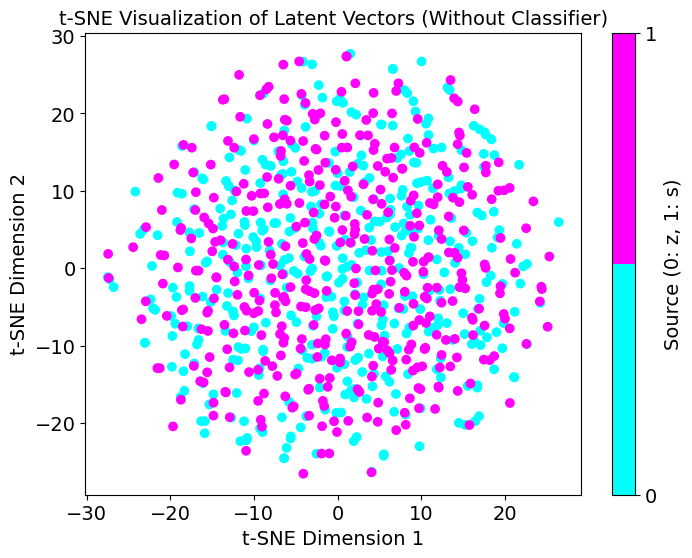


Accuracy of the logistic regression model (t-SNE without classifier): 0.50

Model Evaluation
Logistic Regression Model (t-SNE without classifier) Evaluation:
Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           z       0.50      0.49      0.49       416
           s       0.50      0.52      0.51       416

    accuracy                           0.50       832
   macro avg       0.50      0.50      0.50       832
weighted avg       0.50      0.50      0.50       832

Confusion Matrix:
 [[202 214]
 [200 216]] 



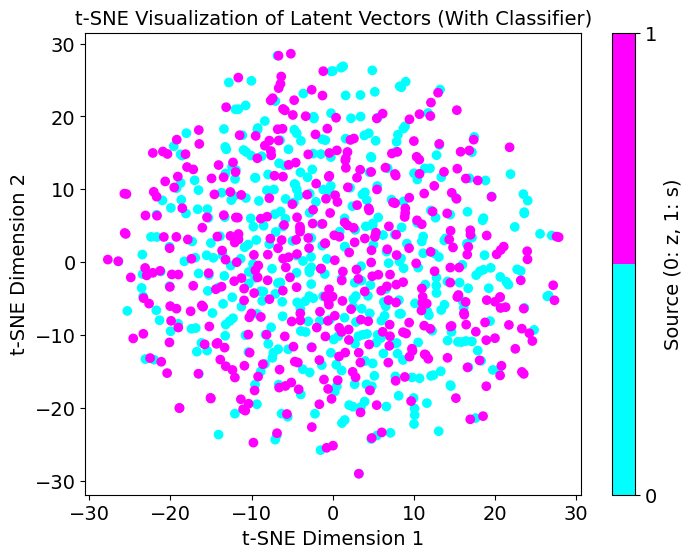


Accuracy of the logistic regression model (t-SNE with classifier): 0.50

Model Evaluation

Logistic Regression Model (t-SNE with classifier) Evaluation:
Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           z       0.50      0.51      0.50       416
           s       0.50      0.49      0.49       416

    accuracy                           0.50       832
   macro avg       0.50      0.50      0.50       832
weighted avg       0.50      0.50      0.50       832

Confusion Matrix:
 [[211 205]
 [212 204]]

=== t-SNE Visualization of Latent Vectors Grouped by Age ===



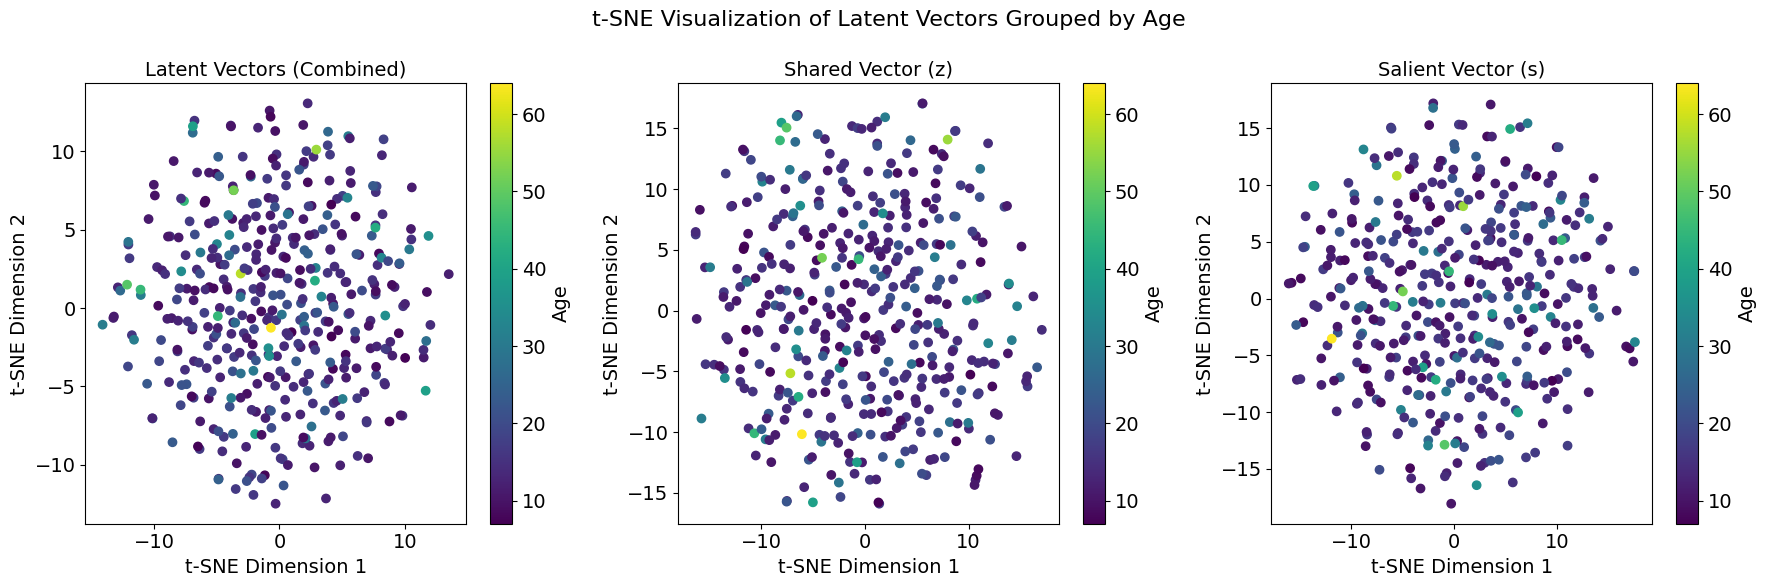

Regression results for Latent Vectors (Combined):
Mean Squared Error: 67.55
R-squared: 0.01


Regression results for Shared Vector (z):
Mean Squared Error: 67.94
R-squared: 0.00


Regression results for Salient Vector (s):
Mean Squared Error: 68.08
R-squared: 0.00




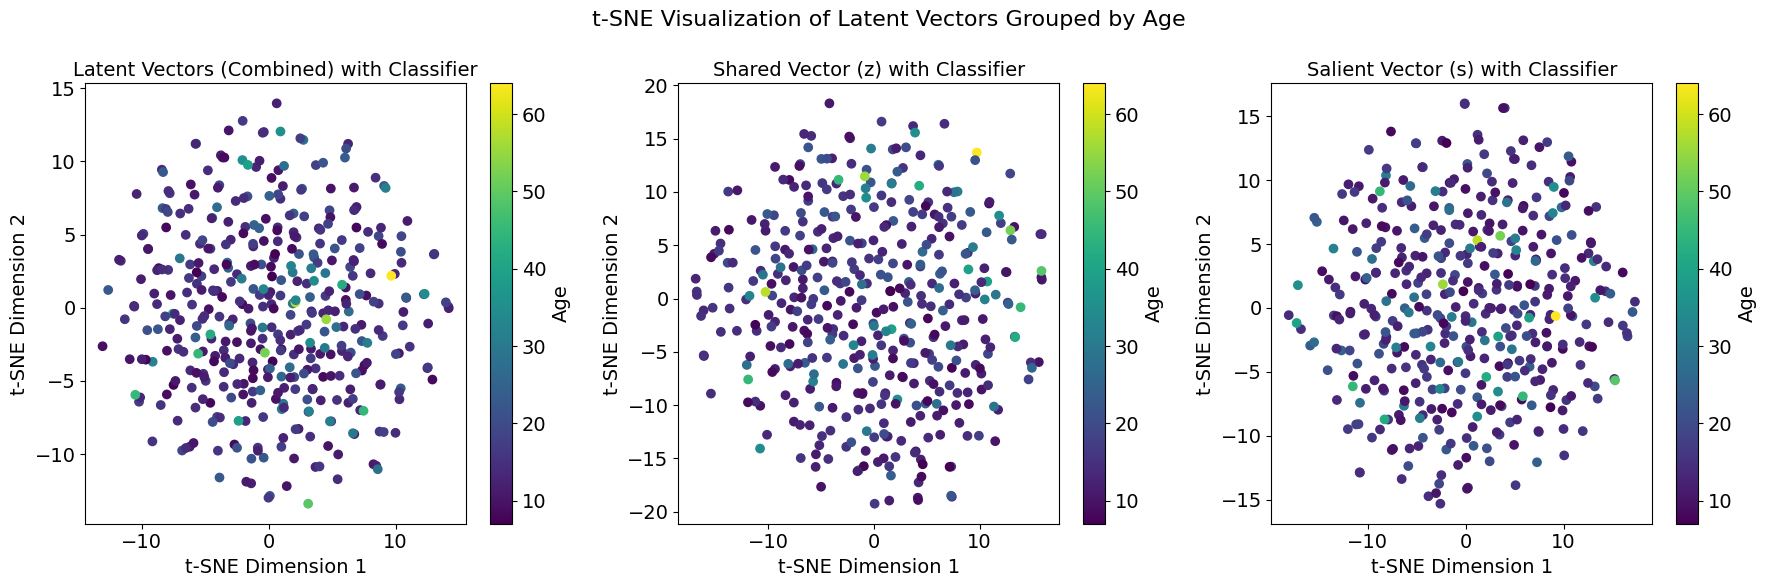

Regression results for Latent Vectors (Combined) with Classifier:
Mean Squared Error: 67.46
R-squared: 0.01


Regression results for Shared Vector (z) with Classifier:
Mean Squared Error: 64.69
R-squared: 0.05


Regression results for Salient Vector (s) with Classifier:
Mean Squared Error: 67.91
R-squared: 0.00



Model Comparison

Latent Vectors (Combined) R-squared: 0.0079
Latent Vectors (Combined) with Classifier R-squared: 0.0093
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Shared Vector (z) R-squared: 0.0021
Shared Vector (z) with Classifier R-squared: 0.0500
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Salient Vector (s) R-squared: 0.0002
Salient Vector (s) with Classifier R-squared: 0.0027
P-value for difference: 0.9999
The difference in R-squared values is not statistically significant.

=== t-SNE Visualization of Latent Vectors Grouped by Sex ===



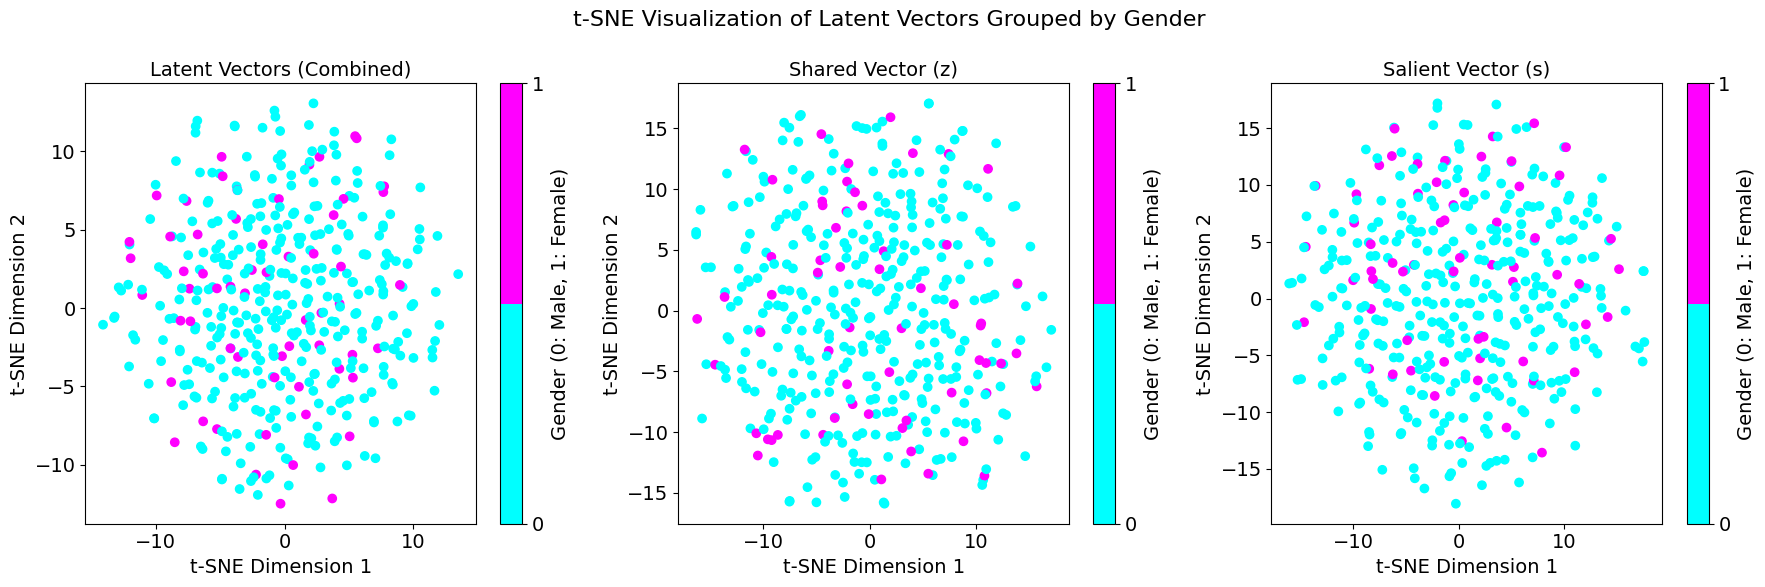

Accuracy of the logistic regression model (t-SNE Combined): 0.86
Accuracy of the logistic regression model (t-SNE Shared Vector): 0.86
Accuracy of the logistic regression model (t-SNE Salient Vector): 0.86


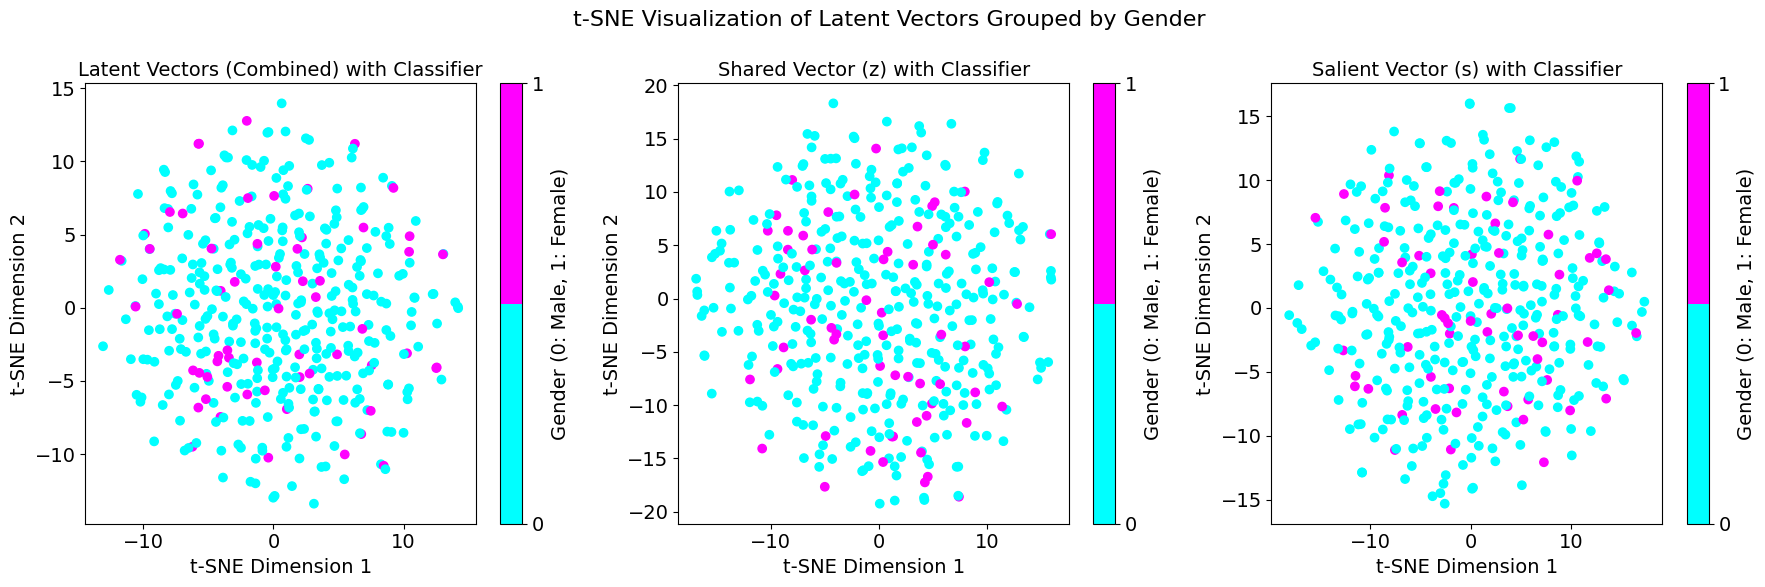

Accuracy of the logistic regression model (t-SNE Combined with Classifier): 0.86
Accuracy of the logistic regression model (t-SNE Shared Vector with Classifier): 0.86
Accuracy of the logistic regression model (t-SNE Salient Vector with Classifier): 0.86

=== t-SNE Visualization of Latent Vectors Grouped by ADOS Total ===



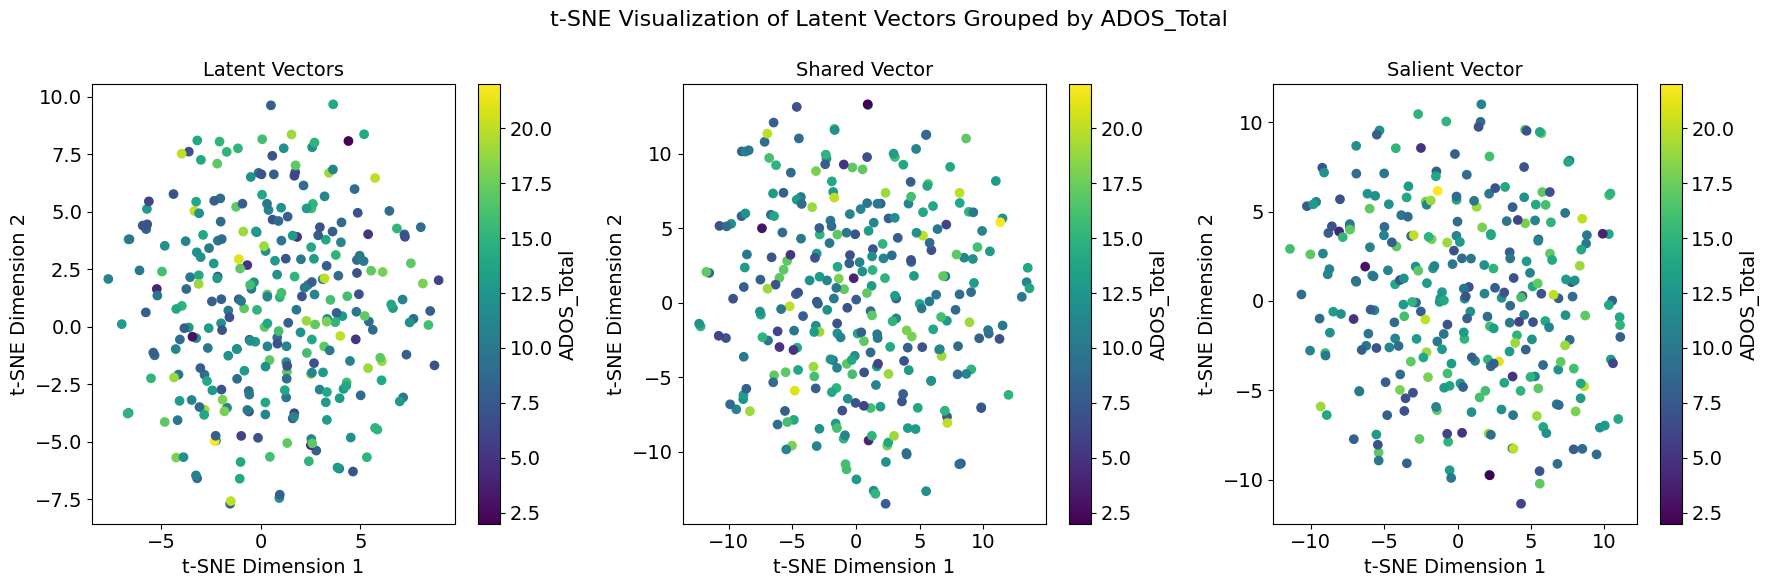

Regression results for Latent Vectors (Combined):
Mean Squared Error: 14.98
R-squared: 0.00


Regression results for Shared Vector (z):
Mean Squared Error: 14.91
R-squared: 0.01


Regression results for Salient Vector (s):
Mean Squared Error: 14.85
R-squared: 0.01




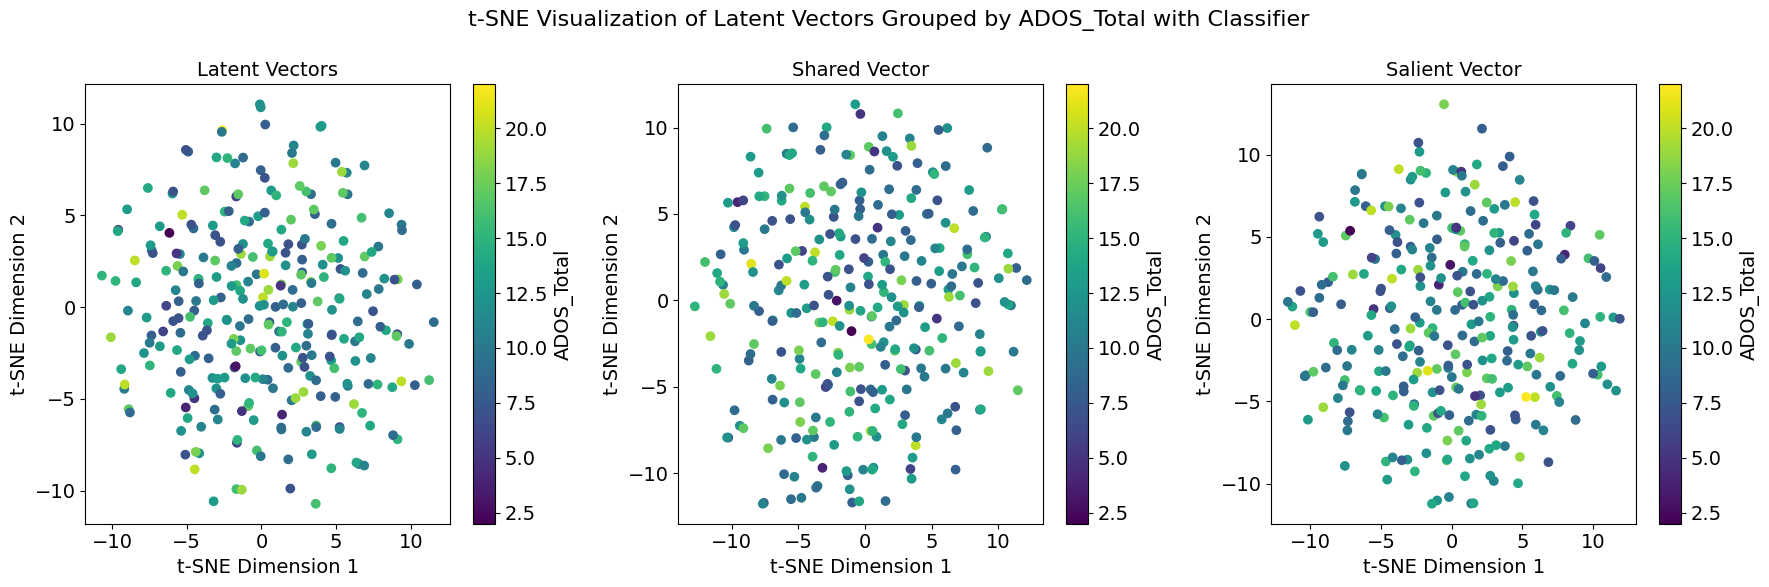

Regression results for Latent Vectors (Combined) with Classifier:
Mean Squared Error: 15.03
R-squared: 0.00


Regression results for Shared Vector (z) with Classifier:
Mean Squared Error: 15.00
R-squared: 0.00


Regression results for Salient Vector (s) with Classifier:
Mean Squared Error: 14.93
R-squared: 0.01



Model Comparison

Latent Vectors (Combined) R-squared: 0.0038
Latent Vectors (Combined) with Classifier R-squared: 0.0002
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Shared Vector (z) R-squared: 0.0088
Shared Vector (z) with Classifier R-squared: 0.0022
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Salient Vector (s) R-squared: 0.0127
Salient Vector (s) with Classifier R-squared: 0.0071
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.

=== t-SNE Visualization of Latent Vectors Grouped by ADOS Social ===



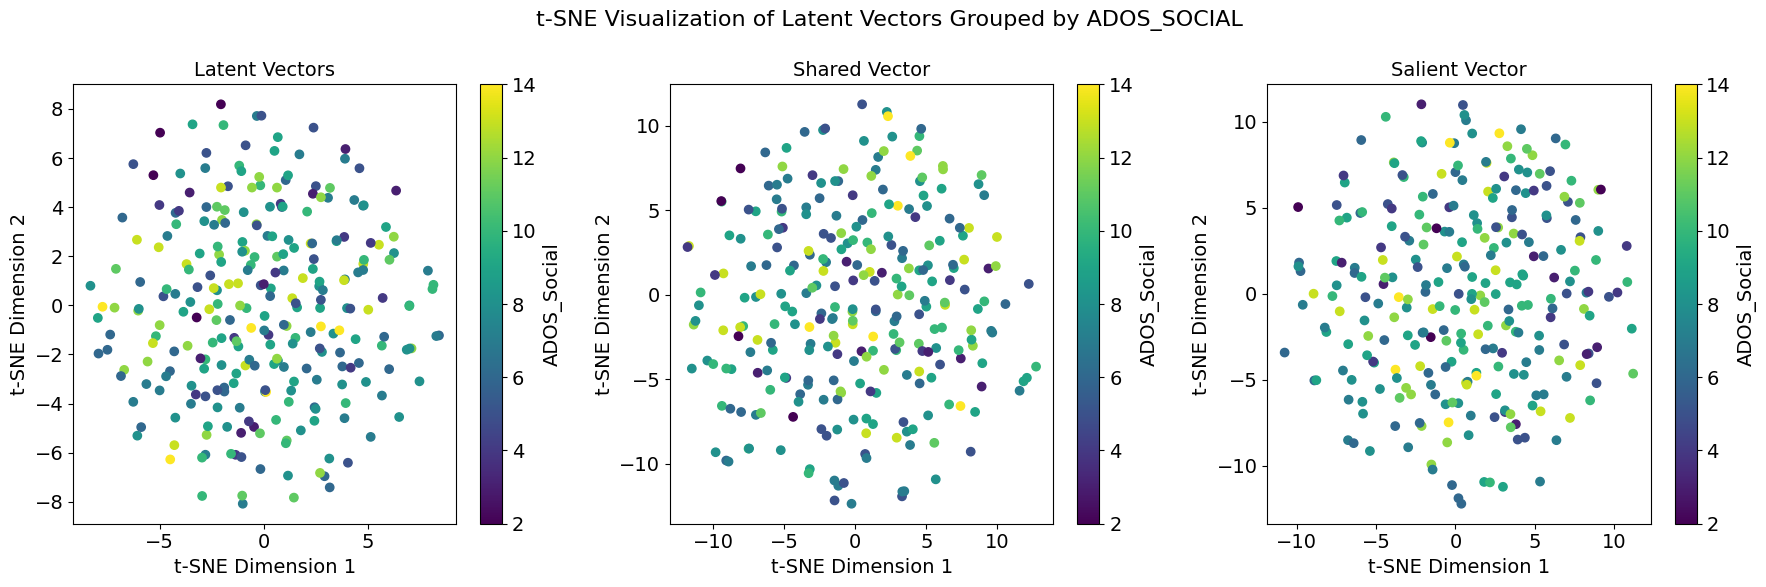

Regression results for Latent Vectors (Combined):
Mean Squared Error: 7.98
R-squared: 0.01


Regression results for Shared Vector (z):
Mean Squared Error: 7.95
R-squared: 0.01


Regression results for Salient Vector (s):
Mean Squared Error: 8.01
R-squared: 0.00




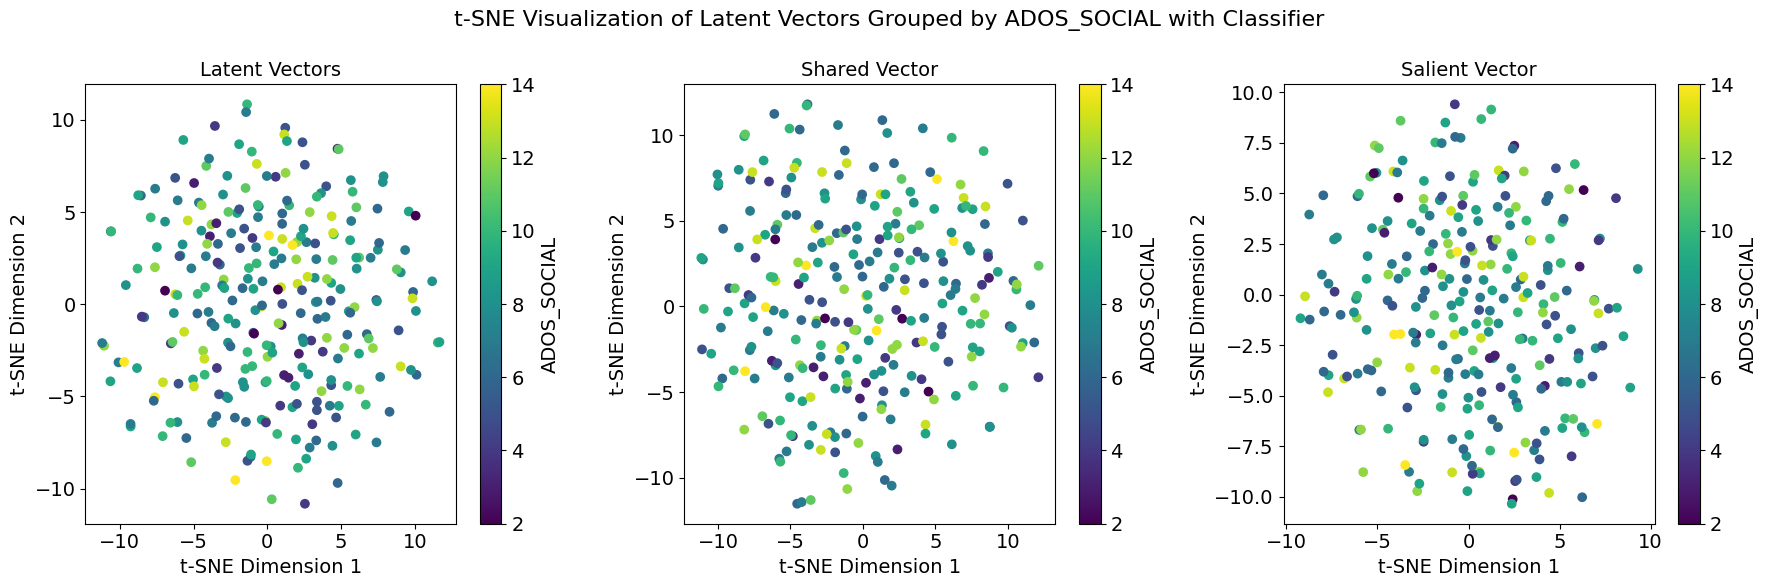

Regression results for Latent Vectors (Combined) with Classifier:
Mean Squared Error: 8.02
R-squared: 0.00


Regression results for Shared Vector (z) with Classifier:
Mean Squared Error: 8.02
R-squared: 0.00


Regression results for Salient Vector (s) with Classifier:
Mean Squared Error: 8.01
R-squared: 0.00



Model Comparison

Latent Vectors (Combined) R-squared: 0.0052
Latent Vectors (Combined) with Classifier R-squared: 0.0012
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Shared Vector (z) R-squared: 0.0094
Shared Vector (z) with Classifier R-squared: 0.0012
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Salient Vector (s) R-squared: 0.0017
Salient Vector (s) with Classifier R-squared: 0.0023
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.

=== t-SNE Visualization of Latent Vectors Grouped by FIQ ===



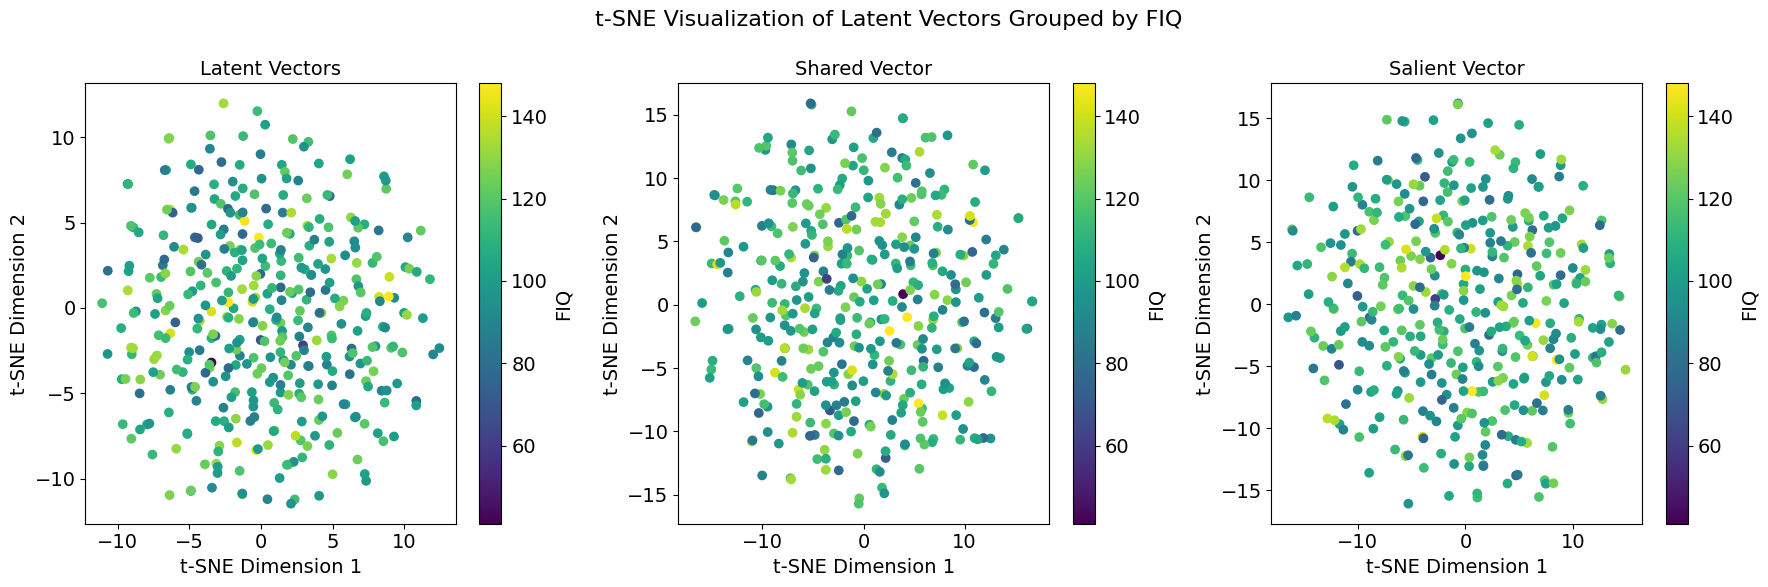


Linear Regression Results for FIQ:
Regression results for Latent Vectors (Combined):
Mean Squared Error: 279.89
R-squared: 0.00


Regression results for Shared Vector (z):
Mean Squared Error: 278.96
R-squared: 0.01


Regression results for Salient Vector (s):
Mean Squared Error: 280.06
R-squared: 0.00



=== t-SNE Visualization of Latent Vectors Grouped by FIQ ===



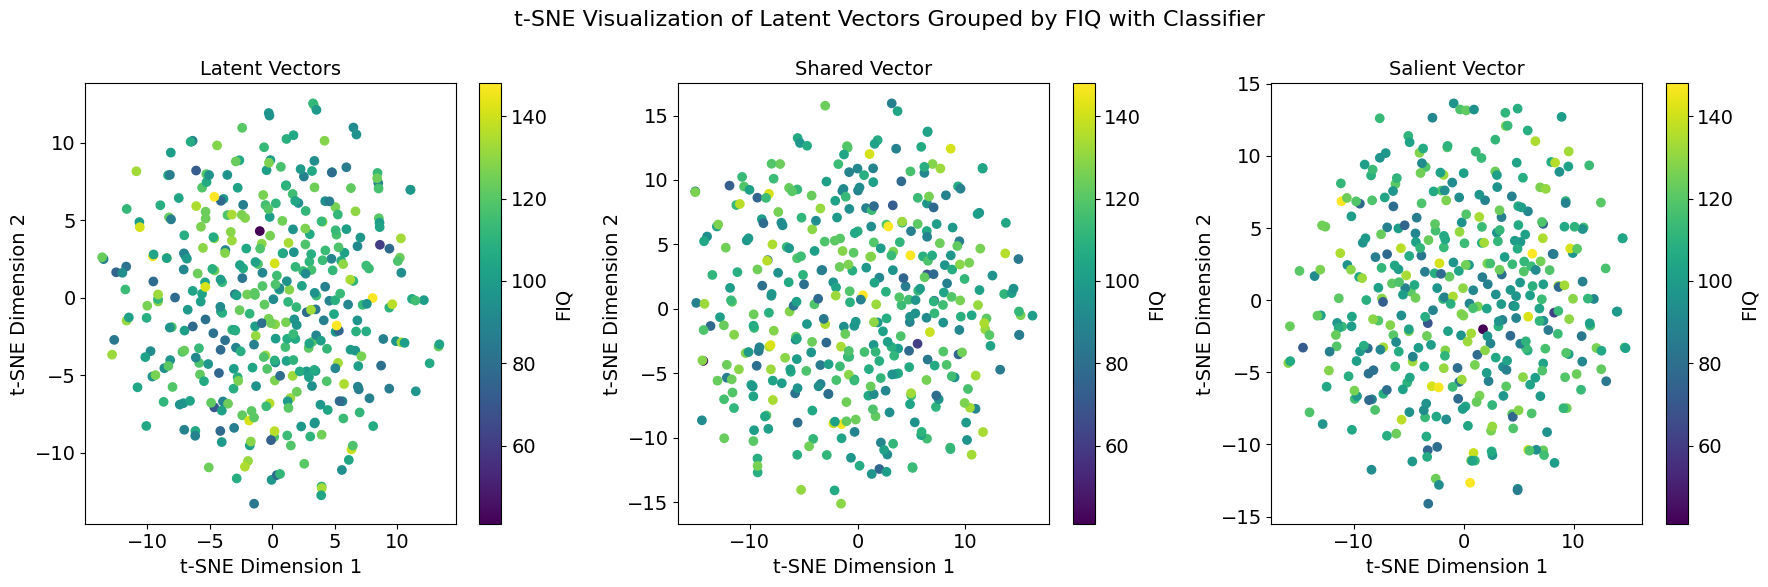


Linear Regression Results for FIQ with Classifier:
Regression results for Latent Vectors (Combined) with Classifier:
Mean Squared Error: 280.57
R-squared: 0.00


Regression results for Shared Vector (z) with Classifier:
Mean Squared Error: 280.09
R-squared: 0.00


Regression results for Salient Vector (s) with Classifier:
Mean Squared Error: 280.11
R-squared: 0.00



Model Comparison

Latent Vectors (Combined) R-squared: 0.0031
Latent Vectors (Combined) with Classifier R-squared: 0.0007
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Shared Vector (z) R-squared: 0.0064
Shared Vector (z) with Classifier R-squared: 0.0024
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
Salient Vector (s) R-squared: 0.0025
Salient Vector (s) with Classifier R-squared: 0.0023
P-value for difference: 0.9999
The difference in R-squared values is not statistically significant.


(0.002465446680574246, 0.0022805074896575794, 0.9999455745578876)

In [50]:
z_dict, s_dict = get_batch_for_tsne(model_classifier, model_basic, train_dataloader_no_batch, device)

# Get t-SNE results and perform logistic regression without the classifier
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
z_labels = np.zeros(len(z_vectors))
s_labels = np.ones(len(s_vectors))
combined_vectors = np.vstack((z_vectors, s_vectors))
combined_labels = np.hstack((z_labels, s_labels))

tsne_without_classifier = TSNE(n_components=2, random_state=42)
tsne_result_without_classifier = tsne_without_classifier.fit_transform(combined_vectors)

# Create a scatter plot for t-SNE without the classifier
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_without_classifier[:, 0], tsne_result_without_classifier[:, 1], c=combined_labels, cmap=plt.cm.get_cmap("cool", 2))
plt.colorbar(ticks=[0, 1], label="Source (0: z, 1: s)")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Latent Vectors (Without Classifier)')
plt.show()

# Create logistic regression models for t-SNE without the classifier
logistic_model_z_s_without_classifier = LogisticRegression(random_state=42)
logistic_model_z_s_without_classifier.fit(tsne_result_without_classifier, combined_labels)

# Predict the labels on the combined dataset for t-SNE without the classifier
y_pred_without_classifier = logistic_model_z_s_without_classifier.predict(tsne_result_without_classifier)

# Calculate the accuracy of the logistic regression model without the classifier
accuracy_without_classifier = accuracy_score(combined_labels, y_pred_without_classifier)
print("\n"+ f"Accuracy of the logistic regression model (t-SNE without classifier): {accuracy_without_classifier:.2f}")


print("\n" + "Model Evaluation")
# Evaluate the logistic regression model without the classifier
y_true_without_classifier = combined_labels
classification_report_without_classifier = classification_report(y_true_without_classifier, y_pred_without_classifier, target_names=["z", "s"])
confusion_matrix_without_classifier = confusion_matrix(y_true_without_classifier, y_pred_without_classifier)

print("Logistic Regression Model (t-SNE without classifier) Evaluation:")
print(f"Accuracy: {accuracy_without_classifier:.2f}")
print("Classification Report:\n", classification_report_without_classifier)
print("Confusion Matrix:\n", confusion_matrix_without_classifier, "\n")

# Get t-SNE results and perform logistic regression with the classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
z_labels_classifier = np.zeros(len(z_vectors_classifier))
s_labels_classifier = np.ones(len(s_vectors_classifier))
combined_vectors_classifier = np.vstack((z_vectors_classifier, s_vectors_classifier))
combined_labels_classifier = combined_labels

tsne_with_classifier = TSNE(n_components=2, random_state=42)
tsne_result_with_classifier = tsne_with_classifier.fit_transform(combined_vectors_classifier)

# Create a scatter plot for t-SNE with the classifier
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_with_classifier[:, 0], tsne_result_with_classifier[:, 1], c=combined_labels_classifier, cmap=plt.cm.get_cmap("cool", 2))
plt.colorbar(ticks=[0, 1], label="Source (0: z, 1: s)")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Latent Vectors (With Classifier)')
plt.show()
# Assuming you have two dictionaries: z_dict and s_dict
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()

# Create labels to indicate the source (0 for z, 1 for s)
z_labels = np.zeros(len(z_vectors))
s_labels = np.ones(len(s_vectors))

# Create logistic regression models for t-SNE with the classifier
logistic_model_with_classifier = LogisticRegression(random_state=42)
logistic_model_with_classifier.fit(tsne_result_with_classifier, combined_labels_classifier)

# Predict the labels on the combined dataset for t-SNE with the classifier
y_pred_with_classifier = logistic_model_with_classifier.predict(tsne_result_with_classifier)

# Calculate the accuracy of the logistic regression model with the classifier
accuracy_with_classifier = accuracy_score(combined_labels_classifier, y_pred_with_classifier)
print("\n"+ f"Accuracy of the logistic regression model (t-SNE with classifier): {accuracy_with_classifier:.2f}")


print("\n" + "Model Evaluation")
# Evaluate the logistic regression model with the classifier
y_true_with_classifier = combined_labels_classifier
classification_report_with_classifier = classification_report(y_true_with_classifier, y_pred_with_classifier, target_names=["z", "s"])
confusion_matrix_with_classifier = confusion_matrix(y_true_with_classifier, y_pred_with_classifier)

print("\nLogistic Regression Model (t-SNE with classifier) Evaluation:")
print(f"Accuracy: {accuracy_with_classifier:.2f}")
print("Classification Report:\n", classification_report_with_classifier)
print("Confusion Matrix:\n", confusion_matrix_with_classifier)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by Age ===\n")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Age', fontsize=16)

# First subplot: Latent Vectors (z and s combined)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((z_vectors, s_vectors))
tsne_combined = TSNE(n_components=2, random_state=42)
tsne_result_combined = tsne_combined.fit_transform(combined_vectors)
scatter = axs[0].scatter(tsne_result_combined[:, 0], tsne_result_combined[:, 1], c=z_dict["age"], cmap="viridis")
axs[0].set_title('Latent Vectors (Combined)')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="Age")

# Second subplot: Shared Vectors (z vectors)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
tsne_z = TSNE(n_components=2, random_state=42)
tsne_result_z = tsne_z.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z[:, 0], tsne_result_z[:, 1], c=z_dict["age"], cmap="viridis")
axs[1].set_title('Shared Vector (z)')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="Age")

# Third subplot: Salient Vectors (s vectors)
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
tsne_s = TSNE(n_components=2, random_state=42)
tsne_result_s = tsne_s.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s[:, 0], tsne_result_s[:, 1], c=z_dict["age"], cmap="viridis")
axs[2].set_title('Salient Vector (s)')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="Age")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot
perform_regression(tsne_result_combined, z_dict["age"], "Latent Vectors (Combined)")
perform_regression(tsne_result_z, z_dict["age"], "Shared Vector (z)")
perform_regression(tsne_result_s, z_dict["age"], "Salient Vector (s)")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Age', fontsize=16)

# First subplot: Latent Vectors (z and s combined) with classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
combined_vectors_classifier = np.hstack((z_vectors_classifier, s_vectors_classifier))
tsne_combined_classifier = TSNE(n_components=2, random_state=42)
tsne_result_combined_classifier = tsne_combined_classifier.fit_transform(combined_vectors_classifier)
scatter_combined_classifier = axs[0].scatter(tsne_result_combined_classifier[:, 0], tsne_result_combined_classifier[:, 1], c=z_dict["age"], cmap="viridis")
axs[0].set_title('Latent Vectors (Combined) with Classifier')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_combined_classifier, ax=axs[0], label="Age")

# Second subplot: Shared Vectors (z vectors) with classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
tsne_z_classifier = TSNE(n_components=2, random_state=42)
tsne_result_z_classifier = tsne_z_classifier.fit_transform(z_vectors_classifier)
scatter_z_classifier = axs[1].scatter(tsne_result_z_classifier[:, 0], tsne_result_z_classifier[:, 1], c=z_dict["age"], cmap="viridis")
axs[1].set_title('Shared Vector (z) with Classifier')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z_classifier, ax=axs[1], label="Age")

# Third subplot: Salient Vectors (s vectors) with classifier
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
tsne_s_classifier = TSNE(n_components=2, random_state=42)
tsne_result_s_classifier = tsne_s_classifier.fit_transform(s_vectors_classifier)
scatter_s_classifier = axs[2].scatter(tsne_result_s_classifier[:, 0], tsne_result_s_classifier[:, 1], c=z_dict["age"], cmap="viridis")
axs[2].set_title('Salient Vector (s) with Classifier')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s_classifier, ax=axs[2], label="Age")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_combined_classifier, z_dict["age"], "Latent Vectors (Combined) with Classifier")
perform_regression(tsne_result_z_classifier, z_dict["age"], "Shared Vector (z) with Classifier")
perform_regression(tsne_result_s_classifier, z_dict["age"], "Salient Vector (s) with Classifier")

print("\n" + "Model Comparison" + "\n")
# Usage for comparing the regression results
perform_regression_comparison(tsne_result_combined, tsne_result_combined_classifier, z_dict["age"], "Latent Vectors (Combined)", "Latent Vectors (Combined) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_z, tsne_result_z_classifier, z_dict["age"], "Shared Vector (z)", "Shared Vector (z) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_s, tsne_result_s_classifier, z_dict["age"], "Salient Vector (s)", "Salient Vector (s) with Classifier")



import warnings
warnings.filterwarnings("ignore")


# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by Sex ===\n")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Gender', fontsize=16)

# First subplot: Latent Vectors (z and s combined) without classifier
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((z_vectors, s_vectors))
tsne_combined = TSNE(n_components=2, random_state=42)
tsne_result_combined = tsne_combined.fit_transform(combined_vectors)
cmap = plt.cm.get_cmap("cool", 2)
scatter_combined = axs[0].scatter(tsne_result_combined[:, 0], tsne_result_combined[:, 1], c=z_dict["gender"], cmap=cmap)
axs[0].set_title('Latent Vectors (Combined)')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_combined, ax=axs[0], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Second subplot: Shared Vectors (z vectors) without classifier
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
tsne_z = TSNE(n_components=2, random_state=42)
tsne_result_z = tsne_z.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z[:, 0], tsne_result_z[:, 1], c=z_dict["gender"], cmap=cmap)
axs[1].set_title('Shared Vector (z)')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Third subplot: Salient Vectors (s vectors) without classifier
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
tsne_s = TSNE(n_components=2, random_state=42)
tsne_result_s = tsne_s.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s[:, 0], tsne_result_s[:, 1], c=z_dict["gender"], cmap=cmap)
axs[2].set_title('Salient Vector (s)')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

plt.tight_layout()
plt.show()

# Perform logistic regression for each subplot without classifier
logistic_model_combined = LogisticRegression(random_state=42)
logistic_model_combined.fit(tsne_result_combined, z_dict["gender"])
y_pred_combined = logistic_model_combined.predict(tsne_result_combined)
accuracy_combined = accuracy_score(z_dict["gender"], y_pred_combined)
print(f"Accuracy of the logistic regression model (t-SNE Combined): {accuracy_combined:.2f}")

logistic_model_z = LogisticRegression(random_state=42)
logistic_model_z.fit(tsne_result_z, z_dict["gender"])
y_pred_z = logistic_model_z.predict(tsne_result_z)
accuracy_z = accuracy_score(z_dict["gender"], y_pred_z)
print(f"Accuracy of the logistic regression model (t-SNE Shared Vector): {accuracy_z:.2f}")

logistic_model_s = LogisticRegression(random_state=42)
logistic_model_s.fit(tsne_result_s, z_dict["gender"])
y_pred_s = logistic_model_s.predict(tsne_result_s)
accuracy_s = accuracy_score(z_dict["gender"], y_pred_s)
print(f"Accuracy of the logistic regression model (t-SNE Salient Vector): {accuracy_s:.2f}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Gender', fontsize=16)

# First subplot: Latent Vectors (z and s combined) with classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
combined_vectors_classifier = np.hstack((z_vectors_classifier, s_vectors_classifier))
tsne_combined_classifier = TSNE(n_components=2, random_state=42)
tsne_result_combined_classifier = tsne_combined_classifier.fit_transform(combined_vectors_classifier)
cmap = plt.cm.get_cmap("cool", 2)
scatter_combined_classifier = axs[0].scatter(tsne_result_combined_classifier[:, 0], tsne_result_combined_classifier[:, 1], c=z_dict["gender"], cmap=cmap)
axs[0].set_title('Latent Vectors (Combined) with Classifier')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_combined_classifier, ax=axs[0], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Second subplot: Shared Vectors (z vectors) with classifier
z_vectors_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()
tsne_z_classifier = TSNE(n_components=2, random_state=42)
tsne_result_z_classifier = tsne_z_classifier.fit_transform(z_vectors_classifier)
scatter_z_classifier = axs[1].scatter(tsne_result_z_classifier[:, 0], tsne_result_z_classifier[:, 1], c=z_dict["gender"], cmap=cmap)
axs[1].set_title('Shared Vector (z) with Classifier')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z_classifier, ax=axs[1], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Third subplot: Salient Vectors (s vectors) with classifier
s_vectors_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()
tsne_s_classifier = TSNE(n_components=2, random_state=42)
tsne_result_s_classifier = tsne_s_classifier.fit_transform(s_vectors_classifier)
scatter_s_classifier = axs[2].scatter(tsne_result_s_classifier[:, 0], tsne_result_s_classifier[:, 1], c=z_dict["gender"], cmap=cmap)
axs[2].set_title('Salient Vector (s) with Classifier')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s_classifier, ax=axs[2], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

plt.tight_layout()
plt.show()

# Perform logistic regression for each subplot with classifier
logistic_model_combined_classifier = LogisticRegression(random_state=42)
logistic_model_combined_classifier.fit(tsne_result_combined_classifier, z_dict["gender"])
y_pred_combined_classifier = logistic_model_combined_classifier.predict(tsne_result_combined_classifier)
accuracy_combined_classifier = accuracy_score(z_dict["gender"], y_pred_combined_classifier)
print(f"Accuracy of the logistic regression model (t-SNE Combined with Classifier): {accuracy_combined_classifier:.2f}")

logistic_model_z_classifier = LogisticRegression(random_state=42)
logistic_model_z_classifier.fit(tsne_result_z_classifier, z_dict["gender"])
y_pred_z_classifier = logistic_model_z_classifier.predict(tsne_result_z_classifier)
accuracy_z_classifier = accuracy_score(z_dict["gender"], y_pred_z_classifier)
print(f"Accuracy of the logistic regression model (t-SNE Shared Vector with Classifier): {accuracy_z_classifier:.2f}")

logistic_model_s_classifier = LogisticRegression(random_state=42)
logistic_model_s_classifier.fit(tsne_result_s_classifier, z_dict["gender"])
y_pred_s_classifier = logistic_model_s_classifier.predict(tsne_result_s_classifier)
accuracy_s_classifier = accuracy_score(z_dict["gender"], y_pred_s_classifier)
print(f"Accuracy of the logistic regression model (t-SNE Salient Vector with Classifier): {accuracy_s_classifier:.2f}")


import warnings
warnings.filterwarnings("ignore")

# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by ADOS Total ===\n")

# Create subplots for ADOS_TOTAL
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_Total', fontsize=16)

# Filter data for ADOS_TOTAL
indices_to_remove = find_non_numeric_indices(z_dict["ADOS_Total"].tolist())
z_vector_ados_total = z_dict["latent_vec"].detach().cpu().numpy()
s_vector_ados_total = s_dict["latent_vec"].detach().cpu().numpy()
s_vector_ados_total = np.delete(s_vector_ados_total, indices_to_remove, axis=0)
z_vector_ados_total = np.delete(z_vector_ados_total, indices_to_remove, axis=0)

ados_total_covariate = np.delete(z_dict["ADOS_Total"], indices_to_remove, axis=0)

# First subplot: Latent Vectors (z and s combined) for ADOS_TOTAL
combined_vectors_ados_total = np.hstack((z_vector_ados_total, s_vector_ados_total))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_ados_total = tsne.fit_transform(combined_vectors_ados_total)
scatter = axs[0].scatter(tsne_result_ados_total[:, 0], tsne_result_ados_total[:, 1], c=ados_total_covariate , cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_Total")

# Second subplot: Shared Vectors (z vectors) for ADOS_TOTAL
z_vectors = z_vector_ados_total
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_ados_total = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_ados_total[:, 0], tsne_result_z_ados_total[:, 1], c=ados_total_covariate , cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_Total")

# Third subplot: Salient Vectors (s vectors) for ADOS_TOTAL
s_vectors = s_vector_ados_total
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_ados_total = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_ados_total[:, 0], tsne_result_s_ados_total[:, 1], c=ados_total_covariate , cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_Total")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_ados_total, ados_total_covariate, "Latent Vectors (Combined)")
perform_regression(tsne_result_z_ados_total, ados_total_covariate, "Shared Vector (z)")
perform_regression(tsne_result_s_ados_total, ados_total_covariate, "Salient Vector (s)")


# Create subplots for ADOS_TOTAL with classifier
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_Total with Classifier', fontsize=16)

# Filter data for ADOS_TOTAL
indices_to_remove = find_non_numeric_indices(z_dict["ADOS_Total"].tolist())
z_vector_ados_total_classifier = z_dict["latent_vec_classifier"].detach().cpu().numpy()  # Updated variable name
s_vector_ados_total_classifier = s_dict["latent_vec_classifier"].detach().cpu().numpy()  # Updated variable name
s_vector_ados_total_classifier = np.delete(s_vector_ados_total_classifier, indices_to_remove, axis=0)
z_vector_ados_total_classifier = np.delete(z_vector_ados_total_classifier, indices_to_remove, axis=0)

ados_total_covariate_classifier = np.delete(z_dict["ADOS_Total"], indices_to_remove, axis=0)  # Updated variable name

# First subplot: Latent Vectors (z and s combined) for ADOS_TOTAL with Classifier
combined_vectors_ados_total_classifier = np.hstack((z_vector_ados_total_classifier, s_vector_ados_total_classifier))
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_ados_total_classifier = tsne_classifier.fit_transform(combined_vectors_ados_total_classifier)
scatter = axs[0].scatter(tsne_result_ados_total_classifier[:, 0], tsne_result_ados_total_classifier[:, 1], c=ados_total_covariate_classifier, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_Total")

# Second subplot: Shared Vectors (z vectors) for ADOS_TOTAL with Classifier
z_vectors_classifier = z_vector_ados_total_classifier
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_z_ados_total_classifier = tsne_classifier.fit_transform(z_vectors_classifier)
scatter_z = axs[1].scatter(tsne_result_z_ados_total_classifier[:, 0], tsne_result_z_ados_total_classifier[:, 1], c=ados_total_covariate_classifier, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_Total")

# Third subplot: Salient Vectors (s vectors) for ADOS_TOTAL with Classifier
s_vectors_classifier = s_vector_ados_total_classifier
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_s_ados_total_classifier = tsne_classifier.fit_transform(s_vectors_classifier)
scatter_s = axs[2].scatter(tsne_result_s_ados_total_classifier[:, 0], tsne_result_s_ados_total_classifier[:, 1], c=ados_total_covariate_classifier, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_Total")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_ados_total_classifier, ados_total_covariate_classifier, "Latent Vectors (Combined) with Classifier")
perform_regression(tsne_result_z_ados_total_classifier, ados_total_covariate_classifier, "Shared Vector (z) with Classifier")
perform_regression(tsne_result_s_ados_total_classifier, ados_total_covariate_classifier, "Salient Vector (s) with Classifier")

print("\nModel Comparison\n")
perform_regression_comparison(tsne_result_ados_total, tsne_result_ados_total_classifier, ados_total_covariate, "Latent Vectors (Combined)", "Latent Vectors (Combined) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_z_ados_total, tsne_result_z_ados_total_classifier, ados_total_covariate, "Shared Vector (z)", "Shared Vector (z) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_s_ados_total, tsne_result_s_ados_total_classifier, ados_total_covariate, "Salient Vector (s)", "Salient Vector (s) with Classifier")

import warnings
warnings.filterwarnings("ignore")

# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by ADOS Social ===\n")

# Create subplots for ADOS_SOCIAL
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_SOCIAL', fontsize=16)

# Filter data for ADOS_SOCIAL
indices_to_remove = find_non_numeric_indices(z_dict["ADOS_Social"].tolist())
z_vector_ados_social = z_dict["latent_vec"].detach().cpu().numpy()
s_vector_ados_social = s_dict["latent_vec"].detach().cpu().numpy()
s_vector_ados_social = np.delete(s_vector_ados_social, indices_to_remove, axis=0)
z_vector_ados_social = np.delete(z_vector_ados_social, indices_to_remove, axis=0)

ados_social_covariate = np.delete(z_dict["ADOS_Social"], indices_to_remove, axis=0)

# First subplot: Latent Vectors (z and s combined) for ADOS_SOCIAL
combined_vectors_ados_social = np.hstack((z_vector_ados_social, s_vector_ados_social))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_ados_social = tsne.fit_transform(combined_vectors_ados_social)
scatter = axs[0].scatter(tsne_result_ados_social[:, 0], tsne_result_ados_social[:, 1], c=ados_social_covariate, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_Social")

# Second subplot: Shared Vectors (z vectors) for ADOS_SOCIAL
z_vectors = z_vector_ados_social
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_ados_social = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_ados_social[:, 0], tsne_result_z_ados_social[:, 1], c=ados_social_covariate, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_Social")

# Third subplot: Salient Vectors (s vectors) for ADOS_SOCIAL
s_vectors = s_vector_ados_social
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_ados_social = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_ados_social[:, 0], tsne_result_s_ados_social[:, 1], c=ados_social_covariate, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_Social")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_ados_social, ados_social_covariate, "Latent Vectors (Combined)")
perform_regression(tsne_result_z_ados_social, ados_social_covariate, "Shared Vector (z)")
perform_regression(tsne_result_s_ados_social, ados_social_covariate, "Salient Vector (s)")


# Create subplots for ADOS_SOCIAL with classifier
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_SOCIAL with Classifier', fontsize=16)

# Filter data for ADOS_SOCIAL
indices_to_remove = find_non_numeric_indices(z_dict["ADOS_Social"].tolist())
z_vector_ados_social = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vector_ados_social = s_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vector_ados_social = np.delete(s_vector_ados_social, indices_to_remove, axis=0)
z_vector_ados_social = np.delete(z_vector_ados_social, indices_to_remove, axis=0)

# First subplot: Latent Vectors (z and s combined) for ADOS_SOCIAL
combined_vectors_ados_social = np.hstack((z_vector_ados_social, s_vector_ados_social))
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_ados_social_classifier = tsne_classifier.fit_transform(combined_vectors_ados_social)
scatter = axs[0].scatter(tsne_result_ados_social_classifier[:, 0], tsne_result_ados_social_classifier[:, 1], c=ados_social_covariate, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_SOCIAL")

# Second subplot: Shared Vectors (z vectors) for ADOS_SOCIAL
z_vectors = z_vector_ados_social
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_z_ados_social_classifier = tsne_classifier.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_ados_social_classifier[:, 0], tsne_result_z_ados_social_classifier[:, 1], c=ados_social_covariate, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_SOCIAL")

# Third subplot: Salient Vectors (s vectors) for ADOS_SOCIAL
s_vectors = s_vector_ados_social
tsne_classifier = TSNE(n_components=2, random_state=42)
tsne_result_s_ados_social_classifier = tsne_classifier.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_ados_social_classifier[:, 0], tsne_result_s_ados_social_classifier[:, 1], c=ados_social_covariate, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_SOCIAL")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_ados_social_classifier, ados_social_covariate, "Latent Vectors (Combined) with Classifier")
perform_regression(tsne_result_z_ados_social_classifier, ados_social_covariate, "Shared Vector (z) with Classifier")
perform_regression(tsne_result_s_ados_social_classifier, ados_social_covariate, "Salient Vector (s) with Classifier")

print("\nModel Comparison\n")
perform_regression_comparison(tsne_result_ados_social, tsne_result_ados_social_classifier, ados_social_covariate, "Latent Vectors (Combined)", "Latent Vectors (Combined) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_z_ados_social, tsne_result_z_ados_social_classifier, ados_social_covariate, "Shared Vector (z)", "Shared Vector (z) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_s_ados_social, tsne_result_s_ados_social_classifier,ados_social_covariate, "Salient Vector (s)", "Salient Vector (s) with Classifier")

import warnings
warnings.filterwarnings("ignore")

# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by FIQ ===\n")

# Filter data for FIQ
indices_to_remove = find_non_numeric_indices(z_dict["FIQ"].tolist())
z_vector_fiq = z_dict["latent_vec"].detach().cpu().numpy()
s_vector_fiq = s_dict["latent_vec"].detach().cpu().numpy()
s_vector_fiq = np.delete(s_vector_fiq, indices_to_remove, axis=0)
z_vector_fiq = np.delete(z_vector_fiq, indices_to_remove, axis=0)

fiq_covariate = np.delete(z_dict["FIQ"], indices_to_remove, axis=0)

# Create subplots for FIQ
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by FIQ', fontsize=16)

# First subplot: Latent Vectors (z and s combined) for FIQ
combined_vectors_fiq = np.hstack((z_vector_fiq, s_vector_fiq))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_fiq = tsne.fit_transform(combined_vectors_fiq)
scatter = axs[0].scatter(tsne_result_fiq[:, 0], tsne_result_fiq[:, 1], c=fiq_covariate, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="FIQ")

# Second subplot: Shared Vectors (z vectors) for FIQ
z_vectors = z_vector_fiq
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_fiq = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_fiq[:, 0], tsne_result_z_fiq[:, 1], c=fiq_covariate, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="FIQ")

# Third subplot: Salient Vectors (s vectors) for FIQ
s_vectors = s_vector_fiq
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_fiq = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_fiq[:, 0], tsne_result_s_fiq[:, 1], c=fiq_covariate, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="FIQ")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot
print("\nLinear Regression Results for FIQ:")
perform_regression(tsne_result_fiq, fiq_covariate, "Latent Vectors (Combined)")
perform_regression(tsne_result_z_fiq, fiq_covariate, "Shared Vector (z)")
perform_regression(tsne_result_s_fiq, fiq_covariate, "Salient Vector (s)")


# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by FIQ ===\n")

# Filter data for FIQ
indices_to_remove = find_non_numeric_indices(z_dict["FIQ"].tolist())
z_vector_fiq = z_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vector_fiq = s_dict["latent_vec_classifier"].detach().cpu().numpy()
s_vector_fiq = np.delete(s_vector_fiq, indices_to_remove, axis=0)
z_vector_fiq = np.delete(z_vector_fiq, indices_to_remove, axis=0)

fiq_covariate = np.delete(z_dict["FIQ"], indices_to_remove, axis=0)

# Create subplots for FIQ with classifier
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by FIQ with Classifier', fontsize=16)

# First subplot: Latent Vectors (z and s combined) for FIQ with classifier
combined_vectors_fiq = np.hstack((z_vector_fiq, s_vector_fiq))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_fiq_classifier = tsne.fit_transform(combined_vectors_fiq)
scatter = axs[0].scatter(tsne_result_fiq_classifier[:, 0], tsne_result_fiq_classifier[:, 1], c=fiq_covariate, cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="FIQ")

# Second subplot: Shared Vectors (z vectors) for FIQ with classifier
z_vectors = z_vector_fiq
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_fiq_classifier = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_fiq_classifier[:, 0], tsne_result_z_fiq_classifier[:, 1], c=fiq_covariate, cmap="viridis")
axs[1].set_title('Shared Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="FIQ")

# Third subplot: Salient Vectors (s vectors) for FIQ with classifier
s_vectors = s_vector_fiq
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_fiq_classifier = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_fiq_classifier[:, 0], tsne_result_s_fiq_classifier[:, 1], c=fiq_covariate, cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="FIQ")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
print("\nLinear Regression Results for FIQ with Classifier:")
perform_regression(tsne_result_fiq_classifier, fiq_covariate, "Latent Vectors (Combined) with Classifier")
perform_regression(tsne_result_z_fiq_classifier, fiq_covariate, "Shared Vector (z) with Classifier")
perform_regression(tsne_result_s_fiq_classifier, fiq_covariate, "Salient Vector (s) with Classifier")


print("\nModel Comparison\n")
perform_regression_comparison(tsne_result_fiq, tsne_result_fiq_classifier, fiq_covariate, "Latent Vectors (Combined)", "Latent Vectors (Combined) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_z_fiq, tsne_result_z_fiq_classifier, fiq_covariate, "Shared Vector (z)", "Shared Vector (z) with Classifier")
print("=" * 20)
perform_regression_comparison(tsne_result_s_fiq, tsne_result_s_fiq_classifier, fiq_covariate, "Salient Vector (s)", "Salient Vector (s) with Classifier")



Now, let's just look at the Shared vector. For this we take the vector from the shared encoder and see if it differs in the correlation pattern.

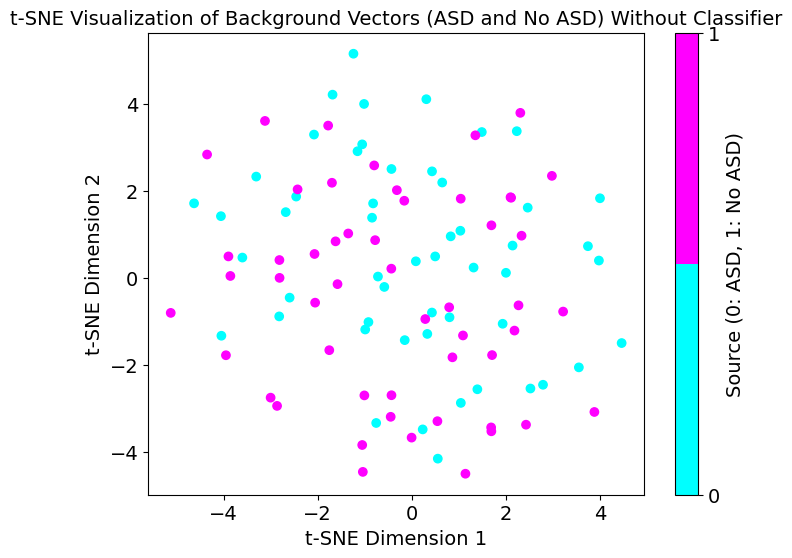


Accuracy of the logistic regression model (t-SNE combined without classifier): 0.59

Logistic Regression Model (t-SNE combined without classifier) Evaluation:
Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

         ASD       0.59      0.58      0.58        52
      No ASD       0.58      0.60      0.59        52

    accuracy                           0.59       104
   macro avg       0.59      0.59      0.59       104
weighted avg       0.59      0.59      0.59       104

Confusion Matrix:
 [[30 22]
 [21 31]]


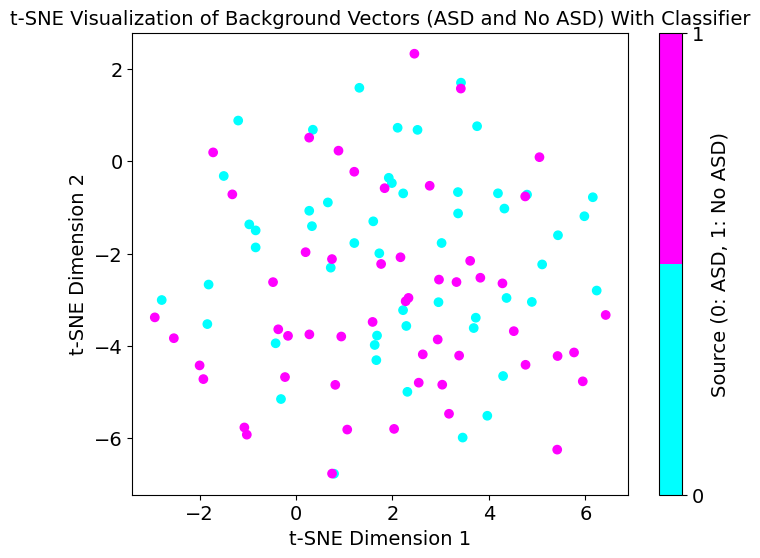


Accuracy of the logistic regression model (t-SNE combined with classifier): 0.62

Logistic Regression Model (t-SNE combined with classifier) Evaluation:
Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

         ASD       0.62      0.62      0.62        52
      No ASD       0.62      0.62      0.62        52

    accuracy                           0.62       104
   macro avg       0.62      0.62      0.62       104
weighted avg       0.62      0.62      0.62       104

Confusion Matrix:
 [[32 20]
 [20 32]]


In [ ]:
def get_Shared_batch(model_classifier, model_basic, dataloader, device):
    model_basic.eval()
    model_classifier.eval()

    # Create iterators for the data loader
    batch_iterator = iter(dataloader)

    # Get a single batch (sample)
    sample_batch = next(batch_iterator)

    (autism_data, autism_age, autism_FIQ, autism_diag_group, autism_ADOS_TOTAL, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_gender, autism_sub_id), (no_autism_data, no_autism_age, no_autism_FIQ, no_autism_diag_group, no_autism_gender, no_autism_sub_id)= sample_batch

    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    (z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism) = model_basic(autism_data, no_autism_data)

    (z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_no_autism_age, z_classifier, _, z_no_autism_classifier) = model_classifier(autism_data, no_autism_data)

    z_list = []  # List to store z vectors with classifier
    z_no_ASD_list = []  # List to store z_no_autism vectors with classifier
    z_labels = []  # Labels for z vectors with classifier

    z_classifier_list = []  # List to store z vectors without classifier
    z_no_ASD_classifier_list = []  # List to store z_no_autism vectors without classifier
    z_classifier_labels = []  # Labels for z vectors without classifier

    # Loop through the batch dimension
    for i in range(autism_data.shape[0]):
        # Collect data with the classifier
        z_list.append(z[i])
        z_no_ASD_list.append(z_no_autism[i])
        z_labels.append("z")

    for i in range(no_autism_data.shape[0]):
        # Collect data without the classifier
        z_classifier_list.append(z_classifier[i])
        z_no_ASD_classifier_list.append(z_no_autism_classifier[i])
        z_classifier_labels.append("z_classifier")

    # Convert lists to tensors for data with the classifier
    z_dict = {"latent_vec": torch.stack(z_list), "age": autism_age, "gender": autism_gender, "FIQ": autism_FIQ, "sub_id": autism_sub_id, "label": z_labels}
    z_no_ASD_dict = {"latent_vec": torch.stack(z_no_ASD_list), "age": no_autism_age, "gender": no_autism_gender, "FIQ": no_autism_FIQ, "sub_id": no_autism_sub_id, "label": z_labels}

    # Convert lists to tensors for data without the classifier
    z_dict_classifier = {"latent_vec_classifier": torch.stack(z_classifier_list), "age": autism_age, "gender": autism_gender, "FIQ": autism_FIQ, "sub_id": autism_sub_id, "label": z_classifier_labels}
    z_no_ASD_dict_classifier = {"latent_vec_classifier": torch.stack(z_no_ASD_classifier_list), "age": no_autism_age, "gender": no_autism_gender, "FIQ": no_autism_FIQ, "sub_id": no_autism_sub_id, "label": z_classifier_labels}

    return z_dict, z_no_ASD_dict, z_dict_classifier, z_no_ASD_dict_classifier

def perform_regression_comparison2(X1, X2, y1, y2, title1, title2):
    """
    Perform model comparison by comparing the R-squared values of two linear regression models with different target variables.

    Parameters:
        X1 (numpy.ndarray): Input data for the first model.
        X2 (numpy.ndarray): Input data for the second model.
        y1 (numpy.ndarray): Target variable for the first model.
        y2 (numpy.ndarray): Target variable for the second model.
        title1 (str): Title for the first model.
        title2 (str): Title for the second model.
    """
    # Fit linear regression models
    model1 = LinearRegression()
    model1.fit(X1, y1)
    y_pred1 = model1.predict(X1)
    r2_1 = r2_score(y1, y_pred1)

    model2 = LinearRegression()
    model2.fit(X2, y2)
    y_pred2 = model2.predict(X2)
    r2_2 = r2_score(y2, y_pred2)

    # Perform paired t-test to check for significant difference
    t_statistic, p_value = stats.ttest_rel(y1 - y_pred1, y2 - y_pred2)

    print(f"{title1} R-squared: {r2_1:.4f}")
    print(f"{title2} R-squared: {r2_2:.4f}")
    print(f"P-value for difference: {p_value:.4f}")

    if p_value < 0.05:
        print(f"The difference in R-squared values is statistically significant.")
        if r2_1 > r2_2:
            print(f"{title1} is superior to {title2}.")
        else:
            print(f"{title2} is superior to {title1}.")
    else:
        print(f"The difference in R-squared values is not statistically significant.")

    return r2_1, r2_2, p_value


shared_vec, shared_vec_no_ASD, shared_vec_classifier, shared_vec_classifier_no_ASD = get_Shared_batch(model_classifier, model_basic, test_dataloader_no_batch, device)

# Extract Shared vectors without the classifier
shared_vec_basic = shared_vec["latent_vec"].detach().cpu().numpy()
shared_vec_no_ASD_basic = shared_vec_no_ASD["latent_vec"].detach().cpu().numpy()

# Create labels to indicate the source (0 for ASD, 1 for no ASD)
shared_vec_labels_basic = np.zeros(len(shared_vec_basic))
shared_vec_no_ASD_labels_basic = np.ones(len(shared_vec_no_ASD_basic))

# Combine the vectors and labels for t-SNE without the classifier
combined_shared_vec_basic = np.vstack((shared_vec_basic, shared_vec_no_ASD_basic))
combined_labels_basic = np.hstack((shared_vec_labels_basic, shared_vec_no_ASD_labels_basic))

# Perform t-SNE on the combined dataset without the classifier
tsne_combined_basic = TSNE(n_components=2, random_state=42)
tsne_result_combined_basic = tsne_combined_basic.fit_transform(combined_shared_vec_basic)

# Create a scatter plot for t-SNE without the classifier
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_combined_basic[:, 0], tsne_result_combined_basic[:, 1], c=combined_labels_basic, cmap=plt.cm.get_cmap("cool", 2))
plt.colorbar(ticks=[0, 1], label="Source (0: ASD, 1: No ASD)")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Shared Vectors (ASD and No ASD) Without Classifier')
plt.show()

# Create logistic regression models for t-SNE without the classifier
logistic_model_combined_basic = LogisticRegression(random_state=42)
logistic_model_combined_basic.fit(tsne_result_combined_basic, combined_labels_basic)

# Predict the labels on the combined dataset without the classifier
y_pred_combined_basic = logistic_model_combined_basic.predict(tsne_result_combined_basic)

# Calculate the accuracy of the logistic regression model without the classifier
accuracy_combined_basic = accuracy_score(combined_labels_basic, y_pred_combined_basic)
print("\n" + f"Accuracy of the logistic regression model (t-SNE combined without classifier): {accuracy_combined_basic:.2f}")

# Evaluate the logistic regression model without the classifier
y_true_combined_basic = combined_labels_basic
classification_report_combined_basic = classification_report(y_true_combined_basic, y_pred_combined_basic, target_names=["ASD", "No ASD"])
confusion_matrix_combined_basic = confusion_matrix(y_true_combined_basic, y_pred_combined_basic)

print("\nLogistic Regression Model (t-SNE combined without classifier) Evaluation:")
print(f"Accuracy: {accuracy_combined_basic:.2f}")
print("Classification Report:\n", classification_report_combined_basic)
print("Confusion Matrix:\n", confusion_matrix_combined_basic)

# Extract Shared vectors with the classifier
vec_classifier = shared_vec_classifier["latent_vec_classifier"].detach().cpu().numpy()
vec_no_ASD_classifier = shared_vec_classifier_no_ASD["latent_vec_classifier"].detach().cpu().numpy()

# Create labels to indicate the source (0 for ASD, 1 for no ASD)
shared_vec_labels_classifier = np.zeros(len(vec_classifier))
shared_vec_no_ASD_labels_classifier = np.ones(len(vec_no_ASD_classifier))

# Combine the vectors and labels for t-SNE with the classifier
combined_shared_vec_classifier = np.vstack((vec_classifier, vec_no_ASD_classifier))
combined_labels_classifier = np.hstack((shared_vec_labels_classifier, shared_vec_no_ASD_labels_classifier))

# Perform t-SNE on the combined dataset with the classifier
tsne_combined_classifier = TSNE(n_components=2, random_state=42)
tsne_result_combined_classifier = tsne_combined_classifier.fit_transform(combined_shared_vec_classifier)

# Create a scatter plot for t-SNE with the classifier
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_combined_classifier[:, 0], tsne_result_combined_classifier[:, 1], c=combined_labels_classifier, cmap=plt.cm.get_cmap("cool", 2))
plt.colorbar(ticks=[0, 1], label="Source (0: ASD, 1: No ASD)")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Shared Vectors (ASD and No ASD) With Classifier')
plt.show()

# Create logistic regression models for t-SNE with the classifier
logistic_model_combined_classifier = LogisticRegression(random_state=42)
logistic_model_combined_classifier.fit(tsne_result_combined_classifier, combined_labels_classifier)

# Predict the labels on the combined dataset with the classifier
y_pred_combined_classifier = logistic_model_combined_classifier.predict(tsne_result_combined_classifier)

# Calculate the accuracy of the logistic regression model with the classifier
accuracy_combined_classifier = accuracy_score(combined_labels_classifier, y_pred_combined_classifier)
print("\n" + f"Accuracy of the logistic regression model (t-SNE combined with classifier): {accuracy_combined_classifier:.2f}")

# Evaluate the logistic regression model with the classifier
y_true_combined_classifier = combined_labels_classifier
classification_report_combined_classifier = classification_report(y_true_combined_classifier, y_pred_combined_classifier, target_names=["ASD", "No ASD"])
confusion_matrix_combined_classifier = confusion_matrix(y_true_combined_classifier, y_pred_combined_classifier)

print("\nLogistic Regression Model (t-SNE combined with classifier) Evaluation:")
print(f"Accuracy: {accuracy_combined_classifier:.2f}")
print("Classification Report:\n", classification_report_combined_classifier)
print("Confusion Matrix:\n", confusion_matrix_combined_classifier)


Now the comparison for age.

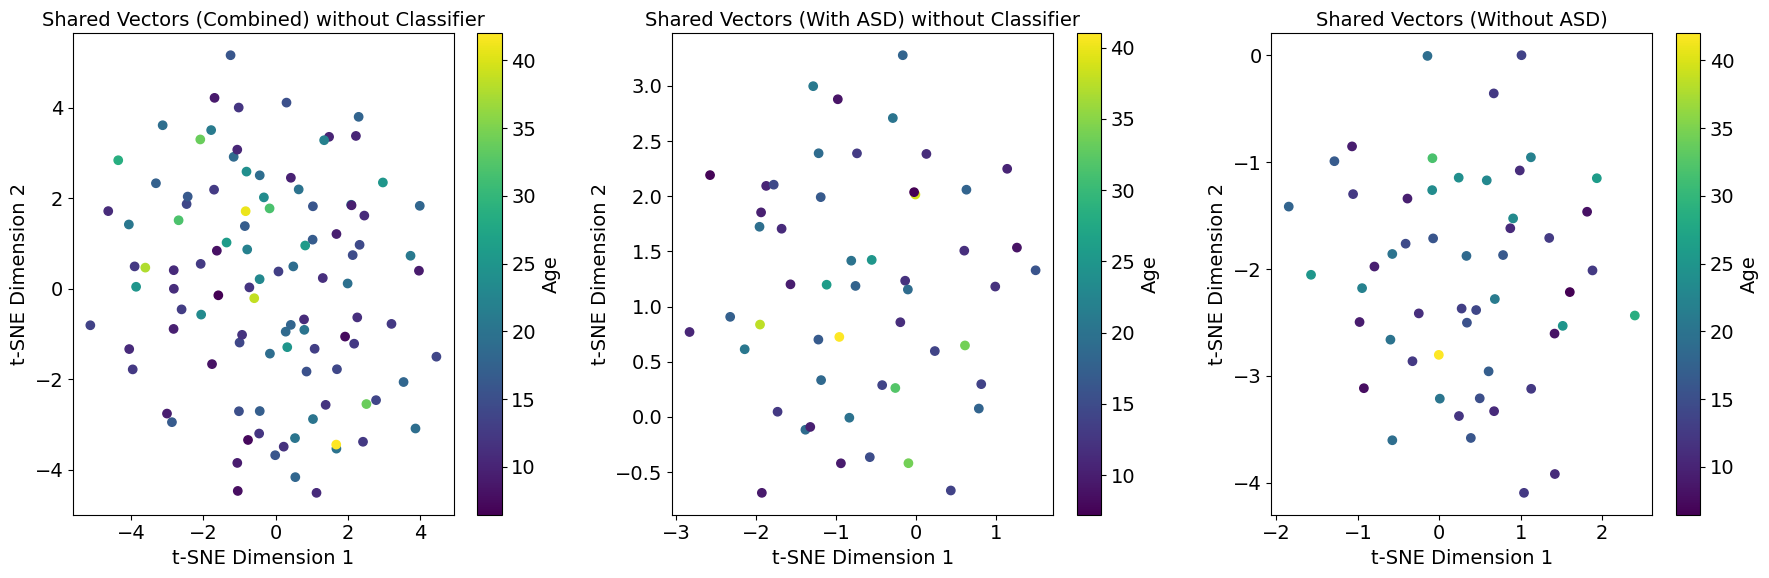

Regression results for Shared Vectors (Combined) without Classifier:
Mean Squared Error: 55.74
R-squared: 0.02


Regression results for Shared Vectors (With ASD) without Classifier:
Mean Squared Error: 64.71
R-squared: 0.02


Regression results for Shared Vectors (Without ASD):
Mean Squared Error: 46.74
R-squared: 0.01




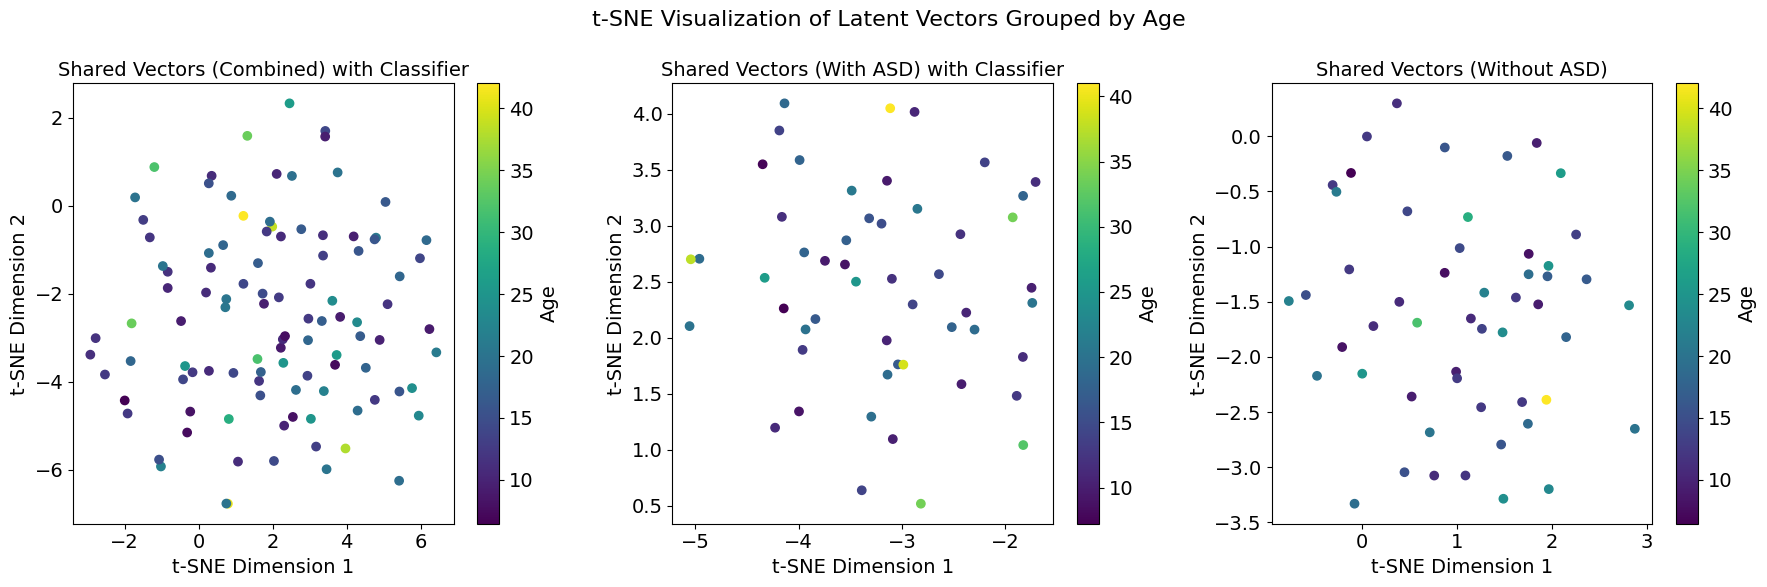

Regression results for Shared Vectors (Combined) with Classifier:
Mean Squared Error: 56.60
R-squared: 0.00


Regression results for Shared Vectors (With ASD) with Classifier:
Mean Squared Error: 65.72
R-squared: 0.00


Regression results for Shared Vectors (Without ASD):
Mean Squared Error: 44.20
R-squared: 0.07



Model Comparison

No Classifier R-squared: 0.0172
With Classifier R-squared: 0.0021
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
No Classifier R-squared: 0.0160
With Classifier R-squared: 0.0040
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
No Classifier R-squared: 0.0555
With Classifier R-squared: 0.0674
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.


(0.05550293060853706, 0.06743109202763031, 0.9999999326494495)

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Shared Vectors (Combined) without classifier
shared_vectors_combined = shared_vec["latent_vec"].detach().cpu().numpy()
shared_vectors_combined_no_ASD = shared_vec_no_ASD["latent_vec"].detach().cpu().numpy()
age_labels_combined = shared_vec["age"].detach().cpu().numpy()
age_labels_combined_no_ASD = shared_vec_no_ASD["age"].detach().cpu().numpy()

# Concatenate along samples axis
concatenated_vectors_combined = np.concatenate((shared_vectors_combined, shared_vectors_combined_no_ASD), axis=0)
concatenated_age_labels_combined = np.concatenate((age_labels_combined, age_labels_combined_no_ASD), axis=0)

tsne_shared_combined = TSNE(n_components=2, random_state=42)
tsne_result_shared_combined = tsne_shared_combined.fit_transform(concatenated_vectors_combined)
scatter_shared_combined = axs[0].scatter(tsne_result_shared_combined[:, 0], tsne_result_shared_combined[:, 1], c=concatenated_age_labels_combined, cmap="viridis")
axs[0].set_title('Shared Vectors (Combined) without Classifier')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_combined, ax=axs[0], label="Age")

# Second subplot: Shared Vectors (With ASD) without classifier
shared_vectors = shared_vec["latent_vec"].detach().cpu().numpy()
age_labels = shared_vec["age"].detach().cpu().numpy()
tsne_shared = TSNE(n_components=2, random_state=42)
tsne_result_shared = tsne_shared.fit_transform(shared_vectors)
scatter_shared = axs[1].scatter(tsne_result_shared[:, 0], tsne_result_shared[:, 1], c=age_labels, cmap="viridis")
axs[1].set_title('Shared Vectors (With ASD) without Classifier')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared, ax=axs[1], label="Age")

# Third subplot: Shared Vectors (Without ASD)
shared_vectors_no_ASD = shared_vec_no_ASD["latent_vec"].detach().cpu().numpy()
tsne_shared_no_ASD = TSNE(n_components=2, random_state=42)
tsne_result_shared_no_ASD = tsne_shared_no_ASD.fit_transform(shared_vectors_no_ASD)
scatter_shared_no_ASD = axs[2].scatter(tsne_result_shared_no_ASD[:, 0], tsne_result_shared_no_ASD[:, 1], c= age_labels_combined_no_ASD, cmap="viridis")
axs[2].set_title('Shared Vectors (Without ASD)')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_no_ASD, ax=axs[2], label="Age")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot without classifier
perform_regression(tsne_result_shared_combined, np.hstack((age_labels_combined, age_labels_combined_no_ASD)), "Shared Vectors (Combined) without Classifier")
perform_regression(tsne_result_shared, age_labels, "Shared Vectors (With ASD) without Classifier")
perform_regression(tsne_result_shared_no_ASD, age_labels_combined_no_ASD, "Shared Vectors (Without ASD)")


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Age', fontsize=16)

# First subplot: Shared Vectors (Combined) with classifier
shared_vectors_combined = shared_vec_classifier["latent_vec_classifier"].detach().cpu().numpy()
shared_vectors_combined_no_ASD = shared_vec_classifier_no_ASD["latent_vec_classifier"].detach().cpu().numpy()
age_labels_combined_classifier = shared_vec_classifier["age"].detach().cpu().numpy()
age_labels_combined_classifier_no_ASD = shared_vec_classifier_no_ASD["age"].detach().cpu().numpy()

tsne_shared_combined_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_combined_classifier = tsne_shared_combined_classifier.fit_transform(np.vstack((shared_vectors_combined, shared_vectors_combined_no_ASD)))
scatter_shared_combined_classifier = axs[0].scatter(tsne_result_shared_combined_classifier[:, 0], tsne_result_shared_combined_classifier[:, 1], c=np.vstack((age_labels_combined_classifier, age_labels_combined_classifier_no_ASD)), cmap="viridis")
axs[0].set_title('Shared Vectors (Combined) with Classifier')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_combined_classifier, ax=axs[0], label="Age")

# Second subplot: Shared Vectors (With ASD) with classifier
shared_vectors_classifier = shared_vec_classifier["latent_vec_classifier"].detach().cpu().numpy()
age_labels_classifier = shared_vec_classifier["age"].detach().cpu().numpy()
tsne_shared_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_classifier = tsne_shared_classifier.fit_transform(shared_vectors_classifier)
scatter_shared_classifier = axs[1].scatter(tsne_result_shared_classifier[:, 0], tsne_result_shared_classifier[:, 1], c=age_labels_classifier, cmap="viridis")
axs[1].set_title('Shared Vectors (With ASD) with Classifier')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_classifier, ax=axs[1], label="Age")

# Third subplot: Shared Vectors (Without ASD)
shared_vectors_classifier_no_ASD = shared_vec_classifier_no_ASD["latent_vec_classifier"].detach().cpu().numpy()
tsne_shared_classifier_no_ASD = TSNE(n_components=2, random_state=42)
tsne_result_shared_classifier_no_ASD = tsne_shared_classifier_no_ASD.fit_transform(shared_vectors_classifier_no_ASD)
scatter_shared_classifier_no_ASD = axs[2].scatter(tsne_result_shared_classifier_no_ASD[:, 0], tsne_result_shared_classifier_no_ASD[:, 1], c=age_labels_combined_classifier_no_ASD, cmap="viridis")
axs[2].set_title('Shared Vectors (Without ASD)')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_classifier_no_ASD, ax=axs[2], label="Age")

plt.tight_layout()
plt.show()

# Perform linear regression for each subplot with classifier
perform_regression(tsne_result_shared_combined_classifier, np.hstack((age_labels_combined_classifier, age_labels_combined_classifier_no_ASD)), "Shared Vectors (Combined) with Classifier")
perform_regression(tsne_result_shared_classifier, age_labels_classifier, "Shared Vectors (With ASD) with Classifier")
perform_regression(tsne_result_shared_classifier_no_ASD, age_labels_combined_classifier_no_ASD, "Shared Vectors (Without ASD)")

print("\n" + "Model Comparison" + "\n")
# Usage for comparing the regression results
perform_regression_comparison(tsne_result_shared_combined, tsne_result_shared_combined_classifier ,concatenated_age_labels_combined, "No Classifier", "With Classifier")
print("=" * 20)
perform_regression_comparison2(tsne_result_shared, tsne_result_shared_classifier, age_labels_combined_classifier, age_labels_combined_classifier_no_ASD,  "No Classifier", "With Classifier")
print("=" * 20)
perform_regression_comparison2(tsne_result_shared_no_ASD, tsne_result_shared_classifier_no_ASD, age_labels_combined_classifier, age_labels_combined_classifier_no_ASD,  "No Classifier", "With Classifier")


=== t-SNE Visualization of Latent Vectors Grouped by Gender ===

Accuracy of the logistic regression model (t-SNE Stacked Vectors with Classifier): 0.85


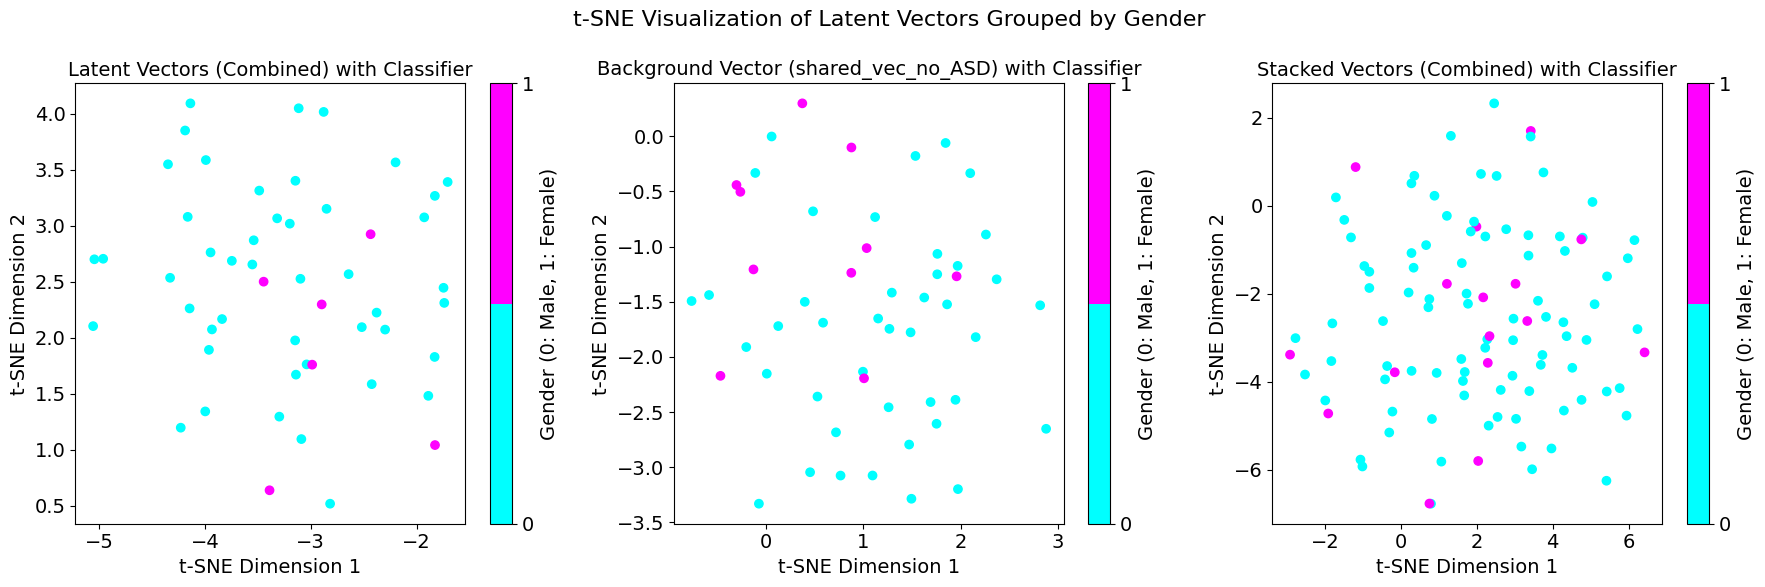


=== t-SNE Visualization of Latent Vectors Grouped by Gender ===



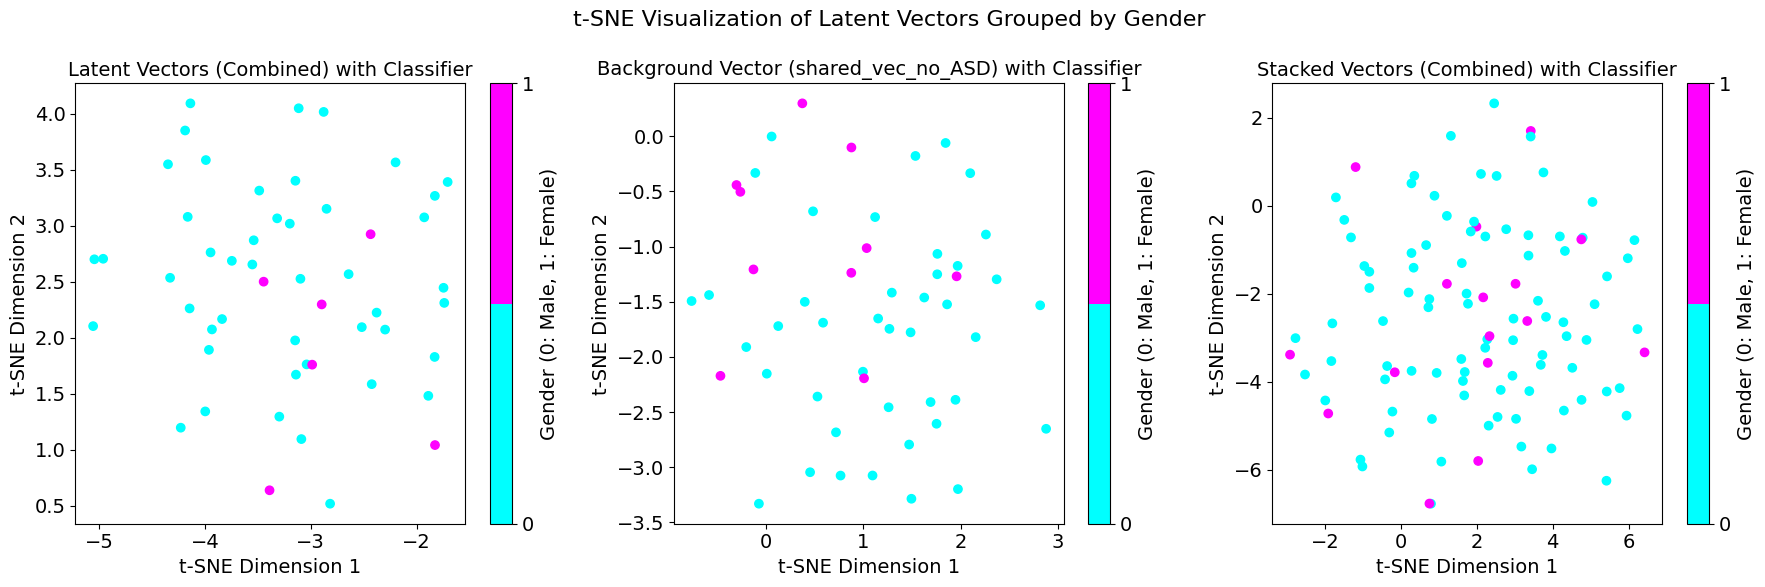

Accuracy of the logistic regression model (t-SNE Stacked Vectors with Classifier): 0.85


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Headline for Gender
print("\n=== t-SNE Visualization of Latent Vectors Grouped by Gender ===\n")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Change the 1, 3 for the subplot layout

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Gender', fontsize=16)

# First subplot: Latent Vectors (shared_vec_classifier) with classifier
shared_vectors_classifier = shared_vec_classifier["latent_vec_classifier"].detach().cpu().numpy()
tsne_shared_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_classifier = tsne_shared_classifier.fit_transform(shared_vectors_classifier)
cmap = plt.cm.get_cmap("cool", 2)
scatter_shared_classifier = axs[0].scatter(tsne_result_shared_classifier[:, 0], tsne_result_shared_classifier[:, 1], c=shared_vec_classifier["gender"], cmap=cmap)  # Changed axs[0, 0] to axs[0]
axs[0].set_title('Latent Vectors (Combined) with Classifier')  # Changed axs[0, 0] to axs[0]
axs[0].set_xlabel('t-SNE Dimension 1')  # Changed axs[0, 0] to axs[0]
axs[0].set_ylabel('t-SNE Dimension 2')  # Changed axs[0, 0] to axs[0]
fig.colorbar(scatter_shared_classifier, ax=axs[0], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)  # Changed ax=axs[0, 0] to ax=axs[0]

# Second subplot: Shared Vectors (shared_vec_classifier_no_ASD) with classifier
shared_vectors_no_ASD_classifier = shared_vec_classifier_no_ASD["latent_vec_classifier"].detach().cpu().numpy()
tsne_shared_no_ASD_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_no_ASD_classifier = tsne_shared_no_ASD_classifier.fit_transform(shared_vectors_no_ASD_classifier)
scatter_shared_no_ASD_classifier = axs[1].scatter(tsne_result_shared_no_ASD_classifier[:, 0], tsne_result_shared_no_ASD_classifier[:, 1], c=shared_vec_classifier_no_ASD["gender"], cmap=cmap)  # Changed axs[0, 1] to axs[1]
axs[1].set_title('Shared Vector (shared_vec_no_ASD) with Classifier')  # Changed axs[0, 1] to axs[1]
axs[1].set_xlabel('t-SNE Dimension 1')  # Changed axs[0, 1] to axs[1]
axs[1].set_ylabel('t-SNE Dimension 2')  # Changed axs[0, 1] to axs[1]
fig.colorbar(scatter_shared_no_ASD_classifier, ax=axs[1], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)  # Changed ax=axs[0, 1] to ax=axs[1]

# Third subplot: Stacked Vectors (shared_vec_classifier and shared_vec_classifier_no_ASD) with classifier
stacked_vectors_classifier = np.vstack((shared_vectors_classifier, shared_vectors_no_ASD_classifier))
tsne_stacked_classifier = TSNE(n_components=2, random_state=42)
tsne_result_stacked_classifier = tsne_stacked_classifier.fit_transform(stacked_vectors_classifier)
scatter_stacked_classifier = axs[2].scatter(tsne_result_stacked_classifier[:, 0], tsne_result_stacked_classifier[:, 1], c=np.hstack((shared_vec_classifier["gender"], shared_vec_classifier_no_ASD["gender"])), cmap=cmap)  # Changed axs[1, 0] to axs[2]
axs[2].set_title('Stacked Vectors (Combined) with Classifier')  # Changed axs[1, 0] to axs[2]
axs[2].set_xlabel('t-SNE Dimension 1')  # Changed axs[1, 0] to axs[2]
axs[2].set_ylabel('t-SNE Dimension 2')  # Changed axs[1, 0] to axs[2]
fig.colorbar(scatter_stacked_classifier, ax=axs[2], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)  # Changed ax=axs[1, 0] to ax=axs[2]

logistic_model_stacked_classifier = LogisticRegression(random_state=42)
logistic_model_stacked_classifier.fit(tsne_result_stacked_classifier, np.hstack((shared_vec_classifier["gender"], shared_vec_classifier_no_ASD["gender"])))
y_pred_stacked_classifier = logistic_model_stacked_classifier.predict(tsne_result_stacked_classifier)
accuracy_stacked_classifier = accuracy_score(np.hstack((shared_vec_classifier["gender"], shared_vec_classifier_no_ASD["gender"])), y_pred_stacked_classifier)
print(f"Accuracy of the logistic regression model (t-SNE Stacked Vectors with Classifier): {accuracy_stacked_classifier:.2f}")

plt.tight_layout()
plt.show()



# Headline for Gender
print("\n=== t-SNE Visualization of Latent Vectors Grouped by Gender ===\n")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Gender', fontsize=16)

# First subplot: Latent Vectors (shared_vec_classifier) with classifier
shared_vectors_classifier = shared_vec_classifier["latent_vec_classifier"].detach().cpu().numpy()
tsne_shared_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_classifier = tsne_shared_classifier.fit_transform(shared_vectors_classifier)
cmap = plt.cm.get_cmap("cool", 2)
scatter_shared_classifier = axs[0].scatter(tsne_result_shared_classifier[:, 0], tsne_result_shared_classifier[:, 1], c=shared_vec_classifier["gender"], cmap=cmap)
axs[0].set_title('Latent Vectors (Combined) with Classifier')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_classifier, ax=axs[0], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Second subplot: Shared Vectors (shared_vec_classifier_no_ASD) with classifier
shared_vectors_no_ASD_classifier = shared_vec_classifier_no_ASD["latent_vec_classifier"].detach().cpu().numpy()
tsne_shared_no_ASD_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_no_ASD_classifier = tsne_shared_no_ASD_classifier.fit_transform(shared_vectors_no_ASD_classifier)
scatter_shared_no_ASD_classifier = axs[1].scatter(tsne_result_shared_no_ASD_classifier[:, 0], tsne_result_shared_no_ASD_classifier[:, 1], c=shared_vec_classifier_no_ASD["gender"], cmap=cmap)
axs[1].set_title('Shared Vector (shared_vec_no_ASD) with Classifier')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_no_ASD_classifier, ax=axs[1], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Third subplot: Stacked Vectors (shared_vec_classifier and shared_vec_classifier_no_ASD) with classifier
stacked_vectors_classifier = np.vstack((shared_vectors_classifier, shared_vectors_classifier_no_ASD))
tsne_stacked_classifier = TSNE(n_components=2, random_state=42)
tsne_result_stacked_classifier = tsne_stacked_classifier.fit_transform(stacked_vectors_classifier)
scatter_stacked_classifier = axs[2].scatter(tsne_result_stacked_classifier[:, 0], tsne_result_stacked_classifier[:, 1], c=np.hstack((shared_vec_classifier["gender"], shared_vec_classifier_no_ASD["gender"])), cmap=cmap)
axs[2].set_title('Stacked Vectors (Combined) with Classifier')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_stacked_classifier, ax=axs[2], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

plt.tight_layout()
plt.show()

logistic_model_stacked_classifier = LogisticRegression(random_state=42)
logistic_model_stacked_classifier.fit(tsne_result_stacked_classifier, np.hstack((shared_vec_classifier["gender"], shared_vec_classifier_no_ASD["gender"])))
y_pred_stacked_classifier = logistic_model_stacked_classifier.predict(tsne_result_stacked_classifier)
accuracy_stacked_classifier = accuracy_score(np.hstack((shared_vec_classifier["gender"], shared_vec_classifier_no_ASD["gender"])), y_pred_stacked_classifier)
print(f"Accuracy of the logistic regression model (t-SNE Stacked Vectors with Classifier): {accuracy_stacked_classifier:.2f}")



FIQ


=== t-SNE Visualization of Latent Vectors Grouped by FIQ (Intelligence Score) ===



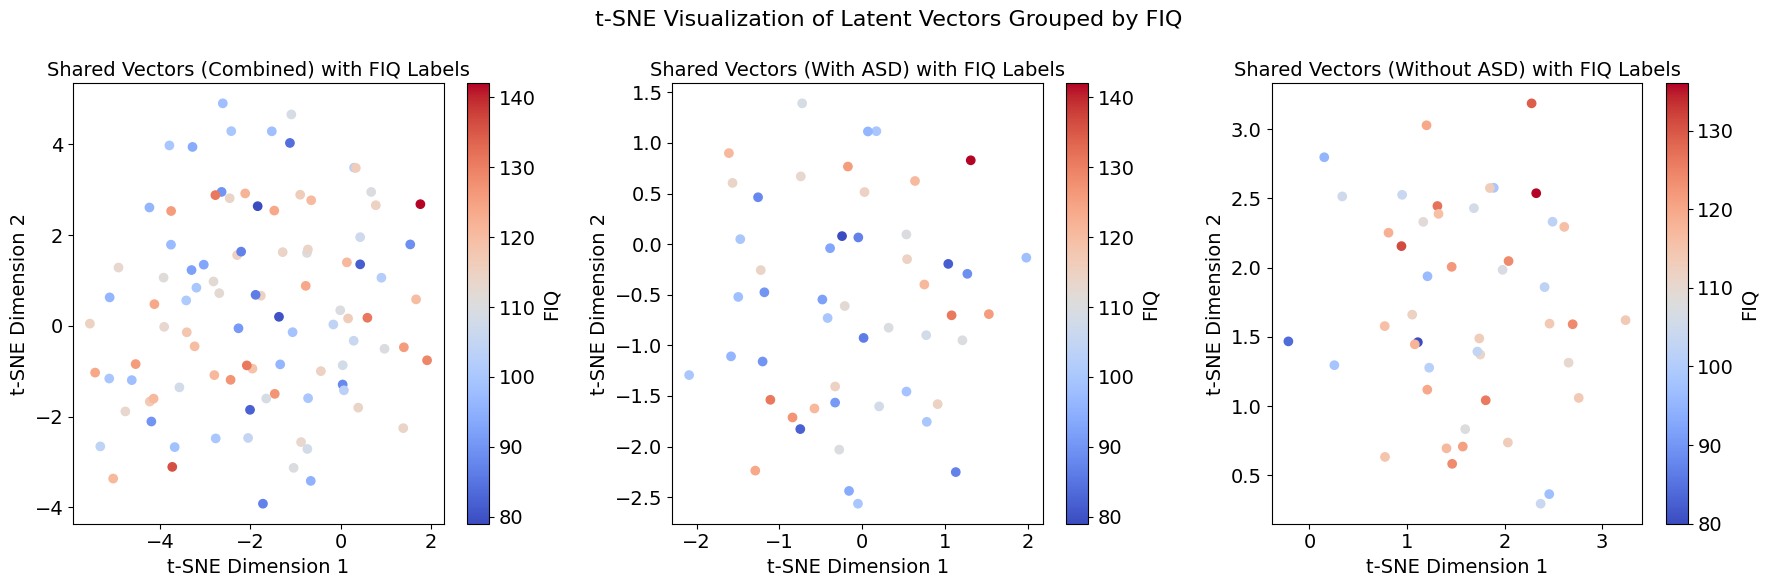

Regression results for Shared Vectors (Combined) with FIQ Labels:
Mean Squared Error: 184.95
R-squared: 0.01


Regression results for Shared Vectors (With ASD) with FIQ Labels:
Mean Squared Error: 213.01
R-squared: 0.02


Regression results for Shared Vectors (Without ASD) with FIQ Labels:
Mean Squared Error: 121.68
R-squared: 0.10



=== t-SNE Visualization of Latent Vectors Grouped by FIQ (Intelligence Score) ===



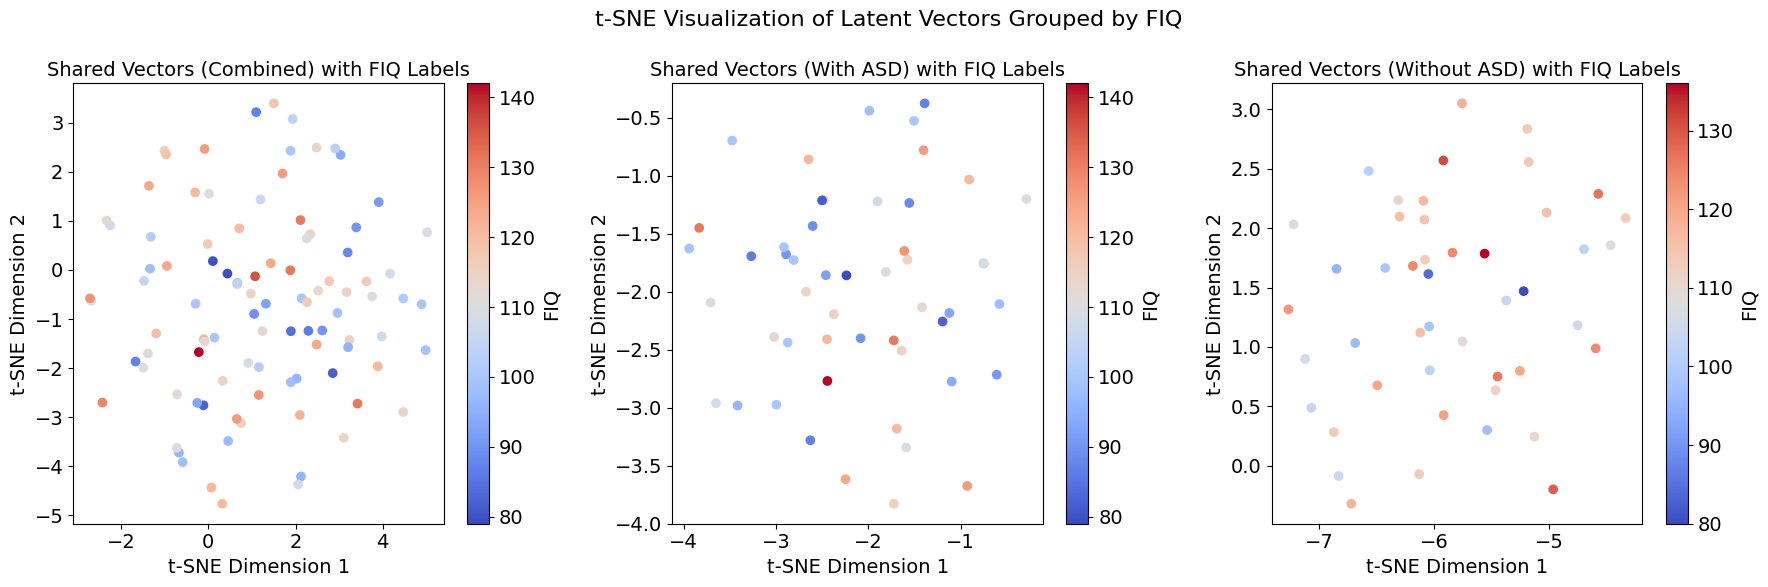

Regression results for Shared Vectors (Combined) with FIQ Labels:
Mean Squared Error: 182.86
R-squared: 0.02


Regression results for Shared Vectors (With ASD) with FIQ Labels:
Mean Squared Error: 209.92
R-squared: 0.03


Regression results for Shared Vectors (Without ASD) with FIQ Labels:
Mean Squared Error: 130.27
R-squared: 0.03



Model Comparison

No Classifier R-squared: 0.0115
With Classifier R-squared: 0.0226
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
No Classifier R-squared: 0.0200
With Classifier R-squared: 0.0342
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.
No Classifier R-squared: 0.0950
With Classifier R-squared: 0.0312
P-value for difference: 1.0000
The difference in R-squared values is not statistically significant.


(0.09503099108090651, 0.03115063885752023, 0.9999961179441773)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by FIQ (Intelligence Score) ===\n")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by FIQ', fontsize=16)

# Filter data for FIQ
indices_to_remove = find_non_numeric_indices(shared_vec["FIQ"].tolist())
indices_to_remove_no_ASD = find_non_numeric_indices(shared_vec_no_ASD["FIQ"].tolist())
shared_vectors_combined = shared_vec["latent_vec"].detach().cpu().numpy()
shared_vectors_combined_no_ASD = shared_vec_no_ASD["latent_vec"].detach().cpu().numpy()
fiq_labels_combined = shared_vec["FIQ"].detach().cpu().numpy()
fiq_labels_combined_no_ASD = shared_vec_no_ASD["FIQ"].detach().cpu().numpy()



# Remove entries with missing values
shared_vectors_combined = np.delete(shared_vectors_combined, indices_to_remove, axis=0)
shared_vectors_combined_no_ASD = np.delete(shared_vectors_combined_no_ASD, indices_to_remove_no_ASD, axis=0)
fiq_labels_combined = np.delete(fiq_labels_combined, indices_to_remove, axis=0)
fiq_labels_combined_no_ASD = np.delete(fiq_labels_combined_no_ASD, indices_to_remove_no_ASD, axis=0)
concatenated_fiq_labels_combined = np.concatenate((fiq_labels_combined, fiq_labels_combined_no_ASD), axis=0)
fiq_labels_combined_no_ASD_short = fiq_labels_combined_no_ASD
fiq_labels_combined_short = fiq_labels_combined
fiq_labels_combined_no_ASD = fiq_labels_combined_no_ASD[:, np.newaxis]
fiq_labels_combined = fiq_labels_combined[:, np.newaxis]

# t-SNE on shared vectors with FIQ labels
tsne_shared_combined = TSNE(n_components=2, random_state=42)
tsne_result_shared_combined = tsne_shared_combined.fit_transform(np.vstack((shared_vectors_combined, shared_vectors_combined_no_ASD)))
scatter_shared_combined = axs[0].scatter(tsne_result_shared_combined[:, 0], tsne_result_shared_combined[:, 1], c=np.vstack((fiq_labels_combined, fiq_labels_combined_no_ASD)), cmap="coolwarm")
axs[0].set_title('Shared Vectors (Combined) with FIQ Labels')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_combined, ax=axs[0], label="FIQ")

# t-SNE on shared vectors (With ASD) with FIQ labels
tsne_shared = TSNE(n_components=2, random_state=42)
tsne_result_shared = tsne_shared.fit_transform(shared_vectors_combined)
scatter_shared = axs[1].scatter(tsne_result_shared[:, 0], tsne_result_shared[:, 1], c=fiq_labels_combined, cmap="coolwarm")
axs[1].set_title('Shared Vectors (With ASD) with FIQ Labels')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared, ax=axs[1], label="FIQ")

# t-SNE on shared vectors (Without ASD) with FIQ labels
tsne_shared_no_ASD = TSNE(n_components=2, random_state=42)
tsne_result_shared_no_ASD = tsne_shared_no_ASD.fit_transform(shared_vectors_combined_no_ASD)
scatter_shared_no_ASD = axs[2].scatter(tsne_result_shared_no_ASD[:, 0], tsne_result_shared_no_ASD[:, 1], c=fiq_labels_combined_no_ASD, cmap="coolwarm")
axs[2].set_title('Shared Vectors (Without ASD) with FIQ Labels')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_no_ASD, ax=axs[2], label="FIQ")

plt.tight_layout()
plt.show()

perform_regression(tsne_result_shared_combined, np.vstack((fiq_labels_combined, fiq_labels_combined_no_ASD)), "Shared Vectors (Combined) with FIQ Labels")
perform_regression(tsne_result_shared, fiq_labels_combined, "Shared Vectors (With ASD) with FIQ Labels")
perform_regression(tsne_result_shared_no_ASD, fiq_labels_combined_no_ASD, "Shared Vectors (Without ASD) with FIQ Labels")

# Headline for FIQ
print("\n=== t-SNE Visualization of Latent Vectors Grouped by FIQ (Intelligence Score) ===\n")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by FIQ', fontsize=16)

# Filter data for FIQ
indices_to_remove = find_non_numeric_indices(shared_vec_classifier["FIQ"].tolist())
indices_to_remove_no_ASD = find_non_numeric_indices(shared_vec_classifier_no_ASD["FIQ"].tolist())
shared_vectors_combined_classifier = shared_vec_classifier["latent_vec_classifier"].detach().cpu().numpy()
shared_vectors_combined_no_ASD_classifier = shared_vec_classifier_no_ASD["latent_vec_classifier"].detach().cpu().numpy()
fiq_labels_combined_classifier = shared_vec_classifier["FIQ"].detach().cpu().numpy()
fiq_labels_combined_no_ASD_classifier = shared_vec_classifier_no_ASD["FIQ"].detach().cpu().numpy()


# Remove entries with missing values
shared_vectors_combined_classifier = np.delete(shared_vectors_combined_classifier, indices_to_remove, axis=0)
shared_vectors_combined_no_ASD_classifier = np.delete(shared_vectors_combined_no_ASD_classifier, indices_to_remove_no_ASD, axis=0)
fiq_labels_combined_classifier = np.delete(fiq_labels_combined_classifier, indices_to_remove, axis=0)
fiq_labels_combined_no_ASD_classifier = np.delete(fiq_labels_combined_no_ASD_classifier, indices_to_remove_no_ASD, axis=0)
fiq_labels_combined_no_ASD_classifier_short = fiq_labels_combined_no_ASD_classifier
fiq_labels_combined_classifier_short = fiq_labels_combined_classifier
fiq_labels_combined_no_ASD_classifier = fiq_labels_combined_no_ASD_classifier[:, np.newaxis]
fiq_labels_combined_classifier = fiq_labels_combined_classifier[:, np.newaxis]


# t-SNE on shared vectors with FIQ labels
tsne_shared_combined_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_combined_classifier = tsne_shared_combined_classifier.fit_transform(np.vstack((shared_vectors_combined_classifier, shared_vectors_combined_no_ASD_classifier)))
scatter_shared_combined_classifier = axs[0].scatter(tsne_result_shared_combined_classifier[:, 0], tsne_result_shared_combined_classifier[:, 1], c=np.vstack((fiq_labels_combined_classifier, fiq_labels_combined_no_ASD_classifier)), cmap="coolwarm")
axs[0].set_title('Shared Vectors (Combined) with FIQ Labels')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_combined_classifier, ax=axs[0], label="FIQ")

# t-SNE on shared vectors (With ASD) with FIQ labels
tsne_shared_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_classifier = tsne_shared_classifier.fit_transform(shared_vectors_combined_classifier)
scatter_shared_classifier = axs[1].scatter(tsne_result_shared_classifier[:, 0], tsne_result_shared_classifier[:, 1], c=fiq_labels_combined_classifier, cmap="coolwarm")
axs[1].set_title('Shared Vectors (With ASD) with FIQ Labels')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_classifier, ax=axs[1], label="FIQ")

# t-SNE on shared vectors (Without ASD) with FIQ labels
tsne_shared_no_ASD_classifier = TSNE(n_components=2, random_state=42)
tsne_result_shared_no_ASD_classifier = tsne_shared_no_ASD_classifier.fit_transform(shared_vectors_combined_no_ASD_classifier)
scatter_shared_no_ASD_classifier = axs[2].scatter(tsne_result_shared_no_ASD_classifier[:, 0], tsne_result_shared_no_ASD_classifier[:, 1], c=fiq_labels_combined_no_ASD_classifier, cmap="coolwarm")
axs[2].set_title('Shared Vectors (Without ASD) with FIQ Labels')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_shared_no_ASD_classifier, ax=axs[2], label="FIQ")

plt.tight_layout()
plt.show()


perform_regression(tsne_result_shared_combined_classifier, np.vstack((fiq_labels_combined_classifier, fiq_labels_combined_no_ASD_classifier)), "Shared Vectors (Combined) with FIQ Labels")
perform_regression(tsne_result_shared_classifier, fiq_labels_combined_classifier, "Shared Vectors (With ASD) with FIQ Labels")
perform_regression(tsne_result_shared_no_ASD_classifier, fiq_labels_combined_no_ASD_classifier, "Shared Vectors (Without ASD) with FIQ Labels")

print("\n" + "Model Comparison" + "\n")
# Usage for comparing the regression results
perform_regression_comparison(tsne_result_shared_combined, tsne_result_shared_combined_classifier, concatenated_fiq_labels_combined, "No Classifier", "With Classifier")
print("=" * 20)
perform_regression_comparison2(tsne_result_shared, tsne_result_shared_classifier, fiq_labels_combined_short, fiq_labels_combined_classifier_short,  "No Classifier", "With Classifier")
print("=" * 20)
perform_regression_comparison2(tsne_result_shared_no_ASD, tsne_result_shared_no_ASD_classifier, fiq_labels_combined_no_ASD_short, fiq_labels_combined_no_ASD_classifier_short,  "No Classifier", "With Classifier")



## Classification Performance

Here, R² and the mean age deviation is computed.

In [ ]:
from sklearn.metrics import r2_score
from statsmodels.stats.proportion import proportion_confint

# Initialize lists to store accuracy values and participant counts
accuracy_values = []
participant_counts = []

r2_values = []

# Initialize lists to store true labels and predicted labels for age
true_labels_autism_age = []
predicted_labels_autism_age = []
true_labels_no_autism_age = []
predicted_labels_no_autism_age = []

# Initialize a list to store all actual ages
all_actual_ages = []
# Set the model to evaluation mode
model_classifier.eval()
batch_iterator = iter(train_dataloader_no_batch)

# Iterate through the validation dataloader
for batch in batch_iterator:
    ((autism_data, autism_age, _, _, _, _, _, _, autism_sub_id), (no_autism_data, no_autism_age, _, _, _, no_autism_sub_id)) = batch

    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate predictions using the trained model
    _, _, _, _, _, _, _, _, class_autism_age, class_no_autism_age, _, _, _ = model_classifier(autism_data, no_autism_data)

    # Append true and predicted labels for autism group
    true_labels_autism_age.extend([val for val in autism_age.cpu().detach().numpy()])
    predicted_labels_autism_age.extend([val for val in class_autism_age.cpu().detach().numpy()])

    # Append true and predicted labels for no autism group
    true_labels_no_autism_age.extend([val for val in no_autism_age.cpu().detach().numpy()])
    predicted_labels_no_autism_age.extend([val for val in class_no_autism_age.cpu().detach().numpy()])

    all_actual_ages.extend([val for val in autism_age.cpu().detach().numpy()])
    all_actual_ages.extend([val for val in no_autism_age.cpu().detach().numpy()])

# Age computations:
# Calculate accuracy for participants with autism
accuracy_autism = np.abs(np.array(true_labels_autism_age) - np.array(predicted_labels_autism_age)).mean()

# Calculate accuracy for participants without autism
accuracy_no_autism = np.abs(np.array(true_labels_no_autism_age) - np.array(predicted_labels_no_autism_age)).mean()

# Calculate the total number of participants
num_participants = len(true_labels_autism_age) + len(true_labels_no_autism_age)

# Append accuracy and participant count to the lists
accuracy_values.append((accuracy_autism + accuracy_no_autism) / 2)  # Average accuracy for both groups
participant_counts.append(num_participants)

# Calculate R-squared for participants with autism
r2_autism = r2_score(true_labels_autism_age, predicted_labels_autism_age)
r2_values.append(r2_autism)

# Calculate R-squared for participants without autism
r2_no_autism = r2_score(true_labels_no_autism_age, predicted_labels_no_autism_age)
r2_values.append(r2_no_autism)

# Compute the standard deviation of actual ages
std_deviation_actual_ages = np.std(all_actual_ages)

# Compute the grand mean accuracy
weighted_sum = sum(accuracy * count for accuracy, count in zip(accuracy_values, participant_counts))
total_participants = sum(participant_counts)
grand_mean_accuracy = weighted_sum / total_participants

# Compute the grand mean R-squared
grand_mean_r2 = np.mean(r2_values)

# Calculate confidence interval for accuracy (e.g., 95% confidence)
proportions = [accuracy / 100.0 for accuracy in accuracy_values]
ci_accuracy = proportion_confint(sum(proportions), len(proportions), alpha=0.05, method='wilson')

# Calculate confidence interval for R-squared (e.g., 95% confidence)
lower_bound_r2 = np.percentile(r2_values, 2.5)
upper_bound_r2 = np.percentile(r2_values, 97.5)
ci_r2 = (lower_bound_r2, upper_bound_r2)

# Print results
print("Results for Age Prediction:")
print("-" * 30)
print("Standard Deviation of Actual Ages:", std_deviation_actual_ages)
print("Grand Mean Accuracy (Age Prediction):", grand_mean_accuracy)
print("Grand Mean R-squared (Age Prediction):", grand_mean_r2)


Results for Age Prediction:
------------------------------
Standard Deviation of Actual Ages: 7.8695884
Grand Mean Accuracy (Age Prediction): 6.093780517578125
Grand Mean R-squared (Age Prediction): 0.07930209149932538


Next the sample used for validation

In [ ]:
from sklearn.metrics import r2_score
from statsmodels.stats.proportion import proportion_confint

# Initialize lists to store accuracy values and participant counts
accuracy_values = []
participant_counts = []

r2_values = []

# Initialize lists to store true labels and predicted labels for age
true_labels_autism_age = []
predicted_labels_autism_age = []
true_labels_no_autism_age = []
predicted_labels_no_autism_age = []

# Initialize a list to store all actual ages
all_actual_ages = []

# Set the model to evaluation mode
model_classifier.eval()
batch_iterator = iter(val_dataloader_no_batch)

# Iterate through the validation dataloader
for batch in batch_iterator:
    ((autism_data, autism_age, _, _, _, _, _, _, autism_sub_id), (no_autism_data, no_autism_age, _, _, _, no_autism_sub_id)) = batch

    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate predictions using the trained model
    _, _, _, _, _, _, _, _, class_autism_age, class_no_autism_age, _, _, _ = model_classifier(autism_data, no_autism_data)

    # Append true and predicted labels for autism group
    true_labels_autism_age.extend([val for val in autism_age.cpu().detach().numpy()])
    predicted_labels_autism_age.extend([val for val in class_autism_age.cpu().detach().numpy()])

    # Append true and predicted labels for no autism group
    true_labels_no_autism_age.extend([val for val in no_autism_age.cpu().detach().numpy()])
    predicted_labels_no_autism_age.extend([val for val in class_no_autism_age.cpu().detach().numpy()])

    all_actual_ages.extend([val for val in autism_age.cpu().detach().numpy()])
    all_actual_ages.extend([val for val in no_autism_age.cpu().detach().numpy()])

# Age computations:
# Calculate accuracy for participants with autism
accuracy_autism = np.abs(np.array(true_labels_autism_age) - np.array(predicted_labels_autism_age)).mean()

# Calculate accuracy for participants without autism
accuracy_no_autism = np.abs(np.array(true_labels_no_autism_age) - np.array(predicted_labels_no_autism_age)).mean()

# Calculate the total number of participants
num_participants = len(true_labels_autism_age) + len(true_labels_no_autism_age)

# Append accuracy and participant count to the lists
accuracy_values.append((accuracy_autism + accuracy_no_autism) / 2)  # Average accuracy for both groups
participant_counts.append(num_participants)

# Calculate R-squared for participants with autism
r2_autism = r2_score(true_labels_autism_age, predicted_labels_autism_age)
r2_values.append(r2_autism)

# Calculate R-squared for participants without autism
r2_no_autism = r2_score(true_labels_no_autism_age, predicted_labels_no_autism_age)
r2_values.append(r2_no_autism)

# Compute the standard deviation of actual ages
std_deviation_actual_ages = np.std(all_actual_ages)

# Compute the grand mean accuracy
weighted_sum = sum(accuracy * count for accuracy, count in zip(accuracy_values, participant_counts))
total_participants = sum(participant_counts)
grand_mean_accuracy = weighted_sum / total_participants

# Compute the grand mean R-squared
grand_mean_r2 = np.mean(r2_values)

# Calculate confidence interval for accuracy (e.g., 95% confidence)
proportions = [accuracy / 100.0 for accuracy in accuracy_values]
ci_accuracy = proportion_confint(sum(proportions), len(proportions), alpha=0.05, method='wilson')

# Calculate confidence interval for R-squared (e.g., 95% confidence)
lower_bound_r2 = np.percentile(r2_values, 2.5)
upper_bound_r2 = np.percentile(r2_values, 97.5)
ci_r2 = (lower_bound_r2, upper_bound_r2)

# Print results
print("Results for Age Prediction:")
print("-" * 30)
print("Standard Deviation of Actual Ages:", std_deviation_actual_ages)
print("Grand Mean Accuracy (Age Prediction):", grand_mean_accuracy)
print("Grand Mean R-squared (Age Prediction):", grand_mean_r2)


Results for Age Prediction:
------------------------------
Standard Deviation of Actual Ages: 8.162741
Grand Mean Accuracy (Age Prediction): 6.38936710357666
Grand Mean R-squared (Age Prediction): -0.009667212645940892


Next the test-set!

In [ ]:
from sklearn.metrics import r2_score
from statsmodels.stats.proportion import proportion_confint

# Initialize lists to store accuracy values and participant counts
accuracy_values = []
participant_counts = []

r2_values = []

# Initialize lists to store true labels and predicted labels for age
true_labels_autism_age = []
predicted_labels_autism_age = []
true_labels_no_autism_age = []
predicted_labels_no_autism_age = []

all_actual_ages = []

# Set the model to evaluation mode
model_classifier.eval()
batch_iterator = iter(test_dataloader_no_batch)

# Iterate through the validation dataloader
for batch in batch_iterator:
    ((autism_data, autism_age, _, _, _, _, _, _, autism_sub_id), (no_autism_data, no_autism_age, _, _, _, no_autism_sub_id)) = batch

    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate predictions using the trained model
    _, _, _, _, _, _, _, _, class_autism_age, class_no_autism_age, _, _, _ = model_classifier(autism_data, no_autism_data)

    # Append true and predicted labels for autism group
    true_labels_autism_age.extend([val for val in autism_age.cpu().detach().numpy()])
    predicted_labels_autism_age.extend([val for val in class_autism_age.cpu().detach().numpy()])

    # Append true and predicted labels for no autism group
    true_labels_no_autism_age.extend([val for val in no_autism_age.cpu().detach().numpy()])
    predicted_labels_no_autism_age.extend([val for val in class_no_autism_age.cpu().detach().numpy()])

    all_actual_ages.extend([val for val in autism_age.cpu().detach().numpy()])
    all_actual_ages.extend([val for val in no_autism_age.cpu().detach().numpy()])

# Age computations:
# Calculate accuracy for participants with autism
accuracy_autism = np.abs(np.array(true_labels_autism_age) - np.array(predicted_labels_autism_age)).mean()

# Calculate accuracy for participants without autism
accuracy_no_autism = np.abs(np.array(true_labels_no_autism_age) - np.array(predicted_labels_no_autism_age)).mean()

# Calculate the total number of participants
num_participants = len(true_labels_autism_age) + len(true_labels_no_autism_age)

# Append accuracy and participant count to the lists
accuracy_values.append((accuracy_autism + accuracy_no_autism) / 2)  # Average accuracy for both groups
participant_counts.append(num_participants)

# Calculate R-squared for participants with autism
r2_autism = r2_score(true_labels_autism_age, predicted_labels_autism_age)
r2_values.append(r2_autism)

# Calculate R-squared for participants without autism
r2_no_autism = r2_score(true_labels_no_autism_age, predicted_labels_no_autism_age)
r2_values.append(r2_no_autism)

# Compute the standard deviation of actual ages
std_deviation_actual_ages = np.std(all_actual_ages)

# Compute the grand mean accuracy
weighted_sum = sum(accuracy * count for accuracy, count in zip(accuracy_values, participant_counts))
total_participants = sum(participant_counts)
grand_mean_accuracy = weighted_sum / total_participants

# Compute the grand mean R-squared
grand_mean_r2 = np.mean(r2_values)

# Calculate confidence interval for accuracy (e.g., 95% confidence)
proportions = [accuracy / 100.0 for accuracy in accuracy_values]
ci_accuracy = proportion_confint(sum(proportions), len(proportions), alpha=0.05, method='wilson')

# Calculate confidence interval for R-squared (e.g., 95% confidence)
lower_bound_r2 = np.percentile(r2_values, 2.5)
upper_bound_r2 = np.percentile(r2_values, 97.5)
ci_r2 = (lower_bound_r2, upper_bound_r2)

# Print results
print("Results for Age Prediction:")
print("-" * 30)
print("Standard Deviation of Actual Ages:", std_deviation_actual_ages)
print("Grand Mean Accuracy (Age Prediction):", grand_mean_accuracy)
print("Grand Mean R-squared (Age Prediction):", grand_mean_r2)


Results for Age Prediction:
------------------------------
Standard Deviation of Actual Ages: 7.5313225
Grand Mean Accuracy (Age Prediction): 6.291749477386475
Grand Mean R-squared (Age Prediction): 0.11815375429191738


## Cortical Thickness Analyses

To plot the differences in cortical thickness, I first need to generate cortical thickness measures. For this, I am interested specifically interested in what the "ASD" part of the model will do. Thus, what difference in cortical thickness arises when turning the specific encoder on!

Firstly we generate latent vectors per participant. We run them through the encoder. They should be appended to a dictionary where each participant has an entry. The resulting lists from the decoder will be appended as sublists.

In [ ]:
# Initialize dictionaries to store reconstructed data for each encoder
reconstructed_data_encoder_z0 = {}
reconstructed_data_encoder_zs = {}

# Set the model to evaluation mode
model_classifier.eval()
batch_iterator = iter(val_dataloader_no_batch)
batch = next(batch_iterator)

# Iterate through the validation dataloader
for i in range(1, 10):
    ((autism_data, autism_age, autism_gender, autism_diag_group, _,_,_,_,autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,no_autism_sub_id)) = batch
    batch_size = autism_data.shape[0]
    autism_data = autism_data.to(device)
    # Compute the reconstructed data for encoder_z
    z_mean, z_log_var = model_classifier.encoder_z(autism_data, batch_size)
    latent_z = model_classifier.reparameterize(z_mean, z_log_var)

    # Compute the reconstructed data for encoder_s
    s_mean, s_log_var = model_classifier.encoder_s(autism_data, batch_size)
    latent_s = model_classifier.reparameterize(s_mean, s_log_var)

    latent_zs = torch.cat([latent_z, latent_s], dim=1)
    reconstructed_data_batch_zs = model_classifier.decoder(latent_zs, batch_size).detach()

    latent_z_0 = torch.cat([latent_z, torch.zeros_like(latent_z)], dim=1)
    reconstructed_data_batch_z0 = model_classifier.decoder(latent_z_0, batch_size).detach()

    # Update the dictionaries for encoder_z and encoder_s
    for sub_id, recon_data_zs, recon_data_z0 in zip(autism_sub_id, reconstructed_data_batch_zs, reconstructed_data_batch_z0):
        if sub_id not in reconstructed_data_encoder_zs:
            reconstructed_data_encoder_zs[sub_id] = []
        if sub_id not in reconstructed_data_encoder_z0:
            reconstructed_data_encoder_z0[sub_id] = []
        reconstructed_data_encoder_zs[sub_id].append(recon_data_zs)
        reconstructed_data_encoder_z0[sub_id].append(recon_data_z0)


Let's get an average per participant

In [ ]:
# Initialize dictionaries to store averaged reconstructed data for each encoder
averaged_reconstructed_data_encoder_z0 = {}
averaged_reconstructed_data_encoder_zs = {}

# Iterate through the dictionaries of reconstructed data
for sub_id, recon_data_zs_list, recon_data_z0_list in zip(reconstructed_data_encoder_zs.keys(), reconstructed_data_encoder_zs.values(), reconstructed_data_encoder_z0.values()):
    # Calculate the average for encoder_zs
    average_recon_data_zs = torch.stack(recon_data_zs_list).mean(dim=0)

    # Calculate the average for encoder_z0
    average_recon_data_z0 = torch.stack(recon_data_z0_list).mean(dim=0)

    # Store the averaged data in the new dictionaries
    averaged_reconstructed_data_encoder_zs[sub_id] = average_recon_data_zs
    averaged_reconstructed_data_encoder_z0[sub_id] = average_recon_data_z0


# Creating 1D arrays
# Initialize dictionaries to store 1D arrays for each encoder
averaged_reconstructed_data_encoder_z0_1d = {}
averaged_reconstructed_data_encoder_zs_1d = {}

# Iterate through the dictionaries of averaged reconstructed data
for sub_id, average_recon_data_zs, average_recon_data_z0 in zip(averaged_reconstructed_data_encoder_zs.keys(), averaged_reconstructed_data_encoder_zs.values(), averaged_reconstructed_data_encoder_z0.values()):
    # Convert the tensors to NumPy arrays and reshape them to 1D
    recon_data_zs_1d = average_recon_data_zs.cpu().detach().numpy().reshape(-1)
    recon_data_z0_1d = average_recon_data_z0.cpu().detach().numpy().reshape(-1)

    # Store the 1D arrays in the new dictionaries
    averaged_reconstructed_data_encoder_zs_1d[sub_id] = recon_data_zs_1d
    averaged_reconstructed_data_encoder_z0_1d[sub_id] = recon_data_z0_1d


from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import load_img
from nilearn.maskers import NiftiLabelsMasker
from nilearn.masking import unmask


atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized = True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)
masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux)
masker_destrieux.fit()

# Initialize dictionaries to store unmasked data for each encoder
unmasked_reconstructed_data_encoder_z0 = {}
unmasked_reconstructed_data_encoder_zs = {}

# Iterate through the dictionaries of 1D arrays
for sub_id, recon_data_zs_1d, recon_data_z0_1d in zip(averaged_reconstructed_data_encoder_zs_1d.keys(), averaged_reconstructed_data_encoder_zs_1d.values(), averaged_reconstructed_data_encoder_z0_1d.values()):
    # Convert the 1D arrays back to 3D images using unmask with the masker
    recon_data_zs_img = masker_destrieux.inverse_transform(recon_data_zs_1d)
    recon_data_z0_img = masker_destrieux.inverse_transform(recon_data_z0_1d)

    # Store the unmasked images in the new dictionaries
    unmasked_reconstructed_data_encoder_zs[sub_id] = recon_data_zs_img
    unmasked_reconstructed_data_encoder_z0[sub_id] = recon_data_z0_img


ModuleNotFoundError: ignored

Let's save this:

In [ ]:
from google.colab import drive
import os

# Mount Google Drive to access your Drive files
drive.mount('/content/drive')

# Define the directory path in your Google Drive where you want to save the data
save_dir = '/content/drive/MyDrive/MasterThesisData/preprocessed'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save unmasked_reconstructed_data_encoder_z0
for sub_id, data in unmasked_reconstructed_data_encoder_z0.items():
    filename = f'unmasked_reconstructed_data_encoder_z0_{sub_id}.nii.gz'
    filepath = os.path.join(save_dir, filename)
    data.to_filename(filepath)

# Save unmasked_reconstructed_data_encoder_zs
for sub_id, data in unmasked_reconstructed_data_encoder_zs.items():
    filename = f'unmasked_reconstructed_data_encoder_zs_{sub_id}.nii.gz'
    filepath = os.path.join(save_dir, filename)
    data.to_filename(filepath)


Let's plot the average difference per participant

In [ ]:
# Compute the element-wise mean across all participants for encoder_z0
mean_reconstructed_data_encoder_z0 = np.mean([arr for arr in averaged_reconstructed_data_encoder_z0_1d.values()], axis=0)

# Compute the element-wise mean across all participants for encoder_zs
mean_reconstructed_data_encoder_zs = np.mean([arr for arr in averaged_reconstructed_data_encoder_zs_1d.values()], axis=0)

from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import load_img
from nilearn.maskers import NiftiLabelsMasker
from nilearn.masking import unmask


atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized = True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)
masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux)
masker_destrieux.fit()


mean_reconstructed_image_encoder_z0 = masker_destrieux.inverse_transform(mean_reconstructed_data_encoder_z0)
mean_reconstructed_image_encoder_zs = masker_destrieux.inverse_transform(mean_reconstructed_data_encoder_zs)

/usr/local/lib/python3.10/dist-packages/nilearn/datasets/atlas.py:354: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


/usr/local/lib/python3.10/dist-packages/nilearn/datasets/atlas.py:354: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


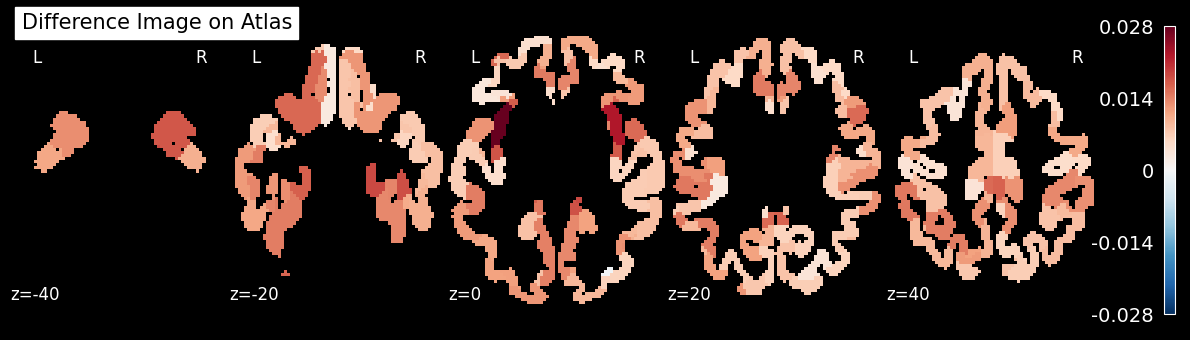

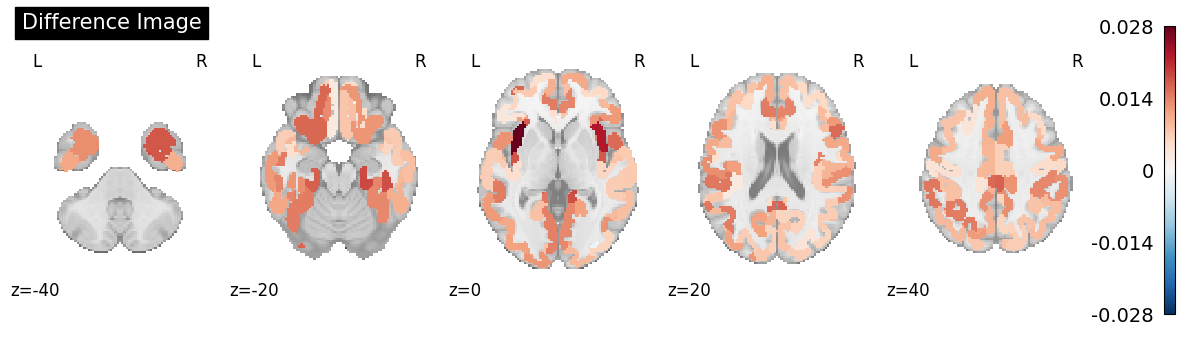

In [ ]:
import nibabel as nib
import nilearn.plotting as plotting

# Load the Nifti images (mean_reconstructed_image_encoder_z0 and mean_reconstructed_image_encoder_zs)
# These should already be loaded Nifti images
# For example:
# mean_reconstructed_image_encoder_z0 = nib.load('path_to_z0_image.nii')
# mean_reconstructed_image_encoder_zs = nib.load('path_to_zs_image.nii')

# Load the Destrieux atlas
atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized=True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)

# Compute the difference
difference_data = mean_reconstructed_image_encoder_z0.get_fdata() - mean_reconstructed_image_encoder_zs.get_fdata()

# Create a new Nifti image for the difference data
difference_image = nib.Nifti1Image(difference_data, mean_reconstructed_image_encoder_z0.affine)

# Display the difference image on top of the atlas
plotting.plot_stat_map(
    difference_image,
    bg_img=atlas_destrieux,
    title="Difference Image on Atlas",
    display_mode='z',  # You can choose different display modes
    cut_coords=[-40, -20, 0, 20, 40],  # Specify coordinates to display
    colorbar=True,
    cmap='RdBu_r',  # Choose a colormap
)

plotting.show()

plotting.plot_stat_map(
    difference_image,
    title="Difference Image",
    display_mode='z',  # You can choose different display modes
    cut_coords=[-40, -20, 0, 20, 40],  # Specify coordinates to display
    colorbar=True,
    cmap='RdBu_r',  # Choose a colormap
)

plotting.show()

Additionally, I am defining a function that does all this and looks at the stability across initializations.

In [80]:
reconstructed_difference_dict = {}

def compute_reconstructed_difference(reconstructed_difference_dict, model_classifier, train_dataloader_no_batch, device):
    # Set the model to evaluation mode
    model_classifier.eval()

    reconstructed_difference_dict = reconstructed_difference_dict

    # Create an iterator for the dataloader
    batch_iterator = iter(train_dataloader_no_batch)

    # Iterate through the dataloader
    for batch in batch_iterator:
        ((autism_data, autism_age, autism_gender, autism_diag_group, _,_,_,_,autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,no_autism_sub_id)) = batch

        # Assuming batch_size is available, if not, you can compute it based on the data shapes.
        batch_size = autism_data.shape[0]

        # Move data to the specified device
        autism_data = autism_data.to(device)
        # Compute the reconstructed data for encoder_z
        z_mean, z_log_var = model_classifier.encoder_z(autism_data, batch_size)
        latent_z_logvar0 = torch.zeros_like(z_mean)
        latent_z = model_classifier.reparameterize(z_mean, latent_z_logvar0)

        # Compute the reconstructed data for encoder_s
        s_mean, s_log_var = model_classifier.encoder_s(autism_data, batch_size)
        latent_s_logvar0 = torch.zeros_like(s_mean)
        latent_s = model_classifier.reparameterize(s_mean, latent_s_logvar0)

        latent_zs = torch.cat([latent_z, latent_s], dim=1)
        reconstructed_data_batch_zs = model_classifier.decoder(latent_zs, batch_size).detach()

        latent_z_0 = torch.cat([latent_z, torch.zeros_like(latent_z)], dim=1)
        reconstructed_data_batch_z0 = model_classifier.decoder(latent_z_0, batch_size).detach()

        reconstructed_difference = reconstructed_data_batch_zs - reconstructed_data_batch_z0

        # Iterate through participants and store the differences
        for sub_id, diff_data in zip(autism_sub_id, reconstructed_difference):
            if sub_id not in reconstructed_difference_dict:
                reconstructed_difference_dict[sub_id] = []
            reconstructed_difference_dict[sub_id].append(diff_data)

    return reconstructed_difference_dict

In [ ]:
reconstructed_difference_dict = compute_reconstructed_difference(reconstructed_difference_dict, model_classifier, train_dataloader_no_batch, device)

In [81]:
!pip install nilearn
from nilearn.datasets import fetch_atlas_destrieux_2009
import numpy as np

# Load the atlas
atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized=True)
labels = atlas_destrieux_dataset.labels

# Indices to remove (0, 42, and 117 in this case)
indices_to_remove = [0, 42, 117]

# Create a boolean mask to filter labels
mask = np.isin(labels['index'], indices_to_remove, invert=True)

# Apply the mask to filter the labels
labels = labels[mask]


import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_stability_metrics(reconstructed_difference_dict):
    """
    Compute element-wise stability metrics (mean and std) and cosine similarity for each participant and value across different tensors.

    Parameters:
        reconstructed_difference_dict (dict): Dictionary containing reconstructed tensors per participant.

    Returns:
        stability_metrics (dict): Dictionary containing element-wise stability metrics (mean and std)
        and cosine similarity per participant and value.
    """
    # Initialize dictionaries to store stability metrics
    stability_metrics = {}
    cosine_similarity_scores = {}

    # Iterate through participants
    for participant_id, tensors in reconstructed_difference_dict.items():
        # Get the number of tensors for this participant
        num_tensors = len(tensors)

        # Initialize empty lists for mean and std for each value across tensors
        means = []
        stds = []

        # Convert tensors to NumPy arrays and stack them horizontally
        tensors_np = [tensor.cpu().numpy() for tensor in tensors]
        stacked_tensors = np.hstack(tensors_np)
        stacked_tensors = stacked_tensors.reshape(num_tensors, 148)
        # Expand the first tensor to match the shape of stacked_tensors
        expanded_first_tensor = tensors_np[0].reshape(1, 148)

        # Compute cosine similarity between the expanded first tensor and stacked_tensors
        similarity_scores = cosine_similarity(expanded_first_tensor, stacked_tensors)

        # Store the cosine similarity scores for this participant
        cosine_similarity_scores[participant_id] = {"mean": similarity_scores}


        # Iterate through the values (assuming the tensors have the same shape)
        for value_idx in range(len(tensors[0])):
            # Extract values at the same position across all tensors
            values = [tensor[value_idx].cpu().numpy() for tensor in tensors]

            # Calculate mean and standard deviation for this value across tensors
            mean_value = np.mean(values)
            std_value = np.std(values)

            # Append the mean and std to the lists
            means.append(mean_value)
            stds.append(std_value)

        # Store the element-wise stability metrics (means and stds) for this participant
        stability_metrics[participant_id] = {"mean": means, "std": stds}

    return stability_metrics, cosine_similarity_scores

# Call the function
stability_metrics, cosine_similarity_scores = compute_stability_metrics(reconstructed_difference_dict)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.6 MB/s eta 0:00:00

Dataset created in /root/nilearn_data/destrieux_2009



 ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/destrieux_2009/2a2e5a5707983d509d9319c692c867ab/destrieux2009.tgz..... done.


# Stability Across Initializations

Fist, I am defining a few additional functions I need for this

In [90]:
import scipy.stats

def test_rsa_results_significance(dictionary, alpha=0.05):
    """
    Test if Kendall Tau correlation values differ significantly from 0 and return True if significant, False otherwise.

    Args:
    - dictionary: Dictionary containing Kendall Tau correlation lists for different variables.
    - alpha: Significance level for the t-test (default is 0.05).

    Returns:
    - A dictionary with significance testing results for each variable, including p-values.
    """
    results = {}  # Initialize a dictionary to store results

    for key, correlation_list in dictionary.items():
        # Perform a t-test to check if the correlation values are significantly different from 0
        t_statistic, p_value = scipy.stats.ttest_1samp(correlation_list, 0)

        # Check if the p-value is less than the significance level
        is_significant = p_value < alpha

        # Store the result (True if significant, False otherwise) and the p-value
        results[key] = {'significant': is_significant, 'p_value': p_value}

    return results

def calculate_means_and_significance(dictionary_list, alpha=0.05):
    """
    Calculate means and test if the means differ significantly from 0 for each key in dictionaries within a list.

    Args:
    - dictionary_list: List of dictionaries containing lists of values.
    - alpha: Significance level for the t-test (default is 0.05).

    Returns:
    - A dictionary where each key corresponds to a key in the input dictionaries, and the value is a dictionary
      containing the mean value and a boolean indicating significance for that key.
    """
    results_dict = {}

    for dictionary in dictionary_list:
        for key, value_list in dictionary.items():
            # Calculate the mean of the list
            list_mean = sum(value_list) / len(value_list)

            # Perform a t-test to check if the mean is significantly different from 0
            t_statistic, p_value = scipy.stats.ttest_1samp(value_list, 0)

            # Check if the p-value is less than the significance level
            is_significant = p_value < alpha

            # Create a dictionary to store the mean and significance for this key
            key_results = {'mean': list_mean, 'significant': is_significant}

            # Append the results to the dictionary under the corresponding key
            if key in results_dict:
                results_dict[key].append(key_results)
            else:
                results_dict[key] = [key_results]

    return results_dict

import matplotlib.patches as mpatches

def plot_means_with_significance(results_dict, title="RSA Values Across Initializations", color_dict=None,
                                  title_fontsize=24, label_fontsize=22, use_opacity=True, legend_loc="right",
                                  legend_order=None):
    """
    Plot means with optional significance indication.

    Args:
    - results_dict (dict): Dictionary of means and significance, where keys correspond to variable names
      and values are lists of dictionaries containing 'mean' and 'significant' keys.
    - title (str): Custom title for the plot (default is "RSA Values Across Initializations").
    - color_dict (dict): Dictionary mapping variable names to colors (default is None, which will use default colors).
    - title_fontsize (int): Font size for the title (default is 24).
    - label_fontsize (int): Font size for labels (default is 22).
    - use_opacity (bool): Use opacity to show significance (True, default) or crosses and circles (False).
    - legend_loc (str): Location of the legend ('right', 'upper left', etc., default is 'right').
    - legend_order (list): Specify the order of legend entries (default is None, which will use the order in the results_dict).
    """
    num_initializations = len(list(results_dict.values())[0])
    num_variables = len(results_dict)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # If custom colors are not provided, use default colors
    if color_dict is None:
        color_dict = {
            'ADOS Total': 'blue',
            'ADOS Social': 'green',
            'DSM IV': 'red',
            'FIQ': 'purple',
            'Sex': 'orange',
            'Age': 'cyan'
        }

    # Initialize legend entries list
    legend_entries = []

    if legend_order:
        # Create a filtered legend_order based on the keys present in results_dict
        filtered_legend_order = [variable for variable in legend_order if variable in results_dict]

        # Iterate through variables in the specified order (if provided)
        for variable in filtered_legend_order:
            results_list = results_dict[variable]
            x_values = np.arange(1, num_initializations + 1)
            y_values = [result['mean'] for result in results_list]
            is_significant = [result['significant'] for result in results_list]

            # Set color based on significance
            color = color_dict.get(variable, 'black')  # Default to black if variable not in color_dict

            if use_opacity:
                # Plot each data point individually with customized alpha
                for x, y, significant in zip(x_values, y_values, is_significant):
                    alpha_value = 1.0 if significant else 0.3
                    ax.scatter(x, y, marker='o', color=color, alpha=alpha_value, s=50)
            else:
                # Plot with crosses and circles to indicate significance
                for x, y, significant in zip(x_values, y_values, is_significant):
                    if significant:
                        ax.scatter(x, y, marker='o', color=color, s=50)
                    else:
                        ax.scatter(x, y, marker='x', color=color, s=50)

            # Connect dots with lines of the same color
            line, = ax.plot(x_values, y_values, marker='', color=color, linestyle='-', linewidth=2, label=variable)
            legend_entries.append(line)
    else:
        # Iterate through variables in results_dict
        for variable, results_list in results_dict.items():
            x_values = np.arange(1, num_initializations + 1)
            y_values = [result['mean'] for result in results_list]
            is_significant = [result['significant'] for result in results_list]

            # Set color based on significance
            color = color_dict.get(variable, 'black')  # Default to black if variable not in color_dict

            if use_opacity:
                # Plot each data point individually with customized alpha
                for x, y, significant in zip(x_values, y_values, is_significant):
                    alpha_value = 1.0 if significant else 0.3
                    ax.scatter(x, y, marker='o', color=color, alpha=alpha_value, s=50)
            else:
                # Plot with crosses and circles to indicate significance
                for x, y, significant in zip(x_values, y_values, is_significant):
                    if significant:
                        ax.scatter(x, y, marker='o', color=color, s=50)
                    else:
                        ax.scatter(x, y, marker='x', color=color, s=50)

            # Connect dots with lines of the same color
            line, = ax.plot(x_values, y_values, marker='', color=color, linestyle='-', linewidth=2, label=variable)
            legend_entries.append(line)

    # Customize the plot
    ax.set_xlabel("Initialization")
    ax.set_ylabel("Mean Value")
    ax.set_title(title if title is not None else "RSA Values Across Initializations", fontsize=title_fontsize)
    ax.spines['left'].set_linewidth(2)  # Adjust the left spine width
    ax.spines['top'].set_visible(False)  # Remove top spine
    ax.spines['right'].set_visible(False)  # Remove right spine
    ax.spines['bottom'].set_visible(False)  # Remove bottom spine

    # Increase font size for labels
    ax.set_xlabel("Initialization", fontsize=label_fontsize)
    ax.set_ylabel("Mean Value", fontsize=label_fontsize)

    # Set the legend outside the plot
    if legend_loc == "right":
        ax.legend(legend_entries, [line.get_label() for line in legend_entries], loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend(legend_entries, [line.get_label() for line in legend_entries], loc=legend_loc)

    # Show the plot
    plt.show()


In [82]:
import numpy as np
import torch

# Define the number of initializations
num_initializations = 10

# Initialize dictionaries to store RSA values for each RSA type
rsa_salient_with_classifier_autism_list = []
rsa_with_classifier_autism_list = []
rsa_with_classifier_no_autism_list = []
rsa_salient_without_classifier_autism_list = []
rsa_without_classifier_autism_list = []
rsa_without_classifier_no_autism_list = []

# Set the fixed seed for the first initialization
fixed_seed = 42

# Initializing a dictionary for the cortical thickness values
reconstruction_difference_dict = {}

for initialization in range(num_initializations):
    if initialization == 0:
        # Use the fixed seed for the first initialization
        np.random.seed(fixed_seed)
        torch.manual_seed(fixed_seed)
    else:
        # Use different random seeds for subsequent initializations
        np.random.seed(initialization)
        torch.manual_seed(initialization)

    lr = 0.01
    model_classifier = cVAE_classifier(input_dimension=148, latent_dim=16).to(device)
    optimizer = torch.optim.Adam(model_classifier.parameters(), lr=lr)
    criterion = nn.MSELoss()
    classifier_criterion = nn.MSELoss()

    # Create separate lists for training and validation losses for age, FIQ, and other terms
    train_age_losses = []
    val_age_losses = []
    train_fiq_losses = []
    val_fiq_losses = []
    train_other_losses = []
    val_other_losses = []

    num_epochs = 100
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} of {num_epochs}")
        # Train the model
        (train_loss_autism,
        train_loss_no_autism,
        train_age_loss_autism,
        train_age_loss_no_autism) = train(
            model_classifier,
            train_dataloader,
            train_dataset,
            device,
            optimizer,
            criterion,
            classifier_criterion)

    # Generate RSA results for this initialization
    rsa_salient_with_classifier_autism, rsa_with_classifier_autism, rsa_with_classifier_no_autism, rsa_salient_without_classifier_autism, rsa_without_classifier_autism, rsa_without_classifier_no_autism = generate_latent_vectors(model_classifier, model_basic, test_dataloader_no_batch)

    # Append RSA values to respective lists
    rsa_salient_with_classifier_autism_list.append(rsa_salient_with_classifier_autism)
    rsa_with_classifier_autism_list.append(rsa_with_classifier_autism)
    rsa_with_classifier_no_autism_list.append(rsa_with_classifier_no_autism)
    rsa_salient_without_classifier_autism_list.append(rsa_salient_without_classifier_autism)
    rsa_without_classifier_autism_list.append(rsa_without_classifier_autism)
    rsa_without_classifier_no_autism_list.append(rsa_without_classifier_no_autism)

    # Storing the reconstructed data in a dictionary
    reconstructed_difference_dict = compute_reconstructed_difference(reconstructed_difference_dict, model_classifier, train_dataloader_no_batch, device)


Epoch 1 of 100


7it [00:00, 40.13it/s]                       


Epoch 2 of 100


7it [00:00, 50.35it/s]                       


Epoch 3 of 100


7it [00:00, 24.16it/s]                       


Epoch 4 of 100


7it [00:00, 21.79it/s]                       


Epoch 5 of 100


7it [00:00, 45.05it/s]                       


Epoch 6 of 100


7it [00:00, 75.93it/s]               


Epoch 7 of 100


7it [00:00, 74.25it/s]               


Epoch 8 of 100


7it [00:00, 66.43it/s]


Epoch 9 of 100


7it [00:00, 23.90it/s]                       


Epoch 10 of 100


7it [00:00, 77.83it/s]               


Epoch 11 of 100


7it [00:00, 76.79it/s]               


Epoch 12 of 100


7it [00:00, 70.82it/s]               


Epoch 13 of 100


7it [00:00, 81.79it/s]               


Epoch 14 of 100


7it [00:00, 79.54it/s]               


Epoch 15 of 100


7it [00:00, 78.72it/s]               


Epoch 16 of 100


7it [00:00, 69.91it/s]               


Epoch 17 of 100


7it [00:00, 79.38it/s]               


Epoch 18 of 100


7it [00:00, 74.17it/s]               


Epoch 19 of 100


7it [00:00, 43.73it/s]                       


Epoch 20 of 100


7it [00:00, 45.06it/s]                       


Epoch 21 of 100


7it [00:00, 48.02it/s]                       


Epoch 22 of 100


7it [00:00, 77.93it/s]               


Epoch 23 of 100


7it [00:00, 61.23it/s]


Epoch 24 of 100


7it [00:00, 73.34it/s]               


Epoch 25 of 100


7it [00:00, 73.72it/s]               


Epoch 26 of 100


7it [00:00, 60.04it/s]                       


Epoch 27 of 100


7it [00:00, 74.08it/s]               


Epoch 28 of 100


7it [00:00, 63.37it/s]


Epoch 29 of 100


7it [00:00, 65.54it/s]


Epoch 30 of 100


7it [00:00, 68.79it/s]


Epoch 31 of 100


7it [00:00, 45.62it/s]


Epoch 32 of 100


7it [00:00, 29.49it/s]


Epoch 33 of 100


7it [00:00, 36.15it/s]                       


Epoch 34 of 100


7it [00:00, 39.58it/s]                       


Epoch 35 of 100


7it [00:00, 41.82it/s]                       


Epoch 36 of 100


7it [00:00, 46.03it/s]                       


Epoch 37 of 100


7it [00:00, 39.76it/s]                       


Epoch 38 of 100


7it [00:00, 44.52it/s]                       


Epoch 39 of 100


7it [00:00, 29.33it/s]                       


Epoch 40 of 100


7it [00:00, 40.79it/s]                       


Epoch 41 of 100


7it [00:00, 27.55it/s]                       


Epoch 42 of 100


7it [00:00, 45.95it/s]                       


Epoch 43 of 100


7it [00:00, 35.96it/s]                       


Epoch 44 of 100


7it [00:00, 32.02it/s]                       


Epoch 45 of 100


7it [00:00, 40.17it/s]                       


Epoch 46 of 100


7it [00:00, 22.10it/s]                       


Epoch 47 of 100


7it [00:00, 25.25it/s]                       


Epoch 48 of 100


7it [00:00, 23.76it/s]                       


Epoch 49 of 100


7it [00:00, 20.86it/s]                       


Epoch 50 of 100


7it [00:00, 21.88it/s]                       


Epoch 51 of 100


7it [00:00, 17.33it/s]                       


Epoch 52 of 100


7it [00:00, 22.29it/s]                       


Epoch 53 of 100


7it [00:00, 12.05it/s]                       


Epoch 54 of 100


7it [00:00, 11.41it/s]                       


Epoch 55 of 100


7it [00:00, 14.91it/s]


Epoch 56 of 100


7it [00:00, 18.41it/s]                       


Epoch 57 of 100


7it [00:00, 15.40it/s]                       


Epoch 58 of 100


7it [00:00, 16.85it/s]


Epoch 59 of 100


7it [00:00, 19.19it/s]


Epoch 60 of 100


7it [00:00, 24.04it/s]                       


Epoch 61 of 100


7it [00:00, 21.27it/s]                       


Epoch 62 of 100


7it [00:00, 20.85it/s]                       


Epoch 63 of 100


7it [00:00, 29.42it/s]                       


Epoch 64 of 100


7it [00:00, 24.16it/s]                       


Epoch 65 of 100


7it [00:00, 33.22it/s]                       


Epoch 66 of 100


7it [00:00, 15.61it/s]


Epoch 67 of 100


7it [00:00, 37.80it/s]                       


Epoch 68 of 100


7it [00:00, 28.89it/s]                       


Epoch 69 of 100


7it [00:00, 23.39it/s]                       


Epoch 70 of 100


7it [00:00, 18.32it/s]                       


Epoch 71 of 100


7it [00:00, 21.43it/s]                       


Epoch 72 of 100


7it [00:00, 15.88it/s]                       


Epoch 73 of 100


7it [00:00, 19.92it/s]                       


Epoch 74 of 100


7it [00:00, 23.97it/s]                       


Epoch 75 of 100


7it [00:00, 18.26it/s]                       


Epoch 76 of 100


7it [00:00, 19.21it/s]                       


Epoch 77 of 100


7it [00:00, 20.68it/s]                       


Epoch 78 of 100


7it [00:00, 20.41it/s]                       


Epoch 79 of 100


7it [00:00, 20.02it/s]


Epoch 80 of 100


7it [00:00, 21.46it/s]                       


Epoch 81 of 100


7it [00:00, 40.53it/s]                       


Epoch 82 of 100


7it [00:00, 29.65it/s]                       


Epoch 83 of 100


7it [00:00, 24.03it/s]


Epoch 84 of 100


7it [00:00, 25.28it/s]                       


Epoch 85 of 100


7it [00:00, 26.08it/s]                       


Epoch 86 of 100


7it [00:00, 26.41it/s]                       


Epoch 87 of 100


7it [00:00, 20.20it/s]                       


Epoch 88 of 100


7it [00:00, 21.96it/s]                       


Epoch 89 of 100


7it [00:00, 11.61it/s]                       


Epoch 90 of 100


7it [00:00, 12.03it/s]                       


Epoch 91 of 100


7it [00:00, 12.87it/s]                       


Epoch 92 of 100


7it [00:00, 14.40it/s]                       


Epoch 93 of 100


7it [00:00, 17.71it/s]                       


Epoch 94 of 100


7it [00:00, 15.27it/s]                       


Epoch 95 of 100


7it [00:00, 15.14it/s]                       


Epoch 96 of 100


7it [00:00, 11.58it/s]                       


Epoch 97 of 100


7it [00:00, 15.70it/s]                       


Epoch 98 of 100


7it [00:00, 12.33it/s]                       


Epoch 99 of 100


7it [00:00, 12.50it/s]                       


Epoch 100 of 100


7it [00:00, 21.28it/s]                       


Epoch 1 of 100


7it [00:00, 24.75it/s]                       


Epoch 2 of 100


7it [00:00, 20.13it/s]                       


Epoch 3 of 100


7it [00:00, 22.77it/s]                       


Epoch 4 of 100


7it [00:00, 19.35it/s]


Epoch 5 of 100


7it [00:00, 22.36it/s]                       


Epoch 6 of 100


7it [00:00, 19.16it/s]                       


Epoch 7 of 100


7it [00:00, 43.63it/s]                       


Epoch 8 of 100


7it [00:00, 36.68it/s]                       


Epoch 9 of 100


7it [00:00, 33.48it/s]                       


Epoch 10 of 100


7it [00:00, 21.07it/s]


Epoch 11 of 100


7it [00:00, 20.87it/s]                       


Epoch 12 of 100


7it [00:00, 25.18it/s]                       


Epoch 13 of 100


7it [00:00, 21.29it/s]                       


Epoch 14 of 100


7it [00:00, 29.62it/s]


Epoch 15 of 100


7it [00:00, 32.50it/s]                       


Epoch 16 of 100


7it [00:00, 21.77it/s]                       


Epoch 17 of 100


7it [00:00, 17.86it/s]


Epoch 18 of 100


7it [00:00, 16.13it/s]                       


Epoch 19 of 100


7it [00:00, 15.50it/s]                       


Epoch 20 of 100


7it [00:00, 16.56it/s]


Epoch 21 of 100


7it [00:00, 25.71it/s]                       


Epoch 22 of 100


7it [00:00, 22.90it/s]                       


Epoch 23 of 100


7it [00:00, 26.04it/s]                       


Epoch 24 of 100


7it [00:00, 20.81it/s]                       


Epoch 25 of 100


7it [00:00, 23.06it/s]                       


Epoch 26 of 100


7it [00:00, 14.47it/s]


Epoch 27 of 100


7it [00:00, 11.47it/s]


Epoch 28 of 100


7it [00:00, 12.86it/s]                       


Epoch 29 of 100


7it [00:00, 12.61it/s]                       


Epoch 30 of 100


7it [00:00, 17.86it/s]


Epoch 31 of 100


7it [00:00, 12.13it/s]                       


Epoch 32 of 100


7it [00:00,  8.00it/s]


Epoch 33 of 100


7it [00:00,  8.92it/s]                       


Epoch 34 of 100


7it [00:00,  8.79it/s]                       


Epoch 35 of 100


7it [00:00, 14.39it/s]                       


Epoch 36 of 100


7it [00:00, 23.93it/s]                       


Epoch 37 of 100


7it [00:00, 23.95it/s]


Epoch 38 of 100


7it [00:00, 19.51it/s]                       


Epoch 39 of 100


7it [00:00, 24.46it/s]                       


Epoch 40 of 100


7it [00:00, 23.03it/s]                       


Epoch 41 of 100


7it [00:00, 16.79it/s]


Epoch 42 of 100


7it [00:00, 22.80it/s]                       


Epoch 43 of 100


7it [00:00, 27.80it/s]                       


Epoch 44 of 100


7it [00:00, 17.83it/s]                       


Epoch 45 of 100


7it [00:00, 22.86it/s]                       


Epoch 46 of 100


7it [00:00, 24.86it/s]                       


Epoch 47 of 100


7it [00:00, 28.87it/s]                       


Epoch 48 of 100


7it [00:00, 26.19it/s]                       


Epoch 49 of 100


7it [00:00, 38.96it/s]                       


Epoch 50 of 100


7it [00:00, 29.70it/s]                       


Epoch 51 of 100


7it [00:00, 16.13it/s]                       


Epoch 52 of 100


7it [00:00, 28.60it/s]                       


Epoch 53 of 100


7it [00:00, 22.08it/s]                       


Epoch 54 of 100


7it [00:00, 21.31it/s]


Epoch 55 of 100


7it [00:00, 30.11it/s]


Epoch 56 of 100


7it [00:00, 20.18it/s]                       


Epoch 57 of 100


7it [00:00, 25.81it/s]                       


Epoch 58 of 100


7it [00:00, 22.24it/s]                       


Epoch 59 of 100


7it [00:00, 24.34it/s]                       


Epoch 60 of 100


7it [00:00, 22.92it/s]                       


Epoch 61 of 100


7it [00:00, 18.84it/s]                       


Epoch 62 of 100


7it [00:00, 19.43it/s]                       


Epoch 63 of 100


7it [00:00, 21.84it/s]                       


Epoch 64 of 100


7it [00:00, 23.22it/s]                       


Epoch 65 of 100


7it [00:00, 15.53it/s]                       


Epoch 66 of 100


7it [00:00, 12.17it/s]                       


Epoch 67 of 100


7it [00:00, 13.84it/s]                       


Epoch 68 of 100


7it [00:00, 17.00it/s]                       


Epoch 69 of 100


7it [00:00, 14.75it/s]                       


Epoch 70 of 100


7it [00:00, 13.10it/s]                       


Epoch 71 of 100


7it [00:00, 12.57it/s]                       


Epoch 72 of 100


7it [00:00, 15.16it/s]                       


Epoch 73 of 100


7it [00:00, 20.77it/s]                       


Epoch 74 of 100


7it [00:00, 24.99it/s]                       


Epoch 75 of 100


7it [00:00, 18.25it/s]                       


Epoch 76 of 100


7it [00:00, 18.52it/s]                       


Epoch 77 of 100


7it [00:00, 27.89it/s]                       


Epoch 78 of 100


7it [00:00, 21.29it/s]                       


Epoch 79 of 100


7it [00:00, 27.10it/s]                       


Epoch 80 of 100


7it [00:00, 24.43it/s]                       


Epoch 81 of 100


7it [00:00, 23.44it/s]                       


Epoch 82 of 100


7it [00:00, 21.67it/s]                       


Epoch 83 of 100


7it [00:00, 25.28it/s]                       


Epoch 84 of 100


7it [00:00, 24.89it/s]                       


Epoch 85 of 100


7it [00:00, 27.62it/s]                       


Epoch 86 of 100


7it [00:00, 32.13it/s]                       


Epoch 87 of 100


7it [00:00, 46.24it/s]                       


Epoch 88 of 100


7it [00:00, 36.16it/s]                       


Epoch 89 of 100


7it [00:00, 33.58it/s]                       


Epoch 90 of 100


7it [00:00, 34.66it/s]                       


Epoch 91 of 100


7it [00:00, 23.76it/s]                       


Epoch 92 of 100


7it [00:00, 14.38it/s]                       


Epoch 93 of 100


7it [00:00, 21.25it/s]                       


Epoch 94 of 100


7it [00:00, 19.34it/s]


Epoch 95 of 100


7it [00:00, 29.00it/s]


Epoch 96 of 100


7it [00:00, 29.60it/s]                       


Epoch 97 of 100


7it [00:00, 21.45it/s]                       


Epoch 98 of 100


7it [00:00, 21.68it/s]                       


Epoch 99 of 100


7it [00:00, 26.28it/s]                       


Epoch 100 of 100


7it [00:00, 12.97it/s]


Epoch 1 of 100


7it [00:00, 27.47it/s]                       


Epoch 2 of 100


7it [00:00, 28.47it/s]                       


Epoch 3 of 100


7it [00:00, 29.02it/s]                       


Epoch 4 of 100


7it [00:00, 30.68it/s]                       


Epoch 5 of 100


7it [00:00, 29.44it/s]


Epoch 6 of 100


7it [00:00, 30.48it/s]                       


Epoch 7 of 100


7it [00:00, 24.35it/s]                       


Epoch 8 of 100


7it [00:00, 19.21it/s]                       


Epoch 9 of 100


7it [00:00, 19.33it/s]                       


Epoch 10 of 100


7it [00:00, 19.04it/s]


Epoch 11 of 100


7it [00:00, 19.74it/s]                       


Epoch 12 of 100


7it [00:00, 19.10it/s]                       


Epoch 13 of 100


7it [00:00, 20.07it/s]


Epoch 14 of 100


7it [00:00, 22.62it/s]                       


Epoch 15 of 100


7it [00:00, 21.57it/s]                       


Epoch 16 of 100


7it [00:00, 26.28it/s]                       


Epoch 17 of 100


7it [00:00, 21.67it/s]                       


Epoch 18 of 100


7it [00:00, 19.10it/s]                       


Epoch 19 of 100


7it [00:00, 20.11it/s]                       


Epoch 20 of 100


7it [00:00, 19.36it/s]                       


Epoch 21 of 100


7it [00:00, 16.49it/s]


Epoch 22 of 100


7it [00:00, 19.46it/s]                       


Epoch 23 of 100


7it [00:00, 24.11it/s]                       


Epoch 24 of 100


7it [00:00, 30.20it/s]                       


Epoch 25 of 100


7it [00:00, 36.15it/s]                       


Epoch 26 of 100


7it [00:00, 32.06it/s]


Epoch 27 of 100


7it [00:00, 31.93it/s]                       


Epoch 28 of 100


7it [00:00, 31.41it/s]


Epoch 29 of 100


7it [00:00, 32.16it/s]


Epoch 30 of 100


7it [00:00, 44.66it/s]                       


Epoch 31 of 100


7it [00:00, 28.76it/s]                       


Epoch 32 of 100


7it [00:00, 30.16it/s]                       


Epoch 33 of 100


7it [00:00, 36.35it/s]                       


Epoch 34 of 100


7it [00:00, 28.16it/s]                       


Epoch 35 of 100


7it [00:00, 25.88it/s]                       


Epoch 36 of 100


7it [00:00, 28.72it/s]


Epoch 37 of 100


7it [00:00, 34.31it/s]                       


Epoch 38 of 100


7it [00:00, 29.37it/s]                       


Epoch 39 of 100


7it [00:00, 32.47it/s]                       


Epoch 40 of 100


7it [00:00, 28.66it/s]                       


Epoch 41 of 100


7it [00:00, 26.39it/s]                       


Epoch 42 of 100


7it [00:00, 29.59it/s]                       


Epoch 43 of 100


7it [00:00, 26.19it/s]                       


Epoch 44 of 100


7it [00:00, 26.29it/s]                       


Epoch 45 of 100


7it [00:00, 23.17it/s]                       


Epoch 46 of 100


7it [00:00, 23.43it/s]                       


Epoch 47 of 100


7it [00:00, 16.85it/s]                       


Epoch 48 of 100


7it [00:00, 21.65it/s]                       


Epoch 49 of 100


7it [00:00, 26.28it/s]


Epoch 50 of 100


7it [00:00, 40.86it/s]                       


Epoch 51 of 100


7it [00:00, 33.22it/s]                       


Epoch 52 of 100


7it [00:00, 35.07it/s]                       


Epoch 53 of 100


7it [00:00, 52.02it/s]                       


Epoch 54 of 100


7it [00:00, 47.82it/s]                       


Epoch 55 of 100


7it [00:00, 39.08it/s]                       


Epoch 56 of 100


7it [00:00, 40.53it/s]                       


Epoch 57 of 100


7it [00:00, 33.13it/s]                       


Epoch 58 of 100


7it [00:00, 36.69it/s]                       


Epoch 59 of 100


7it [00:00, 47.72it/s]                       


Epoch 60 of 100


7it [00:00, 42.74it/s]                       


Epoch 61 of 100


7it [00:00, 22.01it/s]                       


Epoch 62 of 100


7it [00:00, 40.94it/s]                       


Epoch 63 of 100


7it [00:00, 46.07it/s]                       


Epoch 64 of 100


7it [00:00, 21.72it/s]                       


Epoch 65 of 100


7it [00:00, 14.39it/s]


Epoch 66 of 100


7it [00:00, 21.24it/s]                       


Epoch 67 of 100


7it [00:00, 16.20it/s]                       


Epoch 68 of 100


7it [00:00, 24.95it/s]                       


Epoch 69 of 100


7it [00:00, 22.65it/s]                       


Epoch 70 of 100


7it [00:00, 22.13it/s]                       


Epoch 71 of 100


7it [00:00, 43.57it/s]                       


Epoch 72 of 100


7it [00:00, 19.72it/s]                       


Epoch 73 of 100


7it [00:00, 18.70it/s]                       


Epoch 74 of 100


7it [00:00, 25.49it/s]


Epoch 75 of 100


7it [00:00, 26.82it/s]                       


Epoch 76 of 100


7it [00:00, 23.79it/s]                       


Epoch 77 of 100


7it [00:00, 17.76it/s]


Epoch 78 of 100


7it [00:00, 28.55it/s]                       


Epoch 79 of 100


7it [00:00, 23.27it/s]                       


Epoch 80 of 100


7it [00:00, 23.65it/s]                       


Epoch 81 of 100


7it [00:00, 43.79it/s]                       


Epoch 82 of 100


7it [00:00, 47.08it/s]                       


Epoch 83 of 100


7it [00:00, 46.46it/s]                       


Epoch 84 of 100


7it [00:00, 48.58it/s]                       


Epoch 85 of 100


7it [00:00, 46.82it/s]                       


Epoch 86 of 100


7it [00:00, 46.21it/s]                       


Epoch 87 of 100


7it [00:00, 30.10it/s]                       


Epoch 88 of 100


7it [00:00, 49.88it/s]                       


Epoch 89 of 100


7it [00:00, 47.25it/s]                       


Epoch 90 of 100


7it [00:00, 46.40it/s]                       


Epoch 91 of 100


7it [00:00, 39.05it/s]                       


Epoch 92 of 100


7it [00:00, 31.64it/s]                       


Epoch 93 of 100


7it [00:00, 35.02it/s]                       


Epoch 94 of 100


7it [00:00, 46.66it/s]                       


Epoch 95 of 100


7it [00:00, 47.65it/s]                       


Epoch 96 of 100


7it [00:00, 51.88it/s]                       


Epoch 97 of 100


7it [00:00, 41.27it/s]                       


Epoch 98 of 100


7it [00:00, 42.56it/s]                       


Epoch 99 of 100


7it [00:00, 44.80it/s]                       


Epoch 100 of 100


7it [00:00, 50.23it/s]                       


Epoch 1 of 100


7it [00:00, 52.64it/s]                       


Epoch 2 of 100


7it [00:00, 50.83it/s]                       


Epoch 3 of 100


7it [00:00, 50.26it/s]                       


Epoch 4 of 100


7it [00:00, 50.58it/s]                       


Epoch 5 of 100


7it [00:00, 50.22it/s]                       


Epoch 6 of 100


7it [00:00, 49.18it/s]                       


Epoch 7 of 100


7it [00:00, 46.43it/s]                       


Epoch 8 of 100


7it [00:00, 49.07it/s]                       


Epoch 9 of 100


7it [00:00, 49.02it/s]                       


Epoch 10 of 100


7it [00:00, 47.94it/s]                       


Epoch 11 of 100


7it [00:00, 50.78it/s]                       


Epoch 12 of 100


7it [00:00, 48.17it/s]                       


Epoch 13 of 100


7it [00:00, 45.56it/s]                       


Epoch 14 of 100


7it [00:00, 46.96it/s]                       


Epoch 15 of 100


7it [00:00, 46.53it/s]                       


Epoch 16 of 100


7it [00:00, 49.67it/s]                       


Epoch 17 of 100


7it [00:00, 48.47it/s]                       


Epoch 18 of 100


7it [00:00, 53.76it/s]                       


Epoch 19 of 100


7it [00:00, 43.55it/s]                       


Epoch 20 of 100


7it [00:00, 42.03it/s]                       


Epoch 21 of 100


7it [00:00, 48.47it/s]                       


Epoch 22 of 100


7it [00:00, 50.65it/s]                       


Epoch 23 of 100


7it [00:00, 45.08it/s]                       


Epoch 24 of 100


7it [00:00, 48.83it/s]                       


Epoch 25 of 100


7it [00:00, 45.68it/s]                       


Epoch 26 of 100


7it [00:00, 47.63it/s]                       


Epoch 27 of 100


7it [00:00, 43.23it/s]                       


Epoch 28 of 100


7it [00:00, 50.50it/s]                       


Epoch 29 of 100


7it [00:00, 50.23it/s]                       


Epoch 30 of 100


7it [00:00, 45.42it/s]                       


Epoch 31 of 100


7it [00:00, 45.01it/s]                       


Epoch 32 of 100


7it [00:00, 51.98it/s]                       


Epoch 33 of 100


7it [00:00, 50.08it/s]                       


Epoch 34 of 100


7it [00:00, 51.57it/s]                       


Epoch 35 of 100


7it [00:00, 48.61it/s]                       


Epoch 36 of 100


7it [00:00, 46.61it/s]                       


Epoch 37 of 100


7it [00:00, 38.06it/s]                       


Epoch 38 of 100


7it [00:00, 36.68it/s]                       


Epoch 39 of 100


7it [00:00, 26.11it/s]                       


Epoch 40 of 100


7it [00:00, 28.12it/s]                       


Epoch 41 of 100


7it [00:00, 27.50it/s]                       


Epoch 42 of 100


7it [00:00, 27.98it/s]                       


Epoch 43 of 100


7it [00:00, 25.87it/s]                       


Epoch 44 of 100


7it [00:00, 29.53it/s]                       


Epoch 45 of 100


7it [00:00, 29.23it/s]                       


Epoch 46 of 100


7it [00:00, 39.57it/s]                       


Epoch 47 of 100


7it [00:00, 36.02it/s]                       


Epoch 48 of 100


7it [00:00, 39.90it/s]                       


Epoch 49 of 100


7it [00:00, 40.57it/s]                       


Epoch 50 of 100


7it [00:00, 36.01it/s]                       


Epoch 51 of 100


7it [00:00, 38.67it/s]                       


Epoch 52 of 100


7it [00:00, 28.47it/s]                       


Epoch 53 of 100


7it [00:00, 27.48it/s]


Epoch 54 of 100


7it [00:00, 34.46it/s]                       


Epoch 55 of 100


7it [00:00, 42.20it/s]                       


Epoch 56 of 100


7it [00:00, 39.05it/s]                       


Epoch 57 of 100


7it [00:00, 25.89it/s]                       


Epoch 58 of 100


7it [00:00, 23.80it/s]                       


Epoch 59 of 100


7it [00:00, 23.00it/s]                       


Epoch 60 of 100


7it [00:00, 27.55it/s]                       


Epoch 61 of 100


7it [00:00, 25.42it/s]                       


Epoch 62 of 100


7it [00:00, 30.63it/s]                       


Epoch 63 of 100


7it [00:00, 32.60it/s]


Epoch 64 of 100


7it [00:00, 45.72it/s]                       


Epoch 65 of 100


7it [00:00, 49.80it/s]                       


Epoch 66 of 100


7it [00:00, 45.65it/s]                       


Epoch 67 of 100


7it [00:00, 49.46it/s]                       


Epoch 68 of 100


7it [00:00, 50.29it/s]                       


Epoch 69 of 100


7it [00:00, 50.59it/s]                       


Epoch 70 of 100


7it [00:00, 48.79it/s]                       


Epoch 71 of 100


7it [00:00, 53.78it/s]                       


Epoch 72 of 100


7it [00:00, 43.67it/s]                       


Epoch 73 of 100


7it [00:00, 41.36it/s]                       


Epoch 74 of 100


7it [00:00, 43.10it/s]                       


Epoch 75 of 100


7it [00:00, 46.06it/s]                       


Epoch 76 of 100


7it [00:00, 39.32it/s]                       


Epoch 77 of 100


7it [00:00, 43.84it/s]                       


Epoch 78 of 100


7it [00:00, 38.30it/s]                       


Epoch 79 of 100


7it [00:00, 39.13it/s]                       


Epoch 80 of 100


7it [00:00, 44.57it/s]                       


Epoch 81 of 100


7it [00:00, 43.81it/s]                       


Epoch 82 of 100


7it [00:00, 48.68it/s]                       


Epoch 83 of 100


7it [00:00, 39.14it/s]                       


Epoch 84 of 100


7it [00:00, 40.40it/s]                       


Epoch 85 of 100


7it [00:00, 40.55it/s]                       


Epoch 86 of 100


7it [00:00, 33.68it/s]                       


Epoch 87 of 100


7it [00:00, 18.05it/s]


Epoch 88 of 100


7it [00:00, 37.15it/s]                       


Epoch 89 of 100


7it [00:00, 35.69it/s]                       


Epoch 90 of 100


7it [00:00, 39.39it/s]                       


Epoch 91 of 100


7it [00:00, 44.86it/s]                       


Epoch 92 of 100


7it [00:00, 45.37it/s]                       


Epoch 93 of 100


7it [00:00, 47.25it/s]                       


Epoch 94 of 100


7it [00:00, 44.91it/s]                       


Epoch 95 of 100


7it [00:00, 50.46it/s]                       


Epoch 96 of 100


7it [00:00, 41.24it/s]                       


Epoch 97 of 100


7it [00:00, 49.01it/s]                       


Epoch 98 of 100


7it [00:00, 50.19it/s]                       


Epoch 99 of 100


7it [00:00, 46.32it/s]                       


Epoch 100 of 100


7it [00:00, 46.93it/s]                       


Epoch 1 of 100


7it [00:00, 43.52it/s]                       


Epoch 2 of 100


7it [00:00, 41.35it/s]                       


Epoch 3 of 100


7it [00:00, 47.42it/s]                       


Epoch 4 of 100


7it [00:00, 46.58it/s]                       


Epoch 5 of 100


7it [00:00, 36.42it/s]                       


Epoch 6 of 100


7it [00:00, 37.69it/s]                       


Epoch 7 of 100


7it [00:00, 47.94it/s]                       


Epoch 8 of 100


7it [00:00, 41.44it/s]                       


Epoch 9 of 100


7it [00:00, 47.26it/s]                       


Epoch 10 of 100


7it [00:00, 44.63it/s]                       


Epoch 11 of 100


7it [00:00, 35.72it/s]                       


Epoch 12 of 100


7it [00:00, 42.91it/s]                       


Epoch 13 of 100


7it [00:00, 40.91it/s]                       


Epoch 14 of 100


7it [00:00, 46.52it/s]                       


Epoch 15 of 100


7it [00:00, 34.57it/s]                       


Epoch 16 of 100


7it [00:00, 32.85it/s]                       


Epoch 17 of 100


7it [00:00, 34.65it/s]                       


Epoch 18 of 100


7it [00:00, 26.98it/s]


Epoch 19 of 100


7it [00:00, 28.59it/s]                       


Epoch 20 of 100


7it [00:00, 27.92it/s]


Epoch 21 of 100


7it [00:00, 26.33it/s]                       


Epoch 22 of 100


7it [00:00, 25.48it/s]                       


Epoch 23 of 100


7it [00:00, 29.10it/s]


Epoch 24 of 100


7it [00:00, 26.16it/s]                       


Epoch 25 of 100


7it [00:00, 27.77it/s]                       


Epoch 26 of 100


7it [00:00, 25.65it/s]                       


Epoch 27 of 100


7it [00:00, 26.27it/s]                       


Epoch 28 of 100


7it [00:00, 26.85it/s]                       


Epoch 29 of 100


7it [00:00, 25.25it/s]                       


Epoch 30 of 100


7it [00:00, 31.56it/s]


Epoch 31 of 100


7it [00:00, 45.13it/s]                       


Epoch 32 of 100


7it [00:00, 40.30it/s]                       


Epoch 33 of 100


7it [00:00, 40.88it/s]                       


Epoch 34 of 100


7it [00:00, 28.79it/s]                       


Epoch 35 of 100


7it [00:00, 30.95it/s]


Epoch 36 of 100


7it [00:00, 25.84it/s]                       


Epoch 37 of 100


7it [00:00, 26.20it/s]                       


Epoch 38 of 100


7it [00:00, 29.82it/s]                       


Epoch 39 of 100


7it [00:00, 44.52it/s]                       


Epoch 40 of 100


7it [00:00, 41.06it/s]                       


Epoch 41 of 100


7it [00:00, 45.37it/s]                       


Epoch 42 of 100


7it [00:00, 35.90it/s]                       


Epoch 43 of 100


7it [00:00, 42.26it/s]                       


Epoch 44 of 100


7it [00:00, 50.03it/s]                       


Epoch 45 of 100


7it [00:00, 48.68it/s]                       


Epoch 46 of 100


7it [00:00, 43.91it/s]                       


Epoch 47 of 100


7it [00:00, 46.75it/s]                       


Epoch 48 of 100


7it [00:00, 36.90it/s]                       


Epoch 49 of 100


7it [00:00, 47.86it/s]                       


Epoch 50 of 100


7it [00:00, 46.05it/s]                       


Epoch 51 of 100


7it [00:00, 34.81it/s]                       


Epoch 52 of 100


7it [00:00, 49.00it/s]                       


Epoch 53 of 100


7it [00:00, 44.55it/s]                       


Epoch 54 of 100


7it [00:00, 44.09it/s]                       


Epoch 55 of 100


7it [00:00, 44.29it/s]                       


Epoch 56 of 100


7it [00:00, 33.59it/s]


Epoch 57 of 100


7it [00:00, 38.66it/s]                       


Epoch 58 of 100


7it [00:00, 38.14it/s]                       


Epoch 59 of 100


7it [00:00, 40.28it/s]                       


Epoch 60 of 100


7it [00:00, 31.00it/s]                       


Epoch 61 of 100


7it [00:00, 40.63it/s]                       


Epoch 62 of 100


7it [00:00, 47.36it/s]                       


Epoch 63 of 100


7it [00:00, 45.45it/s]                       


Epoch 64 of 100


7it [00:00, 48.91it/s]                       


Epoch 65 of 100


7it [00:00, 45.79it/s]                       


Epoch 66 of 100


7it [00:00, 50.84it/s]                       


Epoch 67 of 100


7it [00:00, 49.33it/s]                       


Epoch 68 of 100


7it [00:00, 35.80it/s]                       


Epoch 69 of 100


7it [00:00, 44.62it/s]                       


Epoch 70 of 100


7it [00:00, 42.37it/s]                       


Epoch 71 of 100


7it [00:00, 48.63it/s]                       


Epoch 72 of 100


7it [00:00, 43.57it/s]                       


Epoch 73 of 100


7it [00:00, 41.54it/s]                       


Epoch 74 of 100


7it [00:00, 60.90it/s]


Epoch 75 of 100


7it [00:00, 64.17it/s]


Epoch 76 of 100


7it [00:00, 71.71it/s]               


Epoch 77 of 100


7it [00:00, 72.55it/s]               


Epoch 78 of 100


7it [00:00, 67.80it/s]


Epoch 79 of 100


7it [00:00, 64.49it/s]


Epoch 80 of 100


7it [00:00, 71.61it/s]               


Epoch 81 of 100


7it [00:00, 71.65it/s]               


Epoch 82 of 100


7it [00:00, 78.00it/s]               


Epoch 83 of 100


7it [00:00, 67.62it/s]


Epoch 84 of 100


7it [00:00, 64.09it/s]


Epoch 85 of 100


7it [00:00, 71.62it/s]               


Epoch 86 of 100


7it [00:00, 67.77it/s]


Epoch 87 of 100


7it [00:00, 65.56it/s]


Epoch 88 of 100


7it [00:00, 72.15it/s]               


Epoch 89 of 100


7it [00:00, 72.16it/s]               


Epoch 90 of 100


7it [00:00, 76.62it/s]               


Epoch 91 of 100


7it [00:00, 72.79it/s]               


Epoch 92 of 100


7it [00:00, 71.22it/s]               


Epoch 93 of 100


7it [00:00, 62.61it/s]


Epoch 94 of 100


7it [00:00, 65.25it/s]


Epoch 95 of 100


7it [00:00, 63.52it/s]


Epoch 96 of 100


7it [00:00, 71.80it/s]               


Epoch 97 of 100


7it [00:00, 66.52it/s]


Epoch 98 of 100


7it [00:00, 74.71it/s]               


Epoch 99 of 100


7it [00:00, 67.81it/s]


Epoch 100 of 100


7it [00:00, 73.81it/s]               


Epoch 1 of 100


7it [00:00, 68.12it/s]


Epoch 2 of 100


7it [00:00, 55.54it/s]                       


Epoch 3 of 100


7it [00:00, 43.89it/s]                       


Epoch 4 of 100


7it [00:00, 52.14it/s]                       


Epoch 5 of 100


7it [00:00, 48.50it/s]                       


Epoch 6 of 100


7it [00:00, 48.03it/s]                       


Epoch 7 of 100


7it [00:00, 49.89it/s]                       


Epoch 8 of 100


7it [00:00, 48.19it/s]                       


Epoch 9 of 100


7it [00:00, 45.21it/s]                       


Epoch 10 of 100


7it [00:00, 50.93it/s]                       


Epoch 11 of 100


7it [00:00, 47.67it/s]                       


Epoch 12 of 100


7it [00:00, 50.62it/s]                       


Epoch 13 of 100


7it [00:00, 49.16it/s]                       


Epoch 14 of 100


7it [00:00, 39.91it/s]                       


Epoch 15 of 100


7it [00:00, 46.17it/s]                       


Epoch 16 of 100


7it [00:00, 43.29it/s]                       


Epoch 17 of 100


7it [00:00, 48.26it/s]                       


Epoch 18 of 100


7it [00:00, 48.28it/s]                       


Epoch 19 of 100


7it [00:00, 44.77it/s]                       


Epoch 20 of 100


7it [00:00, 51.52it/s]                       


Epoch 21 of 100


7it [00:00, 48.46it/s]                       


Epoch 22 of 100


7it [00:00, 47.41it/s]                       


Epoch 23 of 100


7it [00:00, 55.44it/s]                       


Epoch 24 of 100


7it [00:00, 51.53it/s]                       


Epoch 25 of 100


7it [00:00, 49.27it/s]                       


Epoch 26 of 100


7it [00:00, 45.32it/s]                       


Epoch 27 of 100


7it [00:00, 45.30it/s]                       


Epoch 28 of 100


7it [00:00, 47.77it/s]                       


Epoch 29 of 100


7it [00:00, 52.65it/s]                       


Epoch 30 of 100


7it [00:00, 48.96it/s]                       


Epoch 31 of 100


7it [00:00, 46.55it/s]                       


Epoch 32 of 100


7it [00:00, 43.60it/s]                       


Epoch 33 of 100


7it [00:00, 43.66it/s]                       


Epoch 34 of 100


7it [00:00, 46.78it/s]                       


Epoch 35 of 100


7it [00:00, 45.08it/s]                       


Epoch 36 of 100


7it [00:00, 59.11it/s]                       


Epoch 37 of 100


7it [00:00, 74.55it/s]               


Epoch 38 of 100


7it [00:00, 75.05it/s]               


Epoch 39 of 100


7it [00:00, 66.18it/s]


Epoch 40 of 100


7it [00:00, 74.80it/s]               


Epoch 41 of 100


7it [00:00, 20.97it/s]                       


Epoch 42 of 100


7it [00:00, 28.17it/s]                       


Epoch 43 of 100


7it [00:00, 26.44it/s]                       


Epoch 44 of 100


7it [00:00, 31.49it/s]                       


Epoch 45 of 100


7it [00:00, 64.67it/s]


Epoch 46 of 100


7it [00:00, 70.96it/s]               


Epoch 47 of 100


7it [00:00, 72.89it/s]               


Epoch 48 of 100


7it [00:00, 73.82it/s]               


Epoch 49 of 100


7it [00:00, 64.78it/s]


Epoch 50 of 100


7it [00:00, 74.65it/s]               


Epoch 51 of 100


7it [00:00, 72.64it/s]               


Epoch 52 of 100


7it [00:00, 64.47it/s]


Epoch 53 of 100


7it [00:00, 55.47it/s]                       


Epoch 54 of 100


7it [00:00, 70.92it/s]               


Epoch 55 of 100


7it [00:00, 63.75it/s]


Epoch 56 of 100


7it [00:00, 73.64it/s]               


Epoch 57 of 100


7it [00:00, 71.35it/s]               


Epoch 58 of 100


7it [00:00, 73.82it/s]               


Epoch 59 of 100


7it [00:00, 68.56it/s]


Epoch 60 of 100


7it [00:00, 66.97it/s]


Epoch 61 of 100


7it [00:00, 60.20it/s]                       


Epoch 62 of 100


7it [00:00, 56.83it/s]                       


Epoch 63 of 100


7it [00:00, 70.70it/s]               


Epoch 64 of 100


7it [00:00, 72.18it/s]               


Epoch 65 of 100


7it [00:00, 72.35it/s]               


Epoch 66 of 100


7it [00:00, 77.05it/s]               


Epoch 67 of 100


7it [00:00, 65.10it/s]


Epoch 68 of 100


7it [00:00, 79.56it/s]               


Epoch 69 of 100


7it [00:00, 70.57it/s]               


Epoch 70 of 100


7it [00:00, 69.90it/s]               


Epoch 71 of 100


7it [00:00, 58.36it/s]                       


Epoch 72 of 100


7it [00:00, 73.59it/s]               


Epoch 73 of 100


7it [00:00, 64.71it/s]


Epoch 74 of 100


7it [00:00, 66.11it/s]


Epoch 75 of 100


7it [00:00, 65.06it/s]


Epoch 76 of 100


7it [00:00, 26.12it/s]                       


Epoch 77 of 100


7it [00:00, 63.28it/s]


Epoch 78 of 100


7it [00:00, 59.79it/s]                       


Epoch 79 of 100


7it [00:00, 74.51it/s]               


Epoch 80 of 100


7it [00:00, 67.60it/s]


Epoch 81 of 100


7it [00:00, 67.22it/s]


Epoch 82 of 100


7it [00:00, 65.83it/s]


Epoch 83 of 100


7it [00:00, 60.53it/s]                       


Epoch 84 of 100


7it [00:00, 62.58it/s]


Epoch 85 of 100


7it [00:00, 72.66it/s]               


Epoch 86 of 100


7it [00:00, 64.32it/s]


Epoch 87 of 100


7it [00:00, 63.89it/s]


Epoch 88 of 100


7it [00:00, 65.86it/s]


Epoch 89 of 100


7it [00:00, 66.50it/s]


Epoch 90 of 100


7it [00:00, 67.64it/s]


Epoch 91 of 100


7it [00:00, 59.87it/s]                       


Epoch 92 of 100


7it [00:00, 72.36it/s]               


Epoch 93 of 100


7it [00:00, 73.45it/s]               


Epoch 94 of 100


7it [00:00, 66.53it/s]


Epoch 95 of 100


7it [00:00, 65.63it/s]


Epoch 96 of 100


7it [00:00, 58.26it/s]                       


Epoch 97 of 100


7it [00:00, 74.89it/s]               


Epoch 98 of 100


7it [00:00, 72.12it/s]               


Epoch 99 of 100


7it [00:00, 72.10it/s]               


Epoch 100 of 100


7it [00:00, 63.08it/s]


Epoch 1 of 100


7it [00:00, 62.97it/s]


Epoch 2 of 100


7it [00:00, 67.05it/s]


Epoch 3 of 100


7it [00:00, 59.01it/s]                       


Epoch 4 of 100


7it [00:00, 67.05it/s]


Epoch 5 of 100


7it [00:00, 65.12it/s]


Epoch 6 of 100


7it [00:00, 69.08it/s]


Epoch 7 of 100


7it [00:00, 66.41it/s]


Epoch 8 of 100


7it [00:00, 72.08it/s]               


Epoch 9 of 100


7it [00:00, 66.45it/s]


Epoch 10 of 100


7it [00:00, 57.37it/s]                       


Epoch 11 of 100


7it [00:00, 55.91it/s]                       


Epoch 12 of 100


7it [00:00, 45.69it/s]                       


Epoch 13 of 100


7it [00:00, 42.12it/s]                       


Epoch 14 of 100


7it [00:00, 52.58it/s]                       


Epoch 15 of 100


7it [00:00, 44.42it/s]                       


Epoch 16 of 100


7it [00:00, 49.98it/s]                       


Epoch 17 of 100


7it [00:00, 52.36it/s]                       


Epoch 18 of 100


7it [00:00, 57.37it/s]                       


Epoch 19 of 100


7it [00:00, 50.70it/s]                       


Epoch 20 of 100


7it [00:00, 43.69it/s]                       


Epoch 21 of 100


7it [00:00, 43.63it/s]                       


Epoch 22 of 100


7it [00:00, 46.29it/s]                       


Epoch 23 of 100


7it [00:00, 43.25it/s]                       


Epoch 24 of 100


7it [00:00, 46.50it/s]                       


Epoch 25 of 100


7it [00:00, 44.11it/s]                       


Epoch 26 of 100


7it [00:00, 46.35it/s]                       


Epoch 27 of 100


7it [00:00, 44.94it/s]                       


Epoch 28 of 100


7it [00:00, 50.77it/s]                       


Epoch 29 of 100


7it [00:00, 53.65it/s]                       


Epoch 30 of 100


7it [00:00, 48.15it/s]                       


Epoch 31 of 100


7it [00:00, 49.30it/s]                       


Epoch 32 of 100


7it [00:00, 52.93it/s]                       


Epoch 33 of 100


7it [00:00, 52.02it/s]                       


Epoch 34 of 100


7it [00:00, 54.33it/s]                       


Epoch 35 of 100


7it [00:00, 52.53it/s]                       


Epoch 36 of 100


7it [00:00, 45.10it/s]                       


Epoch 37 of 100


7it [00:00, 50.95it/s]                       


Epoch 38 of 100


7it [00:00, 42.88it/s]                       


Epoch 39 of 100


7it [00:00, 46.62it/s]                       


Epoch 40 of 100


7it [00:00, 56.84it/s]                       


Epoch 41 of 100


7it [00:00, 50.15it/s]                       


Epoch 42 of 100


7it [00:00, 52.24it/s]                       


Epoch 43 of 100


7it [00:00, 47.18it/s]                       


Epoch 44 of 100


7it [00:00, 50.58it/s]                       


Epoch 45 of 100


7it [00:00, 43.01it/s]                       


Epoch 46 of 100


7it [00:00, 46.30it/s]                       


Epoch 47 of 100


7it [00:00, 45.85it/s]                       


Epoch 48 of 100


7it [00:00, 44.90it/s]                       


Epoch 49 of 100


7it [00:00, 42.07it/s]                       


Epoch 50 of 100


7it [00:00, 52.78it/s]                       


Epoch 51 of 100


7it [00:00, 64.91it/s]


Epoch 52 of 100


7it [00:00, 71.27it/s]               


Epoch 53 of 100


7it [00:00, 67.21it/s]


Epoch 54 of 100


7it [00:00, 62.42it/s]


Epoch 55 of 100


7it [00:00, 65.45it/s]


Epoch 56 of 100


7it [00:00, 56.08it/s]                       


Epoch 57 of 100


7it [00:00, 66.37it/s]


Epoch 58 of 100


7it [00:00, 67.11it/s]


Epoch 59 of 100


7it [00:00, 70.08it/s]               


Epoch 60 of 100


7it [00:00, 63.01it/s]


Epoch 61 of 100


7it [00:00, 68.54it/s]


Epoch 62 of 100


7it [00:00, 64.66it/s]


Epoch 63 of 100


7it [00:00, 66.39it/s]


Epoch 64 of 100


7it [00:00, 66.38it/s]


Epoch 65 of 100


7it [00:00, 60.18it/s]                       


Epoch 66 of 100


7it [00:00, 65.20it/s]


Epoch 67 of 100


7it [00:00, 70.06it/s]               


Epoch 68 of 100


7it [00:00, 66.19it/s]


Epoch 69 of 100


7it [00:00, 17.70it/s]


Epoch 70 of 100


7it [00:00, 17.87it/s]                       


Epoch 71 of 100


7it [00:00, 30.20it/s]                       


Epoch 72 of 100


7it [00:00, 64.09it/s]


Epoch 73 of 100


7it [00:00, 63.62it/s]


Epoch 74 of 100


7it [00:00, 43.69it/s]                       


Epoch 75 of 100


7it [00:00, 17.41it/s]                       


Epoch 76 of 100


7it [00:00, 17.42it/s]                       


Epoch 77 of 100


7it [00:00, 30.53it/s]                       


Epoch 78 of 100


7it [00:00, 73.31it/s]               


Epoch 79 of 100


7it [00:00, 70.10it/s]               


Epoch 80 of 100


7it [00:00, 63.95it/s]


Epoch 81 of 100


7it [00:00, 53.91it/s]                       


Epoch 82 of 100


7it [00:00, 54.71it/s]                       


Epoch 83 of 100


7it [00:00, 62.88it/s]


Epoch 84 of 100


7it [00:00, 58.19it/s]                       


Epoch 85 of 100


7it [00:00, 61.00it/s]


Epoch 86 of 100


7it [00:00, 56.55it/s]                       


Epoch 87 of 100


7it [00:00, 70.19it/s]               


Epoch 88 of 100


7it [00:00, 64.67it/s]


Epoch 89 of 100


7it [00:00, 64.31it/s]


Epoch 90 of 100


7it [00:00, 55.30it/s]                       


Epoch 91 of 100


7it [00:00, 64.74it/s]


Epoch 92 of 100


7it [00:00, 57.30it/s]                       


Epoch 93 of 100


7it [00:00, 58.91it/s]                       


Epoch 94 of 100


7it [00:00, 60.18it/s]                       


Epoch 95 of 100


7it [00:00, 71.68it/s]               


Epoch 96 of 100


7it [00:00, 70.08it/s]               


Epoch 97 of 100


7it [00:00, 73.79it/s]               


Epoch 98 of 100


7it [00:00, 64.12it/s]


Epoch 99 of 100


7it [00:00, 68.18it/s]


Epoch 100 of 100


7it [00:00, 64.45it/s]


Epoch 1 of 100


7it [00:00, 67.85it/s]


Epoch 2 of 100


7it [00:00, 55.72it/s]                       


Epoch 3 of 100


7it [00:00, 71.89it/s]               


Epoch 4 of 100


7it [00:00, 66.12it/s]


Epoch 5 of 100


7it [00:00, 70.98it/s]               


Epoch 6 of 100


7it [00:00, 68.35it/s]


Epoch 7 of 100


7it [00:00, 67.22it/s]


Epoch 8 of 100


7it [00:00, 64.85it/s]


Epoch 9 of 100


7it [00:00, 63.44it/s]


Epoch 10 of 100


7it [00:00, 70.36it/s]               


Epoch 11 of 100


7it [00:00, 54.98it/s]                       


Epoch 12 of 100


7it [00:00, 55.98it/s]                       


Epoch 13 of 100


7it [00:00, 62.89it/s]


Epoch 14 of 100


7it [00:00, 57.14it/s]                       


Epoch 15 of 100


7it [00:00, 70.01it/s]               


Epoch 16 of 100


7it [00:00, 70.10it/s]               


Epoch 17 of 100


7it [00:00, 72.95it/s]               


Epoch 18 of 100


7it [00:00, 48.58it/s]                       


Epoch 19 of 100


7it [00:00, 46.55it/s]                       


Epoch 20 of 100


7it [00:00, 47.87it/s]                       


Epoch 21 of 100


7it [00:00, 47.25it/s]                       


Epoch 22 of 100


7it [00:00, 53.25it/s]                       


Epoch 23 of 100


7it [00:00, 51.25it/s]                       


Epoch 24 of 100


7it [00:00, 50.05it/s]                       


Epoch 25 of 100


7it [00:00, 44.02it/s]                       


Epoch 26 of 100


7it [00:00, 41.58it/s]                       


Epoch 27 of 100


7it [00:00, 47.35it/s]                       


Epoch 28 of 100


7it [00:00, 47.54it/s]                       


Epoch 29 of 100


7it [00:00, 47.76it/s]                       


Epoch 30 of 100


7it [00:00, 51.45it/s]                       


Epoch 31 of 100


7it [00:00, 43.04it/s]                       


Epoch 32 of 100


7it [00:00, 41.04it/s]                       


Epoch 33 of 100


7it [00:00, 48.41it/s]                       


Epoch 34 of 100


7it [00:00, 46.29it/s]                       


Epoch 35 of 100


7it [00:00, 53.62it/s]                       


Epoch 36 of 100


7it [00:00, 50.96it/s]                       


Epoch 37 of 100


7it [00:00, 52.81it/s]                       


Epoch 38 of 100


7it [00:00, 43.11it/s]                       


Epoch 39 of 100


7it [00:00, 46.99it/s]                       


Epoch 40 of 100


7it [00:00, 44.33it/s]                       


Epoch 41 of 100


7it [00:00, 45.44it/s]                       


Epoch 42 of 100


7it [00:00, 42.92it/s]                       


Epoch 43 of 100


7it [00:00, 56.61it/s]                       


Epoch 44 of 100


7it [00:00, 46.28it/s]                       


Epoch 45 of 100


7it [00:00, 52.80it/s]                       


Epoch 46 of 100


7it [00:00, 51.90it/s]                       


Epoch 47 of 100


7it [00:00, 50.14it/s]                       


Epoch 48 of 100


7it [00:00, 47.26it/s]                       


Epoch 49 of 100


7it [00:00, 52.44it/s]                       


Epoch 50 of 100


7it [00:00, 47.84it/s]                       


Epoch 51 of 100


7it [00:00, 46.13it/s]                       


Epoch 52 of 100


7it [00:00, 25.86it/s]                       


Epoch 53 of 100


7it [00:00, 10.99it/s]                       


Epoch 54 of 100


7it [00:00, 23.90it/s]                       


Epoch 55 of 100


7it [00:00, 30.15it/s]


Epoch 56 of 100


7it [00:00, 31.30it/s]                       


Epoch 57 of 100


7it [00:00, 74.85it/s]               


Epoch 58 of 100


7it [00:00, 65.18it/s]


Epoch 59 of 100


7it [00:00, 24.72it/s]                       


Epoch 60 of 100


7it [00:00, 74.62it/s]               


Epoch 61 of 100


7it [00:00, 65.53it/s]


Epoch 62 of 100


7it [00:00, 61.15it/s]


Epoch 63 of 100


7it [00:00, 64.09it/s]


Epoch 64 of 100


7it [00:00, 66.79it/s]


Epoch 65 of 100


7it [00:00, 65.61it/s]


Epoch 66 of 100


7it [00:00, 67.78it/s]


Epoch 67 of 100


7it [00:00, 63.07it/s]


Epoch 68 of 100


7it [00:00, 69.96it/s]               


Epoch 69 of 100


7it [00:00, 65.56it/s]


Epoch 70 of 100


7it [00:00, 61.86it/s]


Epoch 71 of 100


7it [00:00, 58.59it/s]                       


Epoch 72 of 100


7it [00:00, 64.30it/s]


Epoch 73 of 100


7it [00:00, 64.47it/s]


Epoch 74 of 100


7it [00:00, 62.94it/s]


Epoch 75 of 100


7it [00:00, 59.54it/s]                       


Epoch 76 of 100


7it [00:00, 65.00it/s]


Epoch 77 of 100


7it [00:00, 62.33it/s]


Epoch 78 of 100


7it [00:00, 65.20it/s]


Epoch 79 of 100


7it [00:00, 55.91it/s]                       


Epoch 80 of 100


7it [00:00, 65.57it/s]


Epoch 81 of 100


7it [00:00, 64.27it/s]


Epoch 82 of 100


7it [00:00, 57.54it/s]                       


Epoch 83 of 100


7it [00:00, 63.66it/s]


Epoch 84 of 100


7it [00:00, 63.65it/s]


Epoch 85 of 100


7it [00:00, 65.00it/s]


Epoch 86 of 100


7it [00:00, 63.19it/s]


Epoch 87 of 100


7it [00:00, 60.48it/s]


Epoch 88 of 100


7it [00:00, 49.24it/s]                       


Epoch 89 of 100


7it [00:00, 64.29it/s]


Epoch 90 of 100


7it [00:00, 65.17it/s]


Epoch 91 of 100


7it [00:00, 62.00it/s]


Epoch 92 of 100


7it [00:00, 56.67it/s]                       


Epoch 93 of 100


7it [00:00, 58.21it/s]                       


Epoch 94 of 100


7it [00:00, 64.73it/s]


Epoch 95 of 100


7it [00:00, 55.41it/s]                       


Epoch 96 of 100


7it [00:00, 62.96it/s]


Epoch 97 of 100


7it [00:00, 58.34it/s]                       


Epoch 98 of 100


7it [00:00, 57.94it/s]                       


Epoch 99 of 100


7it [00:00, 63.05it/s]


Epoch 100 of 100


7it [00:00, 55.22it/s]                       


Epoch 1 of 100


7it [00:00, 74.01it/s]               


Epoch 2 of 100


7it [00:00, 67.28it/s]


Epoch 3 of 100


7it [00:00, 58.62it/s]                       


Epoch 4 of 100


7it [00:00, 67.17it/s]


Epoch 5 of 100


7it [00:00, 56.81it/s]                       


Epoch 6 of 100


7it [00:00, 64.52it/s]


Epoch 7 of 100


7it [00:00, 58.63it/s]                       


Epoch 8 of 100


7it [00:00, 63.75it/s]


Epoch 9 of 100


7it [00:00, 55.36it/s]                       


Epoch 10 of 100


7it [00:00, 71.53it/s]               


Epoch 11 of 100


7it [00:00, 67.72it/s]


Epoch 12 of 100


7it [00:00, 58.58it/s]                       


Epoch 13 of 100


7it [00:00, 65.50it/s]


Epoch 14 of 100


7it [00:00, 62.18it/s]


Epoch 15 of 100


7it [00:00, 59.58it/s]                       


Epoch 16 of 100


7it [00:00, 64.76it/s]


Epoch 17 of 100


7it [00:00, 55.67it/s]                       


Epoch 18 of 100


7it [00:00, 66.02it/s]


Epoch 19 of 100


7it [00:00, 64.35it/s]


Epoch 20 of 100


7it [00:00, 63.67it/s]


Epoch 21 of 100


7it [00:00, 64.00it/s]


Epoch 22 of 100


7it [00:00, 60.25it/s]                       


Epoch 23 of 100


7it [00:00, 54.67it/s]                       


Epoch 24 of 100


7it [00:00, 55.30it/s]                       


Epoch 25 of 100


7it [00:00, 52.76it/s]                       


Epoch 26 of 100


7it [00:00, 44.56it/s]                       


Epoch 27 of 100


7it [00:00, 45.76it/s]                       


Epoch 28 of 100


7it [00:00, 46.10it/s]                       


Epoch 29 of 100


7it [00:00, 42.02it/s]                       


Epoch 30 of 100


7it [00:00, 40.85it/s]                       


Epoch 31 of 100


7it [00:00, 36.91it/s]                       


Epoch 32 of 100


7it [00:00, 50.59it/s]                       


Epoch 33 of 100


7it [00:00, 49.67it/s]                       


Epoch 34 of 100


7it [00:00, 42.18it/s]                       


Epoch 35 of 100


7it [00:00, 43.83it/s]                       


Epoch 36 of 100


7it [00:00, 51.30it/s]                       


Epoch 37 of 100


7it [00:00, 48.73it/s]                       


Epoch 38 of 100


7it [00:00, 42.40it/s]                       


Epoch 39 of 100


7it [00:00, 50.51it/s]                       


Epoch 40 of 100


7it [00:00, 44.17it/s]                       


Epoch 41 of 100


7it [00:00, 45.37it/s]                       


Epoch 42 of 100


7it [00:00, 45.43it/s]                       


Epoch 43 of 100


7it [00:00, 47.15it/s]                       


Epoch 44 of 100


7it [00:00, 48.12it/s]                       


Epoch 45 of 100


7it [00:00, 41.89it/s]                       


Epoch 46 of 100


7it [00:00, 47.78it/s]                       


Epoch 47 of 100


7it [00:00, 49.89it/s]                       


Epoch 48 of 100


7it [00:00, 43.92it/s]                       


Epoch 49 of 100


7it [00:00, 40.92it/s]                       


Epoch 50 of 100


7it [00:00, 42.92it/s]                       


Epoch 51 of 100


7it [00:00, 45.58it/s]                       


Epoch 52 of 100


7it [00:00, 55.62it/s]                       


Epoch 53 of 100


7it [00:00, 46.46it/s]                       


Epoch 54 of 100


7it [00:00, 41.04it/s]                       


Epoch 55 of 100


7it [00:00, 47.84it/s]                       


Epoch 56 of 100


7it [00:00, 49.94it/s]                       


Epoch 57 of 100


7it [00:00, 43.82it/s]                       


Epoch 58 of 100


7it [00:00, 44.46it/s]                       


Epoch 59 of 100


7it [00:00, 46.22it/s]                       


Epoch 60 of 100


7it [00:00, 46.72it/s]                       


Epoch 61 of 100


7it [00:00, 43.66it/s]                       


Epoch 62 of 100


7it [00:00, 40.82it/s]                       


Epoch 63 of 100


7it [00:00, 42.99it/s]                       


Epoch 64 of 100


7it [00:00, 50.64it/s]                       


Epoch 65 of 100


7it [00:00, 60.58it/s]


Epoch 66 of 100


7it [00:00, 65.02it/s]


Epoch 67 of 100


7it [00:00, 58.55it/s]                       


Epoch 68 of 100


7it [00:00, 71.01it/s]               


Epoch 69 of 100


7it [00:00, 65.04it/s]


Epoch 70 of 100


7it [00:00, 67.11it/s]


Epoch 71 of 100


7it [00:00, 57.89it/s]                       


Epoch 72 of 100


7it [00:00, 57.65it/s]                       


Epoch 73 of 100


7it [00:00, 58.01it/s]                       


Epoch 74 of 100


7it [00:00, 62.98it/s]


Epoch 75 of 100


7it [00:00, 67.02it/s]


Epoch 76 of 100


7it [00:00, 60.44it/s]                       


Epoch 77 of 100


7it [00:00, 52.08it/s]                       


Epoch 78 of 100


7it [00:00, 67.34it/s]


Epoch 79 of 100


7it [00:00, 54.55it/s]                       


Epoch 80 of 100


7it [00:00, 63.28it/s]


Epoch 81 of 100


7it [00:00, 65.27it/s]


Epoch 82 of 100


7it [00:00, 58.50it/s]                       


Epoch 83 of 100


7it [00:00, 64.93it/s]


Epoch 84 of 100


7it [00:00, 63.57it/s]


Epoch 85 of 100


7it [00:00, 65.76it/s]


Epoch 86 of 100


7it [00:00, 68.11it/s]


Epoch 87 of 100


7it [00:00, 58.41it/s]                       


Epoch 88 of 100


7it [00:00, 68.06it/s]


Epoch 89 of 100


7it [00:00, 56.07it/s]                       


Epoch 90 of 100


7it [00:00, 59.24it/s]                       


Epoch 91 of 100


7it [00:00, 57.07it/s]                       


Epoch 92 of 100


7it [00:00, 68.41it/s]


Epoch 93 of 100


7it [00:00, 65.65it/s]


Epoch 94 of 100


7it [00:00, 66.45it/s]


Epoch 95 of 100


7it [00:00, 68.55it/s]


Epoch 96 of 100


7it [00:00, 63.72it/s]


Epoch 97 of 100


7it [00:00, 46.18it/s]                       


Epoch 98 of 100


7it [00:00, 58.91it/s]                       


Epoch 99 of 100


7it [00:00, 64.16it/s]


Epoch 100 of 100


7it [00:00, 58.38it/s]                       


Epoch 1 of 100


7it [00:00, 70.41it/s]               


Epoch 2 of 100


7it [00:00, 53.73it/s]                       


Epoch 3 of 100


7it [00:00, 67.70it/s]


Epoch 4 of 100


7it [00:00, 64.39it/s]


Epoch 5 of 100


7it [00:00, 64.85it/s]


Epoch 6 of 100


7it [00:00, 57.31it/s]                       


Epoch 7 of 100


7it [00:00, 68.31it/s]


Epoch 8 of 100


7it [00:00, 58.35it/s]                       


Epoch 9 of 100


7it [00:00, 64.95it/s]


Epoch 10 of 100


7it [00:00, 53.58it/s]                       


Epoch 11 of 100


7it [00:00, 65.51it/s]


Epoch 12 of 100


7it [00:00, 58.13it/s]                       


Epoch 13 of 100


7it [00:00, 66.28it/s]


Epoch 14 of 100


7it [00:00, 59.13it/s]                       


Epoch 15 of 100


7it [00:00, 67.54it/s]


Epoch 16 of 100


7it [00:00, 59.67it/s]                       


Epoch 17 of 100


7it [00:00, 65.97it/s]


Epoch 18 of 100


7it [00:00, 60.03it/s]                       


Epoch 19 of 100


7it [00:00, 54.34it/s]                       


Epoch 20 of 100


7it [00:00, 65.11it/s]


Epoch 21 of 100


7it [00:00, 59.69it/s]                       


Epoch 22 of 100


7it [00:00, 58.55it/s]                       


Epoch 23 of 100


7it [00:00, 68.36it/s]


Epoch 24 of 100


7it [00:00, 62.35it/s]


Epoch 25 of 100


7it [00:00, 62.75it/s]


Epoch 26 of 100


7it [00:00, 55.38it/s]                       


Epoch 27 of 100


7it [00:00, 63.75it/s]


Epoch 28 of 100


7it [00:00, 57.77it/s]                       


Epoch 29 of 100


7it [00:00, 62.42it/s]


Epoch 30 of 100


7it [00:00, 66.42it/s]


Epoch 31 of 100


7it [00:00, 68.81it/s]


Epoch 32 of 100


7it [00:00, 53.14it/s]                       


Epoch 33 of 100


7it [00:00, 64.54it/s]


Epoch 34 of 100


7it [00:00, 62.76it/s]


Epoch 35 of 100


7it [00:00, 57.98it/s]                       


Epoch 36 of 100


7it [00:00, 57.75it/s]                       


Epoch 37 of 100


7it [00:00, 68.47it/s]


Epoch 38 of 100


7it [00:00, 61.94it/s]


Epoch 39 of 100


7it [00:00, 66.10it/s]


Epoch 40 of 100


7it [00:00, 25.13it/s]                       


Epoch 41 of 100


7it [00:00, 45.06it/s]                       


Epoch 42 of 100


7it [00:00, 44.95it/s]                       


Epoch 43 of 100


7it [00:00, 43.54it/s]                       


Epoch 44 of 100


7it [00:00, 45.89it/s]                       


Epoch 45 of 100


7it [00:00, 53.37it/s]                       


Epoch 46 of 100


7it [00:00, 48.98it/s]                       


Epoch 47 of 100


7it [00:00, 48.03it/s]                       


Epoch 48 of 100


7it [00:00, 54.05it/s]                       


Epoch 49 of 100


7it [00:00, 46.30it/s]                       


Epoch 50 of 100


7it [00:00, 47.12it/s]                       


Epoch 51 of 100


7it [00:00, 46.23it/s]                       


Epoch 52 of 100


7it [00:00, 41.56it/s]                       


Epoch 53 of 100


7it [00:00, 46.27it/s]                       


Epoch 54 of 100


7it [00:00, 49.11it/s]                       


Epoch 55 of 100


7it [00:00, 52.49it/s]                       


Epoch 56 of 100


7it [00:00, 46.69it/s]                       


Epoch 57 of 100


7it [00:00, 42.20it/s]                       


Epoch 58 of 100


7it [00:00, 47.62it/s]                       


Epoch 59 of 100


7it [00:00, 45.50it/s]                       


Epoch 60 of 100


7it [00:00, 52.36it/s]                       


Epoch 61 of 100


7it [00:00, 50.15it/s]                       


Epoch 62 of 100


7it [00:00, 49.86it/s]                       


Epoch 63 of 100


7it [00:00, 52.17it/s]                       


Epoch 64 of 100


7it [00:00, 48.96it/s]                       


Epoch 65 of 100


7it [00:00, 49.30it/s]                       


Epoch 66 of 100


7it [00:00, 50.56it/s]                       


Epoch 67 of 100


7it [00:00, 43.51it/s]                       


Epoch 68 of 100


7it [00:00, 39.99it/s]                       


Epoch 69 of 100


7it [00:00, 45.13it/s]                       


Epoch 70 of 100


7it [00:00, 46.77it/s]                       


Epoch 71 of 100


7it [00:00, 45.47it/s]                       


Epoch 72 of 100


7it [00:00, 44.59it/s]                       


Epoch 73 of 100


7it [00:00, 43.73it/s]                       


Epoch 74 of 100


7it [00:00, 46.03it/s]                       


Epoch 75 of 100


7it [00:00, 47.43it/s]                       


Epoch 76 of 100


7it [00:00, 47.60it/s]                       


Epoch 77 of 100


7it [00:00, 52.04it/s]                       


Epoch 78 of 100


7it [00:00, 51.52it/s]                       


Epoch 79 of 100


7it [00:00, 46.97it/s]                       


Epoch 80 of 100


7it [00:00, 43.97it/s]                       


Epoch 81 of 100


7it [00:00, 45.01it/s]                       


Epoch 82 of 100


7it [00:00, 43.09it/s]                       


Epoch 83 of 100


7it [00:00, 54.86it/s]                       


Epoch 84 of 100


7it [00:00, 61.46it/s]


Epoch 85 of 100


7it [00:00, 55.35it/s]                       


Epoch 86 of 100


7it [00:00, 58.24it/s]                       


Epoch 87 of 100


7it [00:00, 57.62it/s]                       


Epoch 88 of 100


7it [00:00, 69.94it/s]               


Epoch 89 of 100


7it [00:00, 65.54it/s]


Epoch 90 of 100


7it [00:00, 66.34it/s]


Epoch 91 of 100


7it [00:00, 53.00it/s]                       


Epoch 92 of 100


7it [00:00, 56.18it/s]                       


Epoch 93 of 100


7it [00:00, 67.44it/s]


Epoch 94 of 100


7it [00:00, 57.86it/s]                       


Epoch 95 of 100


7it [00:00, 63.67it/s]


Epoch 96 of 100


7it [00:00, 63.01it/s]


Epoch 97 of 100


7it [00:00, 47.21it/s]                       


Epoch 98 of 100


7it [00:00, 55.84it/s]                       


Epoch 99 of 100


7it [00:00, 55.62it/s]                       


Epoch 100 of 100


7it [00:00, 64.50it/s]


In [83]:
import numpy as np
from scipy.stats import f_oneway

# Define your list of variable names
variable_names = ['ADOS Total', 'ADOS Social', 'DSM IV', 'FIQ', 'Age', 'Sex']

# Dictionary list
dic_list = [
    rsa_salient_with_classifier_autism_list,
    rsa_with_classifier_autism_list,
    rsa_with_classifier_no_autism_list,
    rsa_salient_without_classifier_autism_list,
    rsa_without_classifier_autism_list,
    rsa_without_classifier_no_autism_list
]

# Create an empty list to store ANOVA results for each dictionary
all_anova_results = []

# Loop through each dictionary
for dictionary in dic_list:
    # Create a dictionary to store ANOVA results for this dictionary
    anova_results = {variable_name: [] for variable_name in variable_names}

    # Loop through each variable name
    for variable_name in variable_names:
        # Check if the variable exists in the dictionary
        if variable_name in dictionary[0]:
            # Extract the lists of values for the current variable from the dictionary
            value_lists = [entry[variable_name] for entry in dictionary]

            # Perform the ANOVA test
            f_statistic, p_value = f_oneway(*value_lists)

            # Append the ANOVA results to the corresponding variable's list
            anova_results[variable_name].append({'F-statistic': f_statistic, 'p-value': p_value})

    # Append the ANOVA results for this dictionary to the list
    all_anova_results.append(anova_results)

# Print the ANOVA results for each dictionary
for i, dictionary in enumerate(dic_list):
    print(f"ANOVA results for Dictionary {i + 1}:")
    for variable_name, results_list in all_anova_results[i].items():
        print(f"Variable: {variable_name}")
        for j, results in enumerate(results_list, start=1):
            print(f"  Run {j}:")
            print(f"    F-statistic: {results['F-statistic']:.2f}")
            print(f"    P-value: {results['p-value']:.4f}")
    print()

import numpy as np

alpha = 0.05

results_storage = {i: [] for i in range(len(dic_list))}

# Loop through dic_list, which contains a list of initializations (dictionaries)
for dict_index, dictionary in enumerate(dic_list):
    # Accessing all the initializations and storing the results for all the 10 initializations
    for entry in dictionary:
        iteration_results = test_rsa_results_significance(entry)
        # Append the results to the appropriate dictionary list
        results_storage[dict_index].append(iteration_results)

# Loop through the results for each dictionary (entry)
for dict_index, dict_results in results_storage.items():
    print(f"Results for Dictionary {dict_index + 1}:")

    # Iterate through the variables (keys) in the first entry (since you mentioned the first latent vector)
    for variable_name in dict_results[0].keys():
        # Initialize a list to store the p-values for this variable across initializations
        p_values = []
        significant_count = 0  # Initialize a count for significant initializations

        # Iterate through the 10 initializations
        for initialization_results in dict_results:
            # Check if the variable has significance results (True/False) in this initialization
            if variable_name in initialization_results:
                significance_info = initialization_results[variable_name]
                is_significant = significance_info['significant']
                # If it's significant, increment the count
                if is_significant:
                    significant_count += 1
                p_value = significance_info['p_value']  # Access the p-value
                p_values.append(p_value)

        # Check if there are p-values for this variable
        if p_values:
            min_p_value = min(p_values)
            max_p_value = max(p_values)
            p_value_range = (min_p_value, max_p_value)
            p_value_stddev = np.std(p_values)  # Calculate the standard deviation of p-values
            print(f"Variable: {variable_name}")
            print(f"Significant in {significant_count} initializations.")
            print(f"p-value range: {p_value_range}")
            print(f"p-value standard deviation: {p_value_stddev:.4f}\n")
        else:
            print(f"Variable: {variable_name}")
            print("No significance detected across initializations for this variable.\n")

# Call the function for each list and store the results in separate variables
results_salient_with_classifier_autism = calculate_means_and_significance(rsa_salient_with_classifier_autism_list)
results_with_classifier_autism = calculate_means_and_significance(rsa_with_classifier_autism_list)
results_with_classifier_no_autism = calculate_means_and_significance(rsa_with_classifier_no_autism_list)
results_salient_without_classifier_autism = calculate_means_and_significance(rsa_salient_without_classifier_autism_list)
results_without_classifier_autism = calculate_means_and_significance(rsa_without_classifier_autism_list)
results_without_classifier_no_autism = calculate_means_and_significance(rsa_without_classifier_no_autism_list)



import cloudpickle as pickle

# Save the ANOVA results to a file using pickle
with open('/content/drive/MyDrive/MasterThesisData/anova_results.pkl', 'wb') as file:
    pickle.dump(all_anova_results, file)

ANOVA results for Dictionary 1:
Variable: ADOS Total
  Run 1:
    F-statistic: 0.42
    P-value: 0.9223
Variable: ADOS Social
  Run 1:
    F-statistic: 1.92
    P-value: 0.0612
Variable: DSM IV
  Run 1:
    F-statistic: 1.50
    P-value: 0.1637
Variable: FIQ
  Run 1:
    F-statistic: 1.05
    P-value: 0.4103
Variable: Age
  Run 1:
    F-statistic: 0.54
    P-value: 0.8396
Variable: Sex
  Run 1:
    F-statistic: 1.31
    P-value: 0.2453

ANOVA results for Dictionary 2:
Variable: ADOS Total
  Run 1:
    F-statistic: 0.55
    P-value: 0.8339
Variable: ADOS Social
  Run 1:
    F-statistic: 0.97
    P-value: 0.4690
Variable: DSM IV
  Run 1:
    F-statistic: 1.46
    P-value: 0.1790
Variable: FIQ
  Run 1:
    F-statistic: 0.84
    P-value: 0.5822
Variable: Age
  Run 1:
    F-statistic: 0.47
    P-value: 0.8934
Variable: Sex
  Run 1:
    F-statistic: 1.16
    P-value: 0.3346

ANOVA results for Dictionary 3:
Variable: ADOS Total
Variable: ADOS Social
Variable: DSM IV
Variable: FIQ
  Run 1:
   

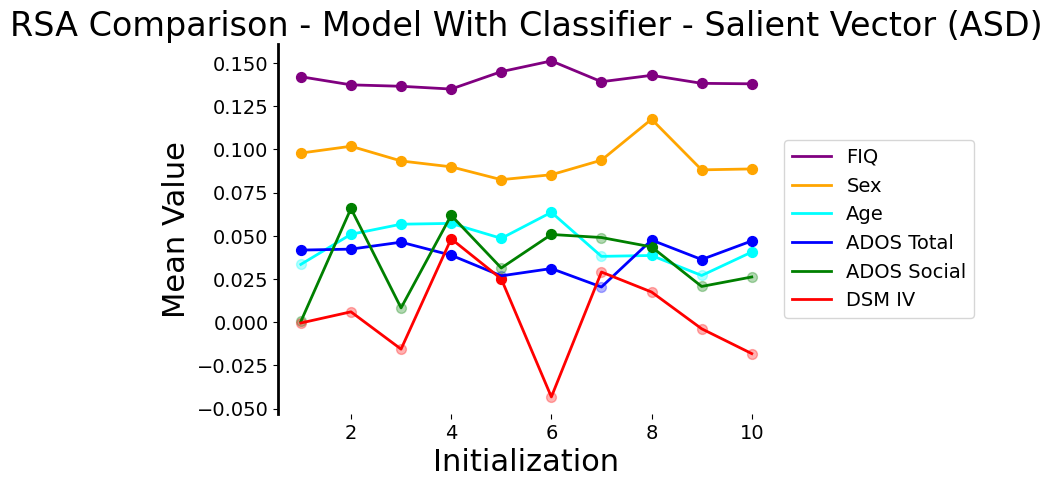

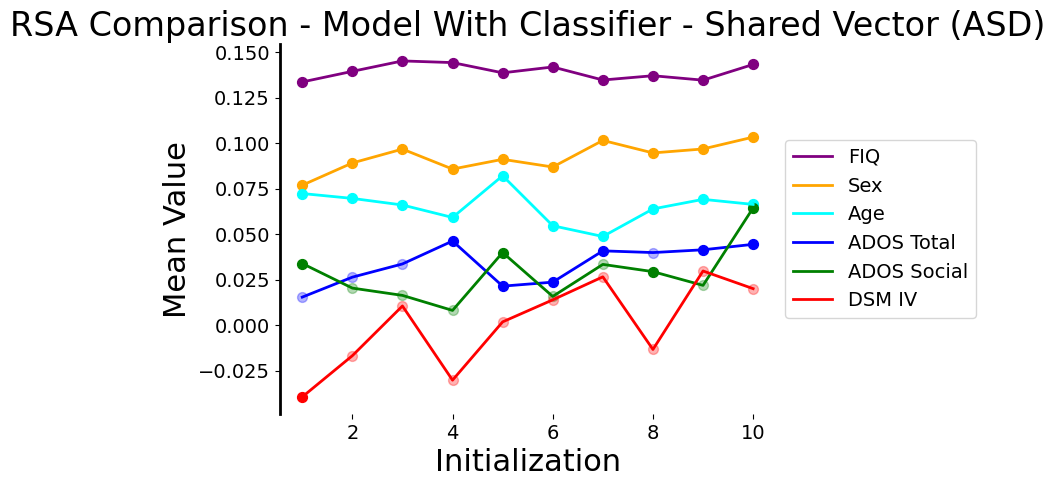

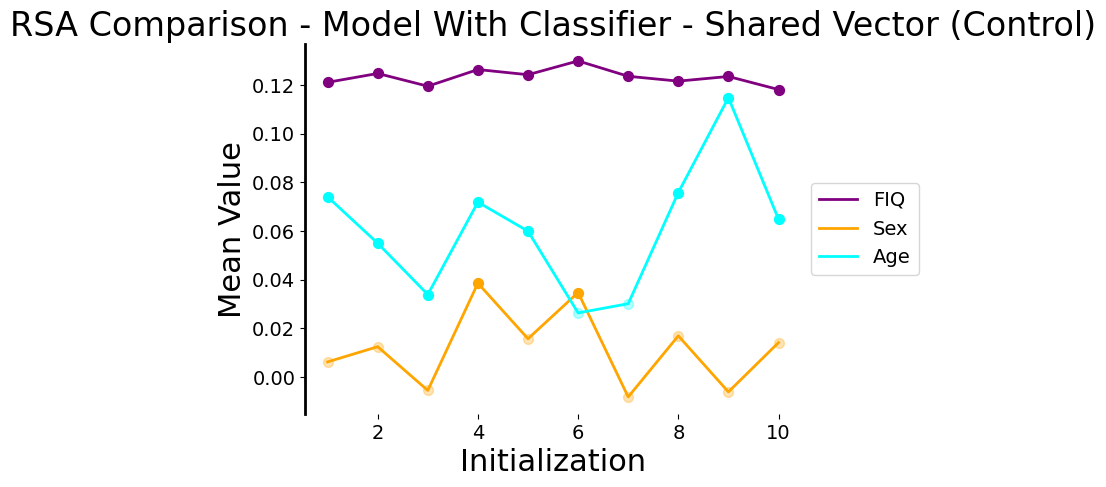

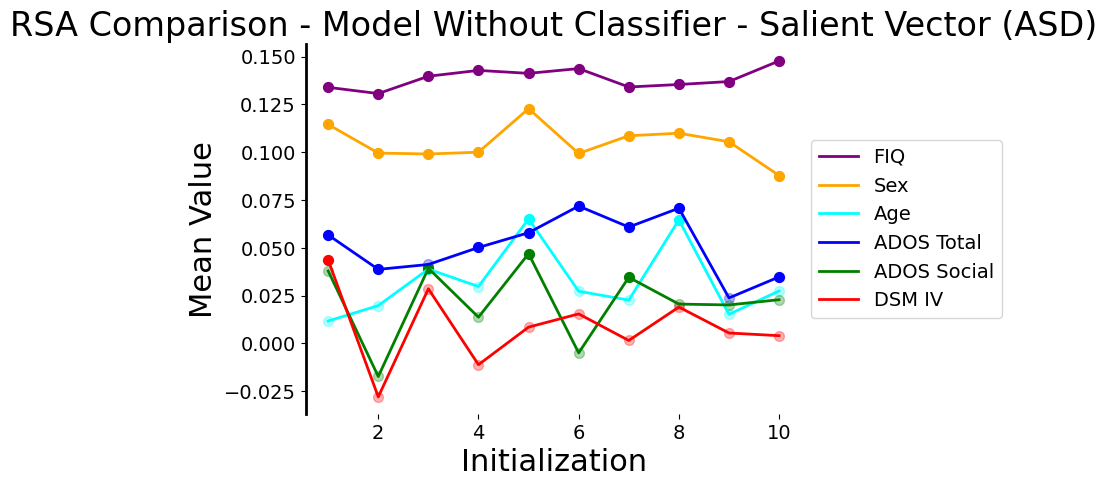

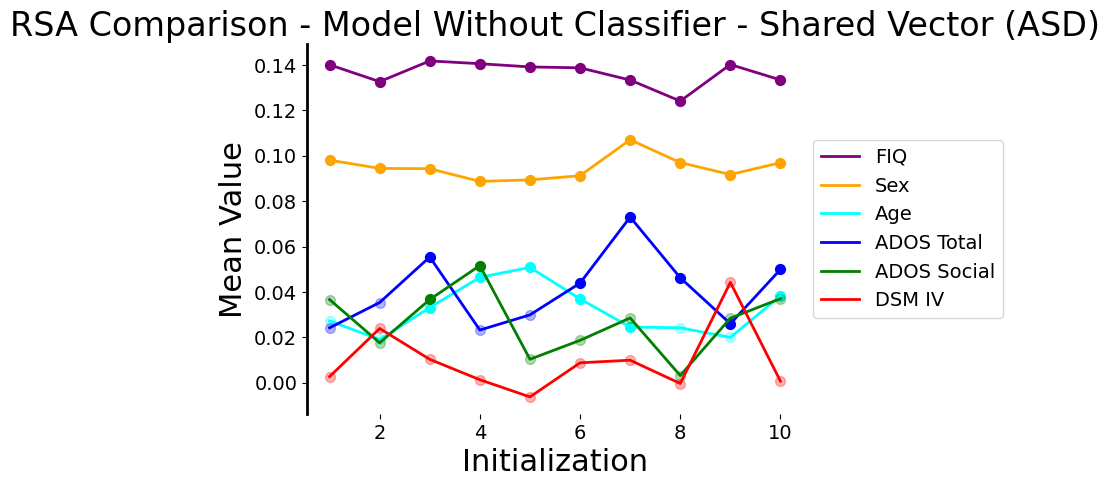

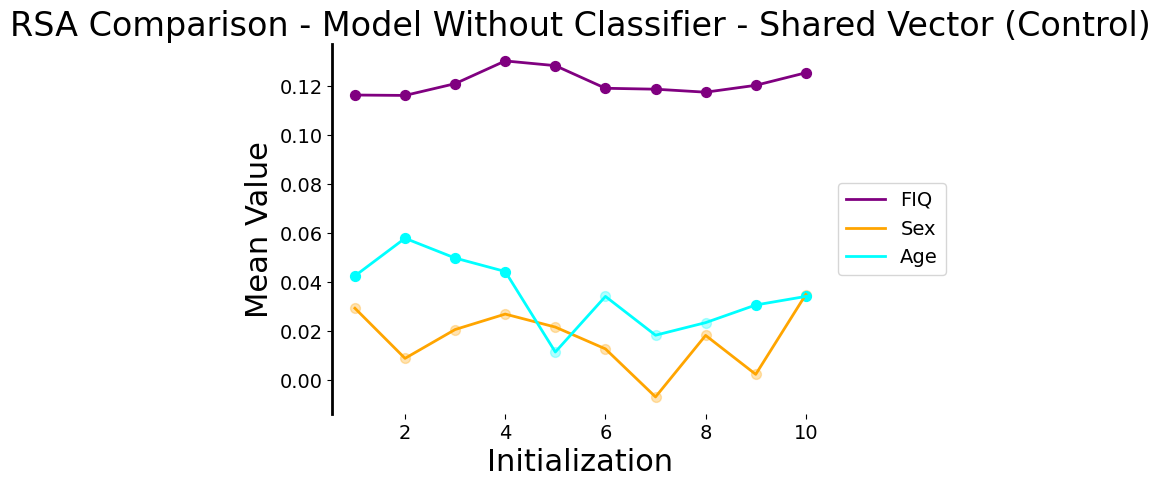

In [93]:
# Create a list of dictionaries and their corresponding titles
results_and_titles = [
    (results_salient_with_classifier_autism, "RSA Comparison - Model With Classifier - Salient Vector (ASD)"),
    (results_with_classifier_autism, "RSA Comparison - Model With Classifier - Shared Vector (ASD)"),
    (results_with_classifier_no_autism, "RSA Comparison - Model With Classifier - Shared Vector (Control)"),
    (results_salient_without_classifier_autism, "RSA Comparison - Model Without Classifier - Salient Vector (ASD)"),
    (results_without_classifier_autism, "RSA Comparison - Model Without Classifier - Shared Vector (ASD)"),
    (results_without_classifier_no_autism, "RSA Comparison - Model Without Classifier - Shared Vector (Control)")
]

legend_order = ['FIQ', 'Sex', 'Age', 'ADOS Total', 'ADOS Social', 'DSM IV']



# Plot each dictionary with its corresponding title
for results_dict, title in results_and_titles:
    plot_means_with_significance(results_dict, title= title, title_fontsize=24, label_fontsize=22, use_opacity=True,
                              legend_loc="right", legend_order=legend_order)

Analyses for Stability of Cortical Thickness Measures

In [ ]:
stability_metrics, cosine_similarity_scores = compute_stability_metrics(reconstructed_difference_dict)

In [ ]:
import cloudpickle as pickle

# Load the ANOVA results from the pickle file
with open('/content/drive/MyDrive/MasterThesisData/anova_results.pkl', 'rb') as file:
    loaded_anova_results = pickle.load(file)


## Various things

Here is the loop to find the optimal learning rate.

Training with learning rate: 0.001
Epoch 1 of 100


4it [00:00, 54.43it/s]               
3it [00:00, 125.88it/s]              


Train Loss Autism: 4.2808, Train Loss Non-Autism: 3.7561,Train Age Loss Autism: 3.9190, Train Age Loss Non-Autism: 3.5602
Epoch 2 of 100


4it [00:00, 79.63it/s]               
3it [00:00, 121.00it/s]              


Train Loss Autism: 4.4194, Train Loss Non-Autism: 3.8259,Train Age Loss Autism: 4.1026, Train Age Loss Non-Autism: 3.6428
Epoch 3 of 100


4it [00:00, 79.57it/s]               
3it [00:00, 132.62it/s]              


Train Loss Autism: 4.1067, Train Loss Non-Autism: 3.5159,Train Age Loss Autism: 3.7976, Train Age Loss Non-Autism: 3.3380
Epoch 4 of 100


4it [00:00, 74.70it/s]               
3it [00:00, 122.01it/s]              


Train Loss Autism: 4.1119, Train Loss Non-Autism: 3.7351,Train Age Loss Autism: 3.8100, Train Age Loss Non-Autism: 3.5613
Epoch 5 of 100


4it [00:00, 65.50it/s]               
3it [00:00, 129.14it/s]              


Train Loss Autism: 4.2778, Train Loss Non-Autism: 3.4260,Train Age Loss Autism: 3.9846, Train Age Loss Non-Autism: 3.2574
Epoch 6 of 100


4it [00:00, 70.17it/s]               
3it [00:00, 99.10it/s]               


Train Loss Autism: 4.5918, Train Loss Non-Autism: 3.6842,Train Age Loss Autism: 4.3074, Train Age Loss Non-Autism: 3.5214
Epoch 7 of 100


4it [00:00, 76.96it/s]               
3it [00:00, 134.55it/s]              


Train Loss Autism: 4.5601, Train Loss Non-Autism: 3.5916,Train Age Loss Autism: 4.2842, Train Age Loss Non-Autism: 3.4342
Epoch 8 of 100


4it [00:00, 71.60it/s]               
3it [00:00, 125.23it/s]              


Train Loss Autism: 4.0570, Train Loss Non-Autism: 3.8254,Train Age Loss Autism: 3.7903, Train Age Loss Non-Autism: 3.6745
Epoch 9 of 100


4it [00:00, 78.88it/s]               
3it [00:00, 120.31it/s]              


Train Loss Autism: 4.0851, Train Loss Non-Autism: 3.7256,Train Age Loss Autism: 3.8272, Train Age Loss Non-Autism: 3.5804
Epoch 10 of 100


4it [00:00, 73.56it/s]               
3it [00:00, 127.76it/s]              


Train Loss Autism: 4.3203, Train Loss Non-Autism: 3.5874,Train Age Loss Autism: 4.0719, Train Age Loss Non-Autism: 3.4491
Epoch 11 of 100


4it [00:00, 74.85it/s]               
3it [00:00, 117.85it/s]              


Train Loss Autism: 4.0999, Train Loss Non-Autism: 3.6161,Train Age Loss Autism: 3.8597, Train Age Loss Non-Autism: 3.4832
Epoch 12 of 100


4it [00:00, 74.38it/s]               
3it [00:00, 107.81it/s]              


Train Loss Autism: 4.0222, Train Loss Non-Autism: 3.7079,Train Age Loss Autism: 3.7886, Train Age Loss Non-Autism: 3.5805
Epoch 13 of 100


4it [00:00, 81.15it/s]               
3it [00:00, 133.94it/s]              


Train Loss Autism: 4.1785, Train Loss Non-Autism: 3.8380,Train Age Loss Autism: 3.9506, Train Age Loss Non-Autism: 3.7154
Epoch 14 of 100


4it [00:00, 74.32it/s]               
3it [00:00, 119.73it/s]              


Train Loss Autism: 4.0682, Train Loss Non-Autism: 3.7963,Train Age Loss Autism: 3.8471, Train Age Loss Non-Autism: 3.6778
Epoch 15 of 100


4it [00:00, 62.93it/s]               
3it [00:00, 104.87it/s]              


Train Loss Autism: 4.3215, Train Loss Non-Autism: 3.9661,Train Age Loss Autism: 4.1051, Train Age Loss Non-Autism: 3.8518
Epoch 16 of 100


4it [00:00, 76.45it/s]               
3it [00:00, 114.77it/s]              


Train Loss Autism: 3.9347, Train Loss Non-Autism: 3.6004,Train Age Loss Autism: 3.7246, Train Age Loss Non-Autism: 3.4896
Epoch 17 of 100


4it [00:00, 40.71it/s]               
3it [00:00, 57.10it/s]               


Train Loss Autism: 3.9495, Train Loss Non-Autism: 3.7781,Train Age Loss Autism: 3.7439, Train Age Loss Non-Autism: 3.6702
Epoch 18 of 100


4it [00:00, 48.29it/s]               
3it [00:00, 75.30it/s]               


Train Loss Autism: 3.7500, Train Loss Non-Autism: 3.5274,Train Age Loss Autism: 3.5499, Train Age Loss Non-Autism: 3.4227
Epoch 19 of 100


4it [00:00, 29.00it/s]
3it [00:00, 61.95it/s]               


Train Loss Autism: 3.8245, Train Loss Non-Autism: 3.4551,Train Age Loss Autism: 3.6295, Train Age Loss Non-Autism: 3.3533
Epoch 20 of 100


4it [00:00, 43.46it/s]               
3it [00:00, 38.85it/s]               


Train Loss Autism: 3.9647, Train Loss Non-Autism: 3.4261,Train Age Loss Autism: 3.7748, Train Age Loss Non-Autism: 3.3265
Epoch 21 of 100


4it [00:00, 30.01it/s]
3it [00:00, 47.86it/s]               


Train Loss Autism: 3.7310, Train Loss Non-Autism: 3.4933,Train Age Loss Autism: 3.5451, Train Age Loss Non-Autism: 3.3968
Epoch 22 of 100


4it [00:00, 24.30it/s]                       
3it [00:00, 83.04it/s]               


Train Loss Autism: 3.8393, Train Loss Non-Autism: 3.4896,Train Age Loss Autism: 3.6577, Train Age Loss Non-Autism: 3.3950
Epoch 23 of 100


4it [00:00, 48.98it/s]               
3it [00:00, 86.36it/s]               


Train Loss Autism: 3.9911, Train Loss Non-Autism: 3.5769,Train Age Loss Autism: 3.8137, Train Age Loss Non-Autism: 3.4850
Epoch 24 of 100


4it [00:00, 43.54it/s]               
3it [00:00, 58.65it/s]               


Train Loss Autism: 3.9898, Train Loss Non-Autism: 3.5933,Train Age Loss Autism: 3.8169, Train Age Loss Non-Autism: 3.5041
Epoch 25 of 100


4it [00:00, 18.33it/s]                       
3it [00:00, 44.04it/s]               


Train Loss Autism: 3.8907, Train Loss Non-Autism: 3.3593,Train Age Loss Autism: 3.7215, Train Age Loss Non-Autism: 3.2722
Epoch 26 of 100


4it [00:00, 36.93it/s]
3it [00:00, 85.41it/s]               


Train Loss Autism: 3.8116, Train Loss Non-Autism: 3.6524,Train Age Loss Autism: 3.6459, Train Age Loss Non-Autism: 3.5675
Epoch 27 of 100


4it [00:00, 36.17it/s]
3it [00:00, 53.44it/s]               


Train Loss Autism: 3.7350, Train Loss Non-Autism: 3.6221,Train Age Loss Autism: 3.5724, Train Age Loss Non-Autism: 3.5390
Epoch 28 of 100


4it [00:00, 24.04it/s]                       
3it [00:00, 43.26it/s]               


Train Loss Autism: 4.0630, Train Loss Non-Autism: 3.6489,Train Age Loss Autism: 3.9045, Train Age Loss Non-Autism: 3.5680
Epoch 29 of 100


4it [00:00, 45.93it/s]               
3it [00:00, 79.76it/s]               


Train Loss Autism: 4.1317, Train Loss Non-Autism: 3.1998,Train Age Loss Autism: 3.9767, Train Age Loss Non-Autism: 3.1201
Epoch 30 of 100


4it [00:00, 44.40it/s]               
3it [00:00, 59.80it/s]               


Train Loss Autism: 3.8664, Train Loss Non-Autism: 3.6106,Train Age Loss Autism: 3.7147, Train Age Loss Non-Autism: 3.5331
Epoch 31 of 100


4it [00:00, 33.99it/s]
3it [00:00, 79.25it/s]               


Train Loss Autism: 3.9306, Train Loss Non-Autism: 3.6943,Train Age Loss Autism: 3.7820, Train Age Loss Non-Autism: 3.6183
Epoch 32 of 100


4it [00:00, 46.71it/s]               
3it [00:00, 65.54it/s]               


Train Loss Autism: 3.8140, Train Loss Non-Autism: 3.7290,Train Age Loss Autism: 3.6680, Train Age Loss Non-Autism: 3.6549
Epoch 33 of 100


4it [00:00, 49.17it/s]               
3it [00:00, 62.97it/s]               


Train Loss Autism: 4.1893, Train Loss Non-Autism: 3.3521,Train Age Loss Autism: 4.0462, Train Age Loss Non-Autism: 3.2793
Epoch 34 of 100


4it [00:00, 48.64it/s]               
3it [00:00, 88.30it/s]               


Train Loss Autism: 4.1933, Train Loss Non-Autism: 3.4493,Train Age Loss Autism: 4.0532, Train Age Loss Non-Autism: 3.3784
Epoch 35 of 100


4it [00:00, 42.40it/s]               
3it [00:00, 72.32it/s]               


Train Loss Autism: 3.9939, Train Loss Non-Autism: 3.5216,Train Age Loss Autism: 3.8561, Train Age Loss Non-Autism: 3.4520
Epoch 36 of 100


4it [00:00, 42.40it/s]               
3it [00:00, 35.76it/s]               


Train Loss Autism: 3.7703, Train Loss Non-Autism: 3.6007,Train Age Loss Autism: 3.6353, Train Age Loss Non-Autism: 3.5324
Epoch 37 of 100


4it [00:00, 43.95it/s]               
3it [00:00, 73.03it/s]               


Train Loss Autism: 4.2173, Train Loss Non-Autism: 3.6980,Train Age Loss Autism: 4.0850, Train Age Loss Non-Autism: 3.6312
Epoch 38 of 100


4it [00:00, 43.32it/s]               
3it [00:00, 86.92it/s]               


Train Loss Autism: 3.6201, Train Loss Non-Autism: 3.4726,Train Age Loss Autism: 3.4895, Train Age Loss Non-Autism: 3.4065
Epoch 39 of 100


4it [00:00, 78.64it/s]               
3it [00:00, 125.09it/s]              


Train Loss Autism: 3.7779, Train Loss Non-Autism: 3.6889,Train Age Loss Autism: 3.6493, Train Age Loss Non-Autism: 3.6242
Epoch 40 of 100


4it [00:00, 46.07it/s]               
3it [00:00, 78.32it/s]               


Train Loss Autism: 3.8036, Train Loss Non-Autism: 3.3611,Train Age Loss Autism: 3.6770, Train Age Loss Non-Autism: 3.2973
Epoch 41 of 100


4it [00:00, 50.94it/s]               
3it [00:00, 81.70it/s]               


Train Loss Autism: 3.9031, Train Loss Non-Autism: 3.4264,Train Age Loss Autism: 3.7785, Train Age Loss Non-Autism: 3.3638
Epoch 42 of 100


4it [00:00, 44.53it/s]               
3it [00:00, 79.47it/s]               


Train Loss Autism: 4.1517, Train Loss Non-Autism: 3.3884,Train Age Loss Autism: 4.0292, Train Age Loss Non-Autism: 3.3266
Epoch 43 of 100


4it [00:00, 50.45it/s]               
3it [00:00, 61.75it/s]               


Train Loss Autism: 3.6829, Train Loss Non-Autism: 3.5272,Train Age Loss Autism: 3.5621, Train Age Loss Non-Autism: 3.4660
Epoch 44 of 100


4it [00:00, 48.53it/s]               
3it [00:00, 74.19it/s]               


Train Loss Autism: 3.6347, Train Loss Non-Autism: 3.3064,Train Age Loss Autism: 3.5155, Train Age Loss Non-Autism: 3.2461
Epoch 45 of 100


4it [00:00, 49.77it/s]               
3it [00:00, 74.69it/s]               


Train Loss Autism: 3.8061, Train Loss Non-Autism: 3.5070,Train Age Loss Autism: 3.6882, Train Age Loss Non-Autism: 3.4472
Epoch 46 of 100


4it [00:00, 35.22it/s]
3it [00:00, 50.16it/s]               


Train Loss Autism: 3.7869, Train Loss Non-Autism: 3.3769,Train Age Loss Autism: 3.6711, Train Age Loss Non-Autism: 3.3181
Epoch 47 of 100


4it [00:00, 44.07it/s]               
3it [00:00, 79.43it/s]               


Train Loss Autism: 3.6654, Train Loss Non-Autism: 3.5442,Train Age Loss Autism: 3.5505, Train Age Loss Non-Autism: 3.4860
Epoch 48 of 100


4it [00:00, 50.19it/s]               
3it [00:00, 85.91it/s]               


Train Loss Autism: 3.8311, Train Loss Non-Autism: 3.2181,Train Age Loss Autism: 3.7174, Train Age Loss Non-Autism: 3.1604
Epoch 49 of 100


4it [00:00, 47.68it/s]               
3it [00:00, 89.60it/s]               


Train Loss Autism: 4.5198, Train Loss Non-Autism: 3.4495,Train Age Loss Autism: 4.4074, Train Age Loss Non-Autism: 3.3923
Epoch 50 of 100


4it [00:00, 41.13it/s]               
3it [00:00, 62.68it/s]               


Train Loss Autism: 3.8782, Train Loss Non-Autism: 3.2514,Train Age Loss Autism: 3.7665, Train Age Loss Non-Autism: 3.1944
Epoch 51 of 100


4it [00:00, 49.86it/s]               
3it [00:00, 89.33it/s]               


Train Loss Autism: 3.6357, Train Loss Non-Autism: 3.4912,Train Age Loss Autism: 3.5253, Train Age Loss Non-Autism: 3.4347
Epoch 52 of 100


4it [00:00, 53.18it/s]               
3it [00:00, 65.95it/s]               


Train Loss Autism: 3.8404, Train Loss Non-Autism: 3.4205,Train Age Loss Autism: 3.7308, Train Age Loss Non-Autism: 3.3644
Epoch 53 of 100


4it [00:00, 44.16it/s]               
3it [00:00, 74.52it/s]               


Train Loss Autism: 3.5743, Train Loss Non-Autism: 3.5102,Train Age Loss Autism: 3.4653, Train Age Loss Non-Autism: 3.4542
Epoch 54 of 100


4it [00:00, 45.64it/s]               
3it [00:00, 87.63it/s]               


Train Loss Autism: 3.7794, Train Loss Non-Autism: 3.1847,Train Age Loss Autism: 3.6709, Train Age Loss Non-Autism: 3.1290
Epoch 55 of 100


4it [00:00, 46.72it/s]               
3it [00:00, 82.69it/s]               


Train Loss Autism: 3.7299, Train Loss Non-Autism: 3.5033,Train Age Loss Autism: 3.6216, Train Age Loss Non-Autism: 3.4472
Epoch 56 of 100


4it [00:00, 44.18it/s]               
3it [00:00, 72.57it/s]               


Train Loss Autism: 3.6078, Train Loss Non-Autism: 3.2312,Train Age Loss Autism: 3.5004, Train Age Loss Non-Autism: 3.1755
Epoch 57 of 100


4it [00:00, 46.25it/s]               
3it [00:00, 76.91it/s]               


Train Loss Autism: 3.9029, Train Loss Non-Autism: 3.1399,Train Age Loss Autism: 3.7958, Train Age Loss Non-Autism: 3.0840
Epoch 58 of 100


4it [00:00, 51.46it/s]               
3it [00:00, 88.85it/s]               


Train Loss Autism: 3.5493, Train Loss Non-Autism: 3.3249,Train Age Loss Autism: 3.4425, Train Age Loss Non-Autism: 3.2695
Epoch 59 of 100


4it [00:00, 49.03it/s]               
3it [00:00, 91.45it/s]               


Train Loss Autism: 3.9826, Train Loss Non-Autism: 3.3425,Train Age Loss Autism: 3.8756, Train Age Loss Non-Autism: 3.2866
Epoch 60 of 100


4it [00:00, 45.38it/s]               
3it [00:00, 90.43it/s]               


Train Loss Autism: 3.4833, Train Loss Non-Autism: 3.1853,Train Age Loss Autism: 3.3764, Train Age Loss Non-Autism: 3.1292
Epoch 61 of 100


4it [00:00, 52.97it/s]               
3it [00:00, 63.64it/s]               


Train Loss Autism: 3.6483, Train Loss Non-Autism: 3.3211,Train Age Loss Autism: 3.5416, Train Age Loss Non-Autism: 3.2649
Epoch 62 of 100


4it [00:00, 49.34it/s]               
3it [00:00, 87.59it/s]               


Train Loss Autism: 3.5258, Train Loss Non-Autism: 3.1744,Train Age Loss Autism: 3.4191, Train Age Loss Non-Autism: 3.1181
Epoch 63 of 100


4it [00:00, 47.75it/s]               
3it [00:00, 82.29it/s]               


Train Loss Autism: 3.7629, Train Loss Non-Autism: 3.1066,Train Age Loss Autism: 3.6555, Train Age Loss Non-Autism: 3.0495
Epoch 64 of 100


4it [00:00, 51.71it/s]               
3it [00:00, 76.69it/s]               


Train Loss Autism: 3.4351, Train Loss Non-Autism: 3.2928,Train Age Loss Autism: 3.3278, Train Age Loss Non-Autism: 3.2357
Epoch 65 of 100


4it [00:00, 49.61it/s]               
3it [00:00, 66.59it/s]               


Train Loss Autism: 3.4416, Train Loss Non-Autism: 3.2030,Train Age Loss Autism: 3.3338, Train Age Loss Non-Autism: 3.1453
Epoch 66 of 100


4it [00:00, 50.24it/s]               
3it [00:00, 78.00it/s]               


Train Loss Autism: 3.5238, Train Loss Non-Autism: 3.6363,Train Age Loss Autism: 3.4152, Train Age Loss Non-Autism: 3.5783
Epoch 67 of 100


4it [00:00, 50.53it/s]               
3it [00:00, 80.60it/s]               


Train Loss Autism: 3.5002, Train Loss Non-Autism: 3.4330,Train Age Loss Autism: 3.3912, Train Age Loss Non-Autism: 3.3742
Epoch 68 of 100


4it [00:00, 52.95it/s]               
3it [00:00, 80.53it/s]               


Train Loss Autism: 3.3564, Train Loss Non-Autism: 3.1051,Train Age Loss Autism: 3.2468, Train Age Loss Non-Autism: 3.0458
Epoch 69 of 100


4it [00:00, 50.59it/s]               
3it [00:00, 66.62it/s]               


Train Loss Autism: 4.0997, Train Loss Non-Autism: 3.4216,Train Age Loss Autism: 3.9894, Train Age Loss Non-Autism: 3.3617
Epoch 70 of 100


4it [00:00, 51.52it/s]               
3it [00:00, 77.28it/s]               


Train Loss Autism: 3.6751, Train Loss Non-Autism: 3.1071,Train Age Loss Autism: 3.5634, Train Age Loss Non-Autism: 3.0461
Epoch 71 of 100


4it [00:00, 51.60it/s]               
3it [00:00, 89.03it/s]               


Train Loss Autism: 3.9863, Train Loss Non-Autism: 3.4237,Train Age Loss Autism: 3.8738, Train Age Loss Non-Autism: 3.3621
Epoch 72 of 100


4it [00:00, 49.28it/s]               
3it [00:00, 73.32it/s]               


Train Loss Autism: 3.4724, Train Loss Non-Autism: 2.9725,Train Age Loss Autism: 3.3588, Train Age Loss Non-Autism: 2.9100
Epoch 73 of 100


4it [00:00, 44.58it/s]               
3it [00:00, 87.51it/s]               


Train Loss Autism: 3.4609, Train Loss Non-Autism: 3.1516,Train Age Loss Autism: 3.3455, Train Age Loss Non-Autism: 3.0878
Epoch 74 of 100


4it [00:00, 52.45it/s]               
3it [00:00, 36.63it/s]               


Train Loss Autism: 3.6147, Train Loss Non-Autism: 3.3757,Train Age Loss Autism: 3.4986, Train Age Loss Non-Autism: 3.3115
Epoch 75 of 100


4it [00:00, 25.84it/s]                       
3it [00:00, 64.34it/s]               


Train Loss Autism: 3.5613, Train Loss Non-Autism: 3.1852,Train Age Loss Autism: 3.4435, Train Age Loss Non-Autism: 3.1194
Epoch 76 of 100


4it [00:00, 46.98it/s]               
3it [00:00, 26.52it/s]


Train Loss Autism: 4.0685, Train Loss Non-Autism: 3.2490,Train Age Loss Autism: 3.9491, Train Age Loss Non-Autism: 3.1822
Epoch 77 of 100


4it [00:00, 20.12it/s]                       
3it [00:00, 41.70it/s]               


Train Loss Autism: 3.4006, Train Loss Non-Autism: 3.0499,Train Age Loss Autism: 3.2798, Train Age Loss Non-Autism: 2.9822
Epoch 78 of 100


4it [00:00, 35.82it/s]
3it [00:00, 77.69it/s]               


Train Loss Autism: 3.5851, Train Loss Non-Autism: 3.5025,Train Age Loss Autism: 3.4617, Train Age Loss Non-Autism: 3.4329
Epoch 79 of 100


4it [00:00, 49.48it/s]               
3it [00:00, 84.73it/s]               


Train Loss Autism: 3.4072, Train Loss Non-Autism: 3.0885,Train Age Loss Autism: 3.2823, Train Age Loss Non-Autism: 3.0175
Epoch 80 of 100


4it [00:00, 54.49it/s]               
3it [00:00, 128.14it/s]              


Train Loss Autism: 3.1985, Train Loss Non-Autism: 3.1619,Train Age Loss Autism: 3.0715, Train Age Loss Non-Autism: 3.0899
Epoch 81 of 100


4it [00:00, 72.02it/s]               
3it [00:00, 109.58it/s]              


Train Loss Autism: 3.4189, Train Loss Non-Autism: 2.9546,Train Age Loss Autism: 3.2899, Train Age Loss Non-Autism: 2.8810
Epoch 82 of 100


4it [00:00, 79.87it/s]               
3it [00:00, 136.11it/s]              


Train Loss Autism: 3.3298, Train Loss Non-Autism: 3.0944,Train Age Loss Autism: 3.1988, Train Age Loss Non-Autism: 3.0193
Epoch 83 of 100


4it [00:00, 73.99it/s]               
3it [00:00, 117.96it/s]              


Train Loss Autism: 3.2712, Train Loss Non-Autism: 2.8900,Train Age Loss Autism: 3.1379, Train Age Loss Non-Autism: 2.8134
Epoch 84 of 100


4it [00:00, 70.85it/s]               
3it [00:00, 81.92it/s]               


Train Loss Autism: 3.3306, Train Loss Non-Autism: 3.0701,Train Age Loss Autism: 3.1949, Train Age Loss Non-Autism: 2.9917
Epoch 85 of 100


4it [00:00, 75.37it/s]               
3it [00:00, 131.71it/s]              


Train Loss Autism: 3.2685, Train Loss Non-Autism: 3.1177,Train Age Loss Autism: 3.1307, Train Age Loss Non-Autism: 3.0378
Epoch 86 of 100


4it [00:00, 51.49it/s]               
3it [00:00, 129.94it/s]              


Train Loss Autism: 3.3875, Train Loss Non-Autism: 3.1605,Train Age Loss Autism: 3.2472, Train Age Loss Non-Autism: 3.0789
Epoch 87 of 100


4it [00:00, 57.78it/s]               
3it [00:00, 99.67it/s]               


Train Loss Autism: 3.3693, Train Loss Non-Autism: 3.5593,Train Age Loss Autism: 3.2264, Train Age Loss Non-Autism: 3.4759
Epoch 88 of 100


4it [00:00, 77.15it/s]               
3it [00:00, 128.32it/s]              


Train Loss Autism: 3.4774, Train Loss Non-Autism: 3.1420,Train Age Loss Autism: 3.3317, Train Age Loss Non-Autism: 3.0566
Epoch 89 of 100


4it [00:00, 72.53it/s]               
3it [00:00, 90.83it/s]               


Train Loss Autism: 3.4438, Train Loss Non-Autism: 3.3891,Train Age Loss Autism: 3.2951, Train Age Loss Non-Autism: 3.3017
Epoch 90 of 100


4it [00:00, 73.23it/s]               
3it [00:00, 120.09it/s]              


Train Loss Autism: 3.4231, Train Loss Non-Autism: 3.0699,Train Age Loss Autism: 3.2710, Train Age Loss Non-Autism: 2.9799
Epoch 91 of 100


4it [00:00, 78.27it/s]               
3it [00:00, 134.81it/s]              


Train Loss Autism: 3.3287, Train Loss Non-Autism: 3.3537,Train Age Loss Autism: 3.1734, Train Age Loss Non-Autism: 3.2615
Epoch 92 of 100


4it [00:00, 74.33it/s]               
3it [00:00, 100.66it/s]              


Train Loss Autism: 3.3713, Train Loss Non-Autism: 3.3263,Train Age Loss Autism: 3.2130, Train Age Loss Non-Autism: 3.2322
Epoch 93 of 100


4it [00:00, 62.25it/s]               
3it [00:00, 113.12it/s]              


Train Loss Autism: 3.2473, Train Loss Non-Autism: 3.1304,Train Age Loss Autism: 3.0848, Train Age Loss Non-Autism: 3.0333
Epoch 94 of 100


4it [00:00, 67.99it/s]               
3it [00:00, 111.18it/s]              


Train Loss Autism: 3.3894, Train Loss Non-Autism: 3.2224,Train Age Loss Autism: 3.2237, Train Age Loss Non-Autism: 3.1230
Epoch 95 of 100


4it [00:00, 75.87it/s]               
3it [00:00, 136.75it/s]              


Train Loss Autism: 3.4203, Train Loss Non-Autism: 3.0551,Train Age Loss Autism: 3.2508, Train Age Loss Non-Autism: 2.9531
Epoch 96 of 100


4it [00:00, 66.62it/s]               
3it [00:00, 114.23it/s]              


Train Loss Autism: 3.3770, Train Loss Non-Autism: 2.9677,Train Age Loss Autism: 3.2026, Train Age Loss Non-Autism: 2.8624
Epoch 97 of 100


4it [00:00, 61.45it/s]               
3it [00:00, 114.60it/s]              


Train Loss Autism: 3.0988, Train Loss Non-Autism: 3.0326,Train Age Loss Autism: 2.9217, Train Age Loss Non-Autism: 2.9256
Epoch 98 of 100


4it [00:00, 79.57it/s]               
3it [00:00, 150.60it/s]              


Train Loss Autism: 3.6331, Train Loss Non-Autism: 2.9030,Train Age Loss Autism: 3.4505, Train Age Loss Non-Autism: 2.7919
Epoch 99 of 100


4it [00:00, 68.45it/s]               
3it [00:00, 117.04it/s]              


Train Loss Autism: 3.4266, Train Loss Non-Autism: 2.9027,Train Age Loss Autism: 3.2407, Train Age Loss Non-Autism: 2.7896
Epoch 100 of 100


4it [00:00, 54.58it/s]               
3it [00:00, 105.21it/s]              


Train Loss Autism: 3.0098, Train Loss Non-Autism: 2.8273,Train Age Loss Autism: 2.8193, Train Age Loss Non-Autism: 2.7110
Training with learning rate: 0.01
Epoch 1 of 100


4it [00:00, 67.64it/s]               
3it [00:00, 110.75it/s]              


Train Loss Autism: 4.4041, Train Loss Non-Autism: 3.4768,Train Age Loss Autism: 4.0640, Train Age Loss Non-Autism: 3.3006
Epoch 2 of 100


4it [00:00, 73.15it/s]               
3it [00:00, 114.67it/s]              


Train Loss Autism: 3.9685, Train Loss Non-Autism: 3.4184,Train Age Loss Autism: 3.7429, Train Age Loss Non-Autism: 3.3224
Epoch 3 of 100


4it [00:00, 65.08it/s]               
3it [00:00, 130.16it/s]              


Train Loss Autism: 3.9622, Train Loss Non-Autism: 3.3243,Train Age Loss Autism: 3.7892, Train Age Loss Non-Autism: 3.2536
Epoch 4 of 100


4it [00:00, 61.80it/s]               
3it [00:00, 116.52it/s]              


Train Loss Autism: 3.7529, Train Loss Non-Autism: 3.4757,Train Age Loss Autism: 3.6242, Train Age Loss Non-Autism: 3.4246
Epoch 5 of 100


4it [00:00, 71.61it/s]               
3it [00:00, 110.15it/s]              


Train Loss Autism: 3.7553, Train Loss Non-Autism: 3.5497,Train Age Loss Autism: 3.6568, Train Age Loss Non-Autism: 3.5135
Epoch 6 of 100


4it [00:00, 72.06it/s]               
3it [00:00, 91.42it/s]               


Train Loss Autism: 3.5483, Train Loss Non-Autism: 3.1566,Train Age Loss Autism: 3.4683, Train Age Loss Non-Autism: 3.1282
Epoch 7 of 100


4it [00:00, 54.96it/s]               
3it [00:00, 113.46it/s]              


Train Loss Autism: 3.2870, Train Loss Non-Autism: 3.0634,Train Age Loss Autism: 3.2163, Train Age Loss Non-Autism: 3.0360
Epoch 8 of 100


4it [00:00, 57.57it/s]               
3it [00:00, 102.42it/s]              


Train Loss Autism: 3.3668, Train Loss Non-Autism: 3.4327,Train Age Loss Autism: 3.3015, Train Age Loss Non-Autism: 3.4060
Epoch 9 of 100


4it [00:00, 68.15it/s]               
3it [00:00, 117.51it/s]              


Train Loss Autism: 3.1861, Train Loss Non-Autism: 2.9050,Train Age Loss Autism: 3.1213, Train Age Loss Non-Autism: 2.8777
Epoch 10 of 100


4it [00:00, 76.93it/s]               
3it [00:00, 58.94it/s]               


Train Loss Autism: 3.4547, Train Loss Non-Autism: 3.1268,Train Age Loss Autism: 3.3835, Train Age Loss Non-Autism: 3.0952
Epoch 11 of 100


4it [00:00, 38.13it/s]
3it [00:00, 82.60it/s]               


Train Loss Autism: 3.1442, Train Loss Non-Autism: 3.3192,Train Age Loss Autism: 3.0614, Train Age Loss Non-Autism: 3.2809
Epoch 12 of 100


4it [00:00, 50.72it/s]               
3it [00:00, 108.79it/s]              


Train Loss Autism: 3.2541, Train Loss Non-Autism: 2.7923,Train Age Loss Autism: 3.1536, Train Age Loss Non-Autism: 2.7450
Epoch 13 of 100


4it [00:00, 71.12it/s]               
3it [00:00, 112.11it/s]              


Train Loss Autism: 3.0844, Train Loss Non-Autism: 2.7134,Train Age Loss Autism: 2.9603, Train Age Loss Non-Autism: 2.6542
Epoch 14 of 100


4it [00:00, 73.63it/s]               
3it [00:00, 64.07it/s]               


Train Loss Autism: 3.0882, Train Loss Non-Autism: 2.8881,Train Age Loss Autism: 2.9278, Train Age Loss Non-Autism: 2.8074
Epoch 15 of 100


4it [00:00, 35.58it/s]
3it [00:00, 112.75it/s]              


Train Loss Autism: 2.7897, Train Loss Non-Autism: 2.5910,Train Age Loss Autism: 2.5921, Train Age Loss Non-Autism: 2.4925
Epoch 16 of 100


4it [00:00, 72.97it/s]               
3it [00:00, 110.54it/s]              


Train Loss Autism: 2.7402, Train Loss Non-Autism: 2.4778,Train Age Loss Autism: 2.4823, Train Age Loss Non-Autism: 2.3407
Epoch 17 of 100


4it [00:00, 51.03it/s]               
3it [00:00, 65.50it/s]               


Train Loss Autism: 2.5941, Train Loss Non-Autism: 2.2043,Train Age Loss Autism: 2.2784, Train Age Loss Non-Autism: 2.0346
Epoch 18 of 100


4it [00:00, 30.02it/s]                       
3it [00:00, 65.16it/s]               


Train Loss Autism: 2.2225, Train Loss Non-Autism: 2.2990,Train Age Loss Autism: 1.8381, Train Age Loss Non-Autism: 2.0876
Epoch 19 of 100


4it [00:00, 43.20it/s]               
3it [00:00, 54.30it/s]               


Train Loss Autism: 1.9738, Train Loss Non-Autism: 2.2777,Train Age Loss Autism: 1.5255, Train Age Loss Non-Autism: 2.0284
Epoch 20 of 100


4it [00:00, 25.89it/s]                       
3it [00:00, 36.59it/s]               


Train Loss Autism: 1.8439, Train Loss Non-Autism: 2.0288,Train Age Loss Autism: 1.3272, Train Age Loss Non-Autism: 1.7340
Epoch 21 of 100


4it [00:00, 18.31it/s]                       
3it [00:00, 31.99it/s]               


Train Loss Autism: 2.1179, Train Loss Non-Autism: 2.0004,Train Age Loss Autism: 1.5751, Train Age Loss Non-Autism: 1.6946
Epoch 22 of 100


4it [00:00, 32.81it/s]
3it [00:00, 83.40it/s]               


Train Loss Autism: 2.0450, Train Loss Non-Autism: 1.7412,Train Age Loss Autism: 1.4179, Train Age Loss Non-Autism: 1.3627
Epoch 23 of 100


4it [00:00, 18.23it/s]                       
3it [00:00, 28.76it/s]               


Train Loss Autism: 1.9206, Train Loss Non-Autism: 1.7778,Train Age Loss Autism: 1.3513, Train Age Loss Non-Autism: 1.4644
Epoch 24 of 100


4it [00:00, 21.23it/s]                       
3it [00:00, 64.25it/s]               


Train Loss Autism: 1.7231, Train Loss Non-Autism: 1.6663,Train Age Loss Autism: 1.0978, Train Age Loss Non-Autism: 1.2953
Epoch 25 of 100


4it [00:00, 19.50it/s]
3it [00:00, 37.80it/s]               


Train Loss Autism: 1.7021, Train Loss Non-Autism: 1.7590,Train Age Loss Autism: 1.1062, Train Age Loss Non-Autism: 1.4047
Epoch 26 of 100


4it [00:00, 20.21it/s]                       
3it [00:00, 24.32it/s]


Train Loss Autism: 1.6584, Train Loss Non-Autism: 1.4912,Train Age Loss Autism: 1.1077, Train Age Loss Non-Autism: 1.1624
Epoch 27 of 100


4it [00:00, 23.11it/s]                       
3it [00:00, 38.69it/s]               


Train Loss Autism: 1.6177, Train Loss Non-Autism: 1.4351,Train Age Loss Autism: 1.0841, Train Age Loss Non-Autism: 1.1007
Epoch 28 of 100


4it [00:00, 21.49it/s]                       
3it [00:00, 25.66it/s]


Train Loss Autism: 1.6855, Train Loss Non-Autism: 1.4433,Train Age Loss Autism: 1.1703, Train Age Loss Non-Autism: 1.1058
Epoch 29 of 100


4it [00:00, 21.48it/s]                       
3it [00:00, 27.77it/s]               


Train Loss Autism: 1.9993, Train Loss Non-Autism: 1.4950,Train Age Loss Autism: 1.5197, Train Age Loss Non-Autism: 1.1759
Epoch 30 of 100


4it [00:00, 21.61it/s]                       
3it [00:00, 33.55it/s]               


Train Loss Autism: 1.6721, Train Loss Non-Autism: 1.4608,Train Age Loss Autism: 1.1643, Train Age Loss Non-Autism: 1.1046
Epoch 31 of 100


4it [00:00, 20.53it/s]                       
3it [00:00, 72.66it/s]               


Train Loss Autism: 1.6359, Train Loss Non-Autism: 1.2985,Train Age Loss Autism: 1.1869, Train Age Loss Non-Autism: 0.9923
Epoch 32 of 100


4it [00:00, 29.63it/s]
3it [00:00, 37.08it/s]               


Train Loss Autism: 1.6010, Train Loss Non-Autism: 1.5761,Train Age Loss Autism: 1.1245, Train Age Loss Non-Autism: 1.2347
Epoch 33 of 100


4it [00:00, 18.71it/s]                       
3it [00:00, 27.00it/s]


Train Loss Autism: 1.7295, Train Loss Non-Autism: 1.2157,Train Age Loss Autism: 1.2438, Train Age Loss Non-Autism: 0.8608
Epoch 34 of 100


4it [00:00, 43.91it/s]               
3it [00:00, 126.26it/s]              


Train Loss Autism: 1.7812, Train Loss Non-Autism: 1.5085,Train Age Loss Autism: 1.3176, Train Age Loss Non-Autism: 1.1685
Epoch 35 of 100


4it [00:00, 55.43it/s]               
3it [00:00,  4.14it/s]                       


Train Loss Autism: 1.7869, Train Loss Non-Autism: 1.2812,Train Age Loss Autism: 1.3282, Train Age Loss Non-Autism: 0.9476
Epoch 36 of 100


4it [00:00, 23.59it/s]                       
3it [00:00, 38.68it/s]               


Train Loss Autism: 1.5797, Train Loss Non-Autism: 1.2007,Train Age Loss Autism: 0.9734, Train Age Loss Non-Autism: 0.7078
Epoch 37 of 100


4it [00:00, 21.53it/s]                       
3it [00:00, 43.30it/s]               


Train Loss Autism: 1.6943, Train Loss Non-Autism: 1.4692,Train Age Loss Autism: 1.3547, Train Age Loss Non-Autism: 1.2341
Epoch 38 of 100


4it [00:00, 36.10it/s]
3it [00:00, 34.91it/s]               


Train Loss Autism: 1.7036, Train Loss Non-Autism: 1.3086,Train Age Loss Autism: 1.3135, Train Age Loss Non-Autism: 1.0231
Epoch 39 of 100


4it [00:00, 20.35it/s]                       
3it [00:00, 38.56it/s]               


Train Loss Autism: 1.7801, Train Loss Non-Autism: 1.2632,Train Age Loss Autism: 1.1225, Train Age Loss Non-Autism: 0.7134
Epoch 40 of 100


4it [00:00, 25.38it/s]                       
3it [00:00, 85.54it/s]               


Train Loss Autism: 1.6239, Train Loss Non-Autism: 1.2784,Train Age Loss Autism: 1.2230, Train Age Loss Non-Autism: 0.9734
Epoch 41 of 100


4it [00:00, 49.47it/s]               
3it [00:00, 48.73it/s]               


Train Loss Autism: 1.4954, Train Loss Non-Autism: 1.2286,Train Age Loss Autism: 1.0840, Train Age Loss Non-Autism: 0.9119
Epoch 42 of 100


4it [00:00, 21.99it/s]                       
3it [00:00, 58.80it/s]               


Train Loss Autism: 1.3930, Train Loss Non-Autism: 1.1178,Train Age Loss Autism: 0.9106, Train Age Loss Non-Autism: 0.7222
Epoch 43 of 100


4it [00:00, 25.76it/s]                       
3it [00:00, 30.08it/s]               


Train Loss Autism: 1.3247, Train Loss Non-Autism: 1.0670,Train Age Loss Autism: 0.9896, Train Age Loss Non-Autism: 0.8102
Epoch 44 of 100


4it [00:00, 17.95it/s]                       
3it [00:00, 42.50it/s]               


Train Loss Autism: 1.3992, Train Loss Non-Autism: 1.3425,Train Age Loss Autism: 0.8925, Train Age Loss Non-Autism: 0.8982
Epoch 45 of 100


4it [00:00, 22.13it/s]                       
3it [00:00, 27.96it/s]


Train Loss Autism: 1.3812, Train Loss Non-Autism: 1.0386,Train Age Loss Autism: 1.0625, Train Age Loss Non-Autism: 0.7904
Epoch 46 of 100


4it [00:00, 25.08it/s]                       
3it [00:00, 42.86it/s]               


Train Loss Autism: 1.3992, Train Loss Non-Autism: 1.3552,Train Age Loss Autism: 0.8472, Train Age Loss Non-Autism: 0.8873
Epoch 47 of 100


4it [00:00, 24.50it/s]                       
3it [00:00, 38.86it/s]               


Train Loss Autism: 1.3642, Train Loss Non-Autism: 1.2656,Train Age Loss Autism: 1.1106, Train Age Loss Non-Autism: 1.0752
Epoch 48 of 100


4it [00:00, 23.23it/s]                       
3it [00:00, 38.04it/s]               


Train Loss Autism: 1.2682, Train Loss Non-Autism: 1.1233,Train Age Loss Autism: 0.8449, Train Age Loss Non-Autism: 0.7739
Epoch 49 of 100


4it [00:00, 23.80it/s]                       
3it [00:00, 32.74it/s]               


Train Loss Autism: 1.2803, Train Loss Non-Autism: 1.2224,Train Age Loss Autism: 0.8240, Train Age Loss Non-Autism: 0.8411
Epoch 50 of 100


4it [00:00, 26.75it/s]                       
3it [00:00, 35.47it/s]               


Train Loss Autism: 1.2744, Train Loss Non-Autism: 1.2220,Train Age Loss Autism: 0.9647, Train Age Loss Non-Autism: 0.9756
Epoch 51 of 100


4it [00:00, 14.20it/s]
3it [00:00, 25.14it/s]


Train Loss Autism: 1.2065, Train Loss Non-Autism: 1.1188,Train Age Loss Autism: 0.7366, Train Age Loss Non-Autism: 0.7176
Epoch 52 of 100


4it [00:00, 20.50it/s]                       
3it [00:00, 57.79it/s]               


Train Loss Autism: 1.1522, Train Loss Non-Autism: 0.9860,Train Age Loss Autism: 0.8425, Train Age Loss Non-Autism: 0.7330
Epoch 53 of 100


4it [00:00, 30.81it/s]
3it [00:00, 81.16it/s]               


Train Loss Autism: 1.2870, Train Loss Non-Autism: 0.9914,Train Age Loss Autism: 0.9076, Train Age Loss Non-Autism: 0.6748
Epoch 54 of 100


4it [00:00, 30.97it/s]                       
3it [00:00, 79.12it/s]               


Train Loss Autism: 1.1668, Train Loss Non-Autism: 0.9598,Train Age Loss Autism: 0.7299, Train Age Loss Non-Autism: 0.5719
Epoch 55 of 100


4it [00:00, 19.29it/s]                       
3it [00:00, 38.29it/s]               


Train Loss Autism: 1.1001, Train Loss Non-Autism: 1.0936,Train Age Loss Autism: 0.8561, Train Age Loss Non-Autism: 0.8865
Epoch 56 of 100


4it [00:00, 18.28it/s]                       
3it [00:00, 35.17it/s]               


Train Loss Autism: 1.1749, Train Loss Non-Autism: 0.9881,Train Age Loss Autism: 0.7586, Train Age Loss Non-Autism: 0.6205
Epoch 57 of 100


4it [00:00, 20.18it/s]                       
3it [00:00, 30.04it/s]               


Train Loss Autism: 1.1185, Train Loss Non-Autism: 1.1997,Train Age Loss Autism: 0.7035, Train Age Loss Non-Autism: 0.8414
Epoch 58 of 100


4it [00:00, 26.54it/s]                       
3it [00:00, 34.91it/s]               


Train Loss Autism: 1.0061, Train Loss Non-Autism: 1.0033,Train Age Loss Autism: 0.7214, Train Age Loss Non-Autism: 0.7569
Epoch 59 of 100


4it [00:00, 40.81it/s]               
3it [00:00, 39.16it/s]               


Train Loss Autism: 1.2067, Train Loss Non-Autism: 0.8875,Train Age Loss Autism: 0.7636, Train Age Loss Non-Autism: 0.4959
Epoch 60 of 100


4it [00:00, 21.06it/s]                       
3it [00:00, 40.91it/s]               


Train Loss Autism: 1.1540, Train Loss Non-Autism: 1.0080,Train Age Loss Autism: 0.9201, Train Age Loss Non-Autism: 0.8046
Epoch 61 of 100


4it [00:00, 23.24it/s]                       
3it [00:00, 26.17it/s]


Train Loss Autism: 1.0987, Train Loss Non-Autism: 0.9229,Train Age Loss Autism: 0.7337, Train Age Loss Non-Autism: 0.5972
Epoch 62 of 100


4it [00:00, 23.12it/s]                       
3it [00:00, 31.86it/s]               


Train Loss Autism: 1.1316, Train Loss Non-Autism: 0.9476,Train Age Loss Autism: 0.8005, Train Age Loss Non-Autism: 0.6375
Epoch 63 of 100


4it [00:00, 28.06it/s]                       
3it [00:00, 50.70it/s]               


Train Loss Autism: 1.1694, Train Loss Non-Autism: 1.0023,Train Age Loss Autism: 0.9182, Train Age Loss Non-Autism: 0.7868
Epoch 64 of 100


4it [00:00, 31.06it/s]                       
3it [00:00, 81.20it/s]               


Train Loss Autism: 1.1880, Train Loss Non-Autism: 0.9699,Train Age Loss Autism: 0.7757, Train Age Loss Non-Autism: 0.6033
Epoch 65 of 100


4it [00:00, 22.57it/s]                       
3it [00:00, 58.53it/s]               


Train Loss Autism: 1.3324, Train Loss Non-Autism: 0.8038,Train Age Loss Autism: 1.1155, Train Age Loss Non-Autism: 0.6144
Epoch 66 of 100


4it [00:00, 63.04it/s]               
3it [00:00, 119.52it/s]              


Train Loss Autism: 1.0064, Train Loss Non-Autism: 0.7886,Train Age Loss Autism: 0.6650, Train Age Loss Non-Autism: 0.4817
Epoch 67 of 100


4it [00:00, 42.68it/s]               
3it [00:00, 33.63it/s]               


Train Loss Autism: 1.0100, Train Loss Non-Autism: 0.8878,Train Age Loss Autism: 0.7589, Train Age Loss Non-Autism: 0.6665
Epoch 68 of 100


4it [00:00, 41.01it/s]               
3it [00:00, 79.52it/s]               


Train Loss Autism: 0.8473, Train Loss Non-Autism: 0.7847,Train Age Loss Autism: 0.5949, Train Age Loss Non-Autism: 0.5591
Epoch 69 of 100


4it [00:00, 42.78it/s]               
3it [00:00, 52.84it/s]               


Train Loss Autism: 0.9217, Train Loss Non-Autism: 0.7367,Train Age Loss Autism: 0.6114, Train Age Loss Non-Autism: 0.4568
Epoch 70 of 100


4it [00:00, 36.44it/s]
3it [00:00, 79.28it/s]               


Train Loss Autism: 1.0406, Train Loss Non-Autism: 0.8197,Train Age Loss Autism: 0.8442, Train Age Loss Non-Autism: 0.6439
Epoch 71 of 100


4it [00:00, 47.46it/s]               
3it [00:00, 83.06it/s]               


Train Loss Autism: 0.8750, Train Loss Non-Autism: 0.7205,Train Age Loss Autism: 0.5652, Train Age Loss Non-Autism: 0.4352
Epoch 72 of 100


4it [00:00, 43.62it/s]               
3it [00:00, 76.27it/s]               


Train Loss Autism: 0.8955, Train Loss Non-Autism: 0.8734,Train Age Loss Autism: 0.6837, Train Age Loss Non-Autism: 0.6857
Epoch 73 of 100


4it [00:00, 42.84it/s]               
3it [00:00, 68.09it/s]               


Train Loss Autism: 0.8497, Train Loss Non-Autism: 0.8048,Train Age Loss Autism: 0.6178, Train Age Loss Non-Autism: 0.5976
Epoch 74 of 100


4it [00:00, 40.71it/s]               
3it [00:00, 52.34it/s]               


Train Loss Autism: 1.1470, Train Loss Non-Autism: 0.7759,Train Age Loss Autism: 0.8921, Train Age Loss Non-Autism: 0.5477
Epoch 75 of 100


4it [00:00, 40.82it/s]               
3it [00:00, 74.24it/s]               


Train Loss Autism: 0.8865, Train Loss Non-Autism: 0.6668,Train Age Loss Autism: 0.6680, Train Age Loss Non-Autism: 0.4692
Epoch 76 of 100


4it [00:00, 31.48it/s]
3it [00:00, 48.14it/s]               


Train Loss Autism: 0.8319, Train Loss Non-Autism: 0.6325,Train Age Loss Autism: 0.6450, Train Age Loss Non-Autism: 0.4614
Epoch 77 of 100


4it [00:00, 41.81it/s]               
3it [00:00, 122.38it/s]              


Train Loss Autism: 0.6498, Train Loss Non-Autism: 0.6894,Train Age Loss Autism: 0.4773, Train Age Loss Non-Autism: 0.5314
Epoch 78 of 100


4it [00:00, 41.65it/s]               
3it [00:00, 65.66it/s]               


Train Loss Autism: 0.8108, Train Loss Non-Autism: 0.7305,Train Age Loss Autism: 0.5925, Train Age Loss Non-Autism: 0.5334
Epoch 79 of 100


4it [00:00, 35.84it/s]
3it [00:00, 69.20it/s]               


Train Loss Autism: 0.7790, Train Loss Non-Autism: 0.7531,Train Age Loss Autism: 0.5201, Train Age Loss Non-Autism: 0.5239
Epoch 80 of 100


4it [00:00, 41.55it/s]               
3it [00:00, 72.14it/s]               


Train Loss Autism: 0.8601, Train Loss Non-Autism: 0.6837,Train Age Loss Autism: 0.7150, Train Age Loss Non-Autism: 0.5522
Epoch 81 of 100


4it [00:00, 43.80it/s]               
3it [00:00, 67.25it/s]               


Train Loss Autism: 0.6807, Train Loss Non-Autism: 0.6370,Train Age Loss Autism: 0.4654, Train Age Loss Non-Autism: 0.4414
Epoch 82 of 100


4it [00:00, 42.70it/s]               
3it [00:00, 59.70it/s]               


Train Loss Autism: 0.7825, Train Loss Non-Autism: 0.7978,Train Age Loss Autism: 0.6448, Train Age Loss Non-Autism: 0.6680
Epoch 83 of 100


4it [00:00, 20.12it/s]                       
3it [00:00, 36.30it/s]               


Train Loss Autism: 0.7028, Train Loss Non-Autism: 0.6179,Train Age Loss Autism: 0.5292, Train Age Loss Non-Autism: 0.4600
Epoch 84 of 100


4it [00:00, 43.52it/s]               
3it [00:00, 46.72it/s]               


Train Loss Autism: 0.8348, Train Loss Non-Autism: 0.5624,Train Age Loss Autism: 0.6550, Train Age Loss Non-Autism: 0.4014
Epoch 85 of 100


4it [00:00, 40.19it/s]               
3it [00:00, 75.85it/s]               


Train Loss Autism: 0.7148, Train Loss Non-Autism: 0.6288,Train Age Loss Autism: 0.5936, Train Age Loss Non-Autism: 0.5171
Epoch 86 of 100


4it [00:00, 44.41it/s]               
3it [00:00, 65.07it/s]               


Train Loss Autism: 0.6320, Train Loss Non-Autism: 0.6394,Train Age Loss Autism: 0.4478, Train Age Loss Non-Autism: 0.4735
Epoch 87 of 100


4it [00:00, 36.44it/s]
3it [00:00, 58.31it/s]               


Train Loss Autism: 0.9234, Train Loss Non-Autism: 0.5842,Train Age Loss Autism: 0.8042, Train Age Loss Non-Autism: 0.4760
Epoch 88 of 100


4it [00:00, 41.18it/s]               
3it [00:00, 60.02it/s]               


Train Loss Autism: 0.7656, Train Loss Non-Autism: 0.6440,Train Age Loss Autism: 0.6295, Train Age Loss Non-Autism: 0.5160
Epoch 89 of 100


4it [00:00, 34.89it/s]
3it [00:00, 74.49it/s]               


Train Loss Autism: 0.6793, Train Loss Non-Autism: 0.6442,Train Age Loss Autism: 0.5333, Train Age Loss Non-Autism: 0.5079
Epoch 90 of 100


4it [00:00, 39.68it/s]               
3it [00:00, 44.51it/s]               


Train Loss Autism: 0.6765, Train Loss Non-Autism: 0.6904,Train Age Loss Autism: 0.5770, Train Age Loss Non-Autism: 0.5979
Epoch 91 of 100


4it [00:00, 34.52it/s]
3it [00:00, 69.79it/s]               


Train Loss Autism: 0.6975, Train Loss Non-Autism: 0.5920,Train Age Loss Autism: 0.5369, Train Age Loss Non-Autism: 0.4493
Epoch 92 of 100


4it [00:00, 18.10it/s]                       
3it [00:00, 68.56it/s]               


Train Loss Autism: 0.7067, Train Loss Non-Autism: 0.5893,Train Age Loss Autism: 0.5791, Train Age Loss Non-Autism: 0.4724
Epoch 93 of 100


4it [00:00, 40.06it/s]               
3it [00:00, 84.85it/s]               


Train Loss Autism: 0.6953, Train Loss Non-Autism: 0.5828,Train Age Loss Autism: 0.5722, Train Age Loss Non-Autism: 0.4703
Epoch 94 of 100


4it [00:00, 30.61it/s]                       
3it [00:00, 53.55it/s]               


Train Loss Autism: 0.6383, Train Loss Non-Autism: 0.6085,Train Age Loss Autism: 0.4858, Train Age Loss Non-Autism: 0.4708
Epoch 95 of 100


4it [00:00, 43.15it/s]               
3it [00:00, 44.26it/s]               


Train Loss Autism: 0.6605, Train Loss Non-Autism: 0.5953,Train Age Loss Autism: 0.5835, Train Age Loss Non-Autism: 0.5216
Epoch 96 of 100


4it [00:00, 19.75it/s]                       
3it [00:00, 54.33it/s]               


Train Loss Autism: 0.7556, Train Loss Non-Autism: 0.6371,Train Age Loss Autism: 0.6500, Train Age Loss Non-Autism: 0.5425
Epoch 97 of 100


4it [00:00, 23.91it/s]                       
3it [00:00, 28.66it/s]               


Train Loss Autism: 0.6095, Train Loss Non-Autism: 0.5460,Train Age Loss Autism: 0.4658, Train Age Loss Non-Autism: 0.4166
Epoch 98 of 100


4it [00:00, 13.88it/s]
3it [00:00, 26.71it/s]


Train Loss Autism: 0.5780, Train Loss Non-Autism: 0.6078,Train Age Loss Autism: 0.4995, Train Age Loss Non-Autism: 0.5343
Epoch 99 of 100


4it [00:00, 15.10it/s]
3it [00:00, 17.28it/s]                       


Train Loss Autism: 0.5650, Train Loss Non-Autism: 0.5103,Train Age Loss Autism: 0.4669, Train Age Loss Non-Autism: 0.4220
Epoch 100 of 100


4it [00:00,  6.60it/s]
3it [00:00, 12.61it/s]                       


Train Loss Autism: 0.6433, Train Loss Non-Autism: 0.6592,Train Age Loss Autism: 0.5099, Train Age Loss Non-Autism: 0.5398
Training with learning rate: 0.05
Epoch 1 of 100


4it [00:00,  7.19it/s]
3it [00:00, 17.24it/s]                       


Train Loss Autism: 5140.1047, Train Loss Non-Autism: 3622.6500,Train Age Loss Autism: 12.0394, Train Age Loss Non-Autism: 13.2417
Epoch 2 of 100


4it [00:00,  8.55it/s]                       
3it [00:00, 25.47it/s]


Train Loss Autism: 3.9094, Train Loss Non-Autism: 3.1467,Train Age Loss Autism: 3.5828, Train Age Loss Non-Autism: 2.9576
Epoch 3 of 100


4it [00:00, 26.26it/s]                       
3it [00:00, 86.87it/s]               


Train Loss Autism: 3.9082, Train Loss Non-Autism: 3.3264,Train Age Loss Autism: 3.6262, Train Age Loss Non-Autism: 3.1534
Epoch 4 of 100


4it [00:00, 51.85it/s]               
3it [00:00, 84.62it/s]               


Train Loss Autism: 3.4102, Train Loss Non-Autism: 2.6870,Train Age Loss Autism: 3.1466, Train Age Loss Non-Autism: 2.5299
Epoch 5 of 100


4it [00:00, 26.20it/s]                       
3it [00:00, 27.14it/s]


Train Loss Autism: 3.4821, Train Loss Non-Autism: 2.8029,Train Age Loss Autism: 3.2519, Train Age Loss Non-Autism: 2.6595
Epoch 6 of 100


4it [00:00, 16.97it/s]                       
3it [00:00, 31.24it/s]               


Train Loss Autism: 3.3239, Train Loss Non-Autism: 2.6838,Train Age Loss Autism: 3.1165, Train Age Loss Non-Autism: 2.5534
Epoch 7 of 100


4it [00:00, 16.40it/s]                       
3it [00:00, 21.73it/s]                       


Train Loss Autism: 2.9789, Train Loss Non-Autism: 2.7191,Train Age Loss Autism: 2.7923, Train Age Loss Non-Autism: 2.6019
Epoch 8 of 100


4it [00:00, 15.99it/s]                       
3it [00:00, 21.38it/s]


Train Loss Autism: 2.8334, Train Loss Non-Autism: 2.3629,Train Age Loss Autism: 2.6662, Train Age Loss Non-Autism: 2.2586
Epoch 9 of 100


4it [00:00,  8.05it/s]                       
3it [00:00, 17.43it/s]                       


Train Loss Autism: 2.7918, Train Loss Non-Autism: 2.3404,Train Age Loss Autism: 2.6408, Train Age Loss Non-Autism: 2.2448
Epoch 10 of 100


4it [00:00, 12.76it/s]                       
3it [00:00, 27.86it/s]               


Train Loss Autism: 2.5422, Train Loss Non-Autism: 2.1775,Train Age Loss Autism: 2.4051, Train Age Loss Non-Autism: 2.0880
Epoch 11 of 100


4it [00:00, 23.99it/s]                       
3it [00:00, 71.88it/s]               


Train Loss Autism: 2.2318, Train Loss Non-Autism: 1.9164,Train Age Loss Autism: 2.1057, Train Age Loss Non-Autism: 1.8308
Epoch 12 of 100


4it [00:00, 21.73it/s]                       
3it [00:00, 30.33it/s]               


Train Loss Autism: 2.2558, Train Loss Non-Autism: 1.9551,Train Age Loss Autism: 2.1381, Train Age Loss Non-Autism: 1.8720
Epoch 13 of 100


4it [00:00, 25.68it/s]                       
3it [00:00, 40.97it/s]               


Train Loss Autism: 2.2560, Train Loss Non-Autism: 2.1558,Train Age Loss Autism: 2.1435, Train Age Loss Non-Autism: 2.0727
Epoch 14 of 100


4it [00:00, 11.91it/s]
3it [00:00, 30.87it/s]               


Train Loss Autism: 2.2499, Train Loss Non-Autism: 1.9364,Train Age Loss Autism: 2.1396, Train Age Loss Non-Autism: 1.8518
Epoch 15 of 100


4it [00:00, 11.35it/s]
3it [00:00, 20.91it/s]                       


Train Loss Autism: 2.3565, Train Loss Non-Autism: 1.8019,Train Age Loss Autism: 2.2462, Train Age Loss Non-Autism: 1.7141
Epoch 16 of 100


4it [00:00, 13.21it/s]
3it [00:00, 27.98it/s]


Train Loss Autism: 2.0519, Train Loss Non-Autism: 1.7352,Train Age Loss Autism: 1.9382, Train Age Loss Non-Autism: 1.6426
Epoch 17 of 100


4it [00:00, 25.69it/s]                       
3it [00:00, 65.70it/s]               


Train Loss Autism: 1.6877, Train Loss Non-Autism: 1.6171,Train Age Loss Autism: 1.5680, Train Age Loss Non-Autism: 1.5181
Epoch 18 of 100


4it [00:00, 22.59it/s]                       
3it [00:00, 28.18it/s]               


Train Loss Autism: 1.8909, Train Loss Non-Autism: 1.7209,Train Age Loss Autism: 1.7638, Train Age Loss Non-Autism: 1.6140
Epoch 19 of 100


4it [00:00, 21.11it/s]                       
3it [00:00, 40.33it/s]               


Train Loss Autism: 1.8739, Train Loss Non-Autism: 1.3629,Train Age Loss Autism: 1.7367, Train Age Loss Non-Autism: 1.2460
Epoch 20 of 100


4it [00:00, 19.29it/s]                       
3it [00:00, 41.28it/s]               


Train Loss Autism: 1.6480, Train Loss Non-Autism: 1.3090,Train Age Loss Autism: 1.4979, Train Age Loss Non-Autism: 1.1795
Epoch 21 of 100


4it [00:00, 20.79it/s]                       
3it [00:00, 36.27it/s]               


Train Loss Autism: 1.3592, Train Loss Non-Autism: 1.4756,Train Age Loss Autism: 1.1947, Train Age Loss Non-Autism: 1.3322
Epoch 22 of 100


4it [00:00, 17.80it/s]                       
3it [00:00, 31.20it/s]               


Train Loss Autism: 1.4633, Train Loss Non-Autism: 1.1454,Train Age Loss Autism: 1.2868, Train Age Loss Non-Autism: 0.9895
Epoch 23 of 100


4it [00:00, 13.26it/s]
3it [00:00, 17.67it/s]                       


Train Loss Autism: 1.2550, Train Loss Non-Autism: 1.2267,Train Age Loss Autism: 1.0702, Train Age Loss Non-Autism: 1.0608
Epoch 24 of 100


4it [00:00, 11.02it/s]                       
3it [00:00, 14.80it/s]                       


Train Loss Autism: 1.1723, Train Loss Non-Autism: 0.9219,Train Age Loss Autism: 0.9831, Train Age Loss Non-Autism: 0.7498
Epoch 25 of 100


4it [00:00, 10.87it/s]                       
3it [00:00, 18.73it/s]                       


Train Loss Autism: 1.1280, Train Loss Non-Autism: 0.9060,Train Age Loss Autism: 0.9391, Train Age Loss Non-Autism: 0.7331
Epoch 26 of 100


4it [00:00, 29.08it/s]                       
3it [00:00, 68.26it/s]               


Train Loss Autism: 1.1324, Train Loss Non-Autism: 0.9677,Train Age Loss Autism: 0.9504, Train Age Loss Non-Autism: 0.7997
Epoch 27 of 100


4it [00:00, 26.09it/s]                       
3it [00:00, 65.85it/s]               


Train Loss Autism: 1.0733, Train Loss Non-Autism: 0.9545,Train Age Loss Autism: 0.8991, Train Age Loss Non-Autism: 0.7929
Epoch 28 of 100


4it [00:00, 30.36it/s]                       
3it [00:00, 50.91it/s]               


Train Loss Autism: 1.0504, Train Loss Non-Autism: 0.8151,Train Age Loss Autism: 0.8842, Train Age Loss Non-Autism: 0.6604
Epoch 29 of 100


4it [00:00, 47.17it/s]               
3it [00:00, 80.51it/s]               


Train Loss Autism: 1.1961, Train Loss Non-Autism: 0.9389,Train Age Loss Autism: 1.0400, Train Age Loss Non-Autism: 0.7931
Epoch 30 of 100


4it [00:00, 33.27it/s]
3it [00:00, 66.87it/s]               


Train Loss Autism: 0.9598, Train Loss Non-Autism: 0.8128,Train Age Loss Autism: 0.8102, Train Age Loss Non-Autism: 0.6728
Epoch 31 of 100


4it [00:00, 45.94it/s]               
3it [00:00, 60.56it/s]               


Train Loss Autism: 1.0295, Train Loss Non-Autism: 0.7991,Train Age Loss Autism: 0.8875, Train Age Loss Non-Autism: 0.6663
Epoch 32 of 100


4it [00:00, 29.82it/s]                       
3it [00:00, 51.08it/s]               


Train Loss Autism: 0.9479, Train Loss Non-Autism: 0.7672,Train Age Loss Autism: 0.8179, Train Age Loss Non-Autism: 0.6455
Epoch 33 of 100


4it [00:00, 45.49it/s]               
3it [00:00, 70.85it/s]               


Train Loss Autism: 0.9558, Train Loss Non-Autism: 0.7335,Train Age Loss Autism: 0.8401, Train Age Loss Non-Autism: 0.6254
Epoch 34 of 100


4it [00:00, 28.26it/s]                       
3it [00:00, 48.16it/s]               


Train Loss Autism: 0.9677, Train Loss Non-Autism: 0.8274,Train Age Loss Autism: 0.8671, Train Age Loss Non-Autism: 0.7335
Epoch 35 of 100


4it [00:00, 65.08it/s]               
3it [00:00, 101.68it/s]              


Train Loss Autism: 0.8512, Train Loss Non-Autism: 0.7564,Train Age Loss Autism: 0.7644, Train Age Loss Non-Autism: 0.6754
Epoch 36 of 100


4it [00:00, 67.15it/s]               
3it [00:00, 122.14it/s]              


Train Loss Autism: 0.8642, Train Loss Non-Autism: 0.8991,Train Age Loss Autism: 0.7868, Train Age Loss Non-Autism: 0.8273
Epoch 37 of 100


4it [00:00, 31.34it/s]                       
3it [00:00, 44.32it/s]               


Train Loss Autism: 0.7993, Train Loss Non-Autism: 0.6840,Train Age Loss Autism: 0.7287, Train Age Loss Non-Autism: 0.6183
Epoch 38 of 100


4it [00:00, 38.56it/s]
3it [00:00, 114.97it/s]              


Train Loss Autism: 0.8788, Train Loss Non-Autism: 0.8647,Train Age Loss Autism: 0.8133, Train Age Loss Non-Autism: 0.8036
Epoch 39 of 100


4it [00:00, 65.03it/s]               
3it [00:00, 105.10it/s]              


Train Loss Autism: 0.8035, Train Loss Non-Autism: 0.7270,Train Age Loss Autism: 0.7412, Train Age Loss Non-Autism: 0.6687
Epoch 40 of 100


4it [00:00, 64.51it/s]               
3it [00:00, 116.21it/s]              


Train Loss Autism: 0.9142, Train Loss Non-Autism: 0.6815,Train Age Loss Autism: 0.8554, Train Age Loss Non-Autism: 0.6264
Epoch 41 of 100


4it [00:00, 62.65it/s]               
3it [00:00, 116.31it/s]              


Train Loss Autism: 0.7821, Train Loss Non-Autism: 0.6897,Train Age Loss Autism: 0.7289, Train Age Loss Non-Autism: 0.6400
Epoch 42 of 100


4it [00:00, 61.99it/s]               
3it [00:00, 75.58it/s]               


Train Loss Autism: 0.9259, Train Loss Non-Autism: 0.8785,Train Age Loss Autism: 0.8782, Train Age Loss Non-Autism: 0.8340
Epoch 43 of 100


4it [00:00, 67.93it/s]               
3it [00:00, 109.03it/s]              


Train Loss Autism: 0.8214, Train Loss Non-Autism: 0.6621,Train Age Loss Autism: 0.7780, Train Age Loss Non-Autism: 0.6217
Epoch 44 of 100


4it [00:00, 64.86it/s]               
3it [00:00, 131.82it/s]              


Train Loss Autism: 0.7189, Train Loss Non-Autism: 0.5592,Train Age Loss Autism: 0.6783, Train Age Loss Non-Autism: 0.5214
Epoch 45 of 100


4it [00:00, 27.68it/s]                       
3it [00:00, 75.79it/s]               


Train Loss Autism: 0.6800, Train Loss Non-Autism: 0.6370,Train Age Loss Autism: 0.6423, Train Age Loss Non-Autism: 0.6019
Epoch 46 of 100


4it [00:00, 66.85it/s]               
3it [00:00, 61.22it/s]               


Train Loss Autism: 0.9170, Train Loss Non-Autism: 0.5783,Train Age Loss Autism: 0.8825, Train Age Loss Non-Autism: 0.5456
Epoch 47 of 100


4it [00:00, 43.74it/s]               
3it [00:00, 110.43it/s]              


Train Loss Autism: 0.6768, Train Loss Non-Autism: 0.5693,Train Age Loss Autism: 0.6448, Train Age Loss Non-Autism: 0.5388
Epoch 48 of 100


4it [00:00, 52.62it/s]               
3it [00:00, 96.82it/s]               


Train Loss Autism: 0.8693, Train Loss Non-Autism: 0.6414,Train Age Loss Autism: 0.8395, Train Age Loss Non-Autism: 0.6127
Epoch 49 of 100


4it [00:00, 64.43it/s]               
3it [00:00, 94.93it/s]               


Train Loss Autism: 0.7105, Train Loss Non-Autism: 0.5854,Train Age Loss Autism: 0.6822, Train Age Loss Non-Autism: 0.5581
Epoch 50 of 100


4it [00:00, 44.07it/s]               
3it [00:00, 76.04it/s]               


Train Loss Autism: 0.8043, Train Loss Non-Autism: 0.6051,Train Age Loss Autism: 0.7771, Train Age Loss Non-Autism: 0.5787
Epoch 51 of 100


4it [00:00, 55.07it/s]               
3it [00:00, 94.98it/s]               


Train Loss Autism: 0.7377, Train Loss Non-Autism: 0.7111,Train Age Loss Autism: 0.7111, Train Age Loss Non-Autism: 0.6853
Epoch 52 of 100


4it [00:00, 41.28it/s]               
3it [00:00, 62.90it/s]               


Train Loss Autism: 0.6857, Train Loss Non-Autism: 0.5964,Train Age Loss Autism: 0.6593, Train Age Loss Non-Autism: 0.5710
Epoch 53 of 100


4it [00:00, 25.63it/s]                       
3it [00:00, 61.53it/s]               


Train Loss Autism: 0.6756, Train Loss Non-Autism: 0.6100,Train Age Loss Autism: 0.6497, Train Age Loss Non-Autism: 0.5850
Epoch 54 of 100


4it [00:00, 38.51it/s]
3it [00:00, 55.52it/s]               


Train Loss Autism: 0.8134, Train Loss Non-Autism: 0.7614,Train Age Loss Autism: 0.7880, Train Age Loss Non-Autism: 0.7367
Epoch 55 of 100


4it [00:00, 29.81it/s]                       
3it [00:00, 24.94it/s]


Train Loss Autism: 0.7186, Train Loss Non-Autism: 0.6367,Train Age Loss Autism: 0.6934, Train Age Loss Non-Autism: 0.6122
Epoch 56 of 100


4it [00:00, 15.79it/s]                       
3it [00:00, 24.02it/s]                       


Train Loss Autism: 0.8052, Train Loss Non-Autism: 0.6303,Train Age Loss Autism: 0.7805, Train Age Loss Non-Autism: 0.6060
Epoch 57 of 100


4it [00:00, 24.07it/s]                       
3it [00:00, 43.07it/s]               


Train Loss Autism: 0.7956, Train Loss Non-Autism: 0.5886,Train Age Loss Autism: 0.7712, Train Age Loss Non-Autism: 0.5646
Epoch 58 of 100


4it [00:00, 24.46it/s]                       
3it [00:00, 41.16it/s]               


Train Loss Autism: 0.6993, Train Loss Non-Autism: 0.5986,Train Age Loss Autism: 0.6749, Train Age Loss Non-Autism: 0.5746
Epoch 59 of 100


4it [00:00, 14.60it/s]                       
3it [00:00, 35.30it/s]               


Train Loss Autism: 0.6500, Train Loss Non-Autism: 0.6230,Train Age Loss Autism: 0.6258, Train Age Loss Non-Autism: 0.5993
Epoch 60 of 100


4it [00:00, 19.23it/s]                       
3it [00:00, 82.64it/s]               


Train Loss Autism: 0.7535, Train Loss Non-Autism: 0.6529,Train Age Loss Autism: 0.7296, Train Age Loss Non-Autism: 0.6294
Epoch 61 of 100


4it [00:00, 41.93it/s]               
3it [00:00, 71.34it/s]               


Train Loss Autism: 0.6541, Train Loss Non-Autism: 0.6280,Train Age Loss Autism: 0.6304, Train Age Loss Non-Autism: 0.6047
Epoch 62 of 100


4it [00:00, 34.90it/s]
3it [00:00, 42.70it/s]               


Train Loss Autism: 0.9194, Train Loss Non-Autism: 0.6377,Train Age Loss Autism: 0.8958, Train Age Loss Non-Autism: 0.6144
Epoch 63 of 100


4it [00:00, 37.61it/s]
3it [00:00, 39.20it/s]               


Train Loss Autism: 0.6753, Train Loss Non-Autism: 0.5506,Train Age Loss Autism: 0.6518, Train Age Loss Non-Autism: 0.5274
Epoch 64 of 100


4it [00:00, 18.78it/s]                       
3it [00:00, 22.36it/s]                       


Train Loss Autism: 0.6663, Train Loss Non-Autism: 0.5384,Train Age Loss Autism: 0.6429, Train Age Loss Non-Autism: 0.5153
Epoch 65 of 100


4it [00:00, 12.21it/s]
3it [00:00, 41.57it/s]               


Train Loss Autism: 0.6740, Train Loss Non-Autism: 0.5750,Train Age Loss Autism: 0.6507, Train Age Loss Non-Autism: 0.5519
Epoch 66 of 100


4it [00:00, 12.46it/s]
3it [00:00, 19.16it/s]                       


Train Loss Autism: 0.7937, Train Loss Non-Autism: 0.6388,Train Age Loss Autism: 0.7705, Train Age Loss Non-Autism: 0.6158
Epoch 67 of 100


4it [00:00, 12.41it/s]
3it [00:00, 20.07it/s]                       


Train Loss Autism: 0.6816, Train Loss Non-Autism: 0.5601,Train Age Loss Autism: 0.6585, Train Age Loss Non-Autism: 0.5372
Epoch 68 of 100


4it [00:00, 14.00it/s]
3it [00:00, 19.86it/s]                       


Train Loss Autism: 0.8711, Train Loss Non-Autism: 0.7999,Train Age Loss Autism: 0.8480, Train Age Loss Non-Autism: 0.7771
Epoch 69 of 100


4it [00:00, 13.05it/s]
3it [00:00, 28.80it/s]


Train Loss Autism: 0.7158, Train Loss Non-Autism: 0.5582,Train Age Loss Autism: 0.6928, Train Age Loss Non-Autism: 0.5355
Epoch 70 of 100


4it [00:00, 13.50it/s]
3it [00:00, 19.79it/s]


Train Loss Autism: 0.6677, Train Loss Non-Autism: 0.5456,Train Age Loss Autism: 0.6447, Train Age Loss Non-Autism: 0.5229
Epoch 71 of 100


4it [00:00, 11.92it/s]
3it [00:00, 23.39it/s]                       


Train Loss Autism: 0.6608, Train Loss Non-Autism: 0.5469,Train Age Loss Autism: 0.6378, Train Age Loss Non-Autism: 0.5241
Epoch 72 of 100


4it [00:00, 13.86it/s]
3it [00:00, 23.61it/s]


Train Loss Autism: 0.7125, Train Loss Non-Autism: 0.6390,Train Age Loss Autism: 0.6894, Train Age Loss Non-Autism: 0.6164
Epoch 73 of 100


4it [00:00, 22.16it/s]                       
3it [00:00, 58.83it/s]               


Train Loss Autism: 0.6712, Train Loss Non-Autism: 0.5851,Train Age Loss Autism: 0.6482, Train Age Loss Non-Autism: 0.5626
Epoch 74 of 100


4it [00:00, 39.66it/s]               
3it [00:00, 76.54it/s]               


Train Loss Autism: 0.6183, Train Loss Non-Autism: 0.6098,Train Age Loss Autism: 0.5955, Train Age Loss Non-Autism: 0.5872
Epoch 75 of 100


4it [00:00, 29.45it/s]                       
3it [00:00, 72.08it/s]               


Train Loss Autism: 0.6263, Train Loss Non-Autism: 0.6050,Train Age Loss Autism: 0.6034, Train Age Loss Non-Autism: 0.5825
Epoch 76 of 100


4it [00:00, 26.90it/s]                       
3it [00:00, 36.01it/s]               


Train Loss Autism: 0.6318, Train Loss Non-Autism: 0.6220,Train Age Loss Autism: 0.6090, Train Age Loss Non-Autism: 0.5995
Epoch 77 of 100


4it [00:00, 20.95it/s]                       
3it [00:00, 32.42it/s]               


Train Loss Autism: 0.6765, Train Loss Non-Autism: 0.5876,Train Age Loss Autism: 0.6538, Train Age Loss Non-Autism: 0.5652
Epoch 78 of 100


4it [00:00, 27.08it/s]                       
3it [00:00, 29.36it/s]               


Train Loss Autism: 0.6339, Train Loss Non-Autism: 0.5534,Train Age Loss Autism: 0.6111, Train Age Loss Non-Autism: 0.5309
Epoch 79 of 100


4it [00:00, 17.68it/s]                       
3it [00:00, 58.36it/s]               


Train Loss Autism: 0.8127, Train Loss Non-Autism: 0.5326,Train Age Loss Autism: 0.7898, Train Age Loss Non-Autism: 0.5101
Epoch 80 of 100


4it [00:00, 31.53it/s]                       
3it [00:00, 49.55it/s]               


Train Loss Autism: 0.8643, Train Loss Non-Autism: 0.5403,Train Age Loss Autism: 0.8415, Train Age Loss Non-Autism: 0.5178
Epoch 81 of 100


4it [00:00, 39.77it/s]               
3it [00:00, 36.03it/s]               


Train Loss Autism: 0.6725, Train Loss Non-Autism: 0.6249,Train Age Loss Autism: 0.6497, Train Age Loss Non-Autism: 0.6025
Epoch 82 of 100


4it [00:00, 27.22it/s]                       
3it [00:00, 59.96it/s]               


Train Loss Autism: 0.6665, Train Loss Non-Autism: 0.5432,Train Age Loss Autism: 0.6437, Train Age Loss Non-Autism: 0.5208
Epoch 83 of 100


4it [00:00, 44.64it/s]               
3it [00:00, 43.62it/s]               


Train Loss Autism: 0.7121, Train Loss Non-Autism: 0.5967,Train Age Loss Autism: 0.6892, Train Age Loss Non-Autism: 0.5742
Epoch 84 of 100


4it [00:00, 24.59it/s]                       
3it [00:00, 58.60it/s]               


Train Loss Autism: 0.6783, Train Loss Non-Autism: 0.7064,Train Age Loss Autism: 0.6556, Train Age Loss Non-Autism: 0.6839
Epoch 85 of 100


4it [00:00, 30.91it/s]                       
3it [00:00, 56.62it/s]               


Train Loss Autism: 0.6999, Train Loss Non-Autism: 0.5634,Train Age Loss Autism: 0.6771, Train Age Loss Non-Autism: 0.5410
Epoch 86 of 100


4it [00:00, 30.31it/s]                       
3it [00:00, 65.51it/s]               


Train Loss Autism: 0.6952, Train Loss Non-Autism: 0.5931,Train Age Loss Autism: 0.6725, Train Age Loss Non-Autism: 0.5707
Epoch 87 of 100


4it [00:00, 37.37it/s]
3it [00:00, 65.80it/s]               


Train Loss Autism: 0.8301, Train Loss Non-Autism: 0.5771,Train Age Loss Autism: 0.8073, Train Age Loss Non-Autism: 0.5547
Epoch 88 of 100


4it [00:00, 36.59it/s]
3it [00:00, 61.13it/s]               


Train Loss Autism: 0.7228, Train Loss Non-Autism: 0.5788,Train Age Loss Autism: 0.7001, Train Age Loss Non-Autism: 0.5564
Epoch 89 of 100


4it [00:00, 26.93it/s]                       
3it [00:00, 50.69it/s]               


Train Loss Autism: 0.6877, Train Loss Non-Autism: 0.6243,Train Age Loss Autism: 0.6651, Train Age Loss Non-Autism: 0.6019
Epoch 90 of 100


4it [00:00, 30.73it/s]                       
3it [00:00, 60.93it/s]               


Train Loss Autism: 0.7124, Train Loss Non-Autism: 0.5251,Train Age Loss Autism: 0.6898, Train Age Loss Non-Autism: 0.5027
Epoch 91 of 100


4it [00:00, 35.65it/s]
3it [00:00, 55.36it/s]               


Train Loss Autism: 0.6642, Train Loss Non-Autism: 0.5548,Train Age Loss Autism: 0.6415, Train Age Loss Non-Autism: 0.5325
Epoch 92 of 100


4it [00:00, 42.76it/s]               
3it [00:00, 53.53it/s]               


Train Loss Autism: 0.7239, Train Loss Non-Autism: 0.5975,Train Age Loss Autism: 0.7013, Train Age Loss Non-Autism: 0.5752
Epoch 93 of 100


4it [00:00, 41.58it/s]               
3it [00:00, 70.79it/s]               


Train Loss Autism: 0.6795, Train Loss Non-Autism: 0.6060,Train Age Loss Autism: 0.6569, Train Age Loss Non-Autism: 0.5837
Epoch 94 of 100


4it [00:00, 31.25it/s]                       
3it [00:00, 46.91it/s]               


Train Loss Autism: 0.7550, Train Loss Non-Autism: 0.5854,Train Age Loss Autism: 0.7323, Train Age Loss Non-Autism: 0.5630
Epoch 95 of 100


4it [00:00, 33.79it/s]
3it [00:00, 57.65it/s]               


Train Loss Autism: 0.6242, Train Loss Non-Autism: 0.7168,Train Age Loss Autism: 0.6014, Train Age Loss Non-Autism: 0.6944
Epoch 96 of 100


4it [00:00, 35.10it/s]
3it [00:00, 72.40it/s]               


Train Loss Autism: 0.6564, Train Loss Non-Autism: 0.5415,Train Age Loss Autism: 0.6337, Train Age Loss Non-Autism: 0.5191
Epoch 97 of 100


4it [00:00, 45.98it/s]               
3it [00:00, 83.96it/s]               


Train Loss Autism: 0.6632, Train Loss Non-Autism: 0.5376,Train Age Loss Autism: 0.6406, Train Age Loss Non-Autism: 0.5152
Epoch 98 of 100


4it [00:00, 27.33it/s]                       
3it [00:00, 48.17it/s]               


Train Loss Autism: 0.7009, Train Loss Non-Autism: 0.5597,Train Age Loss Autism: 0.6783, Train Age Loss Non-Autism: 0.5374
Epoch 99 of 100


4it [00:00, 27.50it/s]
3it [00:00, 44.51it/s]               


Train Loss Autism: 0.6436, Train Loss Non-Autism: 0.5858,Train Age Loss Autism: 0.6210, Train Age Loss Non-Autism: 0.5635
Epoch 100 of 100


4it [00:00, 30.44it/s]                       
3it [00:00, 63.07it/s]               


Train Loss Autism: 0.7361, Train Loss Non-Autism: 0.5503,Train Age Loss Autism: 0.7135, Train Age Loss Non-Autism: 0.5278


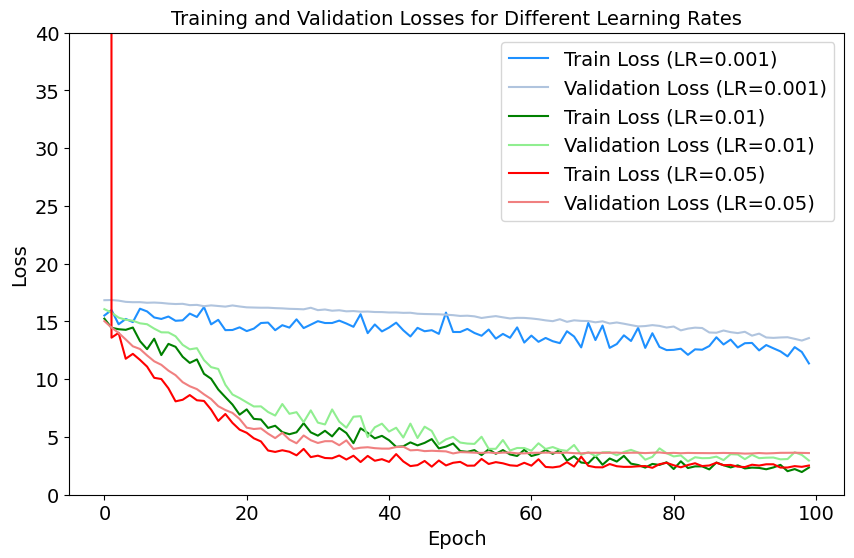

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a list of learning rates to experiment with
learning_rates = [0.001, 0.01, 0.05]

# Lists to store train and validation losses for each learning rate
train_loss_per_lr = []
val_loss_per_lr = []

# Rest of your code remains the same
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cVAE_classifier(input_dimension=148, latent_dim=4).to(device)

# Colors for lines
train_colors = ['dodgerblue', 'green', 'red']  # Shades of blue for training
val_colors = ['lightsteelblue', 'lightgreen', 'lightcoral']  # Lighter shades for validation

# Iterate through different learning rates
for lr_idx, lr in enumerate(learning_rates):
    print(f"Training with learning rate: {lr}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_list = []  # List to store train losses
    val_loss_list = []  # List to store validation losses

    model = cVAE_classifier(input_dimension=148, latent_dim=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    classifier_criterion = nn.MSELoss()

    num_epochs = 100
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} of {num_epochs}")
        # Train the model
        (train_loss_autism,
         train_loss_no_autism,
         train_age_loss_autism,
         train_age_loss_no_autism) = train(model,
            train_dataloader,
            train_dataset,
            device,
            optimizer,
            criterion,
            classifier_criterion,
        )

        # Validate the model
        (val_loss_autism, val_loss_no_autism,
         val_age_loss_autism, val_age_loss_no_autism) = validate(model, val_dataloader, val_dataset, device, criterion, classifier_criterion)

        # Appending the loss values to a list to allow for visualizations:
        train_loss_list.append(
            train_loss_autism
            + train_loss_no_autism
            + train_age_loss_autism
            + train_age_loss_no_autism
           )
        val_loss_list.append(
            val_loss_autism
            + val_loss_no_autism
            + val_age_loss_autism
            + val_age_loss_no_autism
        )

        # Print the losses
        print(
            f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f},"
            f"Train Age Loss Autism: {train_age_loss_autism:.4f}, Train Age Loss Non-Autism: {train_age_loss_no_autism:.4f}"
        )

    # Store train and validation losses for this learning rate
    train_loss_per_lr.append(train_loss_list)
    val_loss_per_lr.append(val_loss_list)

# Plot the training and validation losses for each learning rate
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(train_loss_per_lr[i], label=f"Train Loss (LR={lr})", color=train_colors[i])
    plt.plot(val_loss_per_lr[i], label=f"Validation Loss (LR={lr})", color=val_colors[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Learning Rates')
plt.legend()
plt.ylim(0, 40)  # Set y-axis limits
plt.show()


I have previously also experimented with higher learning rates. However, the instability of the model lead to poorer performance. As with 100 episodes, I achieve an equally as good performance using 0.01, but the model learns more stable. I chose this value. When inspecting models with 0.05, sometimes the various components of the model spikes up and down in their loss, but with 0.01, there was more so a gradual decrease among them.

Here is ChatGPTs answer as to why the learning rate may not matter that much with ADAM:
  > "The learning rate in the ADAM optimizer can be considered as an adaptive factor that adjusts during training based on the estimates of the first and second moments of the gradients. This adaptability allows ADAM to automatically adjust the learning rate for different parameters, which can be advantageous in terms of convergence speed and stability. As a result, the initial choice of learning rate becomes less critical compared to traditional optimizers, as ADAM's adaptive behavior helps mitigate the need for manual fine-tuning of the learning rate. This adaptability can often lead to reasonable training performance even with a wider range of initial learning rate choices, making ADAM more forgiving in practice."
